In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# All the main settings are in this cell.

MODE=1  # 0 for "global proteomics", 1 for "positive enrichment pulldown, e.g. biotin"

FILE="diann_no-norm" # This should be your FILENAME.pg_matrix.tsv. No extension needed.
GROUP_NAME = [
    # 10 uM
    "12well-IBN-DTB_10uM","12well-CF1-DTB_10uM",
    "24well-IBN-DTB_10uM","24well-CF1-DTB_10uM",
    "48well-IBN-DTB_10uM","48well-CF1-DTB_10uM",
    "96well-IBN-DTB_10uM","96well-CF1-DTB_10uM",
    "96well-25uL-beads-IBN-DTB_10uM","96well-25uL-beads-CF1-DTB_10uM",
    # merged / 30 uM arms
    "12well-IBN-DTB-10uM-IB-30uM","12well-CF1-DTB-10uM-CF1-30uM",
    "24well-IBN-DTB-10uM-IB-30uM","24well-CF1-DTB-10uM-CF1-30uM",
    "48well-IBN-DTB-10uM-IB-30uM","48well-CF1-DTB-10uM-CF1-30uM",
    "96well-IBN-DTB-10uM-IB-30uM","96well-CF1-DTB-10uM-CF1-30uM",
    "96well-25uL-beads-IBN-DTB-10uM-IB-30uM","96well-25uL-beads-CF1-DTB-10uM-CF1-30uM",
    # DMSO
    "12well-DMSO",
    "24well-DMSO", 
    "48well-DMSO",
    "96well-DMSO",
    "96well-25uL-beads-DMSO",]

reference_group = "12well-DMSO" # Setting reference group here. Reference group should have the least missing value, a.k.a. more complex proteome. For TPD, this should be DMSO, while for AP-MS, this should be treatment group
treat_10 = [
    "12well-IBN-DTB_10uM","12well-CF1-DTB_10uM",
    "24well-IBN-DTB_10uM","24well-CF1-DTB_10uM",
    "48well-IBN-DTB_10uM","48well-CF1-DTB_10uM",
    "96well-IBN-DTB_10uM","96well-CF1-DTB_10uM",
    "96well-25uL-beads-IBN-DTB_10uM","96well-25uL-beads-CF1-DTB_10uM",
]
treat_30 = [
    "12well-IBN-DTB-10uM-IB-30uM","12well-CF1-DTB-10uM-CF1-30uM",
    "24well-IBN-DTB-10uM-IB-30uM","24well-CF1-DTB-10uM-CF1-30uM",
    "48well-IBN-DTB-10uM-IB-30uM","48well-CF1-DTB-10uM-CF1-30uM",
    "96well-IBN-DTB-10uM-IB-30uM","96well-CF1-DTB-10uM-CF1-30uM",
    "96well-25uL-beads-IBN-DTB-10uM-IB-30uM","96well-25uL-beads-CF1-DTB-10uM-CF1-30uM",
]
DMSO = [
    "12well-DMSO","12well-DMSO",
    "24well-DMSO","24well-DMSO",
    "48well-DMSO","48well-DMSO",
    "96well-DMSO","96well-DMSO",
    "96well-25uL-beads-DMSO","96well-25uL-beads-DMSO",
]

comparison_matrix = (
    [[treat_10[i], treat_30[i]] for i in range(len(treat_10))] +
    [[treat_30[i], DMSO[i]] for i in range(len(treat_30))]+
    [[treat_10[i], DMSO[i]] for i in range(len(treat_10))]
)
print(comparison_matrix)
 # empty list means all other groups are compared with the reference group
# An example if you want to customize comparison groups:
"""
comparison_matrix = [
    ['NGT20-12_1uM', 'DMSO'],
] # treatment_group : reference_group
"""

control_group_detection_threshold=0.5 # This parameter controls whether you want to discard those unstably detected proteins in the control group. A value of 0.5 means only proteins shows up in at least half of control samples will be used for future calculation. A value of 0 means no protein will be discarded.
imputation_option=False # Enable imputation on both treatment group and reference group. Reference group needs to have >50% non-missing values. See readme.md for details.
NORMALIZATION_PROTEIN_ID="" # e.g. "Q13085" for Acetyl-CoA carboxylase 1 protein. If set, the proteome will be normalized according to the abundance of this protein in each sample. Empty string means no normalization.
PharosTCRD=False # Color the proteome according to the pharmacogenomics classification Tclin/Tchem/Tbio/Tdark, will cover any other colors. Read: http://juniper.health.unm.edu/tcrd/
limma_option=True # Enable R-limma model for statistics calculation. You need to install R, set environment variable R_HOME, and install limma library in R. Disable means student T test with BH adjustment
output_adjPval = True # Whether to output adjusted p-value (FDR) or not. Default is False, which means only raw p-value is outputted.



[['12well-IBN-DTB_10uM', '12well-IBN-DTB-10uM-IB-30uM'], ['12well-CF1-DTB_10uM', '12well-CF1-DTB-10uM-CF1-30uM'], ['24well-IBN-DTB_10uM', '24well-IBN-DTB-10uM-IB-30uM'], ['24well-CF1-DTB_10uM', '24well-CF1-DTB-10uM-CF1-30uM'], ['48well-IBN-DTB_10uM', '48well-IBN-DTB-10uM-IB-30uM'], ['48well-CF1-DTB_10uM', '48well-CF1-DTB-10uM-CF1-30uM'], ['96well-IBN-DTB_10uM', '96well-IBN-DTB-10uM-IB-30uM'], ['96well-CF1-DTB_10uM', '96well-CF1-DTB-10uM-CF1-30uM'], ['96well-25uL-beads-IBN-DTB_10uM', '96well-25uL-beads-IBN-DTB-10uM-IB-30uM'], ['96well-25uL-beads-CF1-DTB_10uM', '96well-25uL-beads-CF1-DTB-10uM-CF1-30uM'], ['12well-IBN-DTB-10uM-IB-30uM', '12well-DMSO'], ['12well-CF1-DTB-10uM-CF1-30uM', '12well-DMSO'], ['24well-IBN-DTB-10uM-IB-30uM', '24well-DMSO'], ['24well-CF1-DTB-10uM-CF1-30uM', '24well-DMSO'], ['48well-IBN-DTB-10uM-IB-30uM', '48well-DMSO'], ['48well-CF1-DTB-10uM-CF1-30uM', '48well-DMSO'], ['96well-IBN-DTB-10uM-IB-30uM', '96well-DMSO'], ['96well-CF1-DTB-10uM-CF1-30uM', '96well-DMSO'], ['

In [131]:
# Contaminants and PharosTCRD Datasets
#remove proteins from contaminant database
#contaminants=["ALBU_HUMAN", "AMY1A_HUMAN", "AMY1B_HUMAN", "AMY1C_HUMAN", "ANT3_HUMAN", "ANXA5_HUMAN", "B2MG_HUMAN", "BID_HUMAN", "CAH1_HUMAN", "CAH2_HUMAN", "CATA_HUMAN", "CATD_HUMAN", "CATG_HUMAN", "CO5_HUMAN", "CRP_HUMAN", "CYB5_HUMAN", "CYC_HUMAN", "EGF_HUMAN", "FABPH_HUMAN", "GELS_HUMAN", "GSTA1_HUMAN", "GSTP1_HUMAN", "HBA_HUMAN", "HBB_HUMAN", "HBEGF_HUMAN", "IGF2_HUMAN", "IL8_HUMAN", "INHBA_HUMAN", "INHBB_HUMAN", "KCRM_HUMAN", "LALBA_HUMAN", "LEP_HUMAN", "LYSC_HUMAN", "MYG_HUMAN", "NEDD8_HUMAN", "NQO1_HUMAN", "NQO2_HUMAN", "PDGFB_HUMAN", "PPIA_HUMAN", "PRDX1_HUMAN", "RASH_HUMAN", "RET4_HUMAN", "RS27A_HUMAN", "SODC_HUMAN", "SUMO1_HUMAN", "HARS1_HUMAN", "TAU_HUMAN", "THIO_HUMAN", "TNFA_HUMAN", "TRFE_HUMAN", "TRFL_HUMAN", "UB2E1_HUMAN", "UBE2C_HUMAN", "K1C26_HUMAN", "K2C3_HUMAN", "K1C15_HUMAN", "K2C79_HUMAN", "K2C6B_HUMAN", "K1C17_HUMAN", "K2C4_HUMAN", "K2C73_HUMAN", "K2C71_HUMAN", "K2C7_HUMAN", "K2C8_HUMAN", "K1C39_HUMAN", "K1C18_HUMAN", "K1C28_HUMAN", "K1C16_HUMAN", "K2C1_HUMAN", "K2C5_HUMAN", "K2C80_HUMAN", "K2C1B_HUMAN", "K2C75_HUMAN", "K2C6A_HUMAN", "K2C72_HUMAN", "K1C24_HUMAN", "K1C19_HUMAN", "K2C74_HUMAN", "K1C27_HUMAN", "K1C20_HUMAN", "K1C9_HUMAN", "K1C23_HUMAN", "K1C12_HUMAN", "K1C14_HUMAN", "K2C6C_HUMAN", "K1C10_HUMAN", "K1C13_HUMAN", "K22O_HUMAN", "K1C25_HUMAN", "K2C78_HUMAN", "K22E_HUMAN", "K1C40_HUMAN", "KRT85_HUMAN", "KRT38_HUMAN", "KRT34_HUMAN", "KRT86_HUMAN", "KRT35_HUMAN", "KT33B_HUMAN", "KRT81_HUMAN", "KRT37_HUMAN", "KT33A_HUMAN", "KRT83_HUMAN", "K1H1_HUMAN", "KRT82_HUMAN", "K1H2_HUMAN", "KRT36_HUMAN", "KRT84_HUMAN"]
contaminants=["P02768", "P0DUB6", "P0DTE7", "P0DTE8", "P01008", "P08758", "P61769", "P55957", "P00915", "P00918", "P04040", "P07339", "P08311", "P01031", "P02741", "P00167", "P99999", "P01133", "P05413", "P06396", "P08263", "P09211", "P69905", "P68871", "Q99075", "P01344", "P10145", "P08476", "P09529", "P06732", "P00709", "P41159", "P61626", "P02144", "Q15843", "P15559", "P16083", "P01127", "P62937", "Q06830", "P01112", "P02753", "P62979", "P00441", "P63165", "P12081", "P10636", "P10599", "P01375", "P02787", "P02788", "P51965", "O00762", "Q7Z3Y9", "P12035", "P19012", "Q5XKE5", "P04259", "Q04695", "P19013", "Q86Y46", "Q3SY84", "P08729", "P05787", "Q6A163", "P05783", "Q7Z3Y7", "P08779", "P04264", "P13647", "Q6KB66", "Q7Z794", "O95678", "P02538", "Q14CN4", "Q2M2I5", "P08727", "Q7RTS7", "Q7Z3Y8", "P35900", "P35527", "Q9C075", "Q99456", "P02533", "P48668", "P13645", "P13646", "Q01546", "Q7Z3Z0", "Q8N1N4", "P35908", "Q6A162", "P78386", "O76015", "O76011", "O43790", "Q92764", "Q14525", "Q14533", "O76014", "O76009", "P78385", "Q15323", "Q9NSB4", "Q14532", "O76013", "Q9NSB2"]

protein_kinase_list = ["O00141", "O00238", "O00311", "O00418", "O00444", "O00506", "O14578", "O14730", "O14733", "O14757", "O14920", "O14936", "O14965", "O14976", "O15021", "O15075", "O15111", "O15146", "O15197", "O15264", "O15530", "O43187", "O43283", "O43293", "O43318", "O43353", "O43683", "O43781", "O43930", "O60229", "O60285", "O60307", "O60566", "O60674", "O75116", "O75385", "O75460", "O75582", "O75676", "O75716", "O75914", "O75962", "O76039", "O94768", "O94804", "O94806", "O94921", "O95382", "O95747", "O95819", "O95835", "O96013", "O96017", "P00519", "P00533", "P00540", "P04049", "P04626", "P04629", "P05129", "P05771", "P06213", "P06239", "P06241", "P06493", "P07332", "P07333", "P07947", "P07948", "P07949", "P08069", "P08581", "P08631", "P08922", "P09619", "P09769", "P0C1S8", "P0C263", "P0C264", "P10398", "P10721", "P11309", "P11362", "P11801", "P11802", "P12931", "P14616", "P15056", "P15735", "P16066", "P16234", "P16591", "P17252", "P17612", "P17948", "P19525", "P19784", "P20594", "P20794", "P21127", "P21675", "P21709", "P21802", "P21860", "P22455", "P22607", "P22612", "P22694", "P23443", "P23458", "P24723", "P24941", "P25092", "P25098", "P27037", "P27361", "P27448", "P28482", "P29317", "P29320", "P29322", "P29323", "P29376", "P29597", "P30291", "P30530", "P31152", "P31749", "P31751", "P32298", "P33981", "P34925", "P34947", "P35590", "P35626", "P35916", "P35968", "P36507", "P36888", "P36894", "P36896", "P36897", "P37023", "P37173", "P41240", "P41279", "P41743", "P42679", "P42680", "P42681", "P42684", "P42685", "P43250", "P43403", "P43405", "P45983", "P45984", "P45985", "P46734", "P48729", "P48730", "P49137", "P49336", "P49674", "P49759", "P49760", "P49761", "P49840", "P49841", "P50613", "P50750", "P51451", "P51617", "P51812", "P51813", "P51817", "P51841", "P51955", "P51956", "P51957", "P52333", "P52564", "P53350", "P53355", "P53667", "P53671", "P53778", "P53779", "P54646", "P54753", "P54756", "P54760", "P54762", "P54764", "P57058", "P57059", "P57078", "P68400", "P78362", "P78368", "P80192", "Q00526", "Q00532", "Q00534", "Q00535", "Q00536", "Q00537", "Q01973", "Q01974", "Q02156", "Q02750", "Q02763", "Q02779", "Q02846", "Q04759", "Q04771", "Q04912", "Q05397", "Q05513", "Q05655", "Q05823", "Q06187", "Q06418", "Q07002", "Q07912", "Q08345", "Q08881", "Q09013", "Q12851", "Q12852", "Q12866", "Q13043", "Q13131", "Q13153", "Q13163", "Q13164", "Q13177", "Q13188", "Q13233", "Q13237", "Q13308", "Q13418", "Q13464", "Q13470", "Q13523", "Q13546", "Q13554", "Q13555", "Q13557", "Q13627", "Q13705", "Q13873", "Q13882", "Q13976", "Q14004", "Q14012", "Q14164", "Q14289", "Q14680", "Q15131", "Q15139", "Q15208", "Q15303", "Q15349", "Q15375", "Q15418", "Q15569", "Q15746", "Q15759", "Q15772", "Q15831", "Q15835", "Q16288", "Q16512", "Q16513", "Q16539", "Q16566", "Q16584", "Q16620", "Q16644", "Q16659", "Q16671", "Q16816", "Q16832", "Q2M2I8", "Q32MK0", "Q38SD2", "Q496M5", "Q504Y2", "Q52WX2", "Q56UN5", "Q59H18", "Q5JZY3", "Q5S007", "Q5TCX8", "Q5TCY1", "Q5VST9", "Q5VT25", "Q6A1A2", "Q6DT37", "Q6IQ55", "Q6J9G0", "Q6P0Q8", "Q6P2M8", "Q6P3R8", "Q6P3W7", "Q6P5Z2", "Q6PHR2", "Q6SA08", "Q6VAB6", "Q6XUX3", "Q6ZMQ8", "Q6ZN16", "Q6ZWH5", "Q76MJ5", "Q7KZI7", "Q7L7X3", "Q7RTN6", "Q7Z2Y5", "Q7Z695", "Q7Z7A4", "Q86SG6", "Q86TB3", "Q86TW2", "Q86UE8", "Q86UX6", "Q86V86", "Q86Y07", "Q86YV5", "Q86YV6", "Q86Z02", "Q8IU85", "Q8IV63", "Q8IVH8", "Q8IVT5", "Q8IVW4", "Q8IW41", "Q8IWB6", "Q8IWQ3", "Q8IWU2", "Q8IY84", "Q8IYT8", "Q8IZE3", "Q8IZL9", "Q8N165", "Q8N2I9", "Q8N4C8", "Q8N568", "Q8N5S9", "Q8N752", "Q8NB16", "Q8NCB2", "Q8NE63", "Q8NER5", "Q8NEV1", "Q8NEV4", "Q8NFD2", "Q8NG66", "Q8NI60", "Q8TAS1", "Q8TD08", "Q8TD19", "Q8TDC3", "Q8TDR2", "Q8TDX7", "Q8TEA7", "Q8TF76", "Q8WTQ7", "Q8WU08", "Q8WXR4", "Q8WZ42", "Q92519", "Q92630", "Q92772", "Q92918", "Q96BR1", "Q96C45", "Q96D53", "Q96GD4", "Q96GX5", "Q96J92", "Q96KB5", "Q96KG9", "Q96L34", "Q96L96", "Q96LW2", "Q96NX5", "Q96PF2", "Q96PN8", "Q96PY6", "Q96Q04", "Q96Q40", "Q96QP1", "Q96QS6", "Q96QT4", "Q96RG2", "Q96RR4", "Q96RU7", "Q96RU8", "Q96S38", "Q96S44", "Q96S53", "Q96SB4", "Q99558", "Q99570", "Q99640", "Q99683", "Q99759", "Q99986", "Q9BQI3", "Q9BRS2", "Q9BUB5", "Q9BVS4", "Q9BWU1", "Q9BX84", "Q9BXA6", "Q9BXA7", "Q9BXM7", "Q9BXU1", "Q9BYP7", "Q9BYT3", "Q9BZL6", "Q9C098", "Q9C0K7", "Q9H093", "Q9H0K1", "Q9H1R3", "Q9H2G2", "Q9H2K8", "Q9H2X6", "Q9H3Y6", "Q9H422", "Q9H4A3", "Q9H4B4", "Q9H5K3", "Q9H792", "Q9HAZ1", "Q9HBH9", "Q9HBY8", "Q9HC98", "Q9HCP0", "Q9NQU5", "Q9NR20", "Q9NRH2", "Q9NRM7", "Q9NRP7", "Q9NSY1", "Q9NWZ3", "Q9NY57", "Q9NYL2", "Q9NYV4", "Q9NYY3", "Q9NZJ5", "Q9P0L2", "Q9P1W9", "Q9P286", "Q9P289", "Q9P2K8", "Q9UBE8", "Q9UBS0", "Q9UEE5", "Q9UEW8", "Q9UF33", "Q9UHD2", "Q9UHY1", "Q9UIK4", "Q9UK32", "Q9UKE5", "Q9UKI8", "Q9UL54", "Q9UM73", "Q9UPE1", "Q9UPZ9", "Q9UQ07", "Q9UQ88", "Q9UQB9", "Q9UQM7", "Q9Y243", "Q9Y2H1", "Q9Y2H9", "Q9Y2K2", "Q9Y2U5", "Q9Y3S1", "Q9Y463", "Q9Y4K4", "Q9Y572", "Q9Y5S2", "Q9Y616", "Q9Y6E0", "Q9Y6M4", "Q9Y6R4", "Q9Y6S9", "Q5MAI5", "Q8NE28", "Q9NSY0", "Q3MIX3"]
protein_ubiquitination_list = ["P49902", "O95342", "Q13155", "Q9P2G1", "P31749", "Q9H8T0", "Q9UKV5", "Q9C0C7", "Q9UJX6", "Q96BM1", "Q92624", "Q9UM13", "Q9NYG5", "Q9BS18", "P60006", "Q96DE5", "Q9H1A4", "Q9UJX5", "Q9UJX4", "Q9UJX3", "O15033", "Q8N726", "Q9Y4X5", "O95376", "Q6ZSG1", "P49407", "P32121", "Q8N5I2", "Q8NCT1", "Q8WXI3", "Q8WXH4", "Q8WXK4", "Q8WXK3", "A6NK59", "Q8WXK1", "Q96NS5", "Q8WXJ9", "Q6ZVZ8", "Q9Y576", "Q96Q27", "Q9Y575", "Q9Y574", "Q8WWX0", "Q9NWX5", "Q9H672", "Q9H765", "Q96DX5", "Q9NT62", "Q9H1Y0", "O15169", "Q8WZ19", "Q13829", "Q9H3F6", "Q99728", "P10415", "Q9NZS9", "Q13490", "Q9NR09", "Q96CA5", "Q13867", "Q7Z569", "P38398", "Q5VTR2", "O75150", "Q9H0C5", "Q86VP6", "O75155", "Q13191", "Q9ULV8", "Q8N7E2", "P22681", "Q8IX12", "P41002", "Q13042", "Q12834", "Q9UJX2", "Q8NHZ8", "P30260", "Q99618", "Q96EP1", "Q9UNE7", "O43734", "Q9NPC3", "Q9NSE2", "Q96M02", "O95628", "Q8NHY2", "Q96SW2", "P35222", "Q13616", "Q13617", "Q13618", "Q13619", "Q13620", "Q93034", "Q14999", "Q8IWT3", "Q8N136", "Q5QP82", "Q8TEB1", "Q5T6F0", "Q9NV06", "Q66K64", "Q9NXF7", "Q5H9S7", "Q9Y4B6", "Q8WV16", "Q96JK2", "Q58WW2", "P61962", "Q5TAQ9", "Q5T197", "Q9BW61", "Q16531", "Q92466", "Q7L5Y6", "Q9NZJ0", "Q86Y01", "Q86UW9", "Q8TDB6", "Q8N9I9", "Q9Y2E6", "Q86Y13", "Q66K89", "Q53HC9", "Q15370", "Q15369", "O14682", "Q13216", "Q9NW38", "Q8NFZ0", "P0C2W1", "Q6X9E4", "Q9Y297", "Q9UKB1", "Q9UK96", "Q86XK2", "Q8NEZ5", "O75426", "Q8TCJ0", "Q9NVF7", "Q9UK22", "Q8TB52", "Q5XUX0", "Q969P5", "Q7Z6M2", "Q6PIJ6", "Q9UK99", "Q4G163", "Q9UKT5", "Q9UKT4", "Q9NRD1", "Q9Y3I1", "Q9UK97", "Q9UKC9", "Q9UKT7", "Q9UKA1", "Q9UJT9", "Q969U6", "Q969H0", "Q8N3Y1", "Q9BSK4", "Q9UK73", "Q96JP0", "C9JXX5", "Q9NXK8", "Q9H469", "Q9UF56", "Q9UKT6", "Q6P050", "P06241", "Q9UM11", "Q7L622", "Q9H2C0", "Q8NEA9", "Q86XS8", "Q8IYU2", "Q75N03", "Q9UBN7", "Q9ULT8", "Q5U5R9", "Q5T447", "Q9Y4D8", "Q76N89", "Q9P2P5", "Q15751", "O95714", "Q15034", "Q5GLZ8", "Q9UII4", "Q8IVU3", "Q14527", "Q9BYM8", "Q9BVR0", "Q7Z6Z7", "Q8IU81", "Q9H1B7", "P40305", "Q9P2H3", "Q96J02", "Q9NQC1", "Q8IY47", "Q86V97", "Q8WVZ9", "Q8NFY9", "C9JR72", "Q693B1", "Q4G0X4", "Q9P0J7", "Q8NC69", "Q7L273", "Q14145", "Q6PID8", "Q8N7A1", "Q9Y2U9", "Q9BQ90", "Q6JEL2", "Q53G59", "Q9P2N7", "Q96M94", "Q6TDP4", "O94889", "Q9Y2M5", "Q9UJP4", "Q53GT1", "Q6TFL4", "Q9H0H3", "Q8N4N3", "O60662", "Q9P2K6", "O95198", "Q9UH77", "Q8IXQ5", "Q9P2G9", "Q9P2J3", "Q9UIQ6", "Q2Q1W2", "Q96L50", "Q8WWI1", "Q8TBB1", "Q15345", "Q6UWE0", "O94822", "Q8N653", "Q9HAY2", "Q9UJ55", "Q8TCQ1", "Q9P0N8", "Q86UD3", "Q9P2E8", "Q9NX47", "O60337", "Q9H992", "Q5T0T0", "Q86YJ5", "Q8NA82", "A6NNE9", "Q00987", "O15151", "Q9BTT4", "Q9P086", "Q93074", "Q9NVC6", "Q15648", "Q13503", "Q6P2C8", "Q96HR3", "Q9Y3C7", "O75586", "O43513", "Q96G25", "Q7Z7M0", "Q9BQA1", "O60291", "Q86YT6", "Q96AX9", "Q9UHC7", "Q9H000", "Q13064", "Q13434", "Q9HCI7", "Q969V5", "O75592", "Q8WY64", "O60934", "Q15784", "Q00604", "Q96PU5", "P46934", "A8MQ27", "O76050", "Q9BR09", "Q96EH8", "Q14494", "Q16236", "Q12986", "Q6VVB1", "Q5JS37", "Q13287", "P15559", "Q9Y5A7", "Q5W0B1", "Q13438", "Q96BN8", "Q96MG8", "Q8WW12", "Q13951", "Q96FA3", "Q9HAT8", "Q8N2H9", "O60683", "O00623", "P28328", "Q9P1Y6", "Q9BXM7", "Q8NG27", "O43164", "P53350", "O60927", "Q13356", "Q5VXH4", "P0DUQ2", "P78395", "O60260", "Q9UMS4", "P55786", "Q9UPQ7", "O15541", "P50876", "Q7Z419", "A8MTL3", "P63244", "Q9NS91", "P15918", "Q8WXH6", "Q12829", "Q96S21", "P0C0E4", "Q7Z6E9", "P62877", "Q9UBF6", "Q5TC82", "Q9HBD1", "Q8WZ73", "Q6PCD5", "Q06587", "Q99496", "P62987", "Q9H871", "O00237", "Q6ZNA4", "Q9ULX5", "Q9Y508", "Q9Y4L5", "Q9H920", "Q9H9V4", "Q5XPI4", "Q96EQ8", "Q9BV68", "Q8TEB7", "Q8WVZ7", "Q8IUD6", "Q8WVD3", "Q8WU17", "Q8WVD5", "Q9NTX7", "Q8NC42", "Q8N8N0", "Q96PX1", "Q96A37", "Q9H6Y7", "Q8IYW5", "Q8NCN4", "Q96K19", "Q86T96", "Q9P0P0", "Q8N6D2", "Q96D59", "Q96GF1", "Q9NXI6", "Q5TA31", "Q9NV58", "Q6ZMZ0", "Q9H0X6", "Q63HN8", "Q9NWF9", "Q8TC41", "Q5VTB9", "E7ERA6", "M0QZC1", "A6NIN4", "A0A7I2V3R4", "Q8N5U6", "Q9Y3C5", "Q9NVW2", "O43567", "Q9UBS8", "Q96BH1", "Q9BY78", "Q96EP0", "Q969K3", "O94941", "Q9H0F5", "Q9H2S5", "Q9H4P4", "Q68DV7", "Q7L0R7", "P78317", "Q99942", "Q9Y252", "O76064", "Q5M7Z0", "P19474", "Q92834", "P62979", "P62861", "Q9BVN2", "Q9UBE0", "O94885", "Q6IQ49", "Q7Z6J0", "Q8TEC5", "Q8TEJ3", "Q149N8", "Q9H0F6", "Q8IUQ4", "O43255", "Q96EB6", "P63208", "Q13309", "Q9HCE7", "Q9HAU4", "O15524", "O14508", "O14543", "Q8WXH5", "O75159", "O14544", "O14512", "Q6IQ16", "O43791", "Q96BD6", "Q99619", "Q6PJ21", "Q96A44", "Q86TM6", "P21675", "P55072", "P52888", "O15164", "A0AVI4", "P21580", "O95271", "Q9H2K2", "Q9NS56", "Q8TEL6", "P29144", "Q12933", "Q9Y4K3", "Q6Q0C0", "Q9BWF2", "Q96F44", "O60858", "Q9Y577", "Q8IYM9", "P36406", "Q14258", "Q12899", "P14373", "Q9BZY9", "Q13049", "Q9UPN9", "Q9BYJ4", "Q9UPQ4", "O94972", "O00635", "Q9HCM9", "Q8WV44", "Q8IWZ5", "Q9H8W5", "Q96LD4", "Q96A61", "Q9BYV6", "Q9BRZ2", "Q8NG06", "Q8IWR1", "Q9BVG3", "Q969Q1", "Q6PJ69", "Q6AZZ1", "Q86WT6", "Q9UJV3", "Q9C040", "O75382", "Q9C037", "Q9C035", "Q9C030", "Q9C029", "Q9BZR9", "Q9C026", "Q8N9V2", "Q8N7C3", "Q14669", "P53804", "Q9NRJ4", "A1L167", "P51668", "P62837", "P61077", "Q9Y2X8", "P51965", "Q96LR5", "Q969T4", "P62253", "P60604", "Q9Y385", "Q8N2K1", "P68036", "A0A1B0GUS4", "O14933", "Q7Z7E8", "Q8WVN8", "P49427", "Q712K3", "Q13404", "Q15819", "P22314", "A0AVT1", "P41226", "Q9BSL1", "P0CG47", "P0CG48", "O15205", "P49459", "P63146", "O00762", "P62256", "P61086", "P61088", "Q9C0C9", "Q16763", "Q9NPD8", "Q5VVX9", "Q96B02", "Q9H832", "Q05086", "Q7Z3V4", "Q15386", "Q7Z6J8", "Q14139", "O95155", "P45974", "Q93009", "Q8IWV7", "Q8IWV8", "Q6ZT12", "Q5T4S7", "O95071", "Q8N806", "P15374", "Q5JXB2", "Q96T88", "Q96PU4", "Q9H9P5", "Q93008", "Q2YD98", "Q96JH7", "P40337", "Q9H270", "Q9P253", "Q96S15", "Q8N5D0", "Q9Y6I7", "Q9NYS7", "Q8N9V3", "Q9H0M0", "O00308", "Q9GZV5", "P98170", "Q05516", "Q86WB0", "Q9NQZ6", "Q96JP5", "Q96PM5", "Q86UK7", "Q8NE65", "Q8ND25", "Q8NHG8", "Q9ULT6", "Q8WWF5", "Q8NEG5", "A7E2V4"]
# PharosTCRD dataset
Tbio = ["Q49A92", "Q9UFW8", "O14646", "Q8IWX8", "Q99653", "O94983", "P42695", "Q8IYT2", "Q9NSA3", "Q96KP4", "O95476", "Q6P9H4", "O95406", "Q9P232", "P26992", "Q9NXG0", "Q01955", "P27658", "P02461", "P0C0L5", "P20908", "P25940", "Q9GZY4", "P10643", "Q7L8W6", "Q9BTV6", "Q13057", "P00414", "Q9NRP2", "O43809", "Q6UW02", "P05813", "Q9NQ79", "P43320", "O94985", "Q8N8Q3", "Q5W186", "Q9HC47", "Q96RT6", "Q53GD3", "O43310", "Q8WVB6", "P26232", "P29279", "P52569", "Q8WZ74", "O60494", "O60888", "P39880", "P13929", "P09104", "Q02221", "P14854", "P48165", "P35212", "O95452", "P19876", "P08034", "P80162", "P02775", "O75712", "P00167", "Q9HB71", "P00156", "O14548", "Q96SQ9", "O75718", "O75462", "Q9HC73", "Q9Y2W7", "P0DML2", "Q9BV81", "P50402", "Q96A84", "Q7L5N1", "Q9UBW8", "Q99708", "P35221", "Q8WWI5", "Q13618", "Q9NTM9", "O14529", "P19875", "P42830", "Q9NTQ9", "O43927", "O95715", "Q6UXB2", "P49447", "Q53TN4", "O95674", "Q5SZL2", "Q2WEN9", "Q9UPV0", "Q03701", "Q9HCU4", "Q96LK0", "Q9BS16", "P07199", "Q9NYQ6", "Q9BU64", "O15182", "Q96MT7", "Q8N6G5", "Q8N1V2", "P61604", "P09622", "Q12873", "Q8TBE1", "Q8IV77", "Q9P003", "Q14028", "P04440", "P51911", "O75175", "O95628", "Q9UHC6", "Q9UFF9", "Q92600", "Q8N137", "Q7Z7A1", "Q9BZG8", "P07358", "Q14055", "P12109", "P12111", "A8TX70", "A6NMZ7", "P13671", "Q9H2P9", "O60762", "Q10570", "Q8TEY5", "Q7Z7G2", "Q8N1N5", "Q4LDR2", "Q13616", "Q8IWT3", "Q7L5Y1", "Q9UHY7", "Q16206", "P12074", "P24310", "P14406", "Q6YFQ2", "P17302", "P36382", "P57773", "P78310", "Q6PEY0", "P29033", "Q8N144", "O95377", "O14625", "Q7LFL8", "Q9P0U4", "P13498", "O43169", "Q9NQC7", "Q5TYM5", "Q86UY5", "Q5TA50", "O14810", "Q8N436", "Q8IZJ3", "Q9Y4K1", "Q9Y262", "Q6WN34", "Q8TCG5", "P23508", "Q9UGL9", "Q494W8", "P02741", "Q9H336", "Q5TZA2", "Q5IJ48", "Q9BUF7", "O43186", "O60716", "Q9UQB3", "Q9UBT7", "Q8N4M1", "Q8WY07", "Q05D32", "Q7Z7A3", "Q9H467", "Q93034", "Q07325", "Q9UKL4", "Q15517", "Q92903", "Q9C0D2", "Q03188", "Q6IPU0", "Q92879", "Q9H3R5", "Q68CQ4", "P49450", "Q9BZC1", "Q71F23", "Q6ZMG9", "P57076", "Q0VF96", "Q9UL16", "P36222", "Q8WYQ3", "Q8N1G2", "Q86XI2", "Q8N3K9", "Q96KN2", "Q8WXI2", "Q8NE01", "Q99439", "Q15417", "Q96LI5", "A5YKK6", "Q9Y2B0", "Q9NZN8", "O94779", "Q9H4B8", "Q92782", "P26441", "Q96EV8", "P20674", "Q8TEA8", "Q96FN9", "P10176", "Q9HBI6", "Q9HCS2", "Q9HCH3", "Q9H799", "P04632", "P24903", "Q8TAV3", "Q8NE35", "Q6PUV4", "Q17RY0", "A0A087X1C5", "Q5TCH4", "P53673", "P78560", "Q9H0B8", "Q8IUI8", "Q9Y2S2", "Q15006", "P04141", "P30825", "O43246", "Q6UWT2", "Q9NWM3", "A6NNW6", "Q13620", "Q86UP6", "Q9P013", "Q9HCG8", "Q6UX04", "Q8TE69", "Q8TC92", "Q9Y6H8", "P36383", "Q5T442", "Q8NFK1", "P02778", "Q9H2A7", "Q9H2H0", "P13236", "P16070", "Q6P1J9", "Q86X02", "Q16878", "Q9H6K1", "Q8NHQ1", "Q96EP1", "Q96BP2", "Q9Y6H1", "Q9UJW3", "Q6XZF7", "O00115", "P49184", "Q13609", "P13765", "Q96BY6", "Q14184", "Q14185", "Q8IZD9", "Q96N67", "Q9Y6Y1", "Q9BPX3", "Q6IBW4", "P62633", "Q4W4Y0", "P09543", "Q15021", "G9CGD6", "Q12860", "Q02246", "Q8IWV2", "Q9UQ52", "Q8N815", "Q9BZ76", "Q9C0A0", "Q9Y2V0", "P02458", "P08572", "Q49MI3", "Q9HC77", "Q96BT3", "Q8N0S6", "Q96ST8", "Q7Z7K6", "P08603", "P05156", "Q86XR8", "Q76N32", "Q99674", "Q9Y6A4", "Q96JM3", "Q8TDI0", "Q9HCK8", "Q3L8U1", "Q8NE62", "Q5T2R2", "Q5JU00", "Q8NEE6", "Q9H095", "Q86Y22", "Q9NYL5", "Q9H3G5", "P17927", "Q96BA8", "O43768", "O75356", "Q9NQZ7", "Q9NPA8", "Q9Y6X5", "O95925", "Q14677", "Q5JZY3", "O15083", "O43731", "Q4G0M1", "Q8IV48", "A8K979", "Q96RQ1", "O43414", "O75477", "O94905", "Q96PL5", "P47775", "Q8NDV2", "Q8TE68", "Q9H6S3", "Q8TE67", "Q96AP7", "Q5FWF5", "Q56NI9", "O75715", "Q96J88", "Q6NXG1", "P12544", "Q8N693", "P49863", "Q6IC98", "O75791", "Q13588", "Q9BSJ8", "A0FGR8", "A0FGR9", "Q13322", "Q3V6T2", "P50549", "P41162", "P15036", "Q9NYK6", "P58658", "P57679", "P22794", "Q9UI08", "P49640", "Q03828", "Q01844", "Q7LDG7", "P47902", "P31997", "Q96J87", "Q8TD26", "P25067", "P0C0L4", "P07360", "P20849", "P02462", "P12110", "Q9Y2R0", "Q02388", "Q15054", "Q9HCU8", "P56282", "Q9NRF9", "Q9NY33", "P23528", "Q9Y281", "Q7L190", "A6NC42", "Q17RW2", "Q8NHY2", "Q9UII6", "Q5RI15", "P0DPQ6", "Q494V2", "Q6UX73", "O75354", "Q9UM22", "O95278", "Q9HCE0", "Q9H201", "Q5T890", "Q2NKX8", "P07992", "Q03468", "Q13216", "P50548", "O76062", "Q9UKR5", "Q9Y282", "Q969X5", "P49685", "Q96HE7", "Q99680", "Q96DN0", "O00270", "Q9Y5Y3", "Q86YR5", "P81274", "P0DP91", "Q96I76", "Q9UJM3", "P07203", "P18283", "P22352", "Q9H501", "Q96SL4", "Q9NQ30", "Q6UWW8", "Q5XG92", "Q6NT32", "P20718", "P51124", "P28676", "Q4V328", "Q7Z6J2", "Q9NY74", "Q14449", "P13804", "P01133", "P0C7U0", "P32519", "P28324", "Q9NYP7", "Q9UJA9", "Q9UNN8", "O75616", "Q8IUS5", "Q96RT1", "P15170", "P11308", "P84090", "Q96DZ1", "Q8TAM6", "Q7Z2K6", "Q9BS26", "Q86YB8", "Q9NS67", "P30040", "O15354", "Q9BZJ8", "Q9BZJ7", "O95800", "Q96P69", "P60893", "Q13227", "Q9Y4H4", "P40197", "Q14549", "Q9Y2E6", "Q5JST6", "Q9BUP0", "P57678", "Q8TEQ6", "Q8WXD5", "P52803", "P98172", "P52799", "P55040", "Q17RS7", "Q9NQX3", "Q99684", "Q14156", "Q9Y2G0", "O43281", "Q86UU5", "Q9H1K4", "Q8N2G8", "P49770", "Q9H4M9", "Q9NWU2", "Q99944", "Q63HQ2", "P19419", "P41970", "Q96BJ8", "Q9BW60", "Q9NXB9", "Q99607", "Q9UKW6", "P13284", "Q8WWP7", "Q9UG22", "Q9NUV9", "Q96F15", "Q6P9H5", "Q8NHV1", "Q8ND71", "Q9NXP7", "O14908", "Q8TF65", "Q8TF64", "P09681", "Q9Y2X7", "Q14161", "Q9NS71", "Q86XP6", "O95936", "Q5NDL2", "B3EWF7", "Q96L91", "Q9Y6I3", "O95208", "Q9H6B9", "P19447", "Q9H790", "Q96A65", "Q13868", "O00167", "O95677", "Q9UBQ6", "P15311", "Q8TC76", "Q9H098", "Q9NQL9", "Q07687", "Q86Y01", "Q9NRD9", "Q9Y6W6", "O94808", "Q6UXV0", "P0CL82", "Q9UJY5", "Q9UJY4", "Q9NZ52", "Q9BVM4", "Q9H3C7", "Q9H3K2", "P18146", "Q14152", "Q6UWR7", "Q6UW88", "Q99645", "P01588", "Q9UHW5", "Q14956", "O14944", "P62495", "P24390", "P33947", "Q7L7V1", "Q9Y5R6", "Q9Y222", "O95620", "A8MPY1", "Q9BY84", "Q96CN9", "O43812", "O14681", "Q9UHF1", "P41214", "Q13144", "P41567", "P55199", "O95163", "Q9H9T3", "Q96EB1", "Q5MY95", "Q9Y5R5", "Q9Y2H0", "Q4LDG9", "Q7Z5Q5", "O75417", "Q8TD84", "Q02487", "Q9NZJ0", "Q9H0R8", "P35573", "Q96G04", "Q9UK05", "P36268", "P36269", "Q6P531", "Q9UJ14", "Q14232", "Q9Y6B2", "O00472", "Q8TE02", "Q9HBU6", "Q0PNE2", "Q9NX74", "Q16829", "Q92947", "Q9NRW4", "P16383", "Q8IUX8", "O15371", "P17813", "Q8IVV7", "O75821", "Q9HB65", "Q13347", "Q9NVF9", "Q8IZ81", "Q92556", "Q9GZR5", "Q9Y227", "Q9H2F5", "O95886", "P28067", "Q9GZS0", "Q8TDM6", "Q02742", "O95395", "Q6ZNI0", "Q9BSJ2", "Q8WXX0", "Q96JB1", "Q96RT7", "Q6ZR08", "Q0VDD8", "P63167", "P51808", "Q7RTS9", "Q9UQ16", "Q86XF0", "Q8N6F7", "Q16254", "Q15329", "A0AVK6", "P23434", "Q9H4G0", "Q9HCM4", "Q96JC9", "Q96CJ1", "P43026", "Q6KF10", "Q96RP9", "P07093", "Q8N9F7", "P51530", "Q8N1N2", "O75923", "Q03001", "Q86YF9", "Q86Y13", "O00716", "O75461", "Q96AV8", "Q01094", "O43491", "Q9Y2J2", "Q56P03", "Q9HAF1", "O95905", "P40939", "P55084", "P30084", "Q08426", "P42126", "O75521", "Q6UWP2", "Q9H6R0", "Q8NDZ4", "O60879", "Q9UKB3", "Q96SC8", "Q9P1A6", "Q86YH6", "Q8TF09", "Q92997", "Q13838", "Q9NP62", "Q9P109", "Q96CW5", "Q9UGJ1", "Q96RT8", "Q8NCM8", "Q8TE73", "Q05193", "Q14209", "Q9H329", "Q66K89", "Q9HCS5", "Q9NR61", "Q92988", "Q9UGM3", "O00148", "Q99848", "O95672", "P12724", "Q6P2E9", "Q9BV94", "Q9BZQ6", "O60869", "O43854", "P14138", "Q7L9B9", "Q3B7T1", "O95992", "Q9H9P2", "Q8NFT8", "Q96EY1", "Q8WW22", "P25685", "P61024", "Q8WZ79", "Q92874", "O96005", "P06340", "Q14183", "Q8N1I0", "Q9H7D0", "Q96HP0", "Q8NF50", "Q9BZ29", "Q9BU89", "Q99704", "O60496", "Q7L591", "Q8TEW6", "Q9P104", "Q6PKX4", "Q18PE1", "Q9UPQ8", "Q9NYP3", "Q9Y3R5", "P30046", "Q1HG43", "Q1HG44", "Q9UKG1", "Q8NEU8", "P20036", "Q9H5Z1", "O75911", "Q9H2U1", "Q9UBX3", "Q14689", "Q9NXW2", "Q9UBU2", "Q9UK85", "Q15700", "O96015", "Q9NR33", "Q9UHN1", "O75879", "P16520", "Q9HAV0", "Q13202", "Q9UNI6", "Q8WTR2", "P30793", "O75603", "Q92616", "Q9H3P7", "Q14204", "Q8IVF4", "Q96DT5", "Q9P2D7", "Q9P225", "Q96FJ2", "P63172", "Q92538", "P32926", "O60469", "O95166", "Q4G0W2", "Q13115", "Q96G46", "P52951", "Q8IWJ2", "O77932", "O14641", "Q7Z7B8", "Q13117", "Q9UK59", "Q8WV16", "Q9UHI6", "Q9Y6V7", "Q9NUI1", "O75064", "Q16854", "O43143", "Q8TBM8", "P59910", "Q8N4W6", "Q9UBT3", "Q8NFW5", "Q96GE9", "Q9NW81", "P49448", "Q6P3W2", "Q8IXB1", "A7MBM2", "Q9P2K9", "O00548", "P56178", "P56179", "Q9BVJ7", "Q8TDB6", "Q05923", "Q68J44", "O95147", "Q9H1R2", "Q8NEJ0", "Q6P1R4", "Q9UBX2", "Q05215", "P60228", "Q9Y2C4", "Q9Y3B2", "Q96B26", "O43909", "P50502", "O75949", "Q96EK7", "O00757", "Q6P4H8", "Q96LR4", "Q96KR6", "O94988", "Q9NUQ9", "P12259", "Q96KN1", "Q06889", "Q9NZC4", "O15372", "Q8N336", "Q12929", "Q9NVH0", "Q96KP1", "Q9UQ84", "Q9NPD3", "Q9NQT4", "Q93063", "Q92935", "Q5T1H1", "O95990", "Q96PZ2", "Q6SJ93", "Q3B820", "P05160", "Q96GL9", "Q8N612", "Q8N3H0", "Q9H0X4", "P16118", "Q9BY44", "Q8N6I1", "P11161", "Q9NR50", "Q99613", "Q14241", "Q96FG2", "Q8WYP5", "Q96C92", "Q6UWV6", "Q8TED1", "Q14674", "Q96BH3", "O95571", "P34910", "Q96CN4", "O60447", "P28799", "P09341", "Q92817", "Q2M3D2", "Q01780", "Q8TAG9", "Q9UPT5", "Q16394", "Q99504", "Q1W6H9", "P07492", "Q9NZB2", "Q9UI10", "Q9NZN4", "Q9NZN3", "P55884", "Q15370", "P19957", "Q6IA86", "Q15723", "Q12926", "P78545", "P15502", "Q9UBC2", "Q16134", "O00321", "P14921", "P43268", "P41212", "Q9Y603", "Q8IXQ9", "Q9H8M9", "Q8TDF6", "Q06265", "Q8IYI6", "Q5RKV6", "Q99502", "Q15024", "Q8NEV8", "P0C0S5", "Q8NCA5", "Q7Z2G1", "Q8WVX9", "P68431", "Q96CS3", "Q9Y2M0", "Q8NDI1", "Q9H223", "O60739", "O00303", "P26378", "P0DMC3", "A1L3X0", "Q15369", "P60002", "Q96JJ3", "Q14264", "B1AK53", "Q9H6T0", "Q96DF8", "Q86US8", "A6NFK2", "A4D2P6", "P41161", "Q658Y4", "Q9NYF5", "Q96MK3", "P48637", "Q96KN4", "Q96A26", "Q86V87", "Q9NX05", "Q8WUF8", "P81408", "Q6UWH4", "Q7Z5A9", "Q9NX38", "P23610", "Q14320", "Q9Y247", "Q8IXL6", "Q7L5A8", "O60814", "P57053", "Q13158", "Q96BQ1", "Q9NVQ4", "O60667", "P58499", "Q92520", "Q9Y4F1", "Q14CZ7", "O15287", "P16422", "A6NDY0", "Q9Y2D4", "Q9NV70", "O60645", "O00471", "Q9NQT5", "Q8N9E0", "Q70Z53", "Q49AJ0", "Q96KS9", "Q92567", "Q12849", "Q9BQ67", "Q96E09", "Q9UK99", "Q96EF6", "P22087", "Q9UKA1", "Q6PIJ6", "P31994", "Q86XK2", "P33778", "Q9BXW9", "O75844", "Q16695", "Q9UNN5", "Q6P587", "Q9BTP7", "Q969F0", "Q8TES7", "O95967", "Q969P5", "Q9HAV7", "Q8TAA5", "P16930", "O95864", "Q9Y5Q0", "Q8TC84", "Q6V0I7", "Q00597", "Q8WWV6", "Q9UKA2", "Q8TCJ0", "Q12805", "Q01362", "Q96LA5", "Q7L513", "P35556", "P04080", "Q86T65", "P98082", "Q96EP5", "Q9UER7", "Q10586", "O43237", "Q96FF9", "Q9BYE9", "P55273", "O43866", "Q16667", "Q9BWV3", "O60308", "P42771", "P17676", "Q15782", "P10809", "O14647", "O43745", "Q96BS2", "Q8IYX4", "Q9UF47", "O60884", "P25686", "Q9UDY4", "O75953", "O75190", "Q7Z6W7", "Q8NHS0", "Q9UBS3", "Q96KC8", "Q99543", "Q13217", "Q9H3Z4", "Q99615", "O75937", "Q8WXX5", "Q8IYA6", "P49916", "P33552", "P49917", "Q08477", "Q9BSJ5", "Q96MF6", "Q9P2I0", "P61201", "Q9UNS2", "Q8WXC6", "Q9H9Q2", "O14682", "Q9H8E8", "Q96S65", "Q05048", "P33240", "Q9H0L4", "Q9BQT9", "Q9P2B4", "Q8WYA6", "P0CG13", "Q96CG8", "O15194", "O60931", "Q9UI47", "Q6PD62", "Q8TC29", "Q6NT55", "Q70SY1", "P26998", "O75177", "P07315", "P07320", "Q00013", "P06850", "Q5UCC4", "Q53ET0", "Q8N766", "Q9Y534", "A4GXA9", "Q9BXX0", "P54851", "O43739", "P08174", "Q8N3J3", "P20853", "Q8WVH0", "P13584", "Q9BU40", "Q6UXH1", "Q53HC9", "Q03060", "O95834", "Q9HC35", "P21291", "Q16527", "P50461", "Q9H114", "Q9H112", "Q9H4D0", "O60676", "Q5HYN5", "Q13363", "O75638", "Q8NI51", "P78358", "O15320", "Q9BRF8", "P98187", "Q16630", "Q9UBL6", "Q9H4I9", "Q13098", "Q7Z589", "Q6UVK1", "Q1MSJ5", "Q12996", "P21128", "Q2NKJ3", "P49711", "Q9Y5B0", "O14595", "Q16619", "Q8IWA5", "Q14999", "Q13617", "O75131", "Q6ZWL3", "Q8N118", "Q9BV73", "Q15438", "Q99418", "Q9BWK5", "Q9H4H8", "Q8NEG4", "O76096", "O60759", "Q8N465", "Q9P219", "Q9BTE1", "Q96SD1", "O00622", "A6ND36", "Q6ZRV2", "Q8NG35", "Q96NX9", "P61803", "P01037", "P28325", "Q6ZPD9", "Q96J86", "Q8NEP3", "P0DP74", "Q9UJU6", "A6NMT0", "O14576", "Q9Y6G9", "Q5H9S7", "P10606", "Q99829", "Q9BZB8", "Q7Z449", "Q9UJA2", "Q9UIA0", "Q14093", "Q7L576", "P01040", "Q92904", "P22676", "Q13939", "Q96L12", "Q9Y6W3", "O75808", "Q96LZ3", "P40121", "Q9BWT7", "Q96LW7", "P56202", "Q6NZI2", "O95810", "P16870", "Q9UPW5", "Q13185", "Q8NHW4", "Q9H6E4", "O75976", "A6NC98", "Q9UNH5", "A2RUB6", "Q8NEL0", "Q16589", "Q8ND76", "P80075", "O00585", "Q05682", "P47756", "Q9NXV6", "Q9NQ75", "Q8NEF3", "A6NKD9", "Q9BRT8", "Q86WR0", "Q96HJ3", "Q99618", "P19397", "Q8IWY9", "Q9H211", "Q5SW79", "Q12982", "Q7L3V2", "Q7Z465", "P22004", "Q8WVV5", "P20290", "Q9BXI9", "Q9NRR3", "P02746", "P57796", "O75309", "Q5T440", "P55286", "Q9BX69", "Q8N350", "P51636", "Q9NTU7", "P22681", "Q86Z20", "Q8IX12", "Q53HC0", "Q76M96", "Q9Y698", "P51946", "Q14094", "O95067", "Q5T5M9", "P15813", "P86791", "P21854", "P11049", "Q99626", "O14519", "O75956", "Q5VV42", "P04040", "Q5BKX8", "P23435", "O60729", "O75828", "Q8IVM0", "Q9Y258", "Q9NRJ3", "Q9ULG6", "Q92583", "P80098", "P78556", "P55773", "P29016", "P09326", "P48960", "P32970", "P29965", "P09564", "Q5ZPR3", "Q12834", "P01732", "Q8WTX7", "Q8N4J0", "Q03135", "P31415", "Q8WUQ7", "Q8NEM8", "A5D8V7", "Q8TBZ0", "Q9BUN5", "Q9BQI4", "Q7Z6B0", "Q8WXS5", "Q8WXS4", "Q06432", "O96020", "Q16627", "Q99731", "P22362", "Q9UK58", "P10747", "P30279", "Q8IX05", "Q86Y33", "Q15762", "Q16543", "P43234", "P47755", "Q13948", "O14958", "Q8N4T0", "P83916", "Q8NDL9", "Q9H6F5", "P06307", "Q9Y4X3", "P41002", "O00626", "O00175", "O75794", "P08571", "Q6YHK3", "P15812", "O95400", "Q8WVX3", "Q8N6Q3", "Q9NPF0", "Q8NHZ8", "P14209", "P30260", "Q9HCU0", "O75419", "Q96PB1", "Q16568", "A6NHX0", "P52907", "Q9H9S4", "Q96JN2", "Q96HB5", "Q9UK00", "Q8IYE1", "O15444", "Q4G0X9", "Q16663", "P55774", "O75909", "Q6IQ19", "P48509", "P20963", "Q8IYT3", "Q16204", "A2IDD5", "Q9BSQ5", "P51671", "P22674", "O15467", "P51959", "Q13319", "Q13042", "Q99459", "Q4KMG0", "P13688", "P42773", "P40198", "P53567", "Q8N111", "Q92674", "Q8N2Z9", "P27544", "Q8IW35", "Q5EE01", "A5D8W1", "Q5VU57", "Q6P1S2", "Q96A33", "Q96M83", "P30203", "P21926", "Q9BXL8", "Q9H305", "P51861", "Q7Z692", "Q9UKY7", "Q8TEP8", "Q9NYQ7", "Q5SZQ8", "Q96G23", "Q9HA82", "Q9NSP4", "P00450", "Q6UWU4", "Q15038", "Q9H1M4", "Q9NR28", "P59894", "O95865", "Q16531", "P59665", "O75398", "Q01524", "O15523", "Q5VZ89", "P00367", "Q9BVC3", "Q96HY6", "Q8WXF8", "Q8IV53", "Q53GQ0", "Q14147", "Q9BTZ2", "Q96C10", "Q9Y2E4", "Q155Q3", "Q9NVM6", "Q9NR30", "Q9NTK1", "P15924", "Q6ZPD8", "Q86XP1", "P52824", "Q7Z5J1", "O14521", "Q92506", "O60832", "Q96F81", "O95057", "Q05329", "Q8IXT1", "Q8NEL9", "Q8IY21", "Q9GZR7", "Q16698", "Q9Y2R4", "Q86TM3", "Q8TDD1", "Q5T1V6", "Q8NBQ5", "Q8TF46", "Q9Y394", "Q9UPY3", "Q9NVH1", "Q96LL9", "Q6Y2X3", "Q9Y5T4", "Q9UBS4", "P56177", "Q6E0U4", "Q6ZN54", "O43583", "Q6IQ26", "Q5TB30", "Q9GZP9", "Q96Q80", "Q07507", "Q9BSY9", "P60981", "P49619", "O75912", "Q01459", "O60610", "Q14562", "O60231", "O95661", "Q9NSV4", "Q9NX36", "O75165", "Q9NRI5", "Q96HU8", "Q9UBP4", "Q6UY11", "Q13316", "Q9UHG0", "P19113", "Q9H295", "Q9BW61", "Q9UHL0", "Q96FC9", "Q9NUL7", "Q9NVP1", "Q8IWF6", "O95424", "Q7L5Y6", "O00273", "P23743", "Q9BY27", "Q6IED9", "Q5KSL6", "P51659", "Q6PJP8", "Q9H816", "Q8WTU0", "P59666", "Q05D60", "Q14129", "O43323", "Q86SQ9", "Q9BPW9", "Q7Z478", "Q96SL1", "Q9BTC0", "O14490", "Q9Y238", "Q9NP97", "O75618", "P60022", "Q7L014", "Q9H4E7", "P35659", "P17661", "Q9Y6T7", "Q16760", "P52429", "Q8WYQ5", "Q9UQ10", "Q9NZQ0", "Q9NYJ7", "Q7Z5P4", "Q13268", "Q96HY7", "Q08211", "P28068", "Q15398", "Q8TDJ6", "Q86SJ6", "Q14574", "Q9UL01", "Q02413", "Q9NZW4", "Q86UW9", "P60520", "Q9BV47", "Q8N9I9", "Q99956", "O75319", "Q5VZB9", "O60479", "Q12959", "Q92796", "Q9UGP5", "Q9NP87", "Q9H227", "P62873", "P62879", "O14972", "Q08554", "Q9H410", "Q14126", "P55265", "Q9Y4J8", "Q9BRJ6", "Q8TDX6", "Q8WUX9", "Q16643", "Q9Y295", "P55039", "A6NNA5", "Q13474", "Q6B8I1", "P09669", "P24311", "P15954", "Q96MC5", "O43303", "Q6FI81", "O75822", "Q96SM3", "O95639", "A5YM72", "Q9C0I3", "O14618", "Q13740", "P06127", "Q99467", "P11912", "P25063", "Q99741", "Q7L3B6", "Q96GN5", "Q9BWT1", "Q01850", "P49918", "P06731", "P40199", "Q5VT06", "Q7L2Z9", "P49454", "O95319", "Q9P209", "Q8IU89", "Q96H22", "Q8NHU2", "Q9BYV8", "Q9UEE9", "Q8TBY9", "P0CG37", "Q8WUX2", "Q6NUI6", "Q9BSY4", "Q9BUX1", "Q6V0L0", "Q6JBY9", "Q96L46", "Q02928", "P53674", "Q68CJ9", "Q6PCB8", "Q6PB30", "P22914", "O94886", "P0DML3", "Q96AY2", "P09919", "Q96PZ7", "P54852", "Q7Z407", "Q9BT78", "Q04741", "Q04743", "Q9NRM1", "O95196", "Q96NT0", "Q6ZP82", "Q9Y3M2", "Q9H0W5", "O95273", "P10147", "Q9UBN1", "A0A0K2S4Q6", "Q9Y5K6", "P10966", "P34810", "P06126", "P28906", "Q9BZW8", "Q69YH5", "P26842", "Q96JP9", "Q9H5V8", "Q9HBB8", "Q8IZL9", "Q49AH0", "P46527", "Q6ZU80", "P42772", "Q15744", "Q9UHN6", "Q6P2H3", "Q7Z4T9", "Q96MT8", "Q6P9F0", "Q9H2F9", "Q9UFE4", "Q8TD31", "P53701", "Q99616", "O60583", "P24863", "Q96S94", "P29017", "P16671", "Q6ZTQ4", "P13987", "O14735", "Q8N960", "O94986", "Q14002", "P49715", "P08217", "Q13352", "O95813", "Q8NDM7", "P27701", "Q01151", "Q9UJX2", "P49716", "O75871", "O15078", "Q8WUJ3", "Q6PRD7", "P09093", "Q9UNQ2", "Q12798", "P41208", "O15519", "O43822", "P0DN86", "O15335", "Q86WJ1", "Q9P2D1", "Q6VVX0", "Q8N684", "P16220", "O75629", "P07316", "O00423", "Q8IUR6", "Q49AN0", "Q14894", "Q6XLA1", "Q7Z408", "Q9NSK7", "Q8N8S7", "Q99627", "P13611", "O75881", "Q7Z5Q1", "Q8IYJ1", "Q9UBQ5", "Q7L2H7", "O43889", "Q96HD1", "Q9UBG3", "P82279", "P46109", "O43402", "P09603", "Q14406", "P67870", "Q9Y6C2", "Q9NT22", "P54849", "Q96A23", "O95741", "Q86YQ8", "P20023", "O60519", "Q02930", "Q9BZJ0", "O95727", "Q6UUV9", "Q6UUV7", "Q9Y600", "O75534", "Q9P0I2", "Q5J8M3", "Q32M45", "P56377", "Q96PC3", "O00189", "P41181", "Q8N6T3", "Q9Y689", "Q9NWB6", "Q96PH6", "Q8NES8", "Q86SG3", "Q9UBU7", "Q8TCX1", "Q6ZNG2", "Q5TAQ9", "Q8N8Z6", "Q96PD2", "P43146", "Q9H8H2", "Q92841", "Q9Y315", "Q9ULE3", "Q9BUN8", "Q8IYB7", "Q30KQ6", "A0PJW8", "Q9NR90", "Q8NFT6", "Q14203", "O43602", "Q9BUQ8", "Q96D03", "Q13206", "Q96GQ7", "Q01523", "Q9P2X7", "P17844", "Q8NEG7", "Q14154", "Q6QHC5", "Q6ZUT9", "O75553", "Q9NYF0", "Q14118", "Q8IU60", "Q9UJW0", "P06132", "Q7Z4W1", "Q92466", "Q9NX09", "O94830", "Q9UMR2", "Q5TDH0", "Q9H0S4", "Q9NQI0", "Q9BQ39", "O95786", "P12838", "Q9NXZ2", "A2RUS2", "O94850", "Q6P3S1", "Q8WUY9", "O75140", "O15263", "O76075", "Q8N104", "Q9NRR1", "Q9Y4D1", "Q5SW24", "Q8N907", "P59103", "Q5T197", "P26196", "Q9NY93", "Q9BYW3", "Q9UN19", "Q9NQZ3", "Q8TEB1", "Q13409", "Q9NPI6", "Q8TF63", "O75935", "Q9UJV9", "Q08495", "Q8TEH3", "Q68D51", "Q9H6A0", "Q15828", "P51397", "Q13561", "P32321", "Q96F07", "Q5T0W9", "P01034", "Q69YQ0", "Q8WTQ1", "P01036", "Q8WXU2", "Q9UI36", "Q5M775", "P09228", "P81534", "Q86Y56", "Q96B18", "Q8WWM9", "Q8N9W5", "Q9NRG7", "P59861", "Q2PZI1", "Q6NUT2", "Q8N690", "Q9Y4B6", "Q58WW2", "P61962", "Q5T6F0", "Q9NV06", "P81605", "Q99259", "Q09019", "Q9UI46", "O60941", "Q13011", "Q9NTX5", "P23378", "Q16610", "Q5VYK3", "Q15075", "P20800", "Q9NXN4", "Q9NZC3", "P29692", "P55107", "Q7Z4P5", "Q8N4Y2", "P52566", "P06396", "O14893", "Q96C19", "Q7Z2Z2", "Q8WVE0", "Q9NWZ8", "O75496", "Q15768", "P56159", "O00451", "O60609", "Q9GZZ7", "P30047", "P0CL81", "P43897", "P19440", "Q9H936", "Q96PZ0", "A1KZ92", "Q92626", "Q8N2H3", "P17812", "Q9NRF8", "O75192", "Q8WXC3", "Q56P42", "P0DMW2", "W6CW81", "Q9BRP8", "Q9Y3Y4", "Q9NR77", "Q9Y6I8", "Q7Z7A4", "O96011", "Q96HA9", "Q8WU10", "O95825", "O14949", "P28070", "O43653", "Q9NYI0", "Q15008", "P48556", "Q8N4Q0", "P12272", "Q92932", "P23469", "Q03393", "Q15262", "Q92729", "Q9NX57", "Q15286", "Q96E17", "Q15276", "Q8IUD2", "Q9H6Z4", "Q9NS23", "Q8N0V3", "O00194", "Q9H082", "P28749", "P98179", "Q9BWF3", "Q9Y4C8", "Q9Y580", "A0AV96", "Q9Y5S9", "P29558", "Q9Y388", "P49756", "P31930", "P42766", "Q86UN2", "P59190", "Q9Y3L5", "P61224", "Q9H2L5", "Q8WWW0", "Q7Z3Z2", "Q9UBZ9", "P14927", "P10082", "Q53FA7", "O15315", "P61106", "P20339", "P57729", "P20336", "Q9H0U4", "Q9NP90", "Q96S21", "P78332", "Q93062", "Q96D15", "Q9HCJ3", "P98175", "P57052", "Q8TBY0", "Q9NW64", "P49792", "Q86U06", "Q9NW13", "Q5TC82", "O95980", "P48304", "Q9H902", "Q9BRK0", "Q8NC24", "P78509", "Q01201", "O00391", "Q86YS6", "P55042", "Q8TD07", "Q9Y272", "Q6ZTQ3", "Q15434", "P46777", "Q9HBD1", "P53805", "O00559", "Q9UBF6", "O95199", "Q8TC12", "O94761", "Q9HAU5", "Q9BWE0", "Q96D71", "O43374", "P50749", "O75901", "Q15042", "Q9H0Z9", "Q14498", "Q96T37", "Q15311", "Q9BX46", "Q6XE24", "Q9H2T7", "Q9UBG7", "Q6ZRY4", "Q9UKA8", "Q8NDN9", "A6NDE4", "Q96I51", "A6NED2", "Q8TAI7", "P54725", "P26678", "O60828", "O95428", "Q8WY54", "Q8NCQ7", "P30041", "Q8TCU6", "Q9NQV5", "Q9H4Q3", "P49642", "Q9HCU5", "Q99460", "P55036", "Q14914", "Q8N8N7", "P01270", "Q96QR8", "P11498", "P47914", "Q3MIT2", "P62888", "P07919", "P22059", "Q8N2R0", "P02818", "Q9NRP0", "Q92882", "P26599", "Q13635", "Q5VVQ6", "Q96DC9", "P83859", "P41217", "Q96EY7", "Q96G74", "Q6ISU1", "Q8IZE3", "P18509", "Q96M98", "Q6VY07", "Q99487", "Q13310", "O75459", "Q8NCC3", "Q9ULE6", "Q9NVV4", "P51003", "Q9BZ23", "Q9NPB6", "Q96IZ0", "O94913", "O00231", "Q8NDX1", "P48651", "Q8TB72", "Q9NZH5", "Q14671", "P46778", "Q9UJV8", "P62899", "P22695", "Q96B01", "P62820", "O75832", "O00232", "O43242", "Q86Y79", "Q16827", "Q15256", "Q9BVG9", "O95997", "Q8N142", "Q13610", "Q6DKI7", "P15151", "Q8TE99", "Q9BRQ0", "Q7Z5L2", "Q9HCM2", "Q8N490", "Q8NA58", "Q8NA72", "Q8NBT0", "Q16821", "P28072", "P50914", "P51665", "Q13308", "P06454", "Q9H611", "Q8WXW3", "Q9UF11", "Q96CS7", "P04808", "Q8IVE3", "Q96KN3", "Q5JTB6", "O43808", "Q01851", "P27169", "Q9H2H8", "P14923", "Q96BZ4", "Q8N7P1", "O60664", "Q15149", "Q86YW0", "O14495", "Q5VZY2", "Q6T4P5", "O75051", "Q14863", "Q9NPJ4", "O43272", "Q92620", "P02810", "P11908", "Q96HE9", "Q9NZ81", "Q9BWN1", "Q6MZQ0", "Q8TB68", "P54821", "P62333", "P62191", "Q6PEW0", "Q99436", "Q9UNM6", "P26045", "Q86YD1", "P23468", "Q16849", "P53801", "Q9UMZ3", "P54278", "P0CW24", "Q01860", "Q96MI6", "Q96BP3", "Q96S44", "Q6P2Q9", "Q8IV56", "Q8NF86", "P17980", "P62913", "P30050", "A5LHX3", "P49335", "Q8N3J5", "P50897", "P26373", "O15355", "O75400", "O95084", "Q9BQR3", "P28066", "P25788", "P60900", "P25789", "Q13200", "Q16401", "O15067", "P53041", "Q92786", "Q3B8N5", "Q9UMS4", "O94906", "Q8WUY3", "P20472", "Q9UIG5", "P25787", "P40429", "P14859", "Q7Z5L7", "Q9UKI9", "Q03052", "Q13522", "O43586", "Q9HAZ2", "O75915", "Q8NAV1", "Q9H4Q4", "P51888", "O60260", "Q15678", "Q99952", "Q16825", "Q9H3S7", "P20962", "Q12913", "P49720", "Q9HD43", "O14522", "P26022", "Q9UHX1", "Q15397", "Q15269", "Q8TCE9", "P07737", "P35080", "P58294", "P27918", "P07225", "P23942", "O43395", "P85299", "Q99811", "Q8N3Z0", "P62195", "P35998", "Q2VWP7", "Q9UIG4", "O14818", "Q5SGD2", "Q6ZSY5", "Q9BXM0", "O60831", "P30044", "Q9NQX1", "P30048", "Q96MT3", "O43900", "P01236", "P04554", "O75569", "Q9HC23", "Q16378", "O43490", "Q8N271", "O75360", "P22891", "P27635", "Q8WWY3", "O60508", "Q99633", "Q86UA1", "P60891", "Q99946", "Q7Z6L0", "Q6UWB4", "P0CW18", "Q6UWY2", "Q8NDV3", "P62280", "O75486", "Q15022", "Q7L1I2", "P62753", "Q8N122", "O43609", "Q9BRL6", "Q8TC36", "P51687", "P60866", "Q9BRV3", "Q58G82", "Q96P16", "P25398", "P61011", "P78539", "Q8IYB3", "A7MD48", "Q07955", "P84103", "Q13242", "P23396", "P62701", "P51398", "Q8IZC4", "P82909", "Q9BZR6", "Q13950", "P62304", "Q8IVM8", "Q9BXS9", "Q9NP94", "Q5M8T2", "Q9Y2D2", "Q8N1S5", "Q6YBV0", "Q9UBE0", "P0DJI9", "Q15020", "Q01826", "Q8N8I0", "Q6UWP8", "O75396", "Q6KCM7", "Q9BV35", "Q6UWF3", "Q8IWT1", "Q8NFU7", "Q96I15", "Q12765", "Q8IYF3", "P82932", "P82930", "P08579", "P09234", "Q13761", "Q9UDX4", "P31151", "Q86SG5", "Q96CQ1", "Q9Y2C5", "Q14542", "Q9BZD2", "P80511", "P23297", "Q96KT7", "Q7Z3Q1", "Q15043", "Q15424", "Q9UBT2", "Q9NQ40", "O94885", "Q8IVG5", "Q9UL17", "A0PJK1", "Q92791", "Q8WVM8", "P13521", "P60468", "P31641", "Q6NUK1", "Q9BWG6", "Q96T51", "P09661", "Q8NET4", "Q9BVN2", "Q8N697", "O43511", "P58743", "Q96QD8", "Q9Y666", "Q969S0", "Q9BZW2", "Q9Y6Y8", "O00337", "Q8TBB6", "Q9NTJ5", "Q9Y6M7", "Q9NR31", "Q9Y467", "Q9UJQ4", "P17900", "Q9NQZ2", "Q9Y3Z3", "P07602", "Q9Y2G9", "Q15436", "Q13228", "Q86VV8", "Q9H714", "Q9Y265", "Q9H446", "Q9Y3V2", "P29034", "P33764", "Q9Y2B1", "P31949", "Q8IY50", "Q96DW6", "P25815", "A0AV02", "Q8WUX1", "O14975", "A6NNN8", "Q8TF17", "Q9Y2P5", "Q6U841", "Q504Y0", "P61619", "Q9BY07", "Q9Y2H2", "P35542", "O43435", "Q8N6K7", "Q8IZD0", "P14678", "Q9NP92", "Q96NL0", "Q8N2Y8", "Q8N103", "Q9Y2V3", "Q9Y694", "Q9ULF5", "Q6Q0C1", "Q9H1U9", "Q9Y2P4", "Q9H2B4", "Q9NWF4", "Q96BY9", "Q9Y6B6", "Q2MKA7", "Q9BXY4", "Q16594", "Q8WXD0", "Q92503", "Q96BU1", "Q9Y226", "Q86VD7", "Q8WUT9", "Q99624", "Q13183", "Q96N87", "Q9NP91", "Q8IVJ1", "Q9H2H9", "Q6ICC9", "Q16799", "P08621", "Q01196", "Q5QGT7", "Q96BI1", "Q8N357", "Q13433", "Q76EJ3", "Q9NUM3", "Q96AG3", "Q8IXA5", "Q96JT2", "P0DJI8", "Q14151", "Q9H1V8", "Q9H633", "P62244", "Q9BXG8", "O15042", "P11831", "O75044", "P37108", "P09132", "P62269", "O76094", "Q9Y5M8", "O60687", "Q9UQ35", "Q9BXP5", "Q9GZT4", "O75494", "Q05519", "Q9C004", "Q9HD15", "Q14247", "Q8WXA9", "P08708", "P0DJJ0", "P10124", "O43295", "P49458", "Q8WXF0", "Q01130", "Q9BUL9", "A6NHR9", "Q14684", "Q5JTZ9", "Q6XPR3", "Q13501", "Q08170", "Q16629", "P46782", "Q5T5J6", "P62241", "Q8WWL2", "O43278", "O43291", "Q8IYB8", "Q9UH65", "P62081", "Q92737", "Q5TD94", "Q08AE8", "P22090", "Q6NVH7", "O75818", "Q8WXG1", "Q96IZ7", "O00411", "P62841", "Q9Y6N7", "P61218", "O15514", "Q2QD12", "Q96KN7", "Q8TA86", "Q9P1U0", "P62277", "Q14690", "P46779", "Q9Y3U8", "O95059", "Q9NS64", "Q9UQE7", "O43597", "Q9UHB9", "P39019", "Q13243", "Q13247", "P62266", "Q7L523", "Q9NQL2", "Q07020", "P18077", "Q969Q0", "P61927", "P63173", "P62891", "P62945", "Q96K30", "Q96EH5", "Q5VZM2", "Q9P2E9", "Q02543", "P46783", "P83881", "P62263", "Q96JX3", "P23327", "Q96GP6", "Q14162", "Q8NEF9", "Q7Z6B7", "P62829", "P61254", "P46776", "P61247", "P49207", "P61353", "P62861", "P39023", "P36578", "P62424", "Q86X10", "P84098", "P35268", "P62750", "O43610", "P62249", "Q9BX66", "O94875", "Q6ZRS2", "Q9C0H9", "A1L4H1", "Q96K19", "Q96C74", "Q01973", "O15318", "P05423", "Q96EU6", "Q02878", "Q96LT9", "P52434", "Q9H9Y6", "Q9H1D9", "Q9H7B2", "Q9Y2Y1", "Q92565", "O14802", "Q16518", "P04844", "Q9NWS8", "Q9NRR4", "Q99942", "Q9Y225", "Q6P5S7", "Q15287", "P60602", "Q8IWN7", "P53803", "O15446", "P30876", "O75575", "O43567", "Q9H777", "Q99729", "Q9NW08", "P62875", "Q63HN8", "Q8TC41", "Q5TA31", "Q96PX1", "Q68DV7", "Q5TBB1", "Q9BZX4", "Q13905", "P36954", "Q96AT9", "Q6ZRF8", "Q9Y508", "Q8TEB7", "Q9H6Y7", "P78317", "Q5GAN3", "P10155", "Q9UHA3", "Q96DM3", "Q9NQ50", "Q9H1E1", "Q9NWF9", "Q9NV58", "Q8WU17", "O94941", "Q8TDP1", "Q9HAU8", "P12271", "Q9P0M9", "Q8NCN4", "O76064", "Q9BQ52", "Q96MS0", "P24928", "P51991", "Q9H0X6", "Q9Y3C5", "Q9NVW2", "O75792", "Q03395", "Q01974", "Q9HAT0", "P49588", "Q5VWQ0", "Q96A49", "Q9H1X1", "Q2I0M5", "Q9Y3D3", "O00442", "Q9BST9", "Q96DX8", "P62306", "P34925", "Q9BSK2", "P82675", "Q92541", "P62308", "Q96FQ6", "P50443", "Q8WUG5", "Q9NY26", "Q8N488", "Q6ZMH5", "Q8WXG8", "Q9UGH3", "Q8WYR4", "P08865", "Q7L099", "Q9NZ71", "Q9BY42", "Q9Y230", "Q08357", "P06703", "Q9BZV2", "Q9UP95", "P46781", "Q96T23", "Q6UXX9", "Q15404", "A6NKG5", "Q8WXA3", "Q9NQC3", "O15235", "Q92552", "Q9Y3I0", "P59025", "Q9Y2R9", "P82650", "O75298", "Q92681", "Q9BPW5", "P63162", "Q9Y399", "Q9Y676", "Q8WWV3", "Q9Y224", "A6ZKI3", "Q92622", "Q9BQQ7", "Q9HCK4", "P22626", "P62487", "Q9UNE2", "P21549", "Q96LZ7", "Q6ZMZ0", "Q96EP0", "Q969K3", "O00584", "P62987", "Q9Y3B7", "Q9H0U6", "P09001", "Q9BYD1", "Q9H871", "Q96G75", "Q8WVD5", "Q13405", "Q9BY78", "Q9H0A6", "Q9H0F5", "Q8N5U6", "Q9UBS8", "Q9BXT8", "Q5VYX0", "Q9BYD6", "Q9H9A7", "Q96MT1", "Q9ULX5", "Q9P0P0", "P60153", "Q5W0B1", "Q5VTB9", "Q9BV68", "Q92730", "Q9H2S5", "P05386", "Q96GF1", "O94763", "Q8WVD3", "Q8IYW5", "Q9Y3A5", "Q9Y252", "Q7Z7H8", "Q9HD33", "Q9NTX7", "Q96EQ8", "P52198", "P32969", "Q9Y6G3", "Q96TC7", "Q9H9J2", "Q9P0J6", "P34096", "Q495C1", "Q9NXI6", "Q8IUD6", "Q96BH1", "P61587", "Q9H4P4", "P05387", "Q9BYD3", "Q13084", "Q96E14", "Q6ZNA4", "Q86T96", "Q8TDE3", "Q5XPI4", "P18124", "P62917", "P52815", "P49406", "Q8IXM3", "P05388", "Q93091", "Q9H920", "O75526", "Q8N8N0", "Q13151", "Q8IXW5", "P52435", "P49247", "Q9BUI4", "P19388", "Q684P5", "P19474", "Q8WZ75", "Q9GZN7", "Q9BT43", "Q9Y2J0", "Q9Y535", "Q9Y4G8", "Q8TEU7", "P78346", "Q9NYK5", "Q9Y4L5", "Q96D59", "O00237", "P04843", "P0DPB5", "Q5JTH9", "Q9NYV6", "P56182", "P08294", "Q9H6T3", "Q9GZS1", "Q9BQI5", "P19387", "P0DPB6", "Q9BWH6", "Q92834", "Q96ES7", "P78345", "Q9NQG5", "O15160", "Q9NVU0", "P47736", "O95707", "Q9NTJ3", "Q8IY18", "P35326", "Q9UBC9", "Q7Z699", "Q16385", "O60224", "O00338", "O75897", "Q9HBF5", "Q9NRC1", "Q9Y365", "Q9NY15", "Q8WVM7", "Q8N3U4", "Q96MF2", "Q92783", "Q9ULZ2", "Q86TL2", "Q9UBI4", "Q9UJZ1", "P27105", "P20396", "Q13033", "Q9NRL3", "O95772", "P46977", "Q8TCJ2", "P61764", "Q6P9F5", "Q6ZWJ1", "Q96LD4", "Q9BYV6", "Q9BRZ2", "Q8IWR1", "Q6PJ69", "O15016", "Q9C037", "Q14669", "Q96FX7", "Q9UMX1", "P61956", "G2XKQ0", "P48595", "P61009", "O75830", "P22528", "Q9HCB6", "Q5JU69", "Q7Z5L4", "Q9H497", "Q9BR10", "Q13813", "O15020", "O00267", "O43617", "Q14140", "Q9UJW9", "P81877", "Q9BR01", "P59095", "Q9P2P6", "Q9UJ98", "Q96FJ0", "Q96PN7", "Q9UGK3", "P52630", "Q9NP99", "Q9UHE8", "Q8IWL8", "P02787", "Q9NZ72", "Q9H169", "Q9P2F5", "Q9Y6Q2", "Q8WXE9", "Q5TH74", "O60858", "Q7RTU9", "P36406", "Q14258", "Q69YW2", "P14373", "Q9BZY9", "O43752", "O15400", "Q9UNK0", "O94972", "O00635", "Q9HCM9", "Q8NFX7", "Q7Z4K8", "Q86XT4", "Q9BYV2", "Q8NBK3", "Q9UH99", "O75683", "Q5VX71", "Q496J9", "Q8N300", "Q4LDE5", "O95425", "Q8NHG7", "Q8N4V2", "Q6ZW31", "Q8IUH8", "Q96N96", "Q8TB22", "P11277", "Q9NUV7", "Q05066", "Q04837", "Q4KMQ1", "Q8TE77", "Q8WYL5", "Q9BX59", "O15533", "O60507", "P51571", "P43307", "Q9UPV9", "Q15035", "Q6PIZ9", "Q9NP77", "Q16384", "Q9Y2M2", "P0DMM9", "Q6IMI6", "O60284", "Q06520", "O00204", "Q86UX6", "Q9Y3M8", "Q92502", "P49675", "O95210", "Q14849", "Q96DR4", "P02808", "Q9NUL3", "Q15468", "Q13586", "Q9P246", "P09430", "Q07283", "Q05952", "Q7Z7C7", "Q7RTN6", "Q5VSL9", "Q9ULQ0", "Q9BUD6", "Q9Y3C4", "Q9NQ55", "Q14714", "O60704", "P43308", "Q6XPS3", "P56180", "O14836", "Q9Y2W1", "Q9BVS5", "Q15628", "Q13114", "Q9BUZ4", "Q9Y4K3", "Q6Q0C0", "Q9BWF2", "Q15532", "P50226", "O43704", "O14717", "Q13061", "O94864", "Q6ZMT1", "Q99469", "Q15005", "Q96P63", "Q96EA4", "P35237", "Q9H2S6", "O14656", "O14657", "Q5BIV9", "P09486", "Q96BD6", "Q8NHS9", "Q7Z4G4", "Q9NXH9", "Q8IZ69", "Q32P41", "Q9UJA5", "Q8IWZ8", "Q8IWU6", "Q8IWU5", "Q6EEV6", "O94901", "O15260", "Q92537", "Q9H0A9", "Q9H9C1", "Q8NBT2", "Q9UIV8", "Q9NUQ6", "Q14515", "Q8N2E6", "Q96L03", "Q9NZQ3", "Q99619", "Q8TCT6", "Q8IVW8", "Q9NS26", "Q969W0", "P02549", "Q8NEQ6", "Q9UHV2", "Q9NZC2", "Q9NRP7", "Q93045", "Q8N2I9", "Q8TAV4", "Q9UDY6", "Q96F44", "Q9C0K7", "Q15526", "Q9UGT4", "Q6PIF2", "P14868", "Q2VWA4", "Q8TDI8", "Q8WU79", "P62314", "Q2TAY7", "Q9P0T7", "Q9H3U7", "Q8TAD8", "Q3KNW1", "Q9Y5W8", "P48594", "Q96RJ3", "Q969Z4", "Q13595", "P62995", "O14545", "Q13077", "Q12933", "O00463", "O60296", "Q15629", "P07204", "Q8IZU3", "Q9NZI7", "O95164", "Q6ZU65", "Q8N205", "Q8TBG9", "Q9UK80", "Q16563", "A6NNY8", "Q9HBJ7", "Q86T82", "Q9Y6I4", "Q6PI48", "Q9HCS7", "P57105", "Q15031", "P11441", "Q92797", "P51784", "O75317", "Q9Y4E8", "O15061", "Q96I59", "Q8N3V7", "Q9UPT9", "Q9H987", "Q7L3T8", "Q8NFA0", "Q9P2H5", "Q9P275", "P35125", "Q9UHD9", "Q9Y4A5", "Q9BRA2", "O95881", "P83876", "Q6A555", "Q01081", "Q6R6M4", "Q7Z3V4", "Q9BSL1", "Q7Z7E8", "P63279", "Q9Y5Z9", "P25874", "Q96IX5", "Q9BRU9", "Q9Y3A2", "O95399", "Q9P2Y5", "Q9UI12", "Q99437", "O95670", "O14599", "Q96JH7", "P21796", "Q00341", "P62328", "Q0WX57", "P55089", "P67809", "Q2YD98", "Q08AM6", "P23763", "Q15836", "O75379", "P51809", "Q8TAA9", "Q9ULK5", "P38606", "Q53H54", "P26368", "Q9Y2X8", "Q96RP3", "Q8N6Y0", "O60763", "Q15853", "Q969X6", "Q765I0", "Q9NYH9", "O14607", "Q9Y2T7", "P16989", "Q9UBK9", "Q9BTM9", "Q9BQ65", "Q9Y5J1", "Q15849", "P11684", "Q8TED0", "Q6EMK4", "Q86V25", "Q9Y5K8", "P27449", "Q9Y277", "O15195", "Q15819", "Q96LR5", "Q8NBM4", "P51668", "P41226", "Q8WVN8", "Q9C0C9", "O75691", "O15240", "Q99990", "Q8N8G2", "Q14135", "Q9P2U8", "Q8NDX2", "O95619", "P18206", "Q7Z5H5", "Q96AW1", "Q86VQ3", "Q8N3L3", "Q86XW9", "O43914", "Q9NV66", "A2RUC4", "P51965", "Q05086", "O14933", "Q9BRT2", "P07911", "Q86UX7", "Q3KQV9", "Q9Y385", "Q969M7", "P68036", "P49459", "Q96BW1", "Q9NRH1", "Q6BDS2", "Q8TCY9", "Q5DID0", "Q9NZ43", "P22415", "P40126", "Q6UW78", "Q9Y6N9", "Q5T230", "Q9NUQ3", "O14530", "P60604", "Q15386", "O00762", "O94900", "Q86SZ2", "Q8WWH5", "A6NIH7", "Q16222", "P62253", "Q8N2K1", "Q7Z6J8", "Q14146", "Q16666", "Q9NZI8", "P46199", "P63241", "P42679", "P01571", "P78344", "P05014", "P05000", "P01567", "P09914", "Q96LB3", "P01871", "Q6K0P9", "P01591", "Q9UBC1", "P24001", "Q9HB29", "Q12906", "Q9UPP2", "P46940", "O14498", "A4D126", "Q9Y2N7", "P30511", "P17096", "P55795", "P0C7T4", "Q86YZ3", "Q9P2W1", "Q9Y662", "P43694", "Q9Y2F5", "Q659A1", "Q8WWN9", "P54105", "O75144", "Q9Y6W8", "Q14197", "P41134", "Q02363", "Q02535", "P47928", "P98153", "Q9BX51", "O75420", "Q7Z4J2", "O94923", "A2PYH4", "P60008", "Q93099", "Q9BW72", "P13747", "O15347", "P52926", "P05114", "Q9NSB8", "Q8IWL3", "Q3SXM5", "Q6YN16", "Q9ULV5", "Q4G112", "P31273", "Q92826", "P17481", "O43364", "P31267", "O95256", "P31269", "P35475", "P41091", "Q93033", "Q8NI17", "Q6EBC2", "Q9H0C8", "Q9NPH9", "Q9UHH9", "O75586", "O43513", "Q96G25", "Q9NWA0", "O14879", "P13164", "P01344", "Q86VF2", "Q15653", "O00221", "Q70UQ0", "P16871", "Q8TC05", "P21439", "Q96HR3", "Q9NPJ6", "Q96PC2", "Q5VY09", "O00425", "P20042", "Q14005", "Q01638", "Q9HBE4", "Q9GZX6", "P05112", "Q14213", "Q9UK53", "Q8WYH8", "P15260", "P38484", "Q9Y3C7", "Q9Y5U9", "Q5JU85", "Q9NQ38", "P83105", "P31260", "P14653", "P28358", "P31277", "Q96N76", "P38567", "Q9NRM6", "Q969J5", "Q92819", "Q9P0M4", "Q86SU0", "Q9H293", "Q8NEV9", "Q27J81", "Q9NXR8", "Q9UNL4", "Q53G44", "P23368", "Q8N5X7", "P23588", "Q01628", "P01566", "Q9H7X7", "P40305", "P01562", "Q9BW83", "Q9NWB7", "Q9NSI5", "B9A064", "Q14623", "Q8NI38", "Q9UKT9", "Q14116", "P20809", "P30740", "Q13007", "P31249", "Q00444", "P31268", "Q9NX55", "Q92839", "Q9Y4L1", "P01574", "A6NNB3", "Q86WN2", "P01570", "P05013", "P32881", "Q5DX21", "P05019", "P01876", "Q6NXR0", "Q9UKS7", "Q9H2S9", "Q9H5V7", "Q12905", "O15409", "P41439", "P01100", "A8MTJ6", "O60548", "A1L4K1", "P01225", "Q96A29", "Q9BT04", "P51114", "Q9BYC5", "Q9H461", "Q8TED4", "P51570", "Q9H4G4", "P15976", "Q96AC1", "P98174", "Q8N441", "P02679", "Q92914", "P31513", "Q9Y5Y0", "Q01740", "Q53EP0", "P58012", "Q86XX4", "P02792", "Q5SZK8", "P98177", "P02794", "Q9P2Q2", "Q8TAL6", "Q2V2M9", "Q5D862", "Q9NVK5", "Q9P278", "Q8IX07", "P55318", "Q12778", "O95876", "Q8N4E7", "A8MYZ6", "Q64ET8", "Q7Z6J6", "Q9P0K9", "Q8WU20", "Q6PCT2", "Q96IG2", "Q9Y231", "Q7L622", "O00144", "Q99999", "P06744", "Q9UQC2", "Q9H2C0", "Q14C86", "Q92908", "Q9Y261", "O95684", "Q92949", "Q9BTV5", "Q5SYB0", "Q8NA03", "Q8IVP5", "Q11128", "P51116", "Q8N1E6", "Q10981", "Q9NPG1", "Q10472", "Q9H6D8", "Q8WW38", "Q9UPW0", "Q9UJU5", "Q9BZS1", "Q01167", "P55316", "Q12948", "O75593", "Q96NE9", "Q13283", "Q5VWT5", "Q8WWW8", "Q96C23", "Q9UK73", "Q5TA89", "Q9Y613", "Q14318", "Q8NFG4", "Q9UPI3", "Q8IVF7", "Q14315", "P15407", "Q12950", "O15353", "Q12841", "O95633", "Q5H9T9", "A2A2Y4", "Q9H334", "P55317", "Q13461", "Q12946", "Q9P2B2", "O00409", "Q5H8C1", "O14926", "Q9Y2L6", "P21217", "Q14802", "Q96N19", "P24522", "Q06546", "P16452", "Q52LR7", "Q9C0D9", "Q9HCN4", "Q9NVI1", "Q9NVF7", "Q0JRZ9", "Q9UBX5", "Q13630", "Q92915", "O43320", "O60258", "Q9C0D6", "O14526", "Q6ZVX7", "P12034", "P10767", "Q02985", "Q9BYE0", "Q8TBJ5", "P02675", "O43427", "Q14314", "Q9HCT0", "Q9Y3D6", "Q00688", "Q9Y680", "O75072", "Q9UIM3", "O43155", "Q9HBA9", "P15408", "Q9C009", "Q99958", "Q9BYW1", "Q8TD20", "Q9NRM0", "Q9BX10", "O00180", "Q9UBP9", "Q719H9", "Q7L273", "Q75N03", "O75146", "Q9Y5L2", "Q8WW32", "Q8TB92", "P82970", "Q9UGU5", "Q95460", "Q92619", "P14866", "Q9GZV7", "P00738", "Q7LGA3", "O75506", "P04553", "Q9BQS6", "P42357", "P31275", "Q9GZZ0", "Q2M3T9", "Q16772", "Q8NEC7", "Q8NBJ5", "Q86UP8", "Q9NY64", "P17540", "Q92522", "P0C5Y9", "Q8N257", "Q6NXT2", "Q96EW2", "O14929", "Q9BT25", "P13716", "Q5GLZ8", "Q9NQ87", "Q9BQA5", "Q9BX68", "P54198", "Q53FT3", "A6NHT5", "Q86YV9", "O14964", "Q6NT76", "O97980", "P0CJ72", "P35680", "Q86VS8", "Q5SSJ5", "Q6MZM0", "O95714", "Q2TB90", "Q16534", "Q96RW7", "P05204", "Q9BUJ2", "Q86XE5", "P26583", "Q9BPY8", "Q9UJC3", "Q96JB3", "P15515", "Q9NWT6", "P15516", "P01893", "A2RU54", "Q15651", "P31942", "Q86X24", "O14979", "Q96ED9", "Q14541", "Q14103", "Q8IX15", "Q96S86", "Q86UW8", "Q9NQG7", "P0DMV9", "Q9Y661", "Q9Y663", "Q03933", "Q9UBD0", "Q16082", "Q9UBY9", "Q0VDF9", "Q99081", "O43719", "O43365", "Q05925", "Q9NP08", "Q1KMD3", "P52597", "Q9NWW0", "Q92598", "O00198", "O75031", "Q96JZ2", "Q9BQS7", "P05546", "Q9Y5J3", "Q30201", "Q9UM44", "Q99871", "O00165", "P02042", "Q5H943", "Q6P597", "Q9Y2U9", "Q5TGJ6", "P51858", "Q5JT82", "Q13351", "Q9Y5Z4", "O95600", "Q5U5R9", "Q13886", "Q9NRV9", "Q2TBA0", "Q8TDG4", "A6NFD8", "Q9BQD3", "O94992", "Q9UII4", "Q9P035", "Q9UJ83", "O60381", "Q2M2Z5", "Q8IV16", "Q7Z353", "Q99612", "O75840", "Q9Y4D8", "Q9UMN6", "Q8NEZ4", "O14686", "Q9H6D7", "Q7Z4H7", "P02008", "P61296", "Q8IXV7", "Q9UBI9", "O14901", "P57682", "O43474", "Q9ULT8", "Q6AI08", "Q76N89", "Q9H511", "Q9ULI3", "O60662", "Q9P2K6", "Q9NR64", "Q9UBP5", "O00291", "P36551", "Q14526", "P10072", "P17693", "Q8TCT9", "Q9NP66", "Q9P0W2", "P54868", "Q8IVU3", "Q6NVY1", "Q9Y241", "Q969E1", "Q14774", "P02790", "Q8NCD3", "P35914", "Q96FZ2", "P19622", "P20823", "Q86YM7", "Q8WVB3", "Q96QV1", "Q9HCP6", "Q14527", "P54257", "P69891", "P69892", "Q9Y5Z7", "Q9H0B6", "Q9UBK5", "Q9BQ90", "Q9Y4X4", "Q9Y2Y9", "Q9BXL5", "P81172", "Q02577", "Q96MH2", "O43593", "Q96CT2", "Q9P2P5", "Q9NRZ9", "O95198", "P10746", "Q9Y5R4", "Q02575", "Q15034", "P09105", "Q96D42", "O96004", "Q14520", "Q03014", "Q68CP4", "Q6EEV4", "Q9HC38", "Q9NZD2", "Q8IXK2", "Q49A17", "Q6IS24", "Q9NRD1", "Q8N4B4", "Q9NRD0", "P55075", "Q13642", "Q92562", "O95302", "P49326", "Q06787", "P53539", "O14772", "Q12947", "Q12951", "O43638", "Q495W5", "Q96CU9", "Q9UM11", "Q96DB9", "Q13467", "Q9BUM1", "Q8TAK5", "O95257", "P22466", "P54803", "Q8N4A0", "Q9H706", "Q5JY77", "P54826", "Q96D09", "O43903", "P23771", "P63211", "O60262", "Q8N5D6", "O14610", "P10075", "Q8TAE8", "O60318", "Q68CQ7", "Q9BZE0", "Q9BWH2", "P35637", "O60883", "Q86XJ1", "Q14353", "Q14435", "Q86SF2", "P01350", "Q14393", "P12318", "O00602", "Q5JSP0", "O95750", "Q99581", "Q99689", "Q9NWM8", "Q15007", "P31512", "Q8N0W7", "P49771", "Q99853", "Q12952", "Q6PIV2", "Q16676", "Q9P0K8", "O75474", "O43524", "Q5TBA9", "Q8N475", "Q68DX3", "P19526", "Q9UF56", "P27469", "O60353", "O95866", "Q96DP5", "Q8NAU1", "Q9Y2H6", "Q96NB1", "Q6PJQ5", "A2VDF0", "Q96AE4", "Q92945", "O75955", "Q96RU3", "O00358", "P32314", "Q16595", "Q14331", "P19883", "Q6ZUT3", "P07954", "Q9H469", "Q96I24", "P58549", "Q96PJ5", "Q6BAA4", "Q96JP0", "Q96RJ6", "Q9HCC6", "Q92496", "Q9BXR6", "Q8TAT2", "Q6QHK4", "Q9NP95", "Q96AY3", "Q9NZU0", "Q96HJ9", "Q99518", "Q4ZHG4", "P85037", "Q9BVA6", "P20930", "Q6UN15", "Q9NYL4", "Q5T1M5", "Q01543", "P21333", "Q9NZU1", "Q68DA7", "Q9NZ56", "O95466", "O75369", "Q06828", "Q5VW36", "Q8IVH2", "Q96NZ1", "Q92837", "O75636", "Q5T0N5", "Q9BSK4", "Q9UGM5", "P08620", "P31371", "Q96HZ4", "Q5HY92", "O75344", "Q96PY5", "Q14254", "Q9H479", "Q8TF40", "Q9UBU6", "P00451", "Q99877", "Q969Z0", "Q9HB96", "Q9NW38", "Q8NFZ0", "Q9UKC9", "Q9UKT7", "Q9Y297", "Q969H0", "Q96P31", "P02771", "Q92913", "P21781", "Q5TGS1", "Q14192", "Q9UBX0", "Q5TD97", "Q9NSA1", "P51161", "Q0Z7S8", "Q8N539", "Q9NYQ8", "P24071", "P12319", "Q9UKT8", "P57775", "Q53RD9", "Q8N3Y1", "Q9Y6R7", "Q9UK97", "Q96RD9", "P35555", "Q9BYJ0", "Q13643", "Q08830", "Q13045", "Q96A08", "P62807", "Q8NFF5", "Q96K12", "Q8NB91", "Q8TF61", "Q6P3S6", "Q8NEZ5", "Q92637", "Q9UJT9", "Q9HAH7", "Q5XX13", "Q8WUP2", "Q969U6", "Q9UK96", "Q96LA6", "Q8IVS2", "A1XBS5", "P58876", "Q93079", "Q71DI3", "Q92636", "Q6NZ36", "Q53R41", "O94887", "Q6DN72", "Q75N90", "Q8NFU4", "Q9BQL6", "Q15011", "P98173", "Q8TDW7", "Q14296", "Q14517", "Q9UH90", "P23142", "P0C2W1", "Q9UKT5", "Q9UKT4", "O75015", "P02765", "Q96M96", "Q6ZNL6", "Q6ZV73", "Q03591", "P36980", "Q14512", "Q9UHY8", "A0PJY2", "Q6PIW4", "P61328", "Q96C11", "Q9H9S5", "Q8IYD8", "Q9NYY8", "O15360", "Q9BX63", "O94952", "P98095", "Q9H4M3", "Q9UK22", "Q5XUX0", "Q9UKB1", "Q9Y3I1", "Q8NCQ5", "P06899", "Q4G163", "Q5MNV8", "P30273", "Q6X9E4", "Q15485", "O94868", "P11487", "Q14469", "O76093", "P02671", "O15520", "Q4L180", "Q86VR8", "Q8WVV9", "Q9NSC5", "Q9NWY4", "Q92902", "P04196", "P17066", "P31270", "P31274", "P49639", "P14652", "P20719", "P52790", "Q9UBC0", "Q8IWW8", "P84074", "P37235", "P00739", "Q9Y278", "O95757", "Q7Z6Z7", "P09017", "Q96M11", "Q9BYM8", "P31943", "P10915", "O43390", "Q8WWQ2", "Q9HDD0", "P34931", "Q8IZT8", "Q12988", "O14558", "Q9UJY1", "O60921", "P35453", "Q96MM6", "P48723", "Q9BUP3", "P83110", "P14651", "P17483", "Q9UHF4", "O43820", "P42701", "Q99665", "P78552", "Q9NZL4", "P61978", "Q969F9", "O43301", "Q6P1K1", "O14792", "P34932", "P09630", "P17509", "P09629", "P31271", "P28356", "O43248", "Q8NFR9", "O95998", "Q4G0P3", "O00219", "Q9HBG6", "Q9Y6M1", "P07910", "Q8N7B1", "P52272", "O60506", "Q9UPZ3", "Q00839", "Q8TDB4", "Q9UF12", "O14645", "P22304", "O43464", "Q96NU7", "Q00056", "P17482", "Q9NYD6", "P35452", "P31276", "P09067", "A2RU49", "Q2TAA2", "Q16798", "Q04637", "P56537", "O43432", "P09912", "Q5T013", "Q13651", "Q08334", "Q13261", "Q9H496", "Q9P0W0", "Q8TCB0", "Q9GZV4", "Q9Y366", "Q9BYI3", "Q9BTL4", "P46695", "Q0D2I5", "O60573", "Q9Y547", "K9M1U5", "P09913", "Q13325", "P78318", "Q13442", "Q9NVX0", "P08397", "Q15751", "P09016", "P13378", "Q6UXL0", "Q8N6P7", "Q96RY7", "Q15051", "Q02078", "O43187", "Q6DN90", "O14770", "Q96A47", "Q2M1V0", "P19827", "Q9NQ76", "P18084", "P26012", "Q9NQX7", "O14713", "P23229", "P53708", "Q13797", "Q13349", "P38570", "P11215", "Q9BRJ9", "Q0VG99", "Q5EB52", "Q9BR39", "Q8WXH2", "Q96JJ6", "Q9UK76", "Q00266", "P00568", "P54819", "Q9Y6K8", "Q96MA6", "Q9P2N6", "Q8N6L0", "Q16773", "O95251", "Q9BW62", "Q8IYT4", "Q96I82", "Q674X7", "O75600", "Q96EK5", "Q9NYR9", "A1L020", "Q6ZN04", "Q5U5Q3", "Q96MC6", "Q13303", "P55081", "P55001", "P55083", "Q13361", "Q9UG01", "Q969P0", "P0DOX3", "Q8IYA8", "Q13422", "Q9BYH8", "Q9UHA7", "Q9NZH7", "Q6UWN8", "Q96AB3", "Q14D04", "B1AKI9", "Q14624", "Q86UX2", "Q8WWA0", "O43736", "Q9Y287", "Q9UKP3", "P28290", "Q13572", "P20702", "P26440", "Q9NZM3", "Q9HCE5", "Q9H8H3", "Q6PHW0", "Q8IYV9", "Q6IE81", "Q9NQC1", "P78504", "Q9Y219", "Q86YT9", "Q9Y624", "P57087", "Q9BX67", "Q13387", "Q9P055", "P0C870", "Q9HDC5", "P17275", "P23352", "P10644", "Q6YP21", "Q8N3J2", "Q9NRN9", "Q9NYS0", "Q14722", "O43448", "Q9GZY8", "Q16566", "Q99712", "Q9NPI9", "B7U540", "Q08431", "Q9Y4C4", "Q8IWA4", "Q16558", "O95140", "Q9NPA1", "Q8N5I3", "Q8NAX2", "Q9ULH0", "P47813", "Q9H2K0", "Q8IU54", "Q8IZJ0", "P01563", "Q96FT9", "O00458", "Q8IY31", "Q9P2H3", "Q8TDY8", "P15814", "Q5VVH5", "Q9UHD0", "Q9UHF5", "Q01113", "P15248", "Q5DT21", "Q9BV36", "Q13683", "Q9BY32", "Q15811", "Q8N4P3", "Q14571", "Q9H7H0", "Q96N16", "Q96AA8", "Q15652", "O60271", "Q15040", "Q8TAC2", "A6ND01", "O76095", "Q14667", "Q6ICG6", "Q2LD37", "Q6UXG2", "P19012", "P08779", "P08727", "P35900", "Q9C075", "Q2M2I5", "Q7Z3Z0", "Q7Z3Y9", "Q6A162", "P35527", "Q15323", "P35908", "Q7Z794", "P04264", "P12035", "P19013", "P02538", "P04259", "P48668", "Q7RTS7", "Q8N1N4", "Q5XKE5", "Q6KB66", "Q99707", "Q5TCS8", "Q96K83", "O95218", "Q6PML9", "Q03923", "Q9H7S9", "O75312", "Q15776", "Q96JC4", "Q15911", "Q5T200", "Q9BUY5", "Q9UHR6", "O14978", "Q14586", "Q8N8E2", "Q07157", "Q32MQ0", "Q32M78", "Q96AP4", "Q05481", "Q6X784", "O14863", "O43264", "Q8NEG5", "P52740", "P52742", "Q9NZV7", "Q9ULC8", "Q96MV8", "O60293", "Q8N5A5", "Q969S3", "Q96NC0", "Q9HCX3", "Q5VZL5", "Q9C0F3", "Q6P2D0", "O95201", "Q9Y2A4", "P13682", "Q8NDQ6", "P51814", "Q8WWF5", "P17026", "Q9BRI3", "P15822", "Q9UKY1", "Q8IYP9", "O15156", "Q9P0L1", "Q8TAQ5", "Q9NYG2", "Q8N6M9", "Q6U7Q0", "Q8N1G0", "P36508", "Q15937", "Q5MCW4", "P60852", "P17036", "Q9Y4E5", "Q9H8N7", "Q9BS86", "Q5BKZ1", "Q9Y2D9", "Q8TD23", "Q86UK7", "O95789", "O95229", "Q86VK4", "Q96LW9", "Q6PJT7", "Q8IWR0", "Q8NAP3", "Q8TBF4", "Q05516", "Q96T25", "Q99592", "A2A288", "Q9H5U6", "Q9P2Y4", "Q9Y397", "Q96SR6", "Q5HYK9", "Q19AV6", "P17028", "Q03936", "Q8TCW7", "Q7Z570", "Q86SH2", "O15062", "Q15916", "Q8WU90", "Q9ULJ6", "Q9UL59", "O75800", "Q9Y2X9", "Q9HCG1", "Q5JVG2", "Q86UP3", "Q8IZ20", "P17020", "Q9HCJ5", "Q9UGI0", "Q15935", "P17097", "P51508", "Q9UGR2", "Q9Y2Y4", "O95625", "Q8IVQ6", "Q9BQ24", "Q9HC78", "Q9BYN7", "Q13106", "Q96SQ5", "Q86UQ0", "O00488", "Q96GC6", "P15621", "Q03938", "Q99726", "Q8IYH5", "Q9NPA5", "O60844", "Q96MM3", "Q8NF64", "Q15928", "P31629", "Q9BRR0", "Q9HBF4", "Q9NQZ8", "Q9Y5A9", "O15209", "Q8IUH5", "O95159", "O95409", "O43829", "Q5W0Z9", "Q3SY52", "Q68DK2", "Q5T1R4", "Q9UQR1", "Q96JG9", "Q8TF45", "Q9Y473", "Q13360", "Q96RE9", "Q14202", "P17025", "Q16600", "Q8WV99", "Q96NG8", "Q92610", "Q92618", "Q6NUN9", "P21754", "Q9C0G0", "Q8NBB4", "Q7RTX0", "P49815", "Q63HK5", "Q96SJ8", "O60635", "O60636", "O75954", "P62079", "Q15631", "Q01534", "P49746", "P35443", "Q5TCY1", "Q9H892", "Q9BXA6", "Q7Z4L5", "Q6DKK2", "Q8N4P2", "Q6PID6", "Q15361", "P26651", "O00295", "Q12888", "Q9UBN6", "Q9HC21", "Q9HCN2", "P40225", "Q12816", "O00300", "Q9P272", "Q9UBP6", "Q9Y606", "Q9NX07", "Q92574", "Q6ZSZ6", "Q12999", "O95857", "Q86UF1", "Q96NA8", "O14817", "Q9UI38", "Q2NL82", "Q9H0U9", "Q6SA08", "Q99614", "Q5VTQ0", "Q9ULT0", "Q86TV6", "O95801", "Q8N0Z6", "O96008", "O95985", "P36941", "O14798", "O15405", "Q8WVT3", "P48995", "Q9UHF7", "Q9NNW7", "Q86VQ6", "Q96DA6", "Q9UNS1", "O14925", "O43615", "Q8WZ42", "P51854", "Q3ZCQ8", "Q04725", "Q9Y490", "Q5SNT2", "Q96Q45", "Q9Y2C9", "Q96NL1", "Q8IUR5", "A6NDV4", "Q9BVT8", "Q9H3S3", "Q92973", "Q14106", "Q9Y6Q6", "Q93038", "Q15388", "Q96HA7", "Q8NDV7", "Q9UPQ9", "P67936", "Q99816", "Q7RTX1", "P58753", "Q8WZ71", "P47974", "Q92956", "P50616", "Q9HCJ0", "Q86YW5", "Q6UXN2", "Q9BU70", "O14787", "Q9NP84", "O94842", "P06753", "Q96Q11", "Q12815", "Q8NEW7", "O43623", "Q13884", "O75391", "Q9HAJ7", "P48023", "P32971", "P41273", "Q8NEY3", "Q96KP6", "Q8NA61", "Q9UQ90", "O75940", "Q14159", "Q9NZD8", "O95149", "Q9H2V7", "Q9NY87", "Q76I76", "Q8N7U7", "O43805", "Q9UNL2", "Q08945", "Q9ULW0", "Q96BD8", "Q8N661", "Q9HD45", "Q92544", "P55000", "Q13485", "Q9UPR3", "O15079", "Q9NY99", "P09012", "O43290", "P57088", "Q96BD0", "O60749", "Q03169", "Q9NRY2", "Q96PQ0", "Q9UNG2", "P30626", "P48431", "Q9BQ15", "Q6X4U4", "P35711", "Q9H6I2", "Q9P0Z9", "Q9HB58", "Q13342", "Q9Y5B9", "Q15506", "Q02447", "O75602", "A0A1B0GVQ0", "Q99932", "Q02086", "Q07617", "Q9NWH7", "Q96P15", "Q15772", "Q8N0Z3", "Q5HYK7", "Q9NR45", "Q149N8", "P78324", "Q9BRV8", "Q8NDZ2", "Q9BX74", "Q9H6F2", "Q4ZJI4", "Q5T5P2", "Q9BZW4", "P63208", "Q6IEE8", "O43760", "Q16613", "P21580", "P01242", "P18583", "Q02446", "Q8IXZ3", "Q6ICL3", "Q8IY81", "P50453", "P36952", "P51688", "Q7Z6I5", "Q2MJR0", "Q9NS25", "Q8NDV1", "P55822", "Q6UWI4", "Q8N114", "Q96IW2", "Q11203", "O15389", "O43173", "Q92187", "Q9H173", "Q9BPZ7", "O95343", "Q9UIU6", "Q92581", "Q99805", "Q15363", "Q15796", "P28370", "Q92925", "Q53GS9", "Q8N0X7", "Q06643", "P50452", "Q9HD40", "P29508", "Q92547", "P17947", "Q13103", "Q9C0A6", "Q15047", "Q96A57", "Q86V20", "Q9NXL6", "O75368", "Q14190", "Q9GZT3", "Q96A28", "Q9BQI6", "Q8IX21", "O95295", "Q9H4F8", "Q99954", "Q6IEG0", "Q96B42", "Q9Y5X2", "Q8WXH5", "A7XYQ1", "Q92673", "O95150", "P35716", "O15370", "Q96AH0", "P41225", "O95416", "O95407", "P35713", "O00570", "P48436", "Q8NEM7", "Q8IW75", "Q9NPE6", "Q96R06", "Q8TER0", "Q969G3", "Q92540", "Q99747", "Q8NB12", "Q99717", "Q9UMY4", "Q9UIG8", "Q9UNH6", "O14508", "O14543", "Q8WV41", "O14544", "Q9BUB7", "Q5JUK2", "Q9NX45", "O43508", "O75888", "O43557", "Q9UPU3", "P08047", "P01374", "Q8TDD2", "Q496A3", "O75635", "Q9P0W8", "Q9BSE5", "A1X283", "O95238", "Q8NFZ5", "Q01892", "Q8N0X2", "Q8N5J4", "Q96JI7", "Q9ULL8", "Q9UPX8", "Q9BRN9", "Q8IX90", "Q8WVK7", "O75093", "Q8ND83", "Q9NWH9", "P0C7P3", "O95391", "Q9H5Y7", "Q13445", "Q8IYB5", "Q96SB8", "Q9UHJ3", "Q92922", "O60264", "Q8TAQ2", "O43759", "P53814", "O14668", "Q7KZF4", "Q13424", "Q9NSN8", "Q9NVH6", "O15105", "O95721", "Q9NRS6", "P04179", "Q8WY21", "Q07890", "Q06945", "P23510", "Q15025", "P21815", "O60292", "Q96LC7", "A0MZ66", "O14796", "Q9BVH7", "Q9UK28", "Q13291", "O00241", "P01286", "Q8TDI7", "Q0VAQ4", "Q15797", "Q9BVK6", "O00161", "Q13425", "Q8WVK2", "Q6GMV2", "Q9Y5W7", "Q86X19", "Q96H20", "Q13596", "Q7Z614", "Q9BZZ2", "O60493", "O14512", "O94964", "Q9Y6A9", "Q96QR1", "Q96PL1", "Q7Z6J0", "P98077", "Q562F6", "Q9Y274", "Q96JF0", "Q8IYI0", "Q9NS93", "Q9H6Q3", "P0DP57", "P54920", "Q5SXM2", "Q6UXZ0", "O43541", "Q96L92", "P17152", "O15198", "Q9UPU9", "P57768", "Q9NYB5", "Q9Y5X3", "Q92543", "Q9Y5X1", "P01241", "Q9UBV2", "Q92759", "Q13275", "P57772", "Q9P0V9", "Q02383", "Q13530", "Q86VE9", "Q9UPS6", "P23246", "Q5FBB7", "Q9H6L2", "O15304", "O75182", "Q86T20", "P60903", "P78383", "Q9BRY0", "Q2M3R5", "Q8WWT9", "Q8NBW4", "Q8NBS3", "Q96JW4", "Q9UMX9", "Q2Y0W8", "Q9HAB3", "Q9NZJ4", "Q9Y512", "Q1RMZ1", "Q13207", "Q96LT4", "P21673", "O15126", "Q8WXD2", "P48029", "Q9UQR0", "O43819", "Q96IP4", "Q9UIL1", "P55809", "O60939", "Q8IWB6", "Q9NY72", "Q99470", "Q8WVN6", "Q6IQ49", "O95197", "Q9Y3D9", "Q6ZNE9", "Q9UKG4", "P33763", "O76054", "O60779", "P05109", "Q8IY34", "Q9H015", "Q8IXU6", "Q9HCY8", "Q9HBV2", "O00422", "Q5K651", "Q9UPN6", "P05060", "P05452", "Q8IX30", "Q9BXA9", "O75446", "Q70HW3", "Q2M3M2", "Q9BY12", "Q12770", "P57086", "Q6UXD5", "Q96EE3", "Q9BQE4", "Q8NCE0", "P60896", "Q9Y6D0", "Q14563", "P49908", "Q96T68", "Q8IWL2", "Q15427", "Q6PDA7", "Q16585", "Q13296", "Q9BWM7", "O43556", "Q13326", "Q96LD1", "Q9UQQ2", "Q15464", "Q16842", "Q86UD0", "Q9BW04", "Q9H4B6", "O14828", "P67812", "Q92911", "O15127", "O15027", "Q8NDG6", "O94979", "P0DPB3", "Q07699", "Q5VWP2", "Q8IWY4", "Q9NQ36", "Q8NA77", "A6NFY7", "Q6ZYL4", "Q9H7L9", "Q96T21", "Q9NS98", "P62341", "Q9NZV5", "Q6ZU15", "O95025", "Q99719", "Q96SA4", "Q9Y617", "Q12874", "Q86VW1", "O76082", "Q99584", "P78382", "Q96HN2", "Q9NSC2", "O00631", "Q9UL12", "O15119", "Q99593", "P21583", "Q8NHU6", "Q96JE7", "O95487", "Q8NBX0", "Q14160", "Q9BXU0", "Q14108", "Q6P3W7", "Q13888", "Q13889", "Q9BYH1", "Q9UDX3", "P40879", "Q9NRA2", "A1A5C7", "Q6P5W5", "Q9NTN3", "Q5K4L6", "Q96H72", "Q9Y6R1", "Q8NBI5", "Q9UPW6", "Q9Y458", "P43007", "Q9NX18", "Q12981", "P55735", "Q8WUM9", "Q7LBE3", "P82979", "Q96F10", "Q9NSI8", "Q969E2", "O75845", "Q9Y289", "Q9NVU7", "Q9NRP4", "Q96GA7", "Q9UGP8", "Q6ZVN7", "Q13214", "Q13591", "Q9H2E6", "O75326", "Q92599", "Q9NVD3", "Q8TE54", "Q96RN1", "P29377", "P78381", "P57082", "Q8IYX7", "P60059", "P53794", "Q15437", "P53992", "O94855", "Q96GD3", "O43151", "Q9BYC2", "Q9BXT5", "Q86SQ7", "P31431", "Q5VUM1", "Q9H190", "Q9UMR3", "Q9NV23", "Q6UVJ0", "O95947", "Q9BXT4", "Q8N9R8", "Q6AZY7", "Q6ZMJ2", "Q96NL6", "P51172", "O75880", "Q8NEK8", "Q0VDG4", "Q96KG9", "P18827", "Q9HB31", "Q99442", "Q8IZQ5", "Q8TB61", "Q9NR83", "Q9UHW9", "Q9UHR5", "Q969I6", "Q92504", "Q9C0K1", "Q8TAC9", "O95171", "Q9H7E2", "O95486", "Q6R2W3", "O75711", "Q9BWW7", "Q7RTU7", "Q9HCN8", "P32780", "Q9NZI6", "Q8IUE1", "Q92854", "O95754", "Q9UH03", "Q9Y6X1", "Q15459", "Q86VW0", "Q13435", "P49590", "Q5T4S7", "Q13395", "B6A8C7", "Q9BXI6", "P62380", "Q8TEA7", "Q86XR7", "Q9NRR5", "Q96CE8", "P30408", "Q9Y228", "Q969N4", "Q96RI9", "Q8N5C8", "O75478", "Q86TJ2", "O75841", "O00526", "O75528", "Q16514", "Q15573", "P49848", "Q92750", "Q96BW9", "Q9P2M4", "O60343", "Q8TBP0", "P23258", "Q16650", "Q3YBR2", "O15178", "Q9BZL1", "O95071", "Q8NBV8", "Q86SS6", "Q9BQG1", "Q8IYJ3", "Q8IV04", "Q8WUA7", "Q9NU19", "Q5T160", "Q8N2H4", "Q8N806", "Q7L8C5", "Q8NB59", "Q9BSW7", "P21579", "O95258", "Q9HCH5", "Q8TDW5", "P47985", "P36537", "P54855", "Q9BY64", "Q5ST30", "Q86TM6", "Q9NUQ7", "P35544", "Q8IWV8", "Q9BT88", "Q8IV01", "O00124", "O00445", "P55851", "P55916", "Q8N9I0", "Q4VX76", "Q96C24", "Q96PV0", "Q8WXH0", "P60508", "P17600", "Q9Y5T5", "P08247", "Q9UPU5", "Q14157", "O75604", "Q6ZT12", "Q14CS0", "O95926", "Q9NPG3", "O43776", "Q9UMW8", "Q9UMS6", "Q9Y2K6", "Q9BXU7", "Q9H040", "P35321", "P63272", "Q7KZ85", "Q9BXB7", "Q9H254", "Q9NRC6", "P49903", "Q9BX26", "Q5JPH6", "Q9BZV1", "Q6XYQ8", "Q5T7P8", "O43581", "A2RTX5", "Q9H2B2", "Q9HAW8", "P22310", "Q9HAW9", "O60656", "Q6UWM9", "Q96A25", "Q9NUM4", "Q9H061", "A2VDJ0", "Q14C87", "A6NC51", "Q6ZN44", "Q8IZJ1", "P35269", "P13984", "Q53R12", "P48230", "O14894", "Q96A56", "Q8IXH6", "Q9P1P5", "Q96RI8", "Q9C0B0", "Q9NYJ8", "O95359", "Q9Y6A5", "Q9BSH4", "O75631", "Q53T94", "Q15543", "O75529", "Q6P1X5", "Q5VWG9", "Q5H9L4", "Q15431", "Q96S82", "Q92777", "O14994", "Q9H7C4", "Q15542", "Q15545", "Q7Z7C8", "Q9HBM6", "Q6ZT07", "Q9NRH3", "Q9BTW9", "Q9BUR4", "O15040", "Q12870", "Q9Y242", "Q96PL2", "Q9Y285", "Q8NF91", "Q8TF42", "Q9UI15", "Q16635", "Q9NY65", "Q9NVR7", "Q9UJT0", "Q8TC07", "Q15813", "Q6SJ96", "P20061", "P20062", "P56279", "Q9UIK5", "Q9UKZ4", "O95935", "P48643", "Q7Z6L1", "P40227", "O75443", "P54274", "Q9UNN4", "P48307", "Q03167", "Q8WVM0", "Q8WUA4", "Q12800", "Q8WUH2", "Q96RS0", "Q9NQB0", "Q6YHU6", "Q9NWX6", "Q14191", "Q9P2S5", "Q92575", "O94888", "Q17RD7", "Q9BW92", "O95847", "P37802", "Q01995", "Q9UK61", "Q99426", "Q9UL49", "Q9BT92", "P13693", "Q5JR98", "Q86WV5", "A2RU30", "Q7Z7G0", "Q9C0C2", "Q86VP1", "Q9ULP9", "Q86TI0", "A7MCY6", "Q96BZ9", "Q9BZK7", "Q9BQ87", "Q9Y4P3", "O43680", "Q9NR00", "O75764", "Q9UGU0", "Q9Y4R8", "Q9BXF9", "Q8IUC6", "Q9HBL0", "Q68CZ2", "Q12789", "Q92734", "O95455", "O95379", "Q9UBB9", "Q9HCS4", "Q5H9I0", "P15923", "P0CG34", "Q92609", "Q5QJ38", "Q92526", "Q9H147", "Q10587", "Q2MV58", "Q8IWB9", "P19532", "Q03403", "Q5JRA6", "Q9BXR0", "Q9H5L6", "Q5T1C6", "Q8IWV7", "P37837", "Q9H2D6", "Q03518", "Q9NUY8", "Q9P0N9", "P50990", "P23193", "Q13569", "Q8N3R3", "Q9BRU2", "Q8WW24", "Q9UQP3", "Q92994", "P17542", "Q4KMP7", "Q3MII6", "Q9UJT1", "Q9Y2I9", "P01282", "O75347", "P17987", "Q12799", "Q15560", "P13385", "Q15170", "Q5HYJ1", "Q9P273", "Q8IZW8", "Q6N022", "Q6NUS6", "P04155", "Q9NVV9", "Q9BVV6", "Q16559", "Q70YC4", "Q8IXB3", "Q9P031", "Q03519", "Q6P1N9", "Q9BYX2", "Q15814", "Q9UGI8", "P61812", "Q07654", "P09110", "Q99757", "Q99595", "Q86X45", "Q9Y5J7", "Q9BRJ7", "Q6UX40", "Q9HC07", "Q8TBZ6", "Q9Y6G1", "Q9NUH8", "Q8N511", "P25445", "Q9NS68", "Q9H0E2", "P19429", "Q8NFQ8", "P13805", "O43399", "Q9GZN2", "Q9P016", "P35625", "Q9NV29", "O15455", "Q15399", "Q9NS69", "Q63HR2", "Q9Y3D7", "Q96H15", "Q5JTD0", "Q9UL52", "Q9P2C4", "Q9P0U1", "O94826", "Q9HAV5", "O75865", "Q9BVW5", "Q8TB96", "O75663", "Q04724", "Q04726", "Q4V9L6", "A0AVI4", "O75674", "P02585", "P45378", "Q07011", "P20333", "Q5JTV8", "Q8WZ04", "Q16890", "Q96NM4", "P60174", "O14763", "Q9UI30", "Q96FV9", "P52888", "Q92748", "Q9NQH7", "Q86V40", "O60220", "P20366", "Q6ZMR5", "Q9BVK8", "Q8IY95", "Q86V81", "P04216", "Q96CG3", "Q9NQ88", "P01033", "Q8N9M5", "Q6UXF1", "Q9BVC6", "Q9Y5U5", "Q15785", "Q7Z392", "O75333", "Q9BQ70", "O14776", "P57738", "Q86YL5", "Q00059", "Q8WY91", "P42765", "Q9NS62", "Q13009", "Q9NPL8", "Q9Y5J9", "O15273", "Q8IYR6", "Q15562", "Q96GX1", "Q5T0J7", "Q00403", "Q01664", "O14948", "Q9H5Q4", "P10600", "Q14188", "Q9BT49", "P51811", "Q8N1K5", "Q9BU02", "Q08629", "Q9UJW2", "Q9GZM7", "Q86UU9", "Q9H0C3", "Q8TC26", "Q9BSA9", "Q9BYE2", "P28289", "Q8N394", "Q7Z410", "Q86WS5", "Q9Y2Y6", "P19237", "P48788", "O75509", "Q13472", "Q13641", "P48553", "P07951", "O43592", "Q9Y584", "Q12893", "Q9BSN7", "P31314", "O43711", "Q8IU68", "Q9H3N1", "Q9BSE2", "Q9H1E5", "Q6PEY1", "P57727", "Q9NRS4", "P45379", "Q96GM8", "Q9Y5L0", "Q96B49", "O60784", "P0DI81", "A0PJX4", "B4DS77", "Q9NRF2", "P81133", "Q96ST3", "Q9NPC8", "Q13309", "Q8IYM2", "Q7Z403", "Q9Y3Q3", "A8MU46", "Q9H115", "Q16533", "Q9H0W8", "Q96BF3", "Q13573", "Q12824", "O95219", "Q15036", "Q9H2Y9", "Q9BXS4", "O75159", "Q9H3S1", "Q9NPR2", "Q9H3T2", "O43236", "Q9H4L4", "Q9Y6P5", "Q7Z333", "Q8IWL1", "P35247", "O95968", "O95969", "O75556", "Q2NKQ1", "Q9H299", "Q96HU1", "Q9P0V3", "O60880", "Q9UIB8", "O75056", "Q8WW01", "P63302", "Q7Z6J9", "Q9NTN9", "Q9P283", "Q16181", "O15047", "Q86TU7", "Q15637", "Q96HF1", "Q8N4B1", "Q6FHJ7", "O43147", "Q9NSC7", "Q96RL6", "Q6ZMC9", "P09683", "Q9C0C4", "Q9H3T3", "O76038", "Q9Y3B4", "P50454", "Q15428", "Q99962", "Q9BYB0", "Q6ZNX1", "Q07837", "O94813", "P20132", "P34741", "Q6ZPB5", "P31040", "Q7Z5N4", "Q14242", "Q99985", "O60613", "O15041", "Q8NFY4", "Q14141", "P04279", "Q9NRX5", "Q86XK3", "Q53H47", "P58004", "Q8N5H7", "Q8IWX5", "Q11206", "O43255", "Q9UJ37", "Q9H0F6", "Q8TEJ3", "Q9Y371", "Q9BRG2", "O14492", "P58005", "Q01105", "Q9H7N4", "Q92835", "Q9H4F1", "Q9Y566", "Q96EQ0", "Q96FS4", "O95475", "Q86WV1", "Q9Y3P8", "O75563", "Q96DU3", "Q9NRC8", "Q9BRT9", "Q08AF3", "Q15477", "P03973", "Q68CJ6", "Q9BQ83", "P49755", "Q9UHP9", "Q9H4L7", "P82094", "Q53HV7", "Q8TEV9", "Q6STE5", "Q9Y6H5", "Q92966", "O95863", "Q9Y343", "Q9H3E2", "Q8IYR2", "Q9Y5W9", "Q96DI7", "Q8TEQ0", "O75533", "Q12872", "Q9Y6X0", "Q92765", "O95104", "Q6ICB4", "Q08648", "Q7M4L6", "Q8TBC3", "Q92529", "Q6S5L8", "Q96PQ1", "O60902", "O15266", "Q92185", "O43699", "Q9Y336", "Q9NVV0", "Q96T83", "Q96PX8", "Q9H156", "O94991", "Q5PRF9", "P38935", "B2RUZ4", "P61278", "Q9NVA2", "Q8IYM1", "Q15019", "P78330", "Q96HI0", "Q9H5K3", "Q9H9B4", "Q92629", "Q6P4A7", "Q16586", "Q9BX95", "Q13796", "Q99961", "Q08ET2", "Q9HAT2", "Q9Y6E7", "P84550", "Q14493", "Q8TBK2", "Q8IUQ4", "Q8TF72", "Q9P0N5", "Q9P2F8", "Q8NEM2", "Q9UQ13", "Q99963", "Q96B97", "Q9NP31", "Q8NBJ9", "Q9H788", "Q9UHJ6", "Q92186", "Q6PI26", "P61647", "Q9Y448", "P12757", "Q9P0V8", "Q9Y2E8", "Q8IVB4", "O75094", "Q13239", "Q14BN4", "Q8IY92", "P62316", "P62318", "Q96GM5", "O43761", "P0C7M3", "Q5T4F7", "Q9Y2Z0", "Q8TEC5", "O43765", "Q9NR46", "A6NL88", "Q6IA17", "Q9UNP4", "Q969X2", "Q9NYZ4", "Q5TFQ8", "Q9P1W8", "Q15475", "Q8N5G0", "Q8N196", "Q86UD5", "Q9P270", "P12755", "Q7Z7L1", "O94933", "Q5VYV7", "Q6UXY8", "Q9NZC9", "Q9BZJ3", "Q5SRN2", "P98066", "Q9NRE2", "O95858", "Q9UKR8", "O95859", "Q99598", "O60637", "Q5TGU0", "P35442", "Q9H2G4", "Q6IQ55", "Q86VY4", "Q9NQE7", "P53804", "Q9UNY4", "Q9Y4R7", "Q9H313", "Q9NNX1", "O00294", "O75386", "Q5TAX3", "Q5VYS8", "Q9P2J2", "Q9BY14", "Q9Y6I9", "Q6PKC3", "P53007", "Q9H3S4", "Q9UET6", "Q9Y5R8", "Q5T2D2", "Q9C0H2", "Q12792", "Q9GZX9", "Q6IBS0", "Q15672", "O14907", "P40222", "Q2T9J0", "P25490", "A1L167", "Q96A04", "Q8TE23", "Q8WU66", "Q9BZW7", "P01222", "Q9UJT2", "Q8WUA8", "P19075", "Q96QS1", "Q8NG11", "Q969E8", "O43657", "P41732", "Q6PF05", "Q8TAM2", "Q6PGP7", "O43156", "Q6EMB2", "Q6ZT98", "Q14166", "Q14679", "Q9BSA4", "P50607", "Q9NRJ4", "Q2TAM9", "O75896", "Q13454", "Q8WVJ9", "Q86VD9", "Q5SRE7", "Q9BSJ6", "Q9NRD5", "Q9BXM7", "Q8TC59", "Q494U1", "Q8WXF3", "Q9H4M7", "Q9HAU0", "Q9Y2H5", "Q9ULU4", "Q9P2R6", "Q8IUK5", "Q4KWH8", "O00168", "Q9HBL7", "Q9P212", "Q7Z3K3", "P20264", "Q9UBT6", "Q5VV67", "Q6NYC8", "Q9UI14", "O43663", "Q9UKN5", "Q9NQV6", "Q9NQX0", "Q9UKY0", "P62906", "O75167", "P53611", "Q96G03", "O75925", "Q92521", "P01833", "Q92785", "Q9HBJ0", "Q01970", "Q15147", "Q9UM63", "Q96Q06", "Q8N3E9", "Q9BRC7", "O14494", "O43688", "Q8NEB5", "Q96GD0", "O15162", "P13796", "Q9UIW2", "Q8TBY8", "Q9ULL4", "Q9H3S5", "Q6ZWE6", "Q504Y2", "Q5SXH7", "Q9ULL1", "O94827", "Q99569", "P55347", "Q13018", "Q9Y4G2", "Q6DJT9", "Q00722", "O75038", "Q9UPG8", "Q13127", "Q9NYT0", "P10745", "O60568", "Q8N8W4", "Q7Z6Z6", "Q9NP80", "Q14651", "P51805", "Q9UL41", "Q12796", "O00743", "O96001", "P49593", "P48634", "Q9NRG1", "Q9Y520", "O75626", "Q92733", "Q9NQV7", "P57071", "Q9Y2Y8", "Q96LW4", "Q96L21", "Q02548", "Q9Y5B6", "Q00577", "P30039", "Q9BSM1", "Q96S96", "P41219", "O75943", "Q9UD71", "Q86XI6", "Q8NI37", "Q96QH2", "Q86YN6", "Q9Y255", "P16471", "Q8TEM1", "Q969G6", "Q9UKY4", "Q15165", "Q15166", "Q99575", "P45877", "Q8WVI7", "Q7Z4L9", "Q12837", "Q13162", "Q9NQV8", "Q9GZV8", "P49643", "Q92954", "Q7Z3G6", "P07738", "O60486", "Q969W9", "Q8WZA1", "Q9UL42", "Q8NAT1", "Q96PV4", "P29590", "Q15319", "Q5K4E3", "Q9ULR3", "Q9NXJ5", "Q8N3Y7", "Q32NB8", "Q9Y3A3", "Q8N2W9", "Q13492", "P48426", "O00562", "Q9Y237", "P78337", "Q8NG27", "Q0ZLH3", "Q8TDX9", "Q7Z443", "Q9HB19", "Q9HB20", "Q6P1J6", "Q9Y3B1", "P98161", "P09455", "Q8IY26", "Q8IY17", "P13797", "Q9BX97", "Q92871", "O43157", "O15031", "P54277", "O43447", "Q9BZD4", "Q9NV35", "P49757", "Q9Y5Y2", "P11940", "Q9NRJ5", "O95340", "Q9BYG4", "Q96AQ6", "Q15365", "Q8TAB3", "Q8N6Y1", "O60245", "O95613", "Q9UKZ9", "Q96RV3", "P22061", "Q9UKJ1", "Q5T9C9", "Q9BZ71", "P48739", "P12273", "Q99697", "Q96JA3", "Q8IWE5", "O43164", "Q9NZM6", "Q7Z442", "Q58EX7", "Q3KR16", "Q9HB21", "Q13835", "Q99943", "Q8IV08", "Q8NHP8", "Q99541", "P08567", "Q02809", "Q7Z2D5", "Q8ND90", "Q9NRX1", "Q8WVV4", "Q8N328", "Q9P0K7", "Q8WUB8", "Q7RTV0", "Q8IWS0", "Q9BWX1", "Q9BRB3", "Q5H8A4", "O14986", "O43692", "Q9Y2B2", "Q9NZF1", "Q9NQ66", "Q96A58", "P50120", "O00469", "Q32ZL2", "O43660", "Q9NWQ8", "Q8WWQ0", "Q92576", "Q9UIL8", "Q96QT6", "Q86YI8", "O94880", "Q9NRX4", "Q9UKJ0", "Q99570", "Q9H307", "Q96BK5", "P28069", "Q9NRZ7", "Q00G26", "Q6UQ28", "P82980", "Q9NRZ5", "P55058", "Q9C0D0", "Q96LB8", "O43189", "P20941", "O14813", "Q9BZ72", "Q53GL0", "Q96S99", "Q9NWT1", "Q9H7P9", "Q8N2A8", "Q15111", "O94903", "Q96R05", "Q9NST1", "P41247", "Q5EBL8", "Q86UU1", "Q9H0N5", "P37287", "Q6UXB8", "Q5UE93", "Q9HB75", "Q3MUY2", "Q9UG56", "Q9H5P4", "Q01813", "Q8NFJ5", "P17858", "Q9BTL3", "Q9NYR8", "Q96PD5", "Q99623", "P36871", "Q99453", "O75928", "Q8TEQ8", "Q9H490", "Q9NUD9", "P16284", "Q5U651", "O75594", "Q9BVI0", "Q9BUL5", "Q9NWS0", "Q9NQM4", "Q9BRX2", "Q8N2H9", "P08237", "Q75T13", "Q15198", "P21810", "Q86SQ0", "Q9P1Y6", "Q07326", "Q9H875", "O15258", "Q53H76", "Q9UPR0", "O14921", "O43566", "Q96CC6", "Q5T5U3", "Q7Z5H3", "O94844", "O94955", "P18577", "Q6P4F7", "Q3KRB8", "O43182", "P62745", "Q9NVN3", "Q4ADV7", "Q9Y4F9", "Q6ZS11", "Q86UA6", "Q53QZ3", "Q6ZRI8", "A6NI28", "Q6ZWK4", "Q96L33", "Q13017", "Q8TCX5", "P61586", "Q9BSD3", "Q7Z5B4", "Q9NPQ8", "Q9BVS4", "Q9Y3A4", "Q9HB90", "P62070", "P10301", "Q969S9", "P18621", "Q96E11", "Q969X0", "O43159", "Q15050", "Q92766", "Q9Y2L1", "P83731", "Q969Q5", "Q86UN3", "Q7Z419", "Q9NP72", "O95755", "P61020", "Q8NDT2", "O95294", "Q8NHQ8", "O95072", "Q92900", "P40938", "Q13156", "Q6ZVN8", "O15211", "Q9UL25", "P0C0E4", "Q13702", "Q9Y2P8", "Q15293", "Q8NBN7", "P78563", "Q9BYZ8", "Q9H1J1", "P51606", "O75628", "Q96AA3", "Q8HWS3", "A6NFN3", "A5PLK6", "O43665", "P15927", "P35244", "Q8NE09", "Q17R89", "Q07960", "P85298", "O14559", "Q9HBH0", "P84095", "Q8NHV9", "Q9BQY4", "P52758", "Q5UIP0", "O95153", "Q9UQ26", "Q6ZS17", "Q8WYP3", "Q6NUQ1", "Q9HB40", "Q06141", "Q6BDI9", "Q00765", "Q96HR9", "Q04864", "O75787", "Q9HD89", "Q6WKZ4", "Q7L804", "P47804", "O14924", "Q86UR5", "Q9UFD9", "Q13671", "O76021", "O14683", "Q8TE04", "Q6TCH7", "O00254", "Q9BUH6", "P23759", "A6NGG8", "Q9Y5I4", "P40424", "Q4G0U5", "Q96QU1", "P48539", "O75340", "Q14554", "Q9BRP1", "Q3YEC7", "Q9UBV8", "P63000", "P22079", "O00541", "Q92968", "Q92698", "Q13608", "P10720", "Q9NQP4", "Q9BZM1", "Q8N0Y7", "O15173", "Q8IZ21", "Q9H814", "Q6ZVK8", "P53384", "O60356", "Q9GZU5", "Q86YP4", "Q8WXI9", "Q9UKS6", "O60829", "O43252", "Q9NXK6", "Q6TCH4", "Q9HBE1", "Q9NWS1", "P26367", "P49023", "Q8N3A8", "P23760", "Q6ZW49", "Q9HCL0", "Q9GZY1", "Q5JVF3", "P35227", "Q9Y5H0", "Q9NPG4", "Q8WUM4", "Q16342", "Q9BY77", "Q8N8D1", "Q9H2J4", "P55895", "P98160", "Q92781", "O60437", "Q9UHJ9", "P16112", "Q96HS1", "P11234", "Q32M88", "P07205", "A6NDG6", "Q15124", "P78364", "P80108", "Q6ZVD8", "Q13371", "Q5XG87", "Q13219", "Q9NVE7", "Q86WK9", "Q86TB9", "Q9BYG5", "Q9NVD7", "O95453", "Q9Y5I3", "Q6P996", "Q9HC56", "Q15645", "P30101", "O14737", "Q9NRA1", "Q9GZP0", "O00151", "Q96JY6", "Q53GG5", "P01213", "Q8IZL8", "P0DJD7", "Q96GW7", "Q96JS3", "P05166", "P01127", "Q15121", "Q9GZU2", "Q96FA3", "P56645", "Q96FX8", "P61758", "O00628", "P07585", "Q8NBL1", "Q9NZ53", "P15153", "P63244", "Q9NS91", "O60216", "O60683", "Q9Y5Y5", "O00623", "Q9UHV9", "Q99638", "P15259", "Q8NG50", "Q96KR7", "Q8TEZ7", "Q8IXQ6", "Q8NF37", "Q3KNV8", "P40425", "Q9P2E7", "Q16822", "Q8WW12", "O15534", "O15212", "Q6ZRP7", "Q12829", "Q9NYW8", "Q02833", "Q16576", "Q14088", "Q96DA2", "Q9H2M9", "Q04671", "O15541", "Q6IQ22", "Q8TBN0", "Q9ULC3", "P50876", "Q13636", "Q9BZG1", "Q6ZS82", "P61006", "Q92930", "Q9H0N0", "O95716", "Q92878", "Q14644", "Q7Z444", "O14807", "P10114", "B7ZAP0", "Q08999", "Q96PK6", "Q08257", "P51153", "P51157", "Q96AX2", "Q8WUD1", "P51148", "Q9NRW1", "P20338", "P61026", "P35241", "P20936", "Q70E73", "P43487", "Q86WH2", "Q8TDY2", "Q9UBK7", "P52756", "Q5T481", "Q8IUH3", "Q9UKL0", "Q8IZ40", "Q14964", "Q5R372", "Q8WXH6", "Q9Y3P9", "Q9NTZ6", "Q6VN20", "P38159", "Q9H1K0", "Q92804", "Q9H477", "P25800", "P25791", "Q14206", "P62877", "P0DJD3", "P18754", "Q9P258", "Q9BZE2", "Q6UX71", "P20742", "Q9H974", "Q9UPQ7", "Q96PU8", "P57735", "P61018", "Q6MZT1", "Q15771", "P20337", "Q9Y620", "Q96QF0", "Q96AH8", "P78406", "P24386", "P26374", "Q15907", "Q9NUQ2", "P09086", "Q8TC44", "Q9UQK1", "Q96KF2", "Q86YV5", "Q13029", "Q70Z35", "P78395", "P32119", "P13727", "Q9UBK2", "Q86XR5", "O14957", "Q92901", "Q13637", "Q9H0T7", "A4D1S5", "O75771", "Q9H5N1", "Q86YV0", "Q09028", "Q7Z6E9", "Q9UDW1", "O43502", "Q9ULW5", "P51151", "Q96JH8", "Q8IZ41", "Q96IS3", "Q9NYN1", "P57054", "Q92535", "Q99755", "Q14442", "Q496M5", "O60240", "Q9Y342", "P02776", "Q04941", "Q9NRY6", "Q9NRQ2", "Q6P1K2", "Q9Y4D7", "Q01453", "P78424", "Q9NP85", "O00592", "P20265", "Q9UMR5", "Q9H939", "P54886", "Q9BWT3", "Q9BXP8", "Q86V24", "Q8TEW0", "C9JE40", "Q8WXA2", "Q08174", "Q9UN72", "Q7L5N7", "P35558", "Q15154", "Q96MG8", "Q6UW60", "A6NKB5", "Q9Y5K3", "Q13113", "Q5HYI8", "P01210", "Q5VY43", "Q86TG7", "Q76G19", "O60925", "P40855", "P15918", "Q7Z5J4", "P11233", "Q86SE5", "Q9UKM9", "P61457", "P29762", "P0DJD8", "O75381", "O43933", "Q99471", "Q9HBI1", "P15863", "Q8IV76", "P55771", "Q6UWI2", "Q9UN71", "Q9UN70", "P57721", "O95206", "Q9H4Z3", "Q9BYE7", "Q9UHG2", "Q9BUL8", "Q9Y2S7", "O15018", "Q5T6S3", "Q8IXK0", "Q8NDX5", "Q9H5I5", "Q8TCI5", "Q15735", "Q8WYR1", "Q6IQ23", "O75364", "Q9Y446", "P04090", "Q96N28", "P78562", "Q6PCE3", "P35232", "Q8WV24", "Q53GA4", "Q9Y5J5", "Q8TCD6", "O95427", "Q9Y6X2", "Q969N2", "Q7Z7B1", "Q96J94", "Q00169", "Q7Z3Z3", "Q7Z3Z4", "Q9UKF7", "P08F94", "Q9H8W4", "Q99959", "A1L390", "Q8NEN9", "Q96RR1", "Q9UJ41", "Q9HAT8", "P60763", "Q96BD5", "Q96EK2", "Q96FM1", "P46060", "O75452", "Q96LB9", "O75151", "Q8IYJ0", "Q7Z3E1", "Q99497", "Q02962", "Q9Y5H5", "P05165", "Q9BZA7", "Q96JQ0", "Q7Z2X4", "Q9BZA8", "Q15113", "Q8N807", "O00764", "Q9BY49", "P36955", "Q9UBM1", "Q6J4K2", "Q9HCD5", "P15531", "Q9ULP0", "Q9H3R1", "P17677", "Q5QGS0", "O76050", "Q9UJF2", "Q96E22", "Q9NPG2", "Q8NDF8", "Q96RD6", "Q96A54", "O14917", "Q15366", "P57723", "P40426", "Q9BYU1", "Q9Y6V0", "Q9UHG3", "Q99447", "Q13087", "P13667", "Q8N4E4", "Q6UW15", "Q9UGC7", "Q8IZJ4", "O00287", "Q13972", "Q14CB8", "Q9Y3P4", "Q02161", "Q6ZUM4", "Q9UBD6", "Q9ULI2", "Q9UL26", "Q99969", "P62491", "A6NK89", "Q8IZV5", "Q6NUK4", "Q8IUW5", "Q9BZI7", "Q96B86", "Q6PCD5", "Q9H0H5", "Q92963", "Q69383", "P05451", "Q13123", "Q9H6H4", "Q9NWB1", "Q8WZ73", "P49802", "Q86YS3", "P22670", "P35243", "O60673", "Q6ZTI6", "P35249", "P35251", "O94810", "O15492", "Q68EM7", "Q8N392", "Q9H310", "Q9UNA1", "Q2M1Z3", "A7KAX9", "P46063", "O75570", "Q9GZR2", "P48382", "Q9H4X1", "Q9NS28", "Q5JS13", "O76081", "P49796", "Q9NX52", "Q9P2F6", "Q15382", "Q9C0H5", "Q52LW3", "Q9BRR9", "A1A4S6", "Q9NRY4", "P08134", "O00212", "Q15669", "Q9H4E5", "P17081", "Q14699", "P40937", "Q0VAM2", "Q08116", "Q92546", "P48380", "P49758", "Q8N264", "P98171", "Q5EBL4", "O14593", "O75154", "Q15493", "O14827", "Q6PJF5", "P42331", "Q8IUC4", "Q96NA2", "Q8IUF8", "P13489", "Q96NR8", "P54727", "O94762", "Q8IYK8", "Q9BQ08", "P35250", "Q8N5W9", "P41220", "P48378", "Q96D21", "Q7L0Q8", "Q7Z6I6", "Q9NS39", "Q8NFH8", "O75679", "Q9BXF6", "O75916", "Q2M5E4", "Q6NW40", "O15539", "Q96QB1", "Q8IWW6", "Q6R327", "Q8IY67", "Q96S59", "Q15291", "P61225", "Q14257", "Q9H6L5", "Q33E94", "Q9NZL6", "O43251", "Q6GYQ0", "Q02094", "Q8TEB9", "Q6NTF9", "Q9BYZ6", "Q8TB24", "Q06587", "Q5TAB7", "Q9H426", "Q7LG56", "Q99578", "P61313", "P63220", "P62847", "P62851", "P62854", "P62979", "Q71UM5", "P62857", "P62273", "P15880", "Q9H6W3", "Q9UJD0", "Q99496", "P62910", "P61513", "Q8IVT5", "Q6VAB6", "Q8TD10", "Q8TDR0", "Q8IXI2", "Q8IVT2", "P03971", "Q9BYG3", "Q9NPJ1", "P24043", "Q9Y5R2", "P00709", "Q8N3Y3", "Q7LBC6", "Q9BY66", "P43628", "P43629", "P11801", "Q6P1M3", "Q16787", "O15230", "P42166", "Q5T7P2", "P31025", "O43679", "Q6ZMR3", "P05162", "Q8IUC1", "O00522", "Q92764", "Q96MU8", "Q8N9T8", "Q99542", "Q6ISS4", "Q9H306", "P11279", "Q71RC2", "P13473", "Q14847", "Q06136", "Q16774", "Q9NQT8", "Q2TAC6", "Q99661", "Q12756", "Q8IX03", "O14782", "Q14807", "Q12840", "Q5T7B8", "Q6ZMV9", "Q9HAQ2", "Q8N4N8", "O60870", "Q96AC6", "Q9UH77", "Q8IXQ5", "O43240", "Q9UBX7", "Q9UKR0", "Q13241", "Q8NG31", "Q9BYR4", "Q9BYR2", "Q9BYR0", "Q9BYQ8", "Q9NPI7", "Q13601", "O76011", "Q14533", "Q14525", "P01042", "P78386", "O43790", "Q8NCW0", "Q8NBR6", "Q9H8M7", "Q9H081", "O75449", "Q9BVA0", "Q9NVR5", "Q9UL63", "P01619", "Q16363", "Q8IWV1", "Q8N370", "A4D0S4", "P52954", "P07864", "O95751", "A8MUM7", "Q6P5S2", "Q8IUC2", "P42167", "P07942", "P05455", "Q53QV2", "P18428", "Q86U70", "Q96T76", "Q6ZRQ5", "Q86WU2", "P47929", "Q5VWX1", "P32004", "O00515", "O75900", "Q9Y6N6", "Q659C4", "Q9UHI5", "Q9BRS8", "Q9BYE3", "Q68G75", "Q9H1H9", "Q8N743", "O60333", "O43896", "Q02241", "Q9UIL4", "Q9BVG8", "Q6UWL6", "O75037", "Q9NVR0", "Q53G59", "Q96M94", "Q9Y2M5", "Q53GT1", "Q6TFL4", "Q9NZS2", "D3W0D1", "Q8WZ60", "Q12918", "O60256", "Q07666", "Q9Y496", "O95239", "O60282", "Q2M1P5", "Q92845", "Q9P2G3", "Q9UJP4", "Q9H0H3", "Q9UKQ9", "Q96E93", "Q9P2J3", "Q9H2R5", "Q5VYJ5", "Q92585", "Q9Y2U8", "Q5TCQ9", "Q15223", "Q96PU5", "Q6UB28", "Q9P0N8", "Q7Z434", "Q7Z3B1", "Q9H7P6", "O60942", "Q96N66", "Q8IXH7", "P33992", "Q13257", "Q14676", "Q9UI95", "Q7Z553", "Q8NCW5", "Q03112", "Q13423", "O60244", "Q9NP64", "Q93074", "Q15648", "Q9H944", "Q8NC60", "O95402", "O75448", "Q6P2C8", "Q8WTT2", "Q9H204", "Q9UK39", "P78316", "P46087", "Q9NZM5", "O00567", "Q02080", "Q06413", "Q7Z7M0", "Q5TIA1", "Q8TD46", "Q99583", "O15381", "P58417", "O95396", "Q9HD47", "Q9UQ07", "Q96PD6", "Q7Z3U7", "Q9Y6X9", "Q14149", "Q9HCE1", "P36021", "Q2QL34", "Q8TCB6", "O95563", "Q53F39", "Q8N594", "Q10713", "O00566", "O75439", "P29728", "O75352", "P39210", "Q9BW11", "P43356", "Q14582", "Q8N5G2", "Q86UD3", "P35410", "Q9NS73", "Q96RQ3", "Q9Y2X0", "Q13503", "Q9BUE0", "A0JLT2", "Q15528", "Q71SY5", "O60393", "Q14814", "Q9BQP7", "Q92823", "Q9BUR5", "Q16674", "Q5JXC2", "Q86XE3", "Q8N3F8", "Q96C03", "Q9UHC7", "Q96EY8", "Q9UBU9", "Q9H1B4", "Q9UKK6", "O96007", "Q96EN8", "Q9H3H1", "Q86VX9", "P00540", "A0A0C5B5G6", "Q8TF71", "Q7RTY0", "Q6UVY6", "Q5TCX8", "Q9ULX9", "Q15691", "O15021", "P61244", "Q6VMQ6", "O43772", "Q96PE7", "Q16891", "Q14566", "Q9H3P2", "Q8WX92", "Q6DN12", "Q9NWR8", "Q71F56", "Q99750", "O94851", "Q9NX63", "Q96AX9", "Q8IY33", "Q9UHC1", "Q9HAP2", "P58340", "Q8NEH6", "Q6DKJ4", "Q96BY2", "Q86TA1", "O96033", "Q13875", "Q9Y605", "Q13724", "Q86VF5", "Q16653", "P21941", "Q9HCC0", "O43324", "P08493", "Q86V88", "Q99735", "Q9UBM8", "Q09328", "Q8N4Q1", "Q7Z6M3", "P41218", "O95983", "O95243", "O15068", "Q8IWI9", "Q3V5L5", "Q96A72", "Q9UM21", "Q504T8", "Q9BRT3", "Q29980", "Q86YT6", "Q9BPX6", "Q9GZQ8", "Q9BXW4", "Q9NXB0", "Q5HYA8", "Q8IYA7", "P43360", "Q9P2E8", "Q9NZL9", "P43243", "Q5VZF2", "Q96FI4", "Q9P267", "Q8TAT5", "Q5XKP0", "Q9BRQ6", "Q29983", "Q9H3L0", "Q01449", "O14950", "Q8IVH4", "Q9H008", "Q96GY3", "Q2Q1W2", "Q5VYY2", "Q5T7N2", "P49257", "Q6ZMQ8", "Q08397", "Q9UN81", "P23490", "Q9BQK8", "Q9H756", "Q8N5H3", "Q8TF66", "Q9Y2L9", "O60938", "P46019", "P50748", "Q15334", "Q8IV20", "Q9H9P8", "Q86VI4", "Q9UJQ1", "O95461", "Q9Y4W2", "Q14739", "Q6UWP7", "Q86VQ0", "Q13201", "P19256", "O75610", "Q92604", "O95970", "Q6MZP7", "Q7Z4I7", "O75022", "Q6UX01", "Q9BYJ1", "O75145", "Q9UHB6", "P54317", "Q12907", "Q8NA19", "Q8WVP7", "Q93052", "O75427", "Q8IZ02", "Q9HBW1", "Q9Y608", "Q8ND56", "Q86UE6", "P98164", "O43504", "O75648", "O75431", "P98088", "Q6W4X9", "Q8TAX7", "Q96DR8", "Q13136", "P0CW19", "Q96S06", "Q14693", "Q8NC56", "P41159", "Q2VYF4", "Q9UKN1", "Q08380", "O75473", "Q9H2C1", "Q9NQ69", "Q96FE5", "O75023", "Q6XZB0", "Q96L50", "A6NI73", "Q969R5", "Q8N448", "Q8TE12", "Q9ULD2", "Q8N387", "Q685J3", "Q5SSG8", "Q3MIW9", "Q969G2", "P42702", "Q9BT23", "Q52LA3", "Q8NG48", "P48059", "Q8NHL6", "Q8N423", "Q8IWU2", "P20700", "Q3ZCW2", "Q13505", "O00292", "O43766", "Q9H400", "O14910", "Q5VXI9", "Q8N485", "Q9H0V9", "Q8TAP4", "P55344", "P61968", "Q8WWI1", "Q86W92", "Q8ND30", "Q5VXJ0", "O75019", "Q8N149", "P02545", "Q9NZU5", "P29536", "P09848", "O95777", "O75581", "Q86VH4", "A2RRP1", "Q8N0V4", "Q86UP9", "Q8TAF8", "Q7L985", "P43034", "Q9HAT1", "P54315", "Q9BU23", "Q6ZN17", "O00370", "Q15345", "Q96AG4", "Q14392", "Q96NI6", "Q96E66", "Q7L1W4", "Q96PB8", "Q9H089", "O00453", "Q8WV07", "Q96GA3", "O94822", "P0DP58", "O95711", "O60299", "Q96QH8", "Q6P0N0", "Q9BXT6", "P33908", "O15525", "O75444", "Q9UPN3", "Q13477", "P27816", "Q9UPY8", "O15232", "Q8N386", "Q9ULH4", "Q9NT99", "Q9Y561", "Q6P9F7", "Q14114", "Q86Y78", "P43365", "P43355", "Q8TD91", "P43358", "P43362", "Q96JG8", "A6NNE9", "P25391", "O75387", "Q6UX15", "Q9UQV4", "Q9Y383", "Q765P7", "P16150", "Q9BWQ8", "Q8NES3", "Q8N145", "Q9HAP6", "Q5W064", "Q99732", "P59901", "Q2I0M4", "Q96JA1", "O95237", "Q6UXM1", "O75096", "Q9Y4Z0", "Q9UFC0", "Q8N2S1", "O43325", "Q14210", "O60336", "Q9H0U3", "Q6ZN28", "Q8IZL2", "Q96QZ7", "Q86UL8", "Q92692", "Q96EH3", "Q8IVV2", "P62310", "O75197", "Q6UWE0", "Q86X29", "Q6IAA8", "Q9BVC4", "O95867", "Q8N2G4", "Q567V2", "Q96DT0", "O95202", "Q9H3R2", "Q04900", "Q02505", "Q9HC84", "Q9UGP4", "Q9NUP9", "Q5TKA1", "Q8NHJ6", "A6NK58", "Q9P244", "Q07954", "Q9HCC9", "Q9UHA4", "Q86V48", "Q86UE4", "P61626", "Q17RY6", "Q9NPA3", "Q16706", "Q9NTJ4", "O60476", "Q96JY0", "Q8IWC1", "O43708", "Q9Y5V3", "Q86WA8", "A0A0U1RRE5", "Q8NFP9", "Q6ZS30", "Q6ZNJ1", "O60934", "Q14767", "O95274", "O75951", "Q9UI17", "P49641", "O60675", "Q9Y5Q3", "P43357", "Q99608", "Q5SRI9", "O60882", "O43813", "Q569H4", "Q6PKG0", "Q8NBH2", "Q15012", "Q9UIC8", "Q5T871", "Q8WVC0", "O43312", "Q5TDP6", "Q9BXB1", "P50458", "Q68G74", "P15018", "Q9NUN5", "Q86YD5", "Q86YC3", "O60711", "P50851", "Q9NZR2", "Q32MZ4", "Q3MHD2", "P33241", "Q9Y2Q5", "Q6P1Q0", "Q14766", "Q9NQ29", "Q9P127", "O95868", "Q9NX58", "P12980", "P15529", "P33993", "Q6DN14", "Q9ULC4", "Q96KG7", "Q7Z6K4", "Q96F24", "A9UHW6", "Q96PC5", "Q8TDZ2", "Q8TC71", "Q7L4E1", "Q6UXV4", "Q9H492", "Q969X1", "Q9HBX8", "Q9UBR4", "Q9UPQ0", "Q9UPM6", "P48742", "O75334", "Q8WWY8", "Q9BRT6", "Q6PI73", "Q9C0E8", "O60663", "Q03252", "Q6P5Q4", "Q0VAK6", "Q92539", "Q12912", "Q6PJG9", "Q9HCJ2", "O75325", "O15116", "P83369", "P00387", "Q86U10", "P42704", "Q9BTT6", "O94898", "Q7Z4F1", "Q5VT99", "Q8TDW0", "Q6UXK5", "P01229", "Q9Y333", "Q969L4", "Q7L1T6", "Q9NS15", "O60449", "Q9Y5Y7", "Q5VWZ2", "Q16553", "Q86SG7", "Q9NR34", "Q9UJ55", "P43364", "Q9H063", "P43366", "O60732", "Q8NHV4", "P29966", "P51948", "P56270", "Q9Y6D9", "Q15013", "Q9NXL9", "Q96RN5", "Q9P2M1", "O15165", "Q8IWT6", "Q86VZ4", "Q8N7C0", "Q6ZSA7", "Q9H3W5", "P62312", "Q13449", "O75074", "Q9UK45", "Q86VH5", "P41271", "O75342", "Q9BRK4", "Q8N653", "Q8N4S9", "Q96A59", "Q9H9Z2", "Q8TBB1", "Q3SXY7", "Q38SD2", "Q96NW7", "Q6NSJ5", "Q8WUT4", "O43300", "Q9Y4Y9", "Q0VGL1", "Q5SQ64", "Q9HD34", "Q8NHW3", "P43361", "Q7Z6G3", "Q86YJ5", "Q8NA82", "Q96JE9", "P10911", "P20382", "P02686", "Q9BTE3", "Q8NEM0", "Q7L590", "Q9UJA3", "Q96EZ8", "P49901", "Q8NE86", "Q8NFP4", "Q6UWQ5", "Q9Y2E5", "P43363", "Q969L2", "Q9UBF1", "Q13495", "O60337", "Q9H992", "P78559", "Q14244", "Q49MG5", "P11226", "O00339", "Q9UIS9", "O43462", "Q969S2", "Q96DN6", "Q8NI22", "Q4ZIN3", "Q4G0Z9", "P25205", "Q6UWN0", "Q96KX0", "Q02978", "Q9UNF1", "Q9HCI5", "P21145", "Q8N987", "Q96P71", "Q6P0Q8", "Q16655", "Q6ZN01", "Q8TCQ1", "Q9BQG0", "P51884", "O94772", "Q5U5X0", "Q99698", "Q9Y250", "Q96JQ5", "Q05195", "Q8WXG6", "Q9BSK0", "Q7L5Y9", "Q96JK9", "Q8NC96", "Q9NX47", "Q5VT66", "Q05BQ5", "Q9NR56", "Q96EY5", "Q13394", "Q6ZWT7", "Q8WWY6", "D6RGH6", "Q9Y6R4", "P55145", "Q15555", "Q969Z3", "Q9UEW3", "Q6P1A2", "O60291", "Q7RTP6", "Q9Y4U1", "Q13064", "Q14165", "P40692", "Q99547", "Q5T2T1", "Q99549", "Q99550", "Q6WCQ1", "P20645", "Q15646", "Q56VL3", "Q8TAD7", "Q16625", "Q6IN84", "Q9UI43", "Q9UKG9", "O15438", "Q5T3U5", "P52701", "P08559", "P11177", "Q9Y3D2", "Q8IXL7", "O00330", "P47224", "Q93083", "Q5VZV1", "Q9H488", "Q9ULD0", "P25713", "Q8N543", "Q9NZJ7", "Q9Y6C9", "Q96DY7", "P56278", "Q9H903", "Q15390", "Q9H4K7", "Q6UX06", "Q8TAK6", "Q68BL8", "Q8TAD2", "Q92551", "P48200", "Q9H1K1", "P15884", "Q969R8", "O95965", "Q7L2J0", "P19823", "Q06033", "P16144", "P18564", "P35240", "Q96J02", "Q14696", "Q92613", "Q8N5M9", "Q92833", "Q86VZ6", "Q9P266", "Q9UPT6", "Q9H9V9", "Q9H910", "P17535", "Q5VV43", "Q9HCM3", "P13645", "Q99456", "P13646", "P02533", "Q04695", "P05783", "Q9UBG0", "P49959", "Q9NX40", "Q9NV56", "Q86SM8", "Q96AM1", "Q01968", "A1E959", "Q17RF5", "O95255", "P11182", "Q96J65", "P12694", "O15091", "Q9UKD2", "Q96PU9", "Q9ULH7", "Q9Y6F6", "Q2M2E3", "Q02218", "P36957", "O15457", "O43196", "P10515", "O43347", "P08118", "Q68DK7", "Q15800", "Q9HCI7", "O75425", "Q9UJ68", "O75665", "P28360", "P35548", "P04732", "P04731", "Q9BS40", "Q9HBG7", "Q9NQ48", "Q9H2W1", "O15479", "P57077", "Q9P2G4", "Q9UHV7", "Q9ULX3", "O15553", "P51843", "Q86WQ0", "Q8N912", "P49279", "Q8NHS3", "Q9NSY0", "Q9UHY1", "Q86Y26", "Q9GZY0", "Q8IWE2", "P12872", "Q7RTY1", "Q7RTX9", "Q00325", "O75970", "Q8NGI8", "Q9NZW5", "Q8TAP9", "Q14168", "Q13368", "P00973", "Q9Y6K5", "O95297", "P54368", "O95190", "Q96G30", "Q8TCY5", "Q9NY56", "P22897", "Q5VST9", "Q02509", "Q8N565", "O14981", "Q9BX70", "Q9NZP8", "P0C862", "O14569", "Q13634", "Q9HBT6", "Q8TCZ2", "O00305", "Q9H251", "Q86UP0", "Q8IU99", "Q8TD86", "P27797", "P27482", "P20160", "Q86VP6", "Q8IUK8", "Q96M63", "Q66K79", "Q8NA47", "Q567U6", "O60359", "P78396", "Q8WWL7", "P78543", "Q13895", "Q9P2K1", "Q07021", "Q9BXJ5", "Q9NZU7", "Q9NPB3", "P55283", "Q12864", "P12830", "Q13111", "Q8TC20", "P49069", "Q5VZK9", "Q96KX2", "P43251", "O95971", "Q9NS00", "P02745", "P20851", "Q6P1N0", "Q9BXJ4", "Q13137", "P20807", "Q14511", "Q8N187", "Q7Z7H3", "Q8N4T8", "O60826", "Q8N998", "Q9NPY3", "P43155", "Q9Y6N8", "P55291", "Q8NFZ8", "P55285", "Q8IXH8", "Q9NS85", "P19022", "Q9Y6Q1", "Q6MZZ7", "Q9BXL6", "Q5EG05", "Q5XLA6", "P57730", "P07498", "Q86V15", "Q969G5", "O14815", "P63098", "Q01518", "Q08AD1", "Q6F5E8", "P56539", "Q6UXS9", "Q9ULV8", "Q96CT7", "Q8IW40", "Q9NV96", "Q8N163", "Q6UXH8", "P02747", "Q9BXU9", "P55287", "P55289", "Q08289", "Q8TDN4", "Q8N3J6", "Q9ULB5", "Q9HC96", "O43852", "Q8WVQ1", "P40123", "Q9ULU8", "P05814", "O15234", "Q9Y2G2", "Q9UIR0", "Q86VB7", "Q13901", "Q9BXJ0", "Q10588", "Q9Y5P4", "A6NLJ0", "Q9Y376", "Q9BRK5", "P55290", "Q9BTV7", "O75052", "P01258", "O75155", "P27824", "Q9NYX4", "Q14444", "Q6IMN6", "Q86UW7", "Q6P4E1", "Q9H257", "Q13938", "Q8WXQ8", "Q9Y646", "P45973", "Q3MIR4", "Q9Y2F9", "Q7Z6A9", "O43709", "P33076", "Q10589", "Q8NCU7", "Q5T0F9", "Q9UKL3", "Q9BWL3", "Q9H8G2", "O75952", "Q02641", "Q9Y6J0", "Q9H159", "Q13112", "P05937", "P49913", "O15484", "A6NHC0", "P47710", "Q9H8Y5", "Q9Y264", "Q13367", "O43747", "Q9BY76", "Q8J025", "Q9Y6B7", "Q9UJX4", "Q8NBQ7", "Q66PJ3", "Q9Y6D6", "P50238", "P12643", "Q6ZN30", "Q9NR09", "Q8TDH9", "Q96IK1", "Q9UMX3", "Q12983", "P17213", "Q5VTR2", "O75150", "P46736", "Q9NY30", "Q15582", "Q9NZM4", "Q9C0J9", "Q8WYA1", "Q53S33", "Q96B45", "Q7Z5Y6", "Q8N8U9", "O95861", "Q6PJG6", "Q8TDN6", "O00478", "Q32M84", "Q8WZ55", "P35070", "Q7L1Q6", "O14523", "Q86YS7", "Q9NP86", "Q7Z3S7", "Q8N126", "Q86Y37", "Q9ULB4", "A8MW95", "O14503", "Q9UL45", "Q13867", "Q01954", "O14613", "Q96DR5", "P22003", "Q9H3Q1", "P59827", "Q9HAW0", "Q8WY22", "P51587", "Q3C1V8", "Q9BSF8", "O43684", "Q9BRD0", "Q14201", "P41223", "Q99643", "Q8NFU0", "Q7RTS1", "P54107", "P12645", "Q9Y3E2", "Q9BWV1", "Q96LC9", "Q7Z5W3", "Q9UKI2", "Q8TDL5", "Q4G0S4", "Q96KC9", "Q8IZS8", "P22223", "Q9UHR4", "Q96G01", "Q9NZV1", "Q86WA6", "Q00587", "P59826", "P34820", "Q7Z569", "O95415", "Q96KE9", "P62324", "O60566", "P18075", "Q6PGQ7", "P78410", "Q9GZN4", "Q99622", "Q9UBR1", "Q4AC94", "Q8N0U7", "Q86V35", "P54284", "P33151", "Q9P1Z2", "Q9P1Y5", "Q9UMQ6", "O60238", "Q53HL2", "Q5PSV4", "Q7KYR7", "Q96G97", "Q9H0C5", "Q6UXG8", "Q9BXJ3", "Q9P296", "P04003", "Q5VWW1", "Q13410", "Q9BXJ1", "Q6UB35", "Q8NCB2", "Q9H0E9", "Q9NSI6", "Q9Y6E2", "Q68D86", "Q9NR16", "Q96EU7", "Q69YN2", "Q9BY67", "Q9UJ99", "P35219", "Q9NZT1", "Q5T5Y3", "Q9BXL7", "Q8N8V4", "Q9GZV1", "Q6ZW76", "P09525", "Q9HDC9", "Q96P48", "Q8N1W1", "O43488", "O14791", "P08519", "Q96PS8", "Q13790", "Q9NP61", "P53367", "O94989", "Q92888", "Q8NDY3", "Q9NR81", "Q03989", "Q9Y4B4", "Q9UKJ5", "Q9Y4X5", "Q4VC05", "Q92560", "Q6W2J9", "Q00994", "Q9BUH8", "Q8NFU1", "Q8N1M1", "Q13323", "Q9Y6D5", "P30043", "Q9NP55", "Q6NZY7", "Q76B58", "Q5VW32", "Q9HCU9", "Q96Q07", "Q16611", "Q6ZW61", "Q8NFJ9", "Q96RK4", "P50895", "Q8TDM0", "Q9HBH7", "O76090", "Q9H3K6", "P35226", "O95972", "Q8WUW1", "Q6RI45", "Q96NH3", "Q12934", "P16442", "Q9UBW5", "P16562", "P54108", "Q6QNY1", "O00327", "Q8WV28", "Q14137", "Q8N4F0", "O60477", "Q9UPA5", "Q9P203", "P35613", "Q16520", "Q8WY36", "Q9H165", "Q9C0K0", "Q9UIG0", "Q9P287", "Q96PG8", "Q9H6U6", "Q9UHQ4", "Q66GS9", "P55957", "P53004", "Q9H694", "Q13075", "Q8N9W6", "O95393", "O95816", "Q9HBU1", "Q9BYV7", "P13073", "Q8N3I7", "Q8IWZ6", "Q9BXH1", "Q8NDB2", "Q8N9N5", "O00512", "Q5H9F3", "A6H8Y1", "Q8NDZ0", "Q3B7T3", "Q9NQY0", "P52943", "P62952", "Q14692", "Q9UQB8", "Q13145", "Q99728", "Q9BZE3", "Q9NWK9", "Q8TAM1", "Q9HAY6", "Q9NYF8", "Q9NYM9", "Q9UPN4", "Q5T5X7", "Q13515", "P55061", "Q7RTU4", "Q6UXY1", "Q8IZY5", "P78537", "Q6QNY0", "Q99933", "O95429", "O00154", "Q9BXC9", "Q14457", "Q8NFJ8", "O00499", "Q9P021", "Q8WZ19", "Q9UL15", "Q9NY43", "Q8N1L9", "Q9UMQ3", "Q96KJ9", "Q6ZUJ8", "P56945", "Q8IXM2", "Q9BXY8", "Q9NZS9", "P24387", "Q8TD16", "Q9UJ72", "P51693", "O00213", "O95445", "P55056", "Q9UBZ4", "O94778", "Q8N6H7", "P29972", "O15143", "Q86VW2", "O43307", "P40616", "Q8N2F6", "Q9NVT9", "Q8IUR7", "Q9UH62", "Q9HAW4", "Q96AJ1", "Q96BR5", "P12107", "P36542", "P56134", "O43405", "Q9HAK2", "Q9H4W6", "Q14746", "Q9H9E3", "Q9Y2V7", "Q9H324", "Q76LX8", "Q8WXS8", "Q07092", "Q8TE57", "Q8TE60", "Q9UMD9", "P59510", "Q9UBB4", "Q14993", "P54253", "Q9UKP4", "Q9Y6Z7", "Q9UP79", "Q9BWP8", "Q99700", "Q13825", "P54252", "Q8WXX7", "O75061", "P01189", "Q9Y215", "Q5T686", "P04118", "Q3ZCQ2", "Q8N668", "Q9Y6G5", "Q96A70", "P53618", "P48444", "O14579", "Q9UBF2", "Q96H96", "Q5HYK3", "Q9Y2Z9", "Q99807", "O75208", "Q9HB09", "Q9BZR8", "Q5TBC7", "Q8IZC6", "P61769", "Q9Y5Q5", "O00230", "P10589", "P04920", "P48751", "P02730", "Q9P2W7", "O94766", "Q8NCR0", "Q9NY97", "Q9Y6N1", "Q9C0J1", "Q9BYG0", "Q7KZN9", "Q8NFL0", "Q7Z7M8", "Q14061", "Q8N8Q8", "O43825", "Q49B96", "O96024", "Q9Y2C3", "Q96L58", "O43505", "Q6L9W6", "Q76KP1", "P15291", "Q8WXS3", "Q9NWV8", "Q9NXR7", "Q13829", "Q8TBE0", "Q9NX46", "Q9NR80", "Q5SW96", "Q68CP9", "P36404", "Q8NFD5", "Q5W041", "Q9Y2G3", "Q8NB49", "Q9UBD9", "Q9NQ11", "Q8IZS7", "Q9H7F0", "P35523", "Q8IUZ5", "P51795", "P78369", "Q8NBU5", "Q16720", "P56856", "Q14CW9", "Q96B33", "P03928", "P25705", "P58418", "P10909", "Q96CD2", "Q8N5M1", "O75128", "Q99715", "Q5TAT6", "Q9UH73", "Q05707", "Q96JB2", "P46100", "Q9UP83", "P58397", "P17735", "O95450", "O15072", "P38432", "Q9UKP5", "Q9P2N4", "O75366", "Q8NBF6", "Q8N4T4", "Q5VV41", "Q9BY43", "Q9NZZ3", "Q96FZ7", "O43520", "P15336", "Q99941", "Q00610", "O00299", "O15247", "Q2TAZ0", "Q13286", "Q9UBY8", "P00846", "Q8N0X4", "Q96DG6", "O75746", "Q9UJS0", "P10645", "Q8IY22", "Q7Z624", "Q9NYJ1", "Q5JTJ3", "P06576", "Q53SF7", "Q96KC2", "Q15052", "Q9NXU5", "Q5T2S8", "Q9UNE7", "Q9HBJ8", "O75153", "Q8IUQ0", "Q5SYC1", "P56277", "Q03692", "P30049", "Q5TC12", "Q9BQW3", "P83436", "Q96MW5", "Q8TE58", "Q8TE56", "Q8TE59", "P39060", "P0C7T5", "Q9H3M9", "Q9Y679", "O15265", "Q9Y3A0", "Q8NI60", "Q96A83", "P31146", "Q9BR76", "Q9BXK5", "Q9ULV4", "Q92828", "Q6QEF8", "P57737", "Q96Q91", "Q14019", "Q9NPZ5", "O75752", "Q12887", "Q6Y288", "Q9Y2A9", "Q96I36", "Q6ZMB0", "Q9P0S2", "Q9Y5Z6", "Q9UPM9", "Q9UBX8", "Q14032", "O75531", "Q9H3F6", "O94812", "O14867", "Q9BYV9", "Q6ZNE5", "P80723", "P82251", "Q9BQE9", "Q86UU0", "O95999", "Q9BUT1", "Q02338", "Q8N143", "P13942", "P48047", "Q6RW13", "Q8WTW3", "Q8WXE1", "O75882", "Q8WWM7", "Q9H1Z8", "Q5KU26", "Q9H7T9", "Q96P44", "Q9NQS1", "Q8NFW1", "Q58HT5", "Q6E213", "Q5VT79", "Q9UBI1", "Q9H0A8", "Q9GZQ3", "Q7Z4G1", "Q86VX2", "O15169", "P35606", "Q9H6S1", "O14977", "Q9Y678", "Q9NQ92", "O15431", "O15432", "P61923", "Q9P299", "Q9NZJ6", "Q00973", "Q8NHY0", "Q9UBV7", "O60909", "O60512", "O60513", "Q9BPU9", "O43286", "O95817", "P46379", "Q9NR55", "O75815", "O75363", "O14874", "Q9Y276", "P51572", "Q9NWD9", "Q6ZT62", "O14627", "Q8N8E3", "A8MT69", "P08861", "Q5JTW2", "Q8N6W0", "Q8N5B7", "Q53EZ4", "Q96NL8", "Q96M91", "Q5EBM0", "Q15003", "Q9H8M5", "Q6P4Q7", "O75829", "Q6PI25", "Q9UKZ1", "Q9BVM2", "Q9BT09", "Q96F85", "Q9ULM6", "Q9H4A9", "P78357", "Q9H8S5", "Q8WYK1", "Q92784", "P02452", "P53420", "P29400", "Q14031", "P07357", "Q9BQC3", "P05997", "Q14050", "P08123", "Q14181", "P49005", "Q8N608", "P42658", "P39059", "Q7Z7J5", "Q6W0C5", "Q9C005", "Q14194", "Q16555", "Q14195", "O14531", "Q9BPU6", "Q14117", "P01909", "P01906", "P01920", "P05538", "Q6PKH6", "Q8NEX9", "Q8N682", "Q6UX65", "Q8NBI3", "P01903", "Q30154", "Q96DY2", "Q96MC2", "O95995", "P49747", "Q9BXS0", "P53621", "Q969E3", "Q9NVA1", "P61421", "O15342", "Q9BV40", "O95292", "Q8NEY4", "Q99986", "Q7Z7D3", "Q5GFL6", "C4AMC7", "Q8IY57", "Q495M9", "O75445", "Q9UKW4", "Q9H269", "Q15906", "Q6UX27", "Q969T9", "O15498", "Q9Y548", "Q569K4", "P24278", "O75152", "Q9H6R6", "Q9H898", "Q9H8X9", "Q9P243", "Q9UM01", "Q92536", "O60688", "P25311", "O60765", "Q8N680", "Q9H0M4", "P62699", "Q9UBD3", "Q9H1B5", "A6NIX2", "P04628", "Q86Y38", "O75695", "P18887", "Q96MU7", "Q7Z7G8", "O75436", "Q96QK1", "Q8TCV5", "Q8WVS4", "Q9GZS3", "Q9H6S0", "O00755", "Q9Y5W5", "Q9GZT5", "Q9HD64", "P19544", "O96014", "Q96QU8", "Q8NBI6", "Q96MX6", "Q9C0J8", "Q8TEU8", "Q9H1J7", "Q9H0M0", "Q9Y6F9", "Q9GZV5", "Q5GH77", "Q5GH76", "Q9H6D3", "Q702N8", "Q9UBV4", "A4UGR9", "Q92889", "Q9UBH6", "Q8IZH2", "Q69YN4", "Q9UNX4", "Q15061", "Q9UPY6", "P42768", "Q562E7", "O95389", "Q5T9L3", "Q9Y4P8", "O00258", "Q96J92", "P55060", "Q9C0E2", "Q13426", "Q6UXI7", "Q96RL7", "Q9Y487", "Q9UN37", "Q96JG6", "Q8N5D0", "Q6PP77", "Q9H0D6", "O75191", "O43543", "O43542", "Q9NX01", "Q8N427", "Q6QN14", "P10074", "Q969T4", "Q9NZ09", "Q14139", "P0CG48", "P17480", "Q16763", "Q8WVF2", "Q8TEL6", "Q6P589", "Q5GJ75", "P09493", "Q96J42", "Q8WU68", "O60504", "P09327", "Q7Z5L0", "Q9H267", "Q96IQ7", "P04004", "Q96G27", "Q6ICG8", "O75554", "Q9BTA9", "Q9BV38", "Q8TBZ3", "A4D1P6", "Q9Y484", "Q9H1J5", "Q8TF74", "O14904", "P62760", "Q6PFW1", "Q8NEZ2", "Q9H270", "Q93050", "Q96AX1", "Q9UID3", "Q9P1Q0", "Q86XK7", "P58304", "Q9Y4E1", "O15213", "Q9BZH6", "Q6UXN9", "O43379", "Q9HC57", "Q8TF30", "Q5MNZ9", "O00744", "Q96GT9", "Q9ULE0", "Q9H7M9", "O95498", "Q9H9H4", "A5D8V6", "Q9UKI3", "P12018", "Q8N3P4", "Q9UBQ0", "Q96P53", "Q9HAD4", "Q6ZS81", "O75083", "Q8IWB7", "Q9GZL7", "Q14508", "Q9H1Z4", "Q8NI36", "Q9BRX9", "Q93097", "P56705", "Q9NYS7", "Q01831", "O00534", "Q9GZP7", "Q96GC9", "Q86VN1", "Q9P253", "P49754", "Q96AJ9", "Q9UEU0", "Q8NEZ3", "A8K0Z3", "Q8TAF3", "Q6RFH5", "Q8IWA0", "O95388", "Q93098", "Q9Y6I7", "P46094", "Q8N0U8", "P98155", "Q9NY84", "Q8NFZ6", "Q8N1B4", "Q9UK41", "Q9NRW7", "Q86Y07", "Q8TAG5", "Q9NZR4", "Q9H967", "Q96EX3", "Q9P2L0", "Q9P202", "Q9Y2W2", "O76076", "P56706", "Q9NZC7", "Q96S55", "P08670", "Q709C8", "Q13488", "Q9HBG4", "Q96JC1", "Q8IV63", "Q9NP79", "Q8IZQ1", "O75717", "Q92558", "O00401", "Q6P4I2", "Q96NZ8", "Q9Y279", "Q6PCB0", "Q7Z5K2", "Q12768", "Q9H7D7", "Q9Y2I8", "Q8WWY7", "O76024", "O43516", "O14905", "Q5MNZ6", "Q6GPH4", "Q5VIR6", "Q9BRG1", "Q96DN2", "Q9Y6W5", "Q9NNW5", "Q3MJ13", "P57081", "P47992", "P78423", "P12956", "P55327", "O14773", "Q8NBS9", "P63313", "O43396", "O43818", "P22314", "Q9H832", "P62837", "P61086", "P49427", "Q712K3", "Q96B02", "Q9BSR8", "Q96TA2", "Q5BJH7", "Q969M3", "Q7Z2W4", "O76080", "Q13105", "Q86UZ6", "P52747", "Q969J2", "Q8WTR7", "Q9UBW7", "Q9UK33", "Q9GZM5", "Q7Z3T8", "O95365", "Q9UPT8", "Q7RTV3", "Q14584", "Q96CK0", "Q96ME7", "P21506", "Q7Z739", "Q9ULJ3", "Q9P1Z0", "Q96DA0", "Q9UJL9", "O60481", "O60315", "P17029", "Q5T4F4", "Q9NZL3", "Q96K80", "Q9UIE0", "Q9GZX5", "Q9HA38", "Q6XR72", "P61236", "Q96KM6", "Q9NQZ6", "Q9H8U3", "P17010", "O14771", "Q9BX82", "Q9H869", "Q9NUA8", "B2RXF5", "Q96KR1", "P52736", "Q9NRM2", "A1YPR0", "Q15915", "O15231", "Q8N895", "Q9Y462", "O43670", "Q86XU0", "Q9NQX6", "Q8NDX6", "Q5FWF4", "Q96N95", "Q2QGD7", "Q8TAD4", "Q15942", "Q96PM9", "Q969W1", "Q8N3Z6", "Q8TCF1", "Q5D1E8", "Q6PEW1", "Q9NXF8", "Q5HYM0", "Q8TF47", "Q8IXZ2", "Q8N5P1", "Q14966", "Q5VUA4", "Q9BSG1", "Q8TF68", "Q14587", "Q9H2Y7", "Q16587", "Q9Y6M5", "Q9H4T2", "Q8TD17", "Q9UK55", "Q9UDY2", "O95049", "Q9BYJ9", "Q9Y493", "Q8NHY6", "Q96DT7", "Q9Y330", "Q8N9L1", "O75362", "Q9Y6X8", "Q06730", "Q8WUU4", "Q9UL36", "Q96IT1", "Q9UID6", "Q8TBZ5", "Q15649", "Q05996", "Q8NHG8", "Q9ULD9", "Q9UC07", "Q9BU19", "Q12836", "Q9H9D4", "Q9C0D3", "O43167", "Q6NZY4", "P37275", "Q9C0D7", "Q8N141", "Q15326", "Q96JP5", "O60281", "Q2M1K9", "O43257", "Q96F45", "Q8TAW3", "Q8ND25", "Q96LX8", "Q8IWU4", "P52739", "Q8NF99", "O96006", "Q9H171", "Q9NTW7", "Q9NS37", "Q6FIF0", "Q9Y2L8", "O95405", "P49910", "Q15697", "Q70YC5", "O95125", "Q8NEW0", "Q8N720", "Q5TYW1", "Q9H4Z2", "Q15973", "P35789", "Q96IU2", "Q9C0B5", "Q9Y6Q3", "Q8WYQ9", "Q9NU63", "Q8IUH4", "Q9UL58", "Q8IZN3", "Q9H4I2", "Q9UIJ5", "Q9Y2K1", "Q96K58", "Q6NXT4", "O15090", "P17014", "Q96JM2", "Q9H900", "P17027", "Q9Y5A6", "Q6WRX3", "Q8NAM6", "Q9UIA9", "Q6AWC2", "P09544", "P41221", "O00308", "Q9HAV4", "P13010", "Q16864", "P52735", "O75348", "Q9NNX9", "Q5SQQ9", "Q9UIW0", "Q9H320", "O43915", "O95231", "A8MV65", "Q9P2U7", "Q9ULM3", "O15391", "Q15029", "O60294", "P62256", "P0CG47", "O95155", "Q9NPD8", "Q9Y5K5", "P21283", "P36543", "Q96A05", "Q96LB4", "P49767", "Q9HBM0", "Q14119", "A8MPS7", "Q9H3M7", "P17643", "Q15696", "Q9BZF9", "Q9GZZ9", "Q5T6F2", "O15205", "Q13404", "Q9HA47", "Q9BZX2", "Q9NWZ5", "Q92738", "Q93008", "Q9Y2C2", "Q5W0Q7", "Q9BVJ6", "Q8NBZ7", "Q8N8Y2", "Q8NHE4", "P63027", "O95183", "Q9P0L0", "P50552", "Q99536", "Q7L8A9", "Q7Z7L7", "Q9UL40", "Q96PM5", "Q99676", "Q9H582", "Q9ULT6", "P98168", "Q9NRA8", "P30491", "Q9UH17", "O94929", "P28288", "Q709F0", "P11310", "P30532", "Q8WXI4", "Q8N1Q8", "P68133", "Q53FZ2", "O75689", "Q13015", "Q8IUX7", "P30499", "Q9NRG9", "Q9Y235", "Q96GS6", "Q8NFV4", "Q9UKU7", "P28330", "Q8WYK0", "Q8NEB7", "Q9UGI9", "Q8TB40", "Q15057", "Q9NP78", "P21399", "Q99798", "O96019", "Q99758", "Q9UKU0", "Q6NUN0", "Q8N0Z2", "Q9H845", "Q8TDN7", "Q9Y305", "Q562R1", "P61163", "Q9NPF8", "Q9H222", "Q9UKV3", "O14734", "P07311", "Q9UKF5", "P63267", "Q9H568", "Q8WTS1", "Q5VST6", "Q15018", "Q12979", "Q6DHV7", "O60266", "Q9H6R3", "O75027", "P68032", "P63261", "O00116", "P10316", "Q29718", "Q13362", "Q8NAA4", "Q8IUA7", "Q9NY61", "P08910", "Q9NRW3", "Q15027", "P45954", "Q96AP0", "Q9NUN7", "Q4L235", "Q3LIE5", "P02760", "Q9BXJ7", "Q8IY45", "Q86SG2", "Q9H9E1", "P50583", "Q9ULZ1", "O14520", "O60306", "Q8WZ64", "O75179", "Q6NXT1", "O60641", "Q8N9B4", "Q8NAG6", "A1A5B4", "P12429", "Q9BZZ5", "Q6Q788", "Q0VD83", "Q8WWN8", "Q86W34", "P16157", "Q9HCJ1", "P55345", "Q9NYG5", "P08758", "P02647", "P55087", "Q9Y2Y0", "Q6UW56", "Q5VTE6", "Q9BXS5", "Q68DC2", "Q96BI3", "P55064", "Q4VCS5", "P39687", "P30533", "Q3KP44", "Q9NW15", "P13928", "P61966", "Q8N9V6", "P53680", "P05549", "O43299", "Q06481", "P53365", "Q9UJX6", "O43827", "P54802", "Q7Z713", "Q9H6X2", "Q7Z6G8", "Q86W74", "Q8WVL7", "Q9Y6Q5", "Q9UM13", "Q9BQE5", "Q9BWW8", "Q15041", "P02749", "A5PLL1", "Q9NQW6", "Q96NW4", "O15084", "P16860", "Q6UB99", "Q6UB98", "O14617", "Q15327", "O95782", "Q9BS18", "Q02410", "Q92481", "Q8WW43", "Q01484", "Q92625", "Q63HQ0", "Q86XL3", "P07355", "Q92572", "Q96LR9", "P05090", "Q9H1A4", "O95236", "O95704", "Q9BVK2", "Q9NXW9", "Q6UXT8", "Q8N7J2", "Q8IZ07", "P27216", "Q53RT3", "Q9Y2T4", "P30459", "Q31610", "Q29960", "P30450", "Q16537", "A8K2U0", "P56378", "Q96GR2", "O14678", "P05534", "P30461", "P03989", "P31937", "Q00005", "P30483", "P30485", "P04217", "P41238", "Q7Z5R6", "Q8IUX4", "Q9H221", "Q9NYB9", "Q6NTF7", "Q9NUQ8", "P31946", "Q95365", "P08195", "P05408", "Q8IZP0", "Q9UDR5", "Q9P1F3", "P01891", "Q29836", "Q95604", "Q9TQE0", "P30685", "P49902", "P45844", "Q86UK0", "Q9H172", "Q969K4", "Q9BZC7", "Q9ULW3", "Q8NE71", "P13760", "P13746", "O60239", "P18463", "Q29974", "Q9NPC4", "P01023", "Q9NRK6", "Q6UWZ7", "Q9BR61", "Q09160", "Q29963", "Q14738", "P30456", "P30481", "P30486", "Q96AK3", "Q31612", "P30498", "P49748", "Q9P2A4", "Q96P50", "P61221", "Q9UG63", "P16219", "P30504", "P10321", "Q13541", "P30453", "P30475", "P18464", "P30490", "Q6PCB6", "Q9NP58", "Q5T8D3", "P30501", "P01912", "P30508", "Q07000", "P30462", "Q66LE6", "Q969T7", "O14639", "Q5FVE4", "Q9UBJ2", "P07108", "P01892", "P04222", "P30153", "Q95IE3", "Q5Y7A7", "P30457", "Q9NS82", "Q8IZY2", "Q8WU67", "Q9NUJ1", "Q86TX2", "P45381", "P51828", "Q5T7M4", "P51826", "Q8WXG9", "Q08AH3", "O95573", "Q9H2U9", "P35318", "Q96M93", "Q9Y6U3", "O75078", "Q13444", "Q16186", "Q8N556", "P55008", "Q9BYV1", "Q96IF1", "Q53H80", "Q60I27", "Q2TAA5", "P12814", "P42025", "P35609", "Q4G176", "P35612", "P10109", "Q9H013", "Q5BKT4", "P49753", "Q9NPB9", "O94805", "Q9Y614", "Q96CM8", "O60503", "P51825", "Q9UHB7", "Q53H12", "Q96IZ2", "Q5I7T1", "Q9Y4W6", "Q16570", "Q96QF7", "Q9NUB1", "P14621", "Q08117", "Q7Z6V5", "Q9HBW9", "Q9NZD4", "O95831", "Q3SY69", "Q9Y615", "Q96HD9", "Q08043", "Q8NER5", "P35611", "Q03154", "Q9NZK5", "Q9Y2D8", "Q9UPQ3", "P43652", "Q86SQ6", "Q8IVF2", "O75969", "Q12904", "Q9UKB5", "Q9UKQ2", "Q86SQ4", "O00590", "Q8N9L9", "Q99965", "Q8NFM4", "O15204", "P55197", "Q99490", "P22570", "Q9P0K1", "O75077", "Q99424", "Q9NPJ3", "P62736", "O60488", "Q8N4X5", "Q96SZ5", "Q9UHX3", "O00253", "Q96PE1", "Q5JQC9", "Q8IZP9", "Q08AH1", "Q9UEY8", "P54922", "Q8TED9", "Q9H2P0", "Q9UL18", "Q15847", "O95081", "O00170", "P60709", "Q7Z695", "Q15848", "P12235", "O60241", "O60242", "O95994", "Q9BRQ8", "O43707", "P28332", "Q96P47", "Q8WTP8", "Q9NVV5", "Q86UN6", "Q9H553", "P04075", "P08319", "Q9BY15", "Q9NQ31", "P49419", "O95433", "O94910", "Q9NP73", "Q8NB90", "O14514", "Q5T601", "O43823", "Q9Y672", "P55196", "Q8N302", "Q09666", "Q9NZN9", "Q9H8T0", "Q6Q4G3", "P51816", "Q9BUB4", "P09972", "Q6ULP2", "O95394", "Q9HCK5", "Q8TD30", "Q96JD6", "Q92667", "Q86TB3", "Q6ZN18", "Q9BRR6", "Q9NRN7", "Q9UKV8", "Q6QNK2", "Q9H9G7", "Q16352", "O00468", "O14862", "O43687", "P30038", "Q5JTC6", "Q9UKV5", "Q8WV93", "Q9Y653", "Q14246", "O43918", "Q9HAR2", "Q9UHK6", "Q9Y673", "Q8N6M6", "Q8NI99", "Q9H0C2", "P52594", "Q8N157", "Q13023", "Q02040", "Q96Q35", "P43353", "Q6NS38", "Q9H6U8", "Q9BT30", "Q8IZF2", "Q8TD06", "Q9GZX7", "Q9H9L7", "Q99996", "Q9BT22", "Q9UKA4", "P35858", "Q8IY63", "Q92688", "P04083", "O75843", "Q9UJX3", "Q9H0R1", "O43572", "P51648", "Q02952", "Q9BV10", "P05062", "P49418", "Q6UX39", "Q99217", "Q9P2S6", "Q9UNK9", "P03950", "Q75V66", "Q9P2R3", "Q6P2P2", "Q9Y2T2", "P84996", "Q9NP70", "Q99218", "P20073", "Q92754", "Q8NFD2", "O95841", "O94973", "P63010", "F7VJQ1", "P24298", "Q7Z591", "Q92685", "Q9BXX3", "Q12955", "P23582", "Q8IWZ3", "Q96CW1", "P53677", "Q9BQI0", "O95490", "O95076", "Q9Y2J4", "Q86XS5", "Q9BTT0", "Q9C0C7", "Q9BYT9", "Q4KMQ2", "Q8NB46", "Q9Y2G4", "Q96K78", "C9JRZ8", "Q96F25", "Q96BT7", "Q9Y4X0", "Q16671", "Q96K21", "Q15389", "Q6VUC0", "Q10567", "P24588", "Q9H2A2", "Q12802", "P48448", "Q96QP1", "Q96Q42", "P50995", "Q5VYY1", "P49189", "Q9ULX6", "Q9Y2D5", "Q8TCU4", "Q6ZNB7", "Q86WK6", "P19961", "Q8N6S4", "Q9UPS8", "Q5TZF3", "Q9UKU9", "Q8IWK6", "P51857", "Q9P0M2", "Q15699", "Q9H161", "Q86SJ2", "P08133", "P01019", "O76027", "A9YTQ3", "Q96NN9", "O75891", "Q96BJ3", "Q13686", "Q6UX46", "Q6UXH0", "Q30134", "P30460", "O60516", "Q9H2F3", "P30487", "Q9NQ94", "Q8WWZ7", "Q96J66", "P00505", "P31947", "P30447", "P20039", "O95336", "P30492", "P18465", "Q9H7C9", "Q2M3G0", "P33897", "Q9NUT2", "Q29940", "Q15173", "P10314", "P16190", "Q04917", "P46952", "Q8N139", "Q13685", "Q9Y312", "P10319", "P62258", "Q13542", "P01009", "P01011", "O94911", "P30505", "Q96QU6", "Q29865", "P30512", "P16188", "P30479", "P30495", "Q86UQ4", "P04229", "P30510", "P30455", "P02750", "Q9UNA3", "P17174", "Q9BXI3", "Q96P26", "P30154", "Q9GIY3", "Q04826", "P30480", "P02763", "P78363", "Q9TNN7", "P30466", "Q8IZ83", "Q86V21", "Q6PD74", "Q9Y3L3", "P27348", "P30464", "Q9H0P0", "P11171", "P30493", "P30443", "P78314", "P13761", "P01889", "Q30167", "P18462", "P16189", "P30484", "P30488", "P08697", "Q676U5", "P19652", "O15033", "P61204", "O15085", "Q96PE2", "Q14865", "O14497", "Q9BWS9", "P40617", "Q9H993", "P15882", "Q9Y259", "Q9HD42", "Q7LBR1", "O43633", "Q9UQN3", "Q9H444", "Q3SXY8", "Q6ZSZ5", "P04424", "Q96C12", "Q7Z3E5", "Q5MJ70", "Q9HBM1", "O75934", "O43791", "Q9Y5K1", "Q96Q05", "Q9BT56", "Q8N5C6", "Q5T0D9", "P12270", "Q9BYN0", "P78524", "Q8TDW4", "Q9NQZ5", "Q8WWQ8", "O75886", "Q9Y2K9", "Q9NSY2", "O76061", "Q8NFT2", "Q658P3", "O95793", "Q9NSU2", "Q9BQ50", "Q687X5", "P31948", "P02788", "Q9H668", "Q9C019", "O95361", "Q9Y577", "Q86Y82", "O14662", "P56962", "Q9P2W9", "O60499", "O75558", "Q13190", "P61266", "Q13049", "Q9BYJ4", "Q9NQ86", "Q12846", "Q15833", "O00186", "Q8WV44", "Q5T5C0", "Q96DX7", "Q9H8W5", "Q6J9G0", "Q8WUJ0", "Q9BVG3", "Q969Q1", "Q86WT6", "Q6ZMU5", "Q96RU8", "Q7L0X0", "Q9C040", "Q9C030", "Q9C029", "Q9BZR9", "Q9C026", "Q9HAC7", "P55854", "Q8NBJ7", "Q01082", "Q9Y296", "Q9BW30", "O94811", "Q9BWW4", "Q86W33", "P63165", "Q9UQF0", "Q70CQ4", "Q8TEY7", "Q70CQ2", "Q8NB14", "Q9NVE5", "Q9H9J4", "Q70EL4", "Q9H0E7", "Q70EL2", "P62068", "Q86UV5", "Q70CQ1", "Q70EL3", "Q9UMX0", "O60701", "Q9NYU2", "Q16851", "P23381", "Q9UGM6", "Q5T011", "Q86TG1", "Q8NDZ6", "Q96HP8", "Q6ZMB5", "Q9BZM4", "Q5VY80", "Q86VY9", "Q15714", "O14795", "Q9H3U1", "Q8IWX7", "Q8IV45", "Q53HI1", "P29084", "P13051", "O75410", "Q8N9U0", "P40200", "O00322", "Q9BT76", "Q12962", "O95045", "Q15572", "O00268", "Q0VAF6", "Q9NX95", "Q6ZMZ3", "O94966", "Q70EK9", "Q70EK8", "Q9H347", "P35503", "P19224", "Q9HAW7", "Q3SY77", "Q16143", "O76070", "Q92890", "O94874", "P61960", "Q8TAS1", "Q8IUX1", "Q24JP5", "Q3YBM2", "Q9Y519", "Q9BZM6", "Q9BZM5", "Q6H3X3", "Q96C45", "Q99576", "Q9Y3Q8", "Q9UPW8", "Q70J99", "Q9H1C4", "A6NJT0", "O95185", "Q6UXZ4", "P52657", "Q9P2D8", "Q8N2C7", "P29083", "O14669", "Q9BZD7", "Q9Y5X0", "Q96RF0", "Q9UNH7", "O15524", "Q9BTV4", "Q86UG4", "P56693", "O94993", "Q9UN79", "O60248", "P35712", "Q9BT81", "P57073", "Q9Y651", "P23497", "Q3SY56", "Q86WD7", "Q9UBP0", "Q9UM82", "Q5TCZ1", "Q6UW49", "Q9NS56", "Q7Z698", "P16949", "P08582", "Q6ZVD7", "Q9UKU6", "Q9H6E5", "Q9BX79", "O43815", "Q9Y3F4", "Q14142", "Q96SI9", "O15344", "Q8IYM9", "Q12899", "Q16623", "Q14134", "P32856", "Q13277", "Q9UPQ4", "Q9Y6J8", "Q8NG06", "Q6AZZ1", "O43715", "P53597", "Q92519", "Q96RU7", "Q96I99", "Q9UJV3", "O75382", "Q9C035", "O75962", "Q15650", "Q15654", "Q15643", "Q9HA77", "Q8N0S2", "P49591", "Q9NP81", "P57075", "Q8WUN7", "Q5T124", "P68543", "Q04323", "Q9Y4X1", "P06133", "O75310", "O75795", "Q9Y3C8", "Q9NYU1", "A0JNW5", "Q96T88", "Q96PU4", "Q9Y2Z4", "Q96QD9", "Q96RL1", "Q96QE5", "Q96M29", "Q9NZ01", "Q92664", "P0C1Z6", "P49221", "O43548", "Q8WUY1", "A6NFA1", "P62072", "Q9BVV7", "Q04727", "Q9Y4G6", "Q6ZVM7", "O75204", "Q7L0Y3", "Q9NV64", "O43763", "Q5BJD5", "Q9NWC5", "Q96B21", "O94876", "Q9UM00", "Q9Y320", "Q96JJ7", "Q9NZR1", "Q9NYL9", "Q9NZQ9", "P36402", "O60806", "A6NFQ2", "P05543", "Q96EK4", "Q86YJ6", "Q495A1", "Q9BQ16", "P16035", "Q9H808", "Q07352", "Q9Y4C2", "Q8WWU5", "P78371", "Q8TDR4", "P50991", "Q99832", "Q9Y2W6", "Q969V4", "Q14186", "Q9UP52", "P01137", "O15537", "Q01085", "Q6ZNK6", "Q99727", "Q9BSI4", "Q9H0I9", "Q3LXA3", "Q9BXR5", "Q92844", "Q6NXT6", "Q96M53", "O60907", "Q7RTU1", "Q96SF7", "Q8WW35", "P49368", "O95988", "Q5VWI1", "Q99594", "P24821", "Q15185", "Q9H0W7", "Q13769", "Q9UPZ6", "Q8NI27", "Q96J01", "Q6ZMP0", "Q9NXG2", "P01266", "Q8IVF5", "Q92563", "Q7Z2Z1", "P20226", "Q13428", "P53999", "Q9UIF3", "Q92752", "Q9NT68", "Q9Y6M0", "P22105", "Q99973", "P19484", "P01135", "O43493", "O43294", "Q15583", "Q5TEJ8", "Q86W42", "Q6I9Y2", "P31483", "O95411", "Q13263", "P49788", "Q8N4G2", "O15013", "Q9P2M7", "Q9NPC3", "Q8TCG1", "Q7L266", "P07306", "Q96FT7", "Q9NY37", "Q8N5K1", "O14525", "O60312", "Q3KR37", "Q76L83", "Q8TF62", "P56746", "P56750", "O95832", "Q8TBG4", "Q9NTI2", "O14493", "P98198", "O95471", "O95484", "Q9NY35", "Q9Y2D1", "Q9H0Y0", "Q96BY7", "Q9NZA1", "Q8WYN0", "Q5K131", "Q96DT6", "Q9H1Y0", "A8K4G0", "Q6UXG3", "O75503", "Q9NWW5", "Q7Z7G1", "Q9BSB4", "O15516", "Q86TH1", "P82987", "Q6DD88", "O43313", "P54259", "Q96SQ7", "O00244", "P56385", "P18859", "O75964", "P56381", "Q99766", "P35670", "O75110", "P02654", "O43315", "Q8N726", "Q4LE39", "Q96BM9", "Q8N1N0", "Q9UJ71", "Q6EIG7", "Q2TB18", "Q9UQC9", "P09496", "Q8IXJ9", "P24539", "P20020", "Q06055", "P23634", "Q8N6F1", "P98194", "Q9Y2Q0", "O15551", "O00501", "P56747", "P18847", "P53675", "P30622", "Q9UDT6", "Q96DZ5", "Q9NT62", "Q8TDQ1", "Q86TL0", "Q9H6B4", "Q674R7", "Q7Z3C6", "Q9UII2", "Q96KA5", "Q6ZMM2", "Q92989", "Q8WXF7", "Q8NHH9", "Q9H078", "Q92858", "Q9Y6H3", "O75947", "Q04656", "O76031", "Q92624", "P02655", "Q9UJX5", "Q92870", "P02649", "Q8IXF9", "P84085", "Q8IW93", "Q96DR7", "Q9H0F7", "Q12774", "O95154", "Q96B67", "Q7Z6K5", "P07307", "P42127", "Q9UBL3", "Q8IZT6", "Q86VG3", "Q7Z7J9", "Q96S95", "Q96SZ6", "Q96SN8", "Q14008", "Q8TAZ6", "Q96FZ5", "Q8IZV2", "Q9UBR5", "Q9H3J6", "Q96MD2", "Q5QGZ9", "Q2HXU8", "Q8NCF0", "O75122", "Q8N2M8", "Q86T13", "Q8NC01", "Q9UHP7", "Q8WXI8", "Q6UXB4", "Q9NY25", "Q9BXN2", "A8K7I4", "Q6HA08", "P09497", "Q96CP6", "Q96S66", "Q9C0F0", "O75508", "P56749", "O95500", "Q5SQI0", "O75143", "Q5T9A4", "P18848", "P18850", "P17544", "O14967", "O95833", "Q9Y696", "Q96NY7", "Q496F6", "Q08708", "Q9UGN4", "Q96JQ2", "Q8N6G6", "Q6UY14", "Q8N100", "Q6IWH7", "Q9HCE9", "Q99767", "O96018", "P02652", "Q7Z2E3", "Q13520", "Q9Y3E7", "Q9P2E5", "Q9NRG0", "Q9NR48", "Q14011", "Q9NSE2", "O75390", "P26436", "Q9BXN1", "Q9ULV3", "Q96M02", "P00966", "Q8WWK9", "Q07065", "Q2KHT3", "Q6ZS10", "P16619", "Q9P126", "Q9UMR7", "Q8WTT0", "Q9H2X3", "Q6UXN8", "Q14CN2", "Q8WWH4", "O75129", "P98196", "Q9HD20", "P05496", "Q01814", "Q9Y5I7", "Q96QE3", "O75185", "P57739", "Q86WG3", "P56748", "Q9NVI7", "O94817", "O95260", "Q13795", "O95376", "Q99856", "P29374", "Q8IZ52", "O43916", "Q9GZX3", "Q9NPF2", "Q86WX3", "Q9NZ32", "P56211", "O15144", "A6NEK1", "P49407", "Q8N365", "P32121", "P15848", "P36575", "Q96RK0", "P51689", "P54793", "Q96EG1", "Q6UWY0", "O43734", "Q8IUL8", "Q8N9N2", "Q99929", "Q8WXJ9", "Q9NVP2", "Q9BVC5", "Q92484", "Q92485", "O95671", "P46597", "O43681", "P0C7P0", "Q9BZE9", "A6ND91", "P20933", "Q96KQ4", "Q13625", "Q99966", "Q99967", "Q96RK1", "Q9H0W9", "Q96JB5", "Q8IZ96", "Q96MX0", "Q8IZR5", "Q96DZ9", "Q9NX76", "A5D8T8", "Q7Z460", "Q8IUN9", "Q9Y240", "Q6UVW9", "Q92478", "Q96CF2", "Q9H2X0", "Q86X52", "Q9Y4C5", "Q7LGC8", "Q8NCG5", "O43529", "Q8NCH0", "Q9Y3Y2", "Q9UBL0", "Q9H9F9", "Q9GZN1", "Q9H981", "Q9H5X1", "Q9Y3D0", "Q8N5I2", "O76071", "Q8NCT1", "Q9H6Q4", "P10523", "O15145", "P59998", "O15511", "Q5FYB1", "Q5T4W7", "Q9UHD4", "O00192", "Q96QS3", "Q9Y575", "Q9ULH1", "Q9H672", "Q8TDY4", "P56559", "Q92974", "Q9NVJ2", "Q14155", "Q9H2A9", "Q7L1S5", "Q9NRB3", "Q7LFX5", "Q8WUH1", "Q8TBH0", "P15289", "O75838", "Q96Q77", "A0PJX0", "P51690", "Q5FYA8", "O60543", "Q9H2C2", "Q96AQ7", "Q9HBK9", "O75339", "P11245", "Q9Y574", "O43150", "Q96DX5", "Q8WXI3", "Q9H1I8", "Q8N3C0", "P50553", "Q9NQ33", "Q9ULZ3", "Q9BW66", "Q15642", "Q96Q27", "O95996", "Q8IW19", "O00203", "P06727", "Q13794", "Q8IWT0", "Q7LC44", "P62330", "P18085", "Q9HCE6", "Q9UHD1", "Q9Y2V2", "Q9GZS9", "Q9NS84", "Q8NET6", "Q9P1U1", "Q96LT7", "Q5T280", "Q92747", "Q8IVW6", "Q969Q4", "P36405", "P0C7Q2", "P52757", "Q9P291", "Q7L311", "Q9HBZ2", "P49703", "Q7Z628", "P27540", "Q8WUD6", "P10071", "P60983", "Q96IJ6", "Q9P107", "Q9P2T1", "O95837", "P08754", "P63092", "P50148", "P19087", "Q9NVN8", "Q96T52", "P46926", "Q8TDQ7", "Q3T906", "Q9UJJ9", "Q9NX62", "Q9P2X3", "Q8TBA6", "Q9GZP8", "C9JVW0", "Q5T7V8", "Q0VD86", "Q96CH1", "Q9NS66", "P08476", "Q8TDT2", "Q7Z3F1", "P09529", "Q5T848", "Q9UJ42", "Q8N6U8", "O43292", "Q9ULG1", "Q9NQ84", "Q9NZD1", "Q96PE3", "Q9Y625", "B7ZAQ6", "P51674", "Q9Y283", "O00410", "P41236", "Q9UBQ7", "Q9NZI5", "Q9ULK0", "O43424", "Q15306", "A6NK06", "Q9NZN1", "Q9NP60", "Q9Y4H2", "O14654", "P78414", "Q9BZI1", "P78415", "P78413", "P78411", "P78412", "Q96QA5", "Q14565", "Q9NPF5", "Q19T08", "Q9BQ95", "Q9H8V3", "P48728", "Q8WWZ3", "Q9UNE0", "Q92838", "Q96F86", "Q92611", "P05305", "Q8TB36", "P24534", "P16260", "Q99988", "P26641", "P27539", "Q9NR23", "O60383", "P31150", "P50395", "Q99819", "P39905", "Q9HCC8", "Q7L5L3", "Q8WTR4", "Q6ZNW5", "P52306", "Q5JVL4", "A6NCL1", "Q5JPI9", "Q9H840", "P20827", "O43921", "P52797", "P52798", "Q7L5D6", "P14136", "Q5VTD9", "P48507", "Q9Y6J6", "Q9P0R6", "Q9Y6H6", "Q4AE62", "O95528", "Q15842", "Q92806", "P12277", "P06732", "Q8N442", "Q96NT3", "P54840", "Q9H116", "Q7L7L0", "P04908", "Q6FI13", "Q8IUE6", "Q16778", "Q68CZ6", "O94927", "Q96MM7", "Q5JVS0", "B0YJ81", "P02100", "Q8IYU2", "Q9Y450", "P14317", "Q07866", "Q96G42", "Q8N7A1", "Q7Z4V5", "Q13118", "Q08623", "Q8TD94", "Q9BXK1", "Q9Y5W3", "A8MVW5", "Q14CZ8", "Q9H583", "Q7Z4Q2", "Q8NG08", "Q6PIY7", "P0CG08", "Q14653", "P09210", "Q8TDB8", "Q9NYZ3", "Q9NYG8", "P16402", "P10412", "P16401", "P16403", "Q53T59", "Q8IZA3", "Q96QV6", "Q6PII5", "Q96CS2", "Q6Y1H2", "P68871", "Q5VWC8", "Q99075", "Q6ZMI3", "Q92990", "Q92643", "P14770", "Q92813", "O94829", "Q7Z2K8", "O60269", "Q9Y3R0", "Q9H2U2", "Q8IUY3", "P0CAP2", "Q9BUE6", "P56915", "O15217", "Q8IYK4", "Q969Y2", "Q8WW33", "Q9UMX6", "Q9Y2T3", "P43080", "P0C0S8", "Q9P0M6", "Q96KK5", "Q86VQ1", "Q04446", "Q8IVS8", "P48060", "Q7RTV2", "Q9H4S2", "Q9H4Y5", "Q9UHL9", "Q9UGQ3", "O00178", "Q9Y257", "Q9HB15", "Q02846", "Q96MP8", "Q6ZWB6", "Q02539", "O14756", "Q8N371", "Q71UI9", "O75367", "Q15726", "Q96MB7", "O15397", "Q96P70", "Q9H8X2", "Q9Y573", "Q8IWB1", "Q15181", "Q92985", "Q02556", "Q00978", "A1A4Y4", "Q9BYG8", "Q86U28", "O60443", "Q6UXU4", "Q03013", "P46439", "P0CG30", "Q8WWG9", "A4D1E9", "Q02747", "Q16661", "P51841", "P12532", "Q9NXV2", "Q8NC69", "Q96GX5", "P22732", "Q9H427", "P16104", "Q16777", "Q9BTM1", "P84243", "P0DPK2", "O60243", "Q16836", "P51610", "Q8NEP7", "Q9Y3E1", "Q9UIH9", "P42694", "P22557", "Q8IZD2", "O76087", "Q9BWX5", "Q8WUU5", "O43716", "Q8NEA6", "P32189", "Q6P9A2", "O00505", "P46976", "Q49A26", "Q8WU03", "Q9Y692", "Q6ZQN5", "O43559", "Q68CZ1", "P22083", "Q9ULW2", "O15117", "O95479", "Q9NQR9", "O14556", "Q8N292", "Q9NY28", "Q9HCQ5", "Q16775", "Q86SX6", "Q7Z4T8", "P14314", "P52292", "Q969I3", "Q9Y5P6", "Q03113", "P63096", "P09471", "O95467", "Q8N0V5", "Q08378", "Q92805", "Q5T6J7", "P80217", "Q9C086", "Q3T8J9", "Q3KP66", "Q9H8Y8", "Q9NPR9", "Q8IZ08", "Q16538", "P51810", "Q8TDV2", "O14626", "Q86V85", "O15218", "Q6UWK7", "P55259", "Q8IU57", "Q8NBF1", "Q17R60", "Q08379", "Q7Z5G4", "Q14789", "O00461", "P01148", "Q8NBJ4", "Q9H4A6", "O43555", "Q8NI35", "O95249", "O14653", "Q9Y3E0", "Q9BQQ3", "Q96P66", "Q5VW38", "Q9NQS7", "P05111", "Q86SP6", "Q8TDV0", "Q14439", "P55103", "P58166", "P07359", "P13224", "Q9HCL2", "Q6NUI2", "Q8N158", "Q53EU6", "O75487", "Q9NZH0", "Q86UL3", "Q8N335", "P49441", "Q1MX18", "O15503", "P21695", "Q9Y5Q6", "P01308", "Q5TA45", "P43304", "Q86YW7", "P07476", "Q92917", "P55073", "P61925", "Q9Y2B9", "Q8NFU5", "Q9UI26", "Q8TEX9", "O95373", "Q06547", "Q99501", "Q6ZQY3", "Q53GS7", "O60565", "Q4ZG55", "Q9H772", "Q8TE85", "P05154", "Q6ISB3", "Q6ZVF9", "P10914", "P14316", "Q13568", "O14896", "Q8TAX9", "O15499", "P21266", "P30711", "Q92896", "Q9UJ90", "P49915", "Q9HB14", "Q96T55", "Q9NPH2", "Q99795", "O95872", "P35052", "P51654", "P78333", "Q9BT40", "Q96T92", "F8WCM5", "Q9NVR2", "Q96CB8", "Q9NVM9", "Q8N201", "Q9H0H0", "Q68E01", "Q96HW7", "Q6P9B9", "Q9NV88", "Q9ULD6", "Q96T91", "Q13491", "Q9C010", "Q9BZM3", "P09488", "P78347", "Q6EKJ0", "Q9Y223", "P34896", "A9QM74", "Q14974", "Q96IK5", "O60234", "Q96LU5", "Q9BVP2", "P22749", "Q12967", "P15586", "O14732", "Q9H2G9", "Q13439", "Q9BZV3", "O15327", "Q86WP2", "Q9NRR6", "Q9Y5U4", "P51460", "Q14641", "Q01101", "Q9UL03", "Q8NCW6", "Q8IUC8", "Q8N3T1", "Q8N428", "Q6IB77", "O00629", "P52294", "O15131", "O60684", "O15488", "O60547", "P36959", "Q14344", "P30679", "Q96EK6", "P38405", "Q5JWF2", "P11488", "A8MTJ3", "P36915", "P19086", "Q9BYB4", "O14775", "Q9NV31", "Q14CM0", "O95954", "Q8N0W3", "Q9H0Q3", "O60478", "O75293", "P23769", "O60861", "Q9UBC7", "P61952", "Q9P2W3", "P59768", "Q9H0R5", "Q6ZN66", "Q8N8V2", "Q8WUF5", "Q16270", "Q8WX77", "Q9P2D0", "P05155", "Q05084", "P20810", "P13598", "P32942", "Q14773", "Q9UMF0", "Q01415", "P50440", "P01215", "P06028", "P04921", "Q14410", "Q9H4A5", "P02724", "Q6ZS86", "P35754", "Q9NS18", "O76003", "Q9UN86", "Q9BQS8", "P57057", "P07902", "Q13068", "Q7Z7M9", "Q8NCL4", "Q9NY12", "P34059", "Q9H0R6", "Q9UBI6", "P63215", "P50150", "P63218", "P32455", "P32456", "Q96PP9", "Q96PP8", "Q14390", "P50213", "O43837", "P51553", "Q9UBU3", "Q9H1C3", "Q7Z417", "Q14980", "Q15102", "Q3MJ16", "Q9UQ80", "Q92569", "Q9H361", "P01298", "O14832", "Q9ULR5", "Q9H074", "Q9NP74", "Q96QZ0", "Q4VXU2", "Q8IY49", "Q9NR21", "O43316", "Q9HBI0", "Q9BXS6", "Q9Y619", "Q9BXI2", "Q8IV42", "O43913", "Q9NZ20", "Q9BRP4", "Q96C36", "Q15004", "Q8N7H5", "Q96GU1", "Q9BPZ3", "A6NDB9", "Q504Q3", "P30566", "Q96RD7", "Q8TEW8", "Q15546", "Q8TB37", "Q96CV9", "O14718", "Q9BRQ5", "Q9Y5N6", "Q9UJX0", "Q9BXW6", "Q9H1P3", "Q86UW2", "Q86WC4", "A6NHN0", "Q9NRC9", "Q9UKA9", "Q5XKR4", "Q7L8S5", "Q8N6M0", "Q8TE49", "Q6GQQ9", "Q5VV17", "Q9BRP0", "Q9Y3E5", "Q7Z4N8", "Q06416", "O15350", "Q8IVD9", "A6NF83", "Q9Y3B8", "Q53H96", "Q9H3D4", "P32322", "Q9BY11", "Q9UNF0", "Q6TGC4", "P09466", "Q9BTK6", "P05120", "Q8NC51", "Q86YC2", "O75781", "Q8WX93", "Q8IXS6", "O15504", "Q9BVL2", "P37198", "Q9BW27", "Q99567", "Q8N1F7", "P52948", "Q14691", "P11464", "Q8WWZ8", "Q9H6K4", "O95456", "Q969U7", "O60890", "Q9H1Y3", "Q9UHM6", "Q8WXF1", "P11686", "Q6PGN9", "P04000", "Q9UBM4", "O95918", "O76001", "Q7Z3T1", "O43929", "Q9BQG2", "P19338", "Q9BW91", "Q13415", "Q8IYS5", "Q8WVF1", "Q9NX31", "Q9NPF4", "Q9Y236", "Q9H0X9", "Q9BZF3", "Q86UW1", "P61366", "Q7RTS6", "Q7RTW8", "Q8WZ82", "Q14761", "Q12889", "Q01804", "P32242", "Q96HA1", "Q15072", "Q3SYG4", "Q96NR3", "Q3KNS1", "Q6ZW05", "O15460", "Q86VZ1", "Q8NFH5", "Q8NFH3", "Q9H209", "O14841", "P08100", "P03999", "P34982", "Q8NH05", "Q6IFH4", "Q8NG98", "O43612", "Q13438", "Q969R2", "Q9BXB5", "Q9BXB4", "Q99650", "Q9H4B0", "Q9H4L5", "Q9BZF1", "Q8IYL9", "P0DJ07", "P10451", "Q9HC10", "Q3ZCN5", "Q7RTM1", "O95758", "Q9Y6C5", "Q96FW1", "Q5T2D3", "O14753", "Q15070", "Q96BN8", "O95747", "Q9UNP9", "Q9Y5A7", "O95989", "Q9Y6R0", "Q9NUU6", "P32243", "Q9NWU1", "Q96RQ9", "Q8N573", "A8MW92", "Q96BW5", "Q7RTS3", "O00459", "Q86XP0", "Q86VP3", "Q86U42", "Q96RS6", "Q9Y266", "Q9UQ72", "P11465", "Q16557", "P47874", "P0CE72", "O95948", "Q14982", "O00233", "Q06323", "Q9UL46", "P61289", "Q14997", "Q92530", "Q13416", "Q9UBD5", "Q9BZF2", "Q96SU4", "Q8N9H8", "Q96S97", "Q9NR99", "P10243", "Q8N699", "P52945", "Q9UKX2", "P05976", "O94832", "O00160", "B2RTY4", "Q86UW6", "P28698", "Q9NPC6", "P25208", "P01185", "Q12986", "Q9BYT8", "Q86UQ8", "P12036", "Q5T2W1", "Q5H8A3", "Q96MY1", "O94818", "Q15155", "Q9H6R4", "Q8IVI9", "Q99457", "Q99743", "P62140", "Q15435", "Q12972", "P34130", "P61970", "P57740", "P16298", "P48454", "Q8WUM0", "O75694", "P60510", "Q86T03", "Q8TF05", "Q9NY27", "Q9UPN7", "O75170", "Q5H9R7", "P13686", "Q9NPH0", "P11117", "P35658", "Q9BRQ3", "Q8N5V2", "P51513", "Q96NT1", "Q8IXF0", "Q9BS92", "Q86SE8", "Q15818", "Q8N729", "Q8NE79", "Q9HBU9", "Q16612", "P54845", "O60462", "Q9ULB1", "P58401", "Q15738", "B7ZBB8", "Q96A00", "Q9H857", "Q96CB9", "Q8TEA1", "Q7Z3S9", "P0DPK3", "P0DPK4", "Q96EP9", "Q0GE19", "Q96QC0", "Q96HA8", "P78549", "P20783", "P05187", "P30990", "P43699", "Q8N2Q7", "Q9NZ94", "Q7RTR0", "Q86UT6", "Q13287", "Q9UGY1", "O60936", "O95897", "Q9UMY1", "Q76FK4", "Q9NPE3", "Q9H8H0", "Q96L73", "P42857", "Q9Y328", "Q96MG7", "Q9NXE4", "P46459", "Q8TAE6", "Q96T49", "Q96P11", "Q96AB6", "O60927", "Q9Y2I2", "Q96CW9", "Q9BSD7", "Q9P121", "P62714", "P49790", "Q12769", "Q5SRE5", "Q8N4L2", "Q9HAB8", "Q9UKL6", "O14830", "Q8NEY8", "Q96G61", "P80303", "Q13356", "Q8NFH4", "Q9UKX7", "Q7Z3B4", "Q9Y248", "Q9BRX5", "Q00888", "Q15238", "Q00889", "Q00887", "P13725", "O60422", "Q6U736", "P07988", "O60542", "P22392", "Q16649", "Q92686", "Q92886", "P23511", "Q9HAS0", "Q5M9Q1", "Q9Y2X3", "O75817", "Q9Y6Y0", "Q96MF7", "Q9UHV8", "Q9NXH3", "Q9BZG2", "O14829", "Q9Y3C6", "Q9UHK0", "Q9H1E3", "P53370", "O95631", "P55769", "Q9Y221", "Q92542", "P78367", "A6NJ46", "O15522", "Q9ULW6", "Q99733", "P0C0P6", "Q6UXI9", "Q9H8P0", "Q8IXM6", "Q8WWG1", "P48552", "Q99748", "Q8IZ57", "Q9GZP1", "Q9P2S2", "Q9HDB5", "Q9NUX5", "Q6S8J3", "Q9UNZ2", "Q6X4W1", "Q9H0G5", "Q96C90", "Q8TCD5", "Q08J23", "Q9H649", "Q9GZY6", "P52849", "Q9UMS0", "Q9Y6K9", "Q9Y697", "P08651", "P80188", "O15130", "Q9BXD5", "Q969H6", "Q9HBV1", "P58400", "Q8NFP7", "O95848", "Q8N9A8", "P21359", "Q99574", "Q12857", "Q13952", "Q7RTP0", "Q9C056", "Q9NVX2", "Q9UNW9", "P61916", "Q99742", "Q9Y314", "Q7Z494", "Q8TAT6", "Q12980", "Q8N130", "P01303", "Q92621", "Q9NZJ9", "Q96DE0", "Q9UKK9", "Q12968", "Q6T4R5", "Q02297", "P56975", "Q9NPD7", "Q86YR6", "A5A3E0", "Q6S5H5", "O95478", "Q96IY1", "A0A024RBG1", "Q14249", "O60524", "Q9Y3R4", "Q13519", "Q99784", "Q96PB7", "Q15233", "Q14978", "Q8IUM7", "O60500", "P06748", "Q8WTW4", "O95502", "Q9Y244", "Q9Y6A1", "Q8N131", "Q16656", "O14511", "Q9NWW6", "Q9NPI5", "Q15063", "Q9Y4C0", "Q14678", "Q8TCB7", "Q8WVZ9", "Q8NFY9", "C9JR72", "Q86YR7", "Q96SI1", "Q68DU8", "Q8N5Z5", "Q4G0X4", "Q9NZI2", "Q9NS61", "Q6PIL6", "P78508", "Q86W47", "Q9P0J7", "A8MYU2", "Q9NYZ2", "Q96A46", "Q9BY79", "A6NFX1", "Q6UW63", "Q8NB78", "P23276", "Q587J8", "Q63HM1", "Q9ULI4", "Q15058", "P46013", "Q86Y91", "Q96Q89", "Q13099", "Q6ZMJ4", "P22301", "Q9HBE5", "A1L0T0", "Q86VI3", "P58062", "P00995", "Q6UXK2", "P13647", "Q3SY84", "Q14CN4", "O95678", "P08729", "P05787", "Q8IZA0", "Q9UIJ7", "P27144", "Q9Y3D8", "Q96M32", "Q63ZY3", "Q9Y691", "O00587", "Q14728", "Q6NUT3", "Q6ZSS7", "Q7Z5L9", "Q12794", "Q8NFM7", "Q12891", "Q9UBH0", "Q6UWB1", "P32019", "Q14627", "Q9BXS1", "Q8WWZ1", "P27930", "P13232", "Q9NYY1", "Q13478", "P08700", "O00470", "Q13576", "P50222", "P53990", "P17301", "O75578", "Q9UKX5", "Q8WWU7", "P08648", "Q96ST2", "Q8N6R0", "Q86W50", "Q6UX53", "Q01629", "P05015", "P01568", "Q8IZI9", "P01569", "Q12894", "P01877", "Q99687", "P05161", "Q8WYK2", "Q9UQF2", "Q96S16", "Q8N9B5", "P29622", "Q86T24", "O60229", "P31321", "Q7Z3B3", "Q9H9L4", "O15066", "B2CW77", "P33176", "Q14558", "Q93100", "Q14240", "P55010", "Q9BYX4", "A0AVF1", "Q8WYA0", "Q6WRI0", "P27352", "Q8N6C5", "O75054", "O95976", "O95760", "Q9NZH8", "Q9NZH6", "Q96AZ6", "P61371", "Q9Y316", "Q9BUN1", "P50221", "Q9BQA1", "P56199", "Q4VXA5", "O75525", "Q2KJY2", "P43626", "Q99706", "P43630", "Q96L93", "Q9P2E2", "Q2VIQ3", "Q86VH2", "O00139", "Q96J84", "Q7Z4S6", "Q8IZU9", "Q86Z14", "Q9UEF7", "Q8IUG1", "P78385", "Q8N1A0", "Q9HA64", "Q8N6L1", "Q96T58", "Q8N5J2", "Q9UGB7", "P30301", "Q8IXI1", "Q8WV92", "Q9H2W2", "O76015", "Q9UNW1", "Q99797", "P23919", "Q8NDC0", "P31152", "Q86UP2", "Q9GZZ8", "Q92615", "Q13751", "Q8IYD9", "O95232", "Q86UK5", "Q6JVE9", "Q5TA76", "Q5TA77", "O75112", "Q6GTX8", "Q8N119", "P11047", "Q13753", "Q9H239", "P55268", "O43561", "Q13094", "Q5T7P3", "Q8N3X6", "Q6XYB7", "Q96JN0", "Q9H8L6", "Q9BYZ2", "O43261", "Q5JR59", "Q8WXI7", "Q99102", "Q3ZCV2", "Q9Y693", "Q9Y664", "P46020", "Q13571", "Q9H6V9", "Q5T752", "P62502", "Q5T5A8", "Q02252", "Q10571", "Q05315", "O14960", "P43121", "Q9ULC0", "Q9BYQ9", "P83111", "Q6ZP29", "Q53H82", "Q8N307", "Q7Z429", "Q9HC24", "Q8N135", "O75335", "Q9HD23", "A8MYP8", "Q5BJF6", "O43482", "A6NI15", "P43246", "P20585", "Q96DH6", "Q8NHP6", "P21757", "P07438", "P04733", "Q8WXB1", "Q13330", "Q9BTC8", "Q86U44", "Q99551", "Q49AM1", "Q9UDX5", "Q6P444", "O75081", "Q9NRN5", "P49914", "P42898", "Q99983", "Q5MIZ7", "Q9UBK8", "Q8WWC4", "Q9H213", "Q9NQS3", "Q5T0T0", "Q66K74", "Q8N8R3", "Q96AQ8", "Q9P1T7", "Q16626", "Q9BV79", "Q9NVC6", "Q9ULK4", "Q9Y3T9", "Q9NX70", "Q6P1Q9", "P13056", "Q9Y466", "P10588", "Q68D85", "Q641Q3", "Q9UJH8", "Q15406", "Q86VF7", "Q9H2D1", "P10620", "O60487", "Q16633", "O15243", "O75147", "Q9HC36", "Q6NTE8", "P49006", "P21953", "Q969V6", "Q14990", "Q8N5Y2", "Q96HJ5", "Q9NYP9", "Q9H8S9", "Q7L9L4", "Q9H4D5", "Q96CM4", "Q70IA6", "O95158", "P26038", "Q7L1V2", "Q8TE76", "Q86VD1", "Q5T089", "O95907", "Q9Y5U8", "Q4VC12", "Q9BUK6", "P13640", "P80294", "Q8N339", "P80297", "Q9H867", "Q9Y2G5", "P02795", "O94776", "Q9NZT2", "P47944", "Q7Z6M4", "Q14872", "Q7RTU3", "P23515", "Q8NCU8", "Q13496", "Q8NCE2", "Q9NYA4", "O95248", "Q96EF0", "Q9C0I1", "Q96GX9", "Q9NUK0", "Q9Y586", "A2RUH7", "P49736", "O43847", "P61326", "O14880", "Q9UQ53", "Q5TGZ0", "L0R8F8", "Q8N108", "Q8N344", "Q8NAN2", "Q8IYU8", "Q9NQG6", "P20774", "Q15049", "Q8N4V1", "P10916", "P19105", "O15374", "Q8NCK7", "Q6ZSM3", "A6NND4", "Q8N3R9", "Q86UD1", "Q15777", "Q6UWV2", "Q9UMX2", "P29803", "Q13421", "Q9NZV6", "Q9Y483", "Q06455", "O43439", "Q13516", "Q68BL7", "Q96E52", "Q13613", "Q13614", "Q9Y217", "Q86WG5", "Q9P0S3", "Q8N138", "Q96FE7", "Q9Y4B5", "Q9BT17", "P78380", "Q9Y4I5", "Q13615", "Q9Y216", "Q96QG7", "Q9BV20", "Q06190", "Q9Y5P8", "Q969Q6", "O43422", "Q13585", "Q969V5", "Q93015", "O96009", "Q13508", "Q9H0A0", "Q8IVL1", "Q8WUY8", "Q9UHF3", "Q15596", "Q9BTX1", "O60721", "Q9P2J9", "P22033", "Q7Z401", "Q9UKX3", "Q99417", "P35579", "Q13402", "Q02045", "Q9NQX4", "Q86TC9", "Q14CX7", "Q7Z412", "O75113", "Q9UPR5", "Q8TBE9", "P13349", "P13533", "P41227", "Q96RE7", "P28328", "Q9H7X0", "Q58DX5", "P52961", "Q9BTE0", "Q8NEY1", "Q6IA69", "Q96HR8", "P59045", "Q86W24", "Q9UQQ1", "Q93070", "Q6BCY4", "P16435", "P55160", "Q9GZM8", "Q14686", "O76041", "Q6P4R8", "Q9Y4Z2", "Q9NPE2", "P14543", "Q0D2K0", "Q9BPW8", "O75323", "Q8TAU0", "Q8N0W4", "P48645", "P48745", "P48146", "O00476", "P47972", "P61599", "P56589", "P59046", "Q9NX02", "P60321", "P0DI83", "P49321", "Q8IVL0", "Q9UHQ9", "P16333", "Q14919", "Q9HD90", "Q13232", "P17050", "Q86W26", "Q9UHQ1", "Q14596", "Q9UI40", "Q969V3", "Q13562", "P56597", "Q92597", "Q9ULJ8", "P07197", "Q9UMX5", "Q8NEJ9", "Q6NW34", "Q9NV92", "Q14938", "Q9H9Q4", "Q9GZT8", "Q9Y4A8", "Q96TA1", "Q8N8Q9", "P26715", "Q99801", "Q86WB0", "Q5VXU1", "P30414", "Q969F2", "Q7RTR2", "P59044", "Q9HAN9", "Q86UR1", "Q8NFA2", "Q9NQX5", "Q9HBY0", "O15259", "O75161", "Q14916", "Q14207", "Q9Y639", "O75607", "Q9UBB6", "O76036", "Q96NK8", "Q8TB73", "Q7L592", "Q13469", "Q6VVB1", "Q8NBF2", "Q9NQR4", "Q07444", "O43908", "O15226", "Q96D46", "Q9BZQ4", "Q86WI3", "Q9C000", "Q16517", "Q8N9F0", "Q53F19", "P61601", "Q9UHB4", "A1L188", "P01178", "O00634", "Q96IV0", "Q9H2A3", "Q86UT5", "Q86X76", "P26717", "Q8TCS8", "Q6KC79", "Q8N5F7", "O95096", "P52952", "A6NCS4", "Q92979", "Q14494", "Q14112", "Q8N4C6", "P78426", "Q969G9", "Q8NFZ4", "Q8NFZ3", "P08949", "Q8IW45", "Q8NA29", "Q9HBL8", "Q96S42", "Q13823", "Q5C9Z4", "Q13253", "O60287", "P55209", "Q9NZP6", "P13591", "O14513", "O14777", "P14598", "Q8NCF5", "Q9HB63", "Q9BZQ8", "Q92982", "Q9NZG7", "Q9NX24", "P26718", "Q9NPP4", "Q96T66", "O14594", "P52298", "Q13772", "Q15784", "Q9UGV2", "Q8NFW8", "Q92859", "Q0ZGT2", "Q8WUJ1", "O94856", "Q96HC4", "Q9UL68", "Q9ULV0", "Q9BSU3", "Q6N069", "Q69YI7", "Q8N159", "O15394", "P62166", "Q14764", "P20591", "Q9P2K5", "P13535", "Q9HB07", "P14649", "Q9Y4I1", "P24844", "Q9HD67", "Q6NSJ0", "E9PAV3", "O95544", "Q4G0N4", "Q9P0J1", "Q9UKN7", "Q9UBC5", "P02689", "Q86UY6", "Q13765", "Q8IYB4", "Q8WX94", "Q96L15", "Q9UHE5", "Q15080", "Q15274", "Q8WY41", "Q9H9S0", "P19878", "Q9NXR1", "O00746", "Q9Y5B8", "Q9UIF7", "Q147X3", "O60237", "Q13506", "Q5VZE5", "P50542", "Q9UK23", "Q9UJ70", "O60682", "Q96QE2", "P10244", "O75592", "P12882", "Q13203", "Q8NEV4", "Q8IZQ8", "Q9Y623", "Q6PIF6", "Q9UBF9", "Q9NP98", "Q5VVJ2", "Q92802", "Q96BF6", "Q96MN2", "P59047", "P60323", "Q01658", "Q09161", "Q9Y2A7", "Q5TEU4", "Q96SB3", "Q99435", "Q5T1S8", "Q9HC58", "Q00604", "O95803", "Q8TDF5", "Q14934", "Q8NET5", "Q9Y2I6", "O14931", "Q330K2", "P20929", "P18615", "O94916", "Q8IVL5", "P58546", "Q969H8", "Q96H55", "P25189", "P60660", "Q13459", "P54296", "P60201", "Q15742", "O00533", "O43639", "O95944", "Q8NFF2", "Q71RS6", "Q8NI08", "O75414", "Q9UN36", "P52848", "Q92832", "Q8NC67", "Q9BT67", "P48681", "Q9BR09", "P07196", "O00712", "Q9H000", "Q15773", "Q96A32", "P50219", "Q9UBU8", "Q15014", "Q32P28", "Q8TCG2", "Q9BV57", "Q2TAK8", "P50479", "P04198", "A7E2Y1", "P02144", "Q12965", "Q00872", "P15173", "Q5VTT5", "O14974", "P15172", "Q9Y5N5", "Q9BXJ9", "Q96NY9", "Q86YL7", "P50539", "Q8IUG5", "Q9Y2K3", "P23409", "P08590", "B0I1T2", "Q14324", "Q14896", "P52179", "Q8WU39", "Q9BTU6", "P42285", "Q8NCN5", "Q9NTI5", "Q92614", "P12524", "P10242", "Q8WY64", "Q96EZ4", "Q8TBZ2", "O00159", "P12829", "Q9NPC7", "Q9Y2G1", "Q8NFW9", "Q5VU43", "Q9NUG6", "Q29RF7", "Q99836", "Q9NR12", "P20592", "P35749", "Q9Y6X6", "O43795", "P11055", "Q9UM54", "P09131", "Q9Y2Z2", "Q6IN85", "Q9NP71", "Q9BWT6", "Q8IVL6"]
Tchem = ["P32929", "Q969H4", "P06681", "P02748", "O43174", "P22680", "P05177", "Q02318", "Q16678", "Q7RTX7", "P06733", "P25025", "P00403", "P10632", "P51589", "P02489", "Q13619", "P32302", "P04839", "Q07973", "P49238", "P49682", "P99999", "Q9UNU6", "P33261", "P11509", "Q96D31", "Q8NEC5", "Q86XQ3", "Q99895", "Q03111", "O00574", "P25024", "P06493", "P19835", "P11597", "Q16281", "P34972", "P78329", "Q86W10", "P50416", "O14936", "P41240", "Q96P56", "P40313", "P08574", "P51686", "Q9Y6F8", "O00429", "Q9UBC3", "Q9ULA0", "O43598", "Q9NQW8", "Q9UIV1", "P21917", "P20813", "O75355", "P42566", "P54753", "Q76MJ5", "Q14330", "P46091", "P10768", "P10144", "P38117", "Q92772", "Q14004", "P50613", "Q16880", "Q8N884", "Q9UHL4", "Q6V1X1", "Q86TI2", "Q09472", "P18074", "P28715", "Q14534", "P48449", "O75460", "Q13304", "O75388", "Q9UPC5", "O43194", "P11474", "O95718", "P62508", "Q9HCN6", "P62993", "Q14451", "Q9Y5L3", "P54764", "P29322", "P54762", "P54760", "Q9HC97", "P46089", "P46093", "Q9Y2T5", "Q9BZJ6", "P46095", "Q9NYM4", "Q9NQS5", "Q9BY21", "Q9GZN0", "Q9H3H5", "P36969", "P24046", "O95749", "Q9HB03", "P48546", "P14625", "O14638", "P54756", "Q9NZ08", "O15197", "P38646", "P80370", "Q16690", "O75223", "Q92820", "Q13822", "Q8IYD1", "Q00796", "Q16828", "P33316", "Q14576", "P24855", "P54098", "P06746", "P49411", "P51452", "Q96KQ7", "Q15717", "P50570", "Q9Y463", "Q92630", "O43781", "Q9NR20", "Q9BQI3", "P19525", "Q9NZJ5", "Q9P2K8", "P13639", "P78352", "P43005", "O00341", "Q14397", "Q9BY08", "P42892", "P0DPD6", "Q05639", "Q14839", "Q92608", "P09172", "Q8TEK3", "O94907", "Q09013", "Q13627", "Q8N568", "P27707", "Q92499", "Q16832", "P37058", "P28476", "Q6XUX3", "P28562", "O14640", "P22413", "Q8IV61", "O60825", "P03951", "P98073", "P21709", "Q6P179", "P00488", "Q9H5J4", "P49961", "O95267", "Q92800", "P00740", "Q9H9B1", "P23141", "O00748", "P00748", "P09467", "A4D1B5", "Q16875", "Q16877", "O15540", "O60427", "P29320", "P12104", "P07148", "P62805", "Q9Y232", "P31689", "P18858", "P17538", "O14578", "P08686", "Q92523", "Q13324", "P46108", "P02511", "P19784", "Q16696", "Q16850", "Q9UKF6", "P56545", "Q9GZU7", "P35222", "P08709", "Q5VWQ8", "O43293", "O95822", "Q9NR63", "P55211", "Q9UBR2", "Q9UI42", "P15169", "Q92793", "P24864", "P14635", "P41597", "O95503", "P13500", "P50750", "Q00536", "O60885", "O00555", "P55210", "P51878", "P25774", "O60911", "Q92851", "Q96IY4", "P32248", "Q8IVW4", "O76039", "P31944", "P08311", "P15085", "P15088", "P16152", "P21127", "P51677", "P14091", "P43235", "P13501", "Q07108", "P60953", "P49336", "Q07002", "P42575", "Q14790", "P09668", "P15086", "P48052", "Q14781", "P51684", "O00421", "P53634", "P20248", "P30281", "O60563", "P32246", "P51685", "Q08722", "O94921", "Q15131", "Q02224", "Q9BXF3", "Q13191", "Q5U5Z8", "P24385", "Q00532", "Q15078", "Q92564", "O15075", "Q9C098", "Q9BTE7", "Q8NCG7", "P14061", "P49366", "O00571", "Q9UBM7", "Q7L2E3", "P56937", "P80365", "P09417", "Q96GG9", "Q96C86", "Q13574", "Q9Y4D2", "Q9HBH1", "Q9BPX1", "Q96PD7", "Q15392", "Q9NRD8", "Q9HCG7", "P00746", "P11712", "P33260", "Q9UQ88", "Q9NNX6", "Q00537", "Q9Y6K0", "Q16526", "P08962", "P00751", "P46092", "O00311", "P60033", "Q9BWU1", "P24941", "P38936", "Q8N8U2", "Q00535", "Q9Y6A2", "P23786", "Q92905", "Q8NFI3", "O15528", "P05181", "P68400", "P84077", "P37059", "Q9UIK4", "Q6PH85", "P35638", "Q86XP3", "P17707", "Q8IWE4", "O94760", "O15121", "Q08345", "Q9H773", "P53355", "P43003", "P48664", "P43004", "Q15125", "O75530", "Q9BSW2", "P52565", "Q06210", "P27708", "P11217", "P41222", "Q16647", "P17706", "Q06124", "P35236", "Q15257", "P10586", "Q06609", "P43351", "P51159", "P06400", "Q96NZ9", "P49683", "P28065", "A5PKW4", "O14684", "Q16769", "Q8TAX0", "P39656", "Q99489", "P47712", "P0C869", "Q9UNK4", "P05121", "Q9P286", "Q96RI0", "P23471", "P22234", "P30520", "P20340", "P49190", "P11216", "P06737", "P35813", "P78527", "O60331", "P19174", "Q13393", "O14939", "P04070", "Q13523", "Q13882", "P43378", "P23467", "P23470", "Q13332", "P43686", "Q16651", "Q86TP1", "P40306", "Q9Y253", "P55786", "P24158", "P51817", "Q5JRX3", "O75807", "Q05209", "Q12923", "P18031", "P21246", "P54829", "P29350", "P18433", "P28827", "O00487", "Q9Y2R2", "P29074", "P08575", "Q8WUK0", "Q9BRX8", "O15297", "Q15835", "O43172", "P50336", "Q06830", "Q5SWA1", "P04156", "Q9HBY8", "Q96SB4", "Q9H5I1", "Q9H2X9", "Q9H2J7", "Q8WTV0", "O15244", "Q16348", "Q9NP59", "O43868", "O43865", "Q6N021", "Q495M3", "Q8N695", "O75751", "P04271", "Q695T7", "P48066", "P48065", "P23526", "Q9HBX9", "O15245", "O95136", "P78362", "Q9UPE1", "Q9Y6N5", "Q12772", "O95347", "O43463", "O00141", "Q96BR1", "Q9Y657", "Q5JUX0", "P08240", "O14730", "Q9H3Y6", "P07998", "P09651", "O95602", "O60930", "P51449", "Q05823", "Q52WX2", "Q04912", "Q56A73", "P26447", "Q9HAS3", "P46059", "Q9UHI7", "Q7Z2H8", "Q86YT5", "Q15046", "P0C264", "P10153", "P35398", "Q14683", "P00441", "Q92753", "O95398", "Q8WZA2", "Q9UEE5", "P50225", "Q9Y2H1", "P40763", "O00506", "Q9P289", "Q9BXU1", "Q86WV6", "O94804", "Q13285", "O75716", "Q06330", "Q8TCT8", "P52788", "P42224", "P52823", "Q7Z4N2", "O94759", "Q9HCF6", "Q8TD43", "Q9NZQ8", "Q9BX84", "Q96QT4", "O15270", "Q12931", "Q9Y5Y6", "P51692", "O95630", "Q9BYT3", "Q9UEW8", "Q13188", "Q15831", "P49842", "P35270", "P49888", "O94768", "Q9NY57", "O43280", "Q9NRA0", "Q96I25", "Q9BXA5", "O15269", "Q14765", "P42226", "Q9Y6E0", "Q8TDR2", "Q15208", "Q13043", "P49589", "Q15633", "Q92995", "P54578", "O43426", "O94782", "Q70CQ3", "P45974", "Q93009", "P40818", "P12081", "Q9NSE4", "O95363", "P56192", "Q9UHP3", "Q96RU2", "P42681", "P46939", "Q15904", "P15313", "P21281", "Q13336", "P40337", "Q9H598", "P61077", "P46937", "Q06418", "O75643", "Q8NET8", "Q8WVY7", "A0AVT1", "P48163", "Q9NWZ3", "Q9H3N8", "P0DMV8", "P07900", "Q9UPZ9", "O60725", "P14735", "Q9H422", "O75330", "P34913", "Q13418", "P51617", "P05198", "Q14164", "O15111", "P40933", "Q00987", "O15151", "P08183", "P23677", "P52789", "Q6ZQW0", "Q9H160", "P25963", "O14920", "P01583", "Q14332", "O75084", "O43826", "Q14376", "O15552", "Q05932", "P42685", "Q9BTY2", "Q5NUL3", "P02751", "P47211", "P04066", "Q9ULV1", "P14207", "P05413", "P21462", "Q9UP38", "Q9UF33", "Q15375", "P29323", "P49327", "O14842", "Q08050", "P11169", "P48050", "Q96T54", "Q8TF76", "P22830", "Q04756", "Q01581", "P50135", "Q9Y251", "P09211", "P63252", "P48051", "Q9NYQ3", "Q9H2X6", "P09429", "P00492", "P30519", "Q8NE63", "P09601", "P08238", "P11142", "O60760", "Q16665", "P04183", "Q99714", "Q96RR4", "Q03164", "Q9NQR1", "Q4FZB7", "Q86Y97", "P04233", "P06865", "P07686", "Q5VTY9", "P14210", "Q969F8", "P05981", "Q8TDQ0", "P23416", "P09038", "P09958", "P04406", "O14976", "P35575", "P68106", "Q9C0B1", "Q9Y2I7", "P25090", "P51993", "P49789", "Q13451", "Q02790", "P15090", "P39748", "P26885", "Q6GMR7", "Q9NPI8", "P37268", "O00519", "Q01469", "Q9Y256", "P06734", "P09769", "P05230", "O14843", "Q9UL19", "Q96KN8", "P04792", "P19367", "P35557", "P41235", "P07099", "Q9NWW9", "P54652", "Q00613", "P57058", "Q14642", "Q96D96", "Q13907", "O60841", "Q92743", "P60842", "P06730", "Q86Z02", "P26927", "P49773", "P27987", "Q9Y616", "Q16819", "Q16820", "P31153", "Q92830", "Q8WYB5", "P48730", "P78368", "Q6P2M8", "Q8IU85", "Q96NX5", "Q14680", "Q6NYC1", "P13861", "P22694", "P22612", "Q92831", "Q9Y6M4", "Q13554", "Q9UNX9", "Q12866", "Q14643", "Q14573", "P05412", "Q9BXA7", "Q8NG68", "Q9H1D0", "O00220", "Q13507", "Q9UBN4", "P29144", "B1AH88", "P30536", "Q12974", "Q9UL62", "Q9Y210", "Q9HCX4", "P20231", "Q9Y6L7", "O60603", "O15393", "Q8NHX9", "Q8IWU9", "P35030", "P29401", "Q86UE8", "P51580", "O75365", "P50591", "Q8NHU3", "Q9NRH2", "Q13470", "O95271", "Q96KB5", "P57059", "Q9H0K1", "Q9NXA8", "P19634", "P51532", "Q9HCE7", "Q9NWM0", "Q9UKE5", "Q9NYA1", "Q9NTG7", "Q8IXJ6", "P19623", "Q9BPZ2", "Q8N6T7", "P0DMS9", "Q9H7B4", "Q9Y6L6", "Q92959", "O75908", "Q07889", "O15357", "Q16637", "Q9NPD5", "Q9NRG4", "Q6ZQN7", "P46721", "Q96LD8", "P41440", "Q7RTT9", "Q6SZW1", "Q99884", "Q9NY91", "Q9GZV3", "Q86SK9", "Q8WWX8", "Q15393", "P48067", "Q9BYW2", "Q86VL8", "P02743", "P06702", "Q9BYT1", "Q6PCB7", "Q96FL8", "Q9NSD5", "Q9UN76", "O00560", "Q9P0U3", "Q9Y345", "P48061", "Q6P1M0", "P21912", "Q9BQF6", "P29353", "Q9UHD2", "Q9NYW0", "Q9NYV9", "P59543", "P59533", "P59534", "P59535", "P59536", "P59537", "P59539", "Q9NYW5", "Q9NYW7", "Q9NYW2", "O14804", "Q15544", "P21675", "Q96GW9", "P16662", "P37840", "P41252", "Q14694", "O15056", "Q9NSD9", "Q9P2J5", "P47897", "P26639", "P22309", "P59540", "P59544", "Q9NYW3", "Q15750", "Q03405", "Q8IZX4", "P54136", "Q7L7X3", "P07814", "Q9NYB0", "P42680", "Q15554", "P52655", "Q04206", "Q9H6P5", "P0DPH7", "P41587", "Q15569", "P28347", "P10646", "P22735", "P68366", "Q9UL54", "Q9H2K8", "Q71U36", "P68363", "P36897", "P37173", "P32241", "Q08188", "P10599", "P25325", "O15164", "O00206", "P24557", "O60235", "P25942", "Q93096", "Q9UKI8", "Q9UHF0", "O60602", "P43489", "Q9ULQ1", "Q15561", "Q16762", "P55072", "P04053", "O14746", "Q8IU80", "Q9NR97", "Q15465", "P51531", "O94956", "P35610", "Q9UBY0", "P15907", "Q9HC62", "Q9GZR1", "Q8WTS6", "Q11201", "Q9UHD8", "Q5BJF2", "P04278", "Q9Y286", "P84022", "Q14940", "Q12884", "O43175", "Q9Y2K2", "Q96EB6", "O95470", "Q8N474", "Q9H2G2", "Q96Q15", "Q9NRR2", "P07996", "Q96PF2", "P33981", "P49638", "O95551", "P19438", "Q9Y5S1", "Q9HBA0", "P07478", "Q96PN8", "Q8NFJ6", "O00444", "O60733", "Q99640", "Q9Y570", "P11309", "Q8TCW9", "Q6P5Z2", "P11086", "Q9Y263", "Q6XQN6", "Q9HCR9", "P30086", "Q9NZ42", "O15055", "P11678", "P23284", "Q08752", "O15305", "P51178", "Q9H4B4", "Q15126", "Q96T60", "P30405", "Q460N3", "Q9H300", "Q13526", "O00625", "Q16512", "Q9UNA4", "Q16816", "Q9NYY3", "Q9P0L9", "O15120", "O60346", "Q8TBX8", "Q9P1W9", "Q13563", "P42338", "P53350", "P02753", "Q96AD5", "Q86V86", "P78356", "P00558", "P18669", "Q9UPP1", "P15735", "A4QPH2", "Q9BRS2", "Q9Y572", "P53816", "Q9UP65", "P07237", "Q15084", "Q16654", "Q13951", "Q5R387", "Q9ULC6", "P41586", "Q9UM07", "Q9BQ51", "Q6L8Q7", "O76083", "P29373", "Q53GL7", "Q9UKK3", "Q96NT5", "P42785", "Q92824", "P29122", "Q9Y5Y4", "Q15118", "Q15120", "P04085", "Q9H792", "O60671", "Q86W56", "Q96P65", "Q9NSD7", "P61019", "Q9NXS2", "Q8TDU9", "P51149", "O75688", "P01112", "P62826", "P01111", "O14966", "P62834", "P16885", "P55085", "Q2NL67", "Q15109", "Q9H7Z7", "P20142", "P12955", "P05164", "P14222", "Q460N5", "Q16549", "Q15119", "P53609", "Q16513", "Q8TCT1", "Q92508", "P42356", "Q9UBF8", "Q8NEB9", "P15428", "O00264", "Q8N5Y8", "Q86U86", "P12004", "P29371", "Q9H0J9", "P49585", "Q53EL6", "P27694", "O75884", "O43353", "P49795", "P57771", "Q13546", "Q9UGC6", "P49798", "P57078", "P42677", "O75030", "Q16659", "Q16719", "O60341", "Q8NHM5", "O94953", "Q9H3R0", "P29375", "P41229", "O15550", "O15054", "Q6ZMT4", "Q13976", "P17931", "Q05513", "P14618", "P23443", "Q8N4C8", "Q9HBH9", "P03956", "Q9NPA2", "O95835", "P09237", "Q13237", "P49862", "O15229", "Q15418", "Q15349", "P05771", "Q9BZL6", "Q02156", "Q9UK32", "Q13164", "P53779", "P53778", "Q8TD08", "Q9ULZ9", "P45983", "Q9BUB5", "P45452", "P50281", "P04180", "P07195", "P01130", "Q9NRM7", "P14780", "P24723", "O75582", "Q9NS87", "Q8NI77", "O95235", "P52732", "Q9BW19", "Q9UKR3", "P06870", "P20151", "Q9Y337", "Q15139", "Q03426", "Q92876", "O60259", "P41743", "Q6ZN16", "P50579", "Q15843", "Q8TD19", "P33991", "Q3SYC2", "P34949", "P30304", "O60307", "Q7KZI7", "Q92570", "Q10469", "Q99685", "P14174", "P39900", "Q2M385", "P46734", "Q12851", "O43283", "P33032", "Q8IZK6", "Q86SG6", "P16455", "Q8NB16", "Q6ZWH5", "Q8NG66", "Q07820", "Q9GZU1", "Q8TDD5", "P26572", "Q9UH92", "P09238", "P49137", "P24347", "P18054", "Q9Y4K0", "P51511", "Q9NRE1", "Q01650", "P08253", "O00182", "P06858", "Q99677", "Q05469", "P58215", "Q9Y468", "O00214", "P53667", "Q96JM7", "P11150", "P09960", "Q16873", "P09382", "P38571", "Q9Y6Y9", "Q9UKM7", "Q56UN5", "Q02779", "Q13233", "O43318", "P46821", "P04201", "Q99538", "O95372", "Q9UBY5", "O15296", "P28300", "Q12852", "P15941", "P53671", "Q92633", "P14151", "Q92918", "A1Z1Q3", "Q9H1C0", "O95382", "O00462", "P51512", "Q9UJU2", "P56470", "P36776", "P43657", "P01721", "Q14703", "Q96T53", "Q969V1", "P51955", "P51956", "P51957", "Q8TDX7", "P40925", "Q04760", "Q9Y5X9", "Q96Q04", "P16050", "Q9HBW0", "Q15722", "P16581", "O75608", "Q99558", "Q16644", "P46934", "P27448", "Q96L34", "P51608", "Q9NPC1", "O00754", "Q8IVH8", "Q96JB6", "Q5S007", "Q9UDY8", "P41279", "Q9Y2H9", "Q9UBB5", "Q96PY6", "Q6P3R8", "Q9HC98", "P20916", "Q9BQ69", "O95819", "Q9Y4K4", "O00187", "Q8IW41", "Q16584", "Q9Y2U5", "Q99759", "P20794", "O43148", "Q495T6", "P52564", "O14733", "Q96LB2", "Q96LA9", "Q92887", "O15440", "O15527", "P11137", "Q13126", "Q5VWK5", "Q96DU7", "P26006", "Q5VT25", "Q8TDS7", "O15439", "Q99683", "P41968", "Q15466", "P20393", "Q14995", "P55055", "Q13133", "O75469", "Q14994", "P49116", "P22736", "P43354", "P45985", "P29466", "Q9UBX1", "P14384", "O00257", "Q9HC52", "P07858", "P08185", "Q9H8M2", "P19099", "O95931", "P07339", "P17655", "P35520", "O75493", "P42574", "P55212", "P49662", "Q86X55", "P07384", "Q01432", "O14744", "Q12830", "Q13873", "Q9NPI1", "O00238", "Q15878", "O60840", "O75936", "P13497", "Q9NSY1", "P50747", "Q58F21", "Q9ULD4", "Q15059", "Q96P09", "P55201", "P32247", "O43683", "P36894", "Q8IWQ3", "Q16581", "P11586", "O95696", "P25440", "Q8TDC3", "P17342", "Q99873", "P15514", "P35626", "P11021", "Q13490", "P51813", "P38398", "O00481", "P54687", "P41182", "P12644", "P16278", "P04798", "P51451", "O15392", "Q9UIF9", "Q96CA5", "Q92934", "O15382", "P20749", "P08236", "Q93088", "P46663", "Q13489", "P54132", "Q07812", "Q9NRL2", "P23560", "P56817", "Q9Y5Z0", "Q9UIF8", "Q9H2M3", "P10398", "Q9NS75", "Q13535", "O75173", "O14965", "P27037", "Q07817", "Q96D53", "O43521", "Q16548", "P78540", "P51793", "Q93084", "Q6PL18", "Q9UHI8", "Q9UNA0", "Q13705", "O95352", "Q16740", "P23946", "Q99788", "Q92843", "Q9HD36", "P24468", "P00395", "Q96GD4", "Q9UQB9", "Q9Y2T1", "Q9NYV4", "Q96Q40", "Q00526", "Q9UNI1", "Q8TCT0", "P29973", "Q16280", "Q8TB45", "P79483", "P21918", "Q9UKP6", "P00749", "Q9UPY5", "P23025", "P54219", "Q9Y3S1", "P98170", "P56703", "P17861", "Q8TBC4", "P30291", "O95497", "P0C1S8", "P02774", "P61964", "Q9BYP7", "Q9H4A3", "O75351", "Q6ZSR9", "P43403", "Q401N2", "O95785", "P56704", "P19320", "Q13432", "P61081", "P15498", "P45880", "Q9NQA5", "Q9NUW8", "P61088", "P63146", "P09936", "P15374", "Q16572", "Q15172", "Q5QJU3", "Q05901", "Q8TDX5", "Q15825", "P36544", "P33121", "Q04771", "P78536", "P12236", "Q9UNQ0", "P47898", "Q2M2I8", "O43741", "Q15758", "Q9GZZ6", "Q9BYF1", "O15254", "P78325", "Q6JQN1", "P13798", "O00763", "Q9HC16", "Q9UGM1", "Q15067", "Q9ULC5", "A5X5Y0", "P36639", "P54619", "P42684", "P40394", "P40145", "P11766", "P23109", "P25054", "Q9NQ90", "Q9NVM4", "P35414", "Q9NR22", "P28838", "P19801", "P27695", "P04114", "P58335", "Q16853", "Q70Z44", "P20848", "P29372", "P63104", "P14060", "P28566", "Q9Y478", "O95342", "P63151", "Q9BV23", "O00400", "Q13085", "Q15822", "Q08828", "O95622", "Q86TW2", "P25106", "O14672", "O43184", "P37023", "Q9Y243", "P17516", "P30837", "P10323", "P36896", "O00767", "Q9NR19", "Q96PN6", "P05141", "P52895", "P42568", "O43306", "Q08462", "Q13443", "P42330", "Q9BZ11", "P30838", "P20292", "O60218", "O94788", "P02768", "Q86Y34", "P55263", "Q96B36", "Q96Q83", "P04745", "Q9NWT8", "Q04828", "Q7Z4H4", "P50052", "P19021", "P31751", "P55789", "P15144", "P01160", "Q06278", "P31749", "P28039", "Q01433", "Q9H4A4", "Q07075", "O75106", "P47895", "Q13155", "P14550", "Q6P6C2", "P00352", "Q96LA8", "P61981", "O95264", "Q8N2K0", "O95870", "Q9UGJ0", "P54646", "P31941", "P01911", "P21589", "P52209", "Q8N5Z0", "P22760", "P0DMS8", "Q8WXA8", "P50406", "O14757", "O96017", "P35790", "Q13231", "Q8TCT7", "Q8WU08", "P42229", "P08842", "Q9UPN9", "Q9P2R7", "P14410", "P36956", "Q96K76", "Q13107", "Q13564", "Q9NYV8", "Q9NYV7", "P59542", "P59541", "P59538", "Q7RTR8", "P59551", "Q9NYW4", "Q9NYW6", "Q9NYW1", "Q13148", "Q16831", "P30530", "O75385", "Q8IYT8", "Q6PHR2", "P48775", "Q9HAU4", "Q86VZ5", "Q99523", "Q59H18", "Q9H2K2", "P26640", "P54577", "P21980", "Q9BWD1", "Q9NQW7", "O43895", "O43897", "O95932", "P24752", "P35590", "Q96S53", "Q9BQE3", "Q6PEY2", "O43314", "Q9BZP6", "P54707", "P16615", "Q9Y4P1", "Q13315", "P07741", "Q92482", "P51801", "O14983", "P51790", "P51797", "P51798", "P49761", "Q99828", "Q9Y294", "Q9UHC3", "P28329", "Q9ULY5", "P51800", "P49759", "P49760", "Q9HAZ1", "O60678", "P78348", "Q16515", "P17405", "Q9NZ45", "P08243", "P18846", "Q9ULI0", "Q9NZN5", "P61158", "Q9NR71", "Q12797", "P61160", "P05089", "P18440", "Q13510", "O14727", "P25098", "O15228", "Q6DWJ6", "Q7Z601", "Q9BXC1", "Q8TDU6", "Q13255", "P35568", "P68104", "O00418", "P08263", "P48549", "P49019", "O00142", "Q9BXC0", "P43250", "Q8WTQ7", "O95279", "O15554", "P30085", "P07305", "P15104", "P32298", "Q14416", "Q14833", "P41594", "Q14831", "O00222", "P30550", "P57764", "Q92952", "P13807", "P11166", "P11168", "Q9UGI6", "Q8N5S9", "P42858", "Q13887", "O60755", "P10070", "P01275", "Q11130", "P11413", "Q10471", "Q14697", "O95050", "P08151", "Q9HD26", "Q9UNW8", "P32249", "Q13480", "O43603", "P34947", "Q14832", "O15303", "P48506", "P48048", "P48544", "Q9H2S1", "Q5T6X5", "Q99527", "P15382", "P78417", "Q9Y2Q3", "P28161", "P14672", "Q14749", "P14616", "O75311", "Q86SR1", "P34897", "P29992", "P04899", "P25089", "Q16658", "Q8TET4", "P08833", "P18065", "P17936", "P22692", "P24593", "P24592", "P05362", "P41250", "O94925", "Q9UI32", "Q96FL9", "P10997", "Q6Y7W6", "Q9H093", "Q93086", "O15547", "P04054", "O15496", "O96013", "Q9NQU5", "Q6QHF9", "Q9H999", "Q06710", "Q96RG2", "Q9BZM2", "Q13153", "Q13177", "O75914", "P31939", "O60285", "Q96SN7", "P00480", "P25105", "Q99571", "Q99572", "P47900", "Q15077", "P04637", "P14555", "P27986", "P39877", "Q9NZK7", "O15294", "O75475", "O60313", "P49810", "P41146", "Q8TDS5", "P14920", "P60484", "Q9UBL9", "P13674", "Q9NXG6", "P68402", "Q13427", "Q96P68", "O00398", "Q96G91", "Q9BPV8", "Q15391", "P51582", "Q9Y2J8", "Q9ULW8", "Q13093", "Q9H1R3", "P28336", "Q9GZQ4", "P30419", "Q6P988", "P35228", "P36873", "P30989", "P67775", "P24666", "P15309", "Q03181", "P48147", "Q15761", "P16083", "O14786", "Q9NPB1", "Q5VVY1", "O95665", "P09923", "P05186", "O14745", "Q15599", "Q9Y5X5", "O60906", "Q9BV86", "Q08209", "Q9BT73", "P49768", "Q8WWR8", "Q99466", "O96028", "Q4J6C6", "P10619", "Q02818", "Q16236", "Q9Y5S8", "Q9BZ95", "Q9NY59", "P62136", "Q8IY84", "Q9NPH5", "Q9GZQ6", "P21452", "Q9UBE8", "P50391", "P15559", "P10696", "Q9UM47", "Q6W5P4", "P25929", "Q9H237", "Q92794", "Q9H7Z6", "P48729", "Q9HCP0", "Q14012", "Q9UQM7", "Q13557", "Q13555", "Q693B1", "Q96CX2", "Q14500", "O60928", "Q5JUK3", "Q6UVM3", "P10145", "P14902", "P06756", "Q15056", "P31323", "P17612", "Q92993", "Q9Y2K7", "Q9Y4C1", "O75164", "Q6B0I6", "B2RXH2", "Q9UGL1", "P38919", "P18510", "P60568", "O00255", "P50053", "Q9P0G3", "Q9Y5K2", "P05129", "P17252", "Q9UBS0", "P28482", "P27361", "P45984", "Q15759", "O15264", "Q16539", "Q4G0J3", "P08254", "P22894", "P00338", "Q04759", "P51812", "O75676", "Q9NS86", "Q9UIQ6", "O94806", "O60502", "Q15743", "Q5TC84", "O00443", "O00750", "Q9NYL2", "P80192", "P53582", "Q9P0L2", "P48740", "P40926", "Q9Y5X4", "O00482", "P49281", "Q09327", "P04181", "Q9Y5S2", "Q6DT37", "Q96LB1", "P33527", "Q9BQT8", "O60669", "O43193", "Q99705", "O15427", "P53985", "Q9H255", "Q13163", "P30305", "P30307", "Q9NTK5", "P51575", "P13995", "P32418", "Q9Y3Q0", "P35580", "Q8WXR4", "O75376", "Q9BZE4", "P29475", "Q96PH1", "Q04721", "O95436", "O15118", "P49146", "Q15788", "Q9Y6Q9", "P56730", "Q00653", "Q96P20", "P46531", "Q06495", "P48145", "Q99519", "O60551", "Q9HB89", "Q9Y239", "P22307", "Q9NVS9", "P29474", "Q6PIU2", "P29120", "Q16621", "P40261", "O15146", "Q99972", "P53602", "P01106", "Q8IZF0", "Q32MK0", "Q02083", "Q9Y303", "P43490", "Q6IQ20", "Q9Y618", "Q7Z406", "P57103", "P16519", "P01138", "O95644", "Q9UQ49", "Q86YV6", "Q9NZM1", "Q9GZZ1", "P21741", "O75747", "Q01538", "Q15746", "O15530"]
Tclin = ["Q13956", "P18545", "P10635", "P61073", "P15509", "Q99062", "Q16739", "P21554", "P01024", "P05108", "P24462", "P40259", "P31358", "Q9Y6K1", "P26358", "P16444", "P21728", "P14416", "P08684", "P13569", "Q07864", "P27487", "P29317", "P03372", "Q9GZT9", "Q99814", "Q15303", "Q9Y2T6", "P21860", "P19235", "P04626", "P14867", "O14764", "Q99928", "O95390", "P08246", "P00374", "P04150", "P09884", "Q8N1C3", "P18507", "P34903", "P48169", "P31644", "P18505", "P28472", "O00591", "Q9UN88", "P78334", "Q9H6Z9", "P00742", "Q96KS0", "Q15910", "P00533", "Q92731", "Q05397", "P28907", "P07333", "P16410", "P35218", "P0DP24", "P32320", "O95180", "P06881", "P07711", "P32238", "P51679", "P42081", "P11802", "P51681", "P09693", "P20138", "P01730", "P20273", "P11532", "O75907", "P28845", "P47869", "Q16445", "P47870", "Q9HB55", "P11836", "P15391", "P04234", "P07766", "P06729", "P33681", "P31327", "P34998", "P20815", "Q96SW2", "P20711", "P11926", "Q02108", "O75343", "O14793", "Q02127", "Q03431", "P04049", "P07949", "P13631", "P28074", "P49721", "O43613", "Q06203", "P40967", "P25786", "P20618", "P28062", "P22102", "Q7L0J3", "P18405", "P21817", "Q4U2R8", "P37088", "P51170", "Q99250", "Q96S37", "Q15413", "Q9H4B7", "Q9H228", "Q92736", "P48443", "O95977", "P12931", "O75116", "Q13621", "P28702", "Q99808", "Q13464", "P08922", "P51649", "P30872", "P30874", "P32745", "P31391", "P35346", "P11473", "P49765", "P37288", "P35916", "P07947", "P19971", "P07101", "P29597", "P04818", "P01859", "P35225", "P14778", "Q02643", "P05113", "P26951", "P01584", "P08887", "Q96F46", "Q8NAC3", "P01860", "P14784", "Q16552", "P32927", "P01579", "P01589", "Q9GZV9", "P14324", "P06241", "P15328", "Q9UJM8", "P25092", "Q9Y5N1", "P04035", "P25021", "Q8TDS4", "Q9P1Z3", "P56524", "Q9UBN7", "Q13547", "P69905", "Q8WUI4", "Q96DB2", "Q9UKV0", "Q92769", "P16591", "P49356", "P36888", "P23945", "P10912", "Q92847", "P32239", "P62942", "P11362", "P21802", "P22455", "P49354", "P07332", "Q14289", "P08637", "P55899", "P12314", "P22607", "P13196", "P32754", "P35367", "Q14626", "P01854", "P01857", "P08514", "P13612", "P08581", "P49674", "P01861", "P08069", "P29459", "P31785", "P05107", "P05106", "Q08881", "P26010", "P52333", "P17658", "Q96RP8", "P48547", "P56696", "Q9NR82", "Q96KK3", "P00750", "Q16881", "Q8NER1", "P08138", "Q02880", "P17752", "Q969P6", "Q15661", "P60880", "P63316", "O14788", "P01375", "P48764", "Q9BQB4", "Q9NQ25", "Q99835", "P19793", "P21453", "Q99500", "P23975", "P51168", "Q01118", "Q9NSA0", "Q9UI33", "P47872", "P31639", "Q01959", "Q14524", "Q9Y5Y9", "Q9NY46", "P55011", "P55017", "P31213", "P31645", "Q15858", "P13866", "P35499", "P35498", "Q9UQD0", "Q8TCC7", "P30531", "Q13509", "Q96RJ0", "Q9BVA1", "P09758", "P04350", "P07437", "Q13885", "Q3ZCM7", "Q9BUF5", "P13726", "P02786", "Q02223", "P40238", "P11387", "O75762", "P11388", "Q02763", "P10827", "Q9Y275", "Q9NR96", "Q99720", "P07477", "P16473", "P28908", "P02766", "Q969D9", "P48736", "P00439", "P43116", "P06401", "P16234", "P42336", "P00747", "O00329", "P0DJD9", "O60895", "O60894", "P23921", "P01116", "P00797", "O60658", "Q13258", "Q13946", "Q9Y233", "Q08499", "Q14432", "Q08493", "P35408", "P09619", "P23219", "O60896", "P25116", "O95263", "Q9Y6F1", "O76074", "P16499", "O43924", "P34995", "Q15116", "Q13370", "P27815", "Q07343", "P07202", "P43088", "P10826", "P10276", "P43119", "P49763", "P09874", "Q9UGN5", "Q9NZQ7", "Q8NBP7", "Q14123", "P35354", "P43115", "P54750", "P35913", "P51160", "O00408", "O75438", "O00483", "P17568", "Q16718", "Q9NX14", "P08473", "Q9NP56", "Q01064", "P31350", "P30613", "Q05655", "P43405", "P18627", "P07288", "P03952", "O75380", "Q96NY8", "P36507", "P08235", "P09917", "P16233", "P48357", "P10253", "P06239", "P07098", "O43920", "P29376", "O43451", "P22888", "O75251", "O00217", "P16109", "P32245", "P49821", "P24394", "P23458", "P07948", "Q96RI1", "Q9NZB8", "Q9Y2D0", "P00736", "P23280", "P10092", "P09871", "O43497", "Q9P0X4", "Q8N1Q1", "P00915", "Q13936", "P07451", "P30988", "P41180", "Q00975", "P00918", "Q16602", "P15538", "P21730", "Q9NY47", "P22748", "O43570", "Q01668", "P01008", "P02656", "P15056", "Q06187", "Q13698", "Q9ULX7", "Q16790", "P0DP25", "P54289", "P43166", "P0DP23", "P30411", "P11274", "P11511", "P10415", "P05093", "P05023", "Q13733", "Q9Y271", "P20648", "P51164", "Q00534", "P01031", "P28340", "Q12882", "P21964", "P35462", "P47901", "P30518", "Q9BQB6", "P38435", "O14980", "Q05940", "Q7Z2W7", "P04275", "P47989", "P14679", "P15692", "P17948", "P35968", "P28222", "Q07001", "P07327", "P00325", "P07550", "Q07912", "P32297", "P07510", "P08912", "P20309", "P02708", "P08173", "O14561", "P18089", "Q13639", "P08172", "P17787", "P30926", "P18825", "P28223", "P29274", "P29275", "P43681", "P26439", "O60706", "P12821", "P22303", "Q04844", "P00519", "P34969", "O95477", "P11230", "P53396", "P35368", "P13945", "P00813", "P06280", "P11229", "Q01718", "P08913", "P00326", "P08588", "Q9UM73", "P25100", "P30556", "P35869", "P35348", "P10275", "P20594", "P27338", "P16066", "Q5XXA6", "P21397", "P15121", "P04746", "O15123", "P05091", "P28221", "Q09428", "Q13131", "P30939", "P05067", "P28335", "P30542", "P04439", "P08908", "P46098", "P41595", "P11172", "P21731", "P34981", "P10828", "Q9NYK1", "P00734", "P10636", "P68371", "P51788", "P54710", "P14415", "P50993", "P54709", "P13637", "P05026", "Q9Y5C1", "Q9Y375", "P06276", "P48551", "P48058", "P25101", "P24530", "P33402", "Q02153", "Q9UIX4", "Q9UQ05", "Q9NS40", "O60741", "Q9UL51", "Q969S8", "Q9BY41", "Q9UQL6", "P04062", "Q96L42", "P49895", "Q16099", "Q16478", "P39086", "P49841", "Q9ULD8", "O95069", "O14649", "O43526", "O95259", "Q9H252", "Q7Z418", "P51787", "P42262", "P42263", "Q13002", "Q13003", "P49840", "Q9UK17", "Q8TAE7", "Q8TDN1", "Q9UJ96", "Q8NCM2", "P08631", "P10721", "Q9Y3Q4", "O15379", "P47871", "Q04609", "P80404", "P23415", "P17181", "Q8TDV5", "P42261", "P00390", "Q9H3M0", "Q12809", "Q9NPC2", "P57789", "P12268", "P29218", "P30968", "P06213", "P48167", "P20839", "O75899", "P43220", "O95838", "Q9UBS5", "O75874", "P48735", "O43614", "Q9H244", "P56373", "P41231", "P41143", "P41145", "P35372", "P30559", "Q8TCU5", "Q05586", "Q9HC29", "Q16620", "Q07869", "P03923", "Q12908", "Q14973", "P04629", "P03886", "P03897", "Q12879", "Q13224", "Q16288", "P03915", "O43674", "O43677", "O95139", "P37231", "P03901", "P03905", "Q9Y6M9", "P62937", "Q9NRX3", "P25103", "P03891", "Q16322", "Q14654", "P22001", "P22459", "P16389", "Q96PR1", "Q14003", "Q9ULS6", "P29460", "Q9NPF7", "P22460", "Q12791", "Q14721", "Q09470", "Q92953", "O43525", "Q03721", "Q9NSA2", "Q9NZV8", "Q9BQ31", "Q6PIU1", "Q8TDN2", "P40189", "P05556", "P20701", "Q96PD4", "O60674", "Q9NPH3", "Q01344", "P05231", "Q14145", "Q01726", "Q02750", "P11717", "P55157", "P48039", "P12883", "O95298", "P28331", "Q9UHC9", "O43676", "O75306", "O43181", "Q8N183", "O60391", "O15239", "Q9P0J0", "P00491", "Q14957", "O15399", "Q9P032", "P19838", "Q9Y2I1", "O95178", "Q86Y39", "O96000", "O95182", "O95299", "O95169", "Q9UI09", "P19404", "O43678", "O95167", "O95168", "P56556", "O75489", "P56181", "P51970", "Q16795", "Q9BU61", "P42345", "P49286"]
Tdark = ["A4D0Y5", "Q96K31", "Q8NA66", "Q96M20", "Q86VU5", "Q9BYD5", "Q3B7I2", "Q6PJW8", "Q8N8G6", "Q8N910", "H3BRN8", "Q9H4G8", "O60397", "Q6UWD8", "Q6ZW13", "Q96RY5", "Q9GZN8", "Q9H4G1", "Q5W188", "Q8IX95", "Q8NCS7", "A4FU28", "Q9N2K0", "O42043", "Q6ZRH7", "Q9NTU4", "Q69384", "P61567", "Q902F8", "Q9H0I2", "P58513", "P58512", "Q8TCZ7", "P59091", "A0A1B0GTU2", "A0A1B0GV90", "Q6ZV56", "Q969M2", "Q96KN9", "A6NN92", "Q9BQA9", "Q7Z7K0", "Q86X59", "A8MU93", "Q9Y3B6", "Q8WXE0", "A4D2H0", "O15255", "A8MTB9", "A6NDU8", "Q711Q0", "Q4VX62", "Q6ZQR2", "Q6P656", "Q8IZ16", "Q6ZUL3", "E5RJ46", "Q96KT6", "Q96NF6", "Q5T655", "Q9BUK0", "Q86SG4", "Q9NRU3", "Q9BV87", "A6NNL5", "O94777", "Q9P2X0", "Q9H8M1", "P60606", "Q2VPK5", "Q96M42", "Q6ZN03", "P58505", "Q9NV44", "P59036", "P59037", "P59089", "Q9UJ94", "P0DO92", "Q9NXE8", "Q9HAI6", "Q8N9T2", "Q96LI9", "A0A1B0GTR3", "P0DPH9", "Q8N2A0", "A6NEN9", "H0Y354", "Q8IUH2", "Q9H7T0", "Q86XM0", "P61568", "Q9NX77", "O71037", "P61570", "Q9HDB8", "Q9UKH3", "P0C2S0", "Q6XXX2", "A6NIU2", "A6NM66", "Q9NYP8", "Q8NBI2", "Q49AR2", "Q96MH7", "Q9Y592", "Q5T699", "Q96MT4", "Q6ZU64", "Q5JQF7", "Q9P2B7", "Q9H8W2", "Q9BQ75", "Q86U02", "Q9H9A5", "A6NNT2", "Q6P387", "Q7Z3J2", "A8MZG2", "Q8N4C9", "A8MV24", "A8MQB3", "Q86T23", "A0A140G945", "Q8NEV1", "Q8WXD9", "Q9UFG5", "Q9N2J8", "Q5SY80", "P61565", "P61566", "Q8WYQ4", "Q9Y442", "O95567", "Q8N1L1", "Q6P5X5", "Q6IC83", "C9J442", "O96002", "Q8TB33", "A6NGU7", "Q5VT33", "Q8TB03", "A8MYA2", "Q96DE9", "Q9H5V9", "Q5JRM2", "Q86X51", "Q8TF08", "Q5VXM1", "Q5SZD1", "Q8IYW2", "Q5SXM8", "Q5JSL3", "Q8NCQ2", "Q8IZM0", "Q86U37", "Q86TU6", "Q9H972", "Q9NWQ9", "Q9NPU4", "Q96I85", "Q52M58", "Q8N769", "Q8WXQ3", "Q8WUR7", "Q9UKY3", "Q8IYR0", "Q8WU49", "Q5SY13", "A6NFQ7", "Q8IY82", "Q5VUJ9", "Q5W0A0", "Q86X53", "A1L162", "Q5RHP9", "A6NGS2", "Q6P6B1", "P61579", "Q99679", "B6SEH8", "B6SEH9", "Q3ZM63", "P0DPP9", "A0A1B0GVM5", "Q6IPR1", "Q9BZE7", "A8MZ36", "Q86VI1", "Q3KPI0", "Q8NAS9", "Q7Z6I8", "Q6UXA7", "O95873", "Q9HD87", "Q9P0P8", "A6NFT4", "Q7Z4R8", "Q9C0B2", "Q5T6M2", "Q8NI28", "Q9BPX7", "Q96MR6", "Q9BSU1", "Q9H9Y4", "Q7L0X2", "O76042", "Q15760", "O00155", "Q49SQ1", "O15529", "Q8N954", "Q6ZVH7", "O15544", "Q8TC17", "Q9C091", "Q99678", "Q96P67", "Q6UWM5", "Q9NWQ4", "Q9BRR8", "Q9NW75", "Q5T3I0", "Q9UKJ3", "P0CJ86", "P0CJ87", "P0CJ88", "Q3B7J2", "Q8N9N8", "Q8N140", "A0A087WX78", "A6NLF2", "P0DJR0", "Q9NU53", "Q5VSY0", "P0CG01", "Q6UWU2", "Q58FF3", "Q14507", "Q14236", "Q8TAY7", "Q6P1L5", "Q6PK57", "Q96MA1", "Q8N5C7", "A1L429", "P0CL80", "A6NER3", "Q8N9W4", "A6NEY3", "A6NEF3", "A8MZA4", "A0A1B0GV03", "A6NEM1", "A6NI86", "H0YKK7", "H0YM25", "Q9HBQ8", "Q9UEU5", "Q5JRK9", "Q5YKI7", "A6NGU5", "Q8IYW4", "Q9NQ60", "A6NHQ4", "P60509", "Q9H596", "P0DPD8", "Q8IY85", "C9JQL5", "P56555", "P59022", "Q658K8", "Q5U4N7", "Q9BUY7", "Q6NXP0", "P60507", "P60608", "Q9HAE3", "Q3SY89", "Q8WWB3", "Q96IM9", "Q9UFH2", "Q8TD57", "Q9NVP4", "Q8IYY4", "P0CF75", "A4FU69", "A8K855", "A2CJ06", "Q86YB7", "Q96DC8", "Q8N5I4", "Q9H1X3", "P0DN84", "Q9NYC9", "Q6ZTU2", "Q96PT4", "P54792", "Q6P2I7", "A0A1B0GTR0", "Q96MZ0", "Q99675", "Q8N9H6", "Q6P047", "Q96M86", "Q5JWR5", "Q86YN1", "A0A0U1RQF7", "Q8IY37", "Q8IX18", "Q5HYR2", "P0CJ85", "Q6ZN92", "Q96PT3", "Q9BZD3", "Q9C0G6", "P57055", "Q96T75", "P59020", "Q8IZU8", "P0CJ89", "P0CJ90", "Q9BY60", "Q6RFH8", "A6NLW8", "Q30KR1", "Q9P265", "Q8IXT2", "Q9Y485", "Q8NBA8", "Q8WZA8", "Q8N3D4", "P61550", "Q9NRY5", "Q8WW52", "Q5BKY9", "Q9UHL3", "C9JC47", "P0CG42", "Q9Y6X4", "Q5VUB5", "A8MVW0", "Q8TBP5", "Q8NB25", "A6NE01", "Q8IYM0", "Q7Z5A7", "Q96PV7", "Q9UFP1", "Q5SY85", "Q9H8W3", "Q6ZU69", "Q63HN1", "A6NFA0", "Q32MH5", "Q8IW50", "A6NKX1", "Q96M60", "Q86W67", "P0C875", "H3BQW9", "Q4G0N7", "P0DMU4", "A6NCW3", "P0DMU5", "Q6ZW35", "P0DMU3", "A0A1B0GUQ0", "A0A1B0GV22", "A0A1B0GTK4", "A0A1B0GVK7", "A0A1B0GVZ2", "Q8N8J7", "Q96D05", "Q8N7N1", "P0C5J1", "A6NEL3", "Q05BU3", "Q5RGS3", "Q4VXF1", "Q658T7", "A6NJQ4", "A6NNJ1", "A6NE21", "P0C7V4", "A6NIJ5", "P0C7X0", "D6RGX4", "A6NNH2", "Q9H0Q0", "Q14153", "Q71RH2", "Q9NZY2", "Q8TCE6", "Q8IYT1", "Q8TC56", "Q8NEG0", "Q8IYF1", "Q5T8I3", "Q969W3", "Q5XKR9", "P0CH98", "B1AL88", "P0C2L3", "Q5W0V3", "Q9NWS6", "Q9BPY3", "Q9H5Z6", "A1A519", "Q9BQD7", "Q6UWF9", "Q6P0A1", "Q8N9Y4", "A6NEQ2", "Q5T1J6", "Q5T319", "A6NL82", "Q8N128", "Q8IXR5", "Q17R55", "O60320", "Q15884", "P78312", "Q5JX71", "Q5JX69", "Q96ND0", "Q9Y5M1", "Q8WUB2", "Q8N7L0", "Q8IXS0", "Q9NTX9", "Q96MZ4", "Q5XKK7", "Q7Z4H9", "B1ANY3", "A4D161", "A6H8Z2", "Q5U5X8", "Q8WU58", "Q6P4D5", "Q8IWN6", "F5H4B4", "A2RU67", "P0DP71", "A0A1B0GTK5", "B9A014", "P0DPQ4", "Q96D98", "P59796", "Q9NVM1", "Q17RC7", "Q4KMX7", "Q6UXB0", "Q9C073", "A8MUP6", "Q86V42", "A6NMN3", "Q96GI7", "Q99880", "Q8NG57", "Q6ZN32", "A0A1B0GW35", "Q5T9C2", "Q8IXS8", "Q96BN6", "Q5TZK3", "Q8IZU1", "Q0D2K5", "Q1W209", "A8MXD5", "Q5T7N8", "Q08E93", "Q6IPT2", "Q8N5Q1", "Q96KD3", "Q6NXP2", "A6NL05", "A8MXJ8", "A6NDY2", "A8MX19", "P0C7W8", "P0C7W9", "A6NEW6", "A8MWA6", "A8MXZ1", "P0C866", "Q8NE31", "A6NFZ4", "Q8TBR7", "Q9Y421", "P0C841", "Q5VUD6", "Q0P6D2", "Q8NFI4", "Q9P2D6", "Q96C01", "A1KXE4", "Q5TC63", "Q05DH4", "Q5T036", "Q6P995", "A6NC97", "Q5JQS6", "Q9NRJ2", "Q6ZVS7", "Q3ZCQ3", "Q9ULE4", "Q8N0U4", "A6PVY3", "A6NFU0", "Q8TCP9", "P0CF97", "Q6PEV8", "Q7Z5A8", "Q9NSI2", "Q5VWN6", "Q7L5A3", "Q86YD7", "A6NKC0", "Q8NDB6", "Q6NSI3", "Q9NYF3", "Q8N5W8", "Q8N2R8", "Q6ZT52", "Q5T7M9", "Q6NSW5", "Q5JRC9", "Q8NA70", "Q5HY64", "A6NHR8", "Q6ZV65", "Q17RN3", "Q96PS1", "Q8N9I5", "Q96GK7", "P56851", "Q7L775", "Q8NHP7", "Q86XD5", "Q96AQ9", "Q6UXP7", "P0C7A2", "Q9BQ89", "A8MTA8", "P0CG43", "Q9BTA0", "Q96MY7", "Q8N8A8", "Q5T6X4", "A5PLN7", "Q6J272", "Q7Z309", "Q9NVL1", "Q7L8L6", "Q8IZU0", "Q8TB52", "P0C7U9", "Q5FWF7", "P31995", "Q8IZN7", "A8MPP1", "A0A096LNP1", "A6H8M9", "Q569G3", "D6REC4", "Q8N7S2", "Q8WWF6", "Q9NNZ3", "Q0VDD5", "Q8N123", "Q8TCD1", "Q2VPA4", "Q8N9M1", "Q5BKX5", "Q0VDD7", "A6NCJ1", "Q9BR46", "Q9H1P6", "Q9NUD7", "Q96C57", "P0C5K6", "Q9H4R4", "Q8N268", "P0DMV2", "P0DMU8", "P0DMU7", "Q8WUE5", "P0C5K7", "P0CG12", "Q8IX94", "P0CG41", "Q6GPI1", "Q8NEP4", "Q13536", "Q5T4H9", "Q9P1W3", "A8MUP2", "Q4G0I0", "Q5D0E6", "Q9BZP3", "Q96KH6", "Q32NC0", "Q8N1P7", "Q8WXF5", "Q32P44", "Q05BV3", "Q6ZMW3", "Q5T6L9", "Q9H175", "Q8WYN3", "O94919", "Q9BQM9", "Q96LM9", "Q9UGB4", "Q5TEA3", "A1L168", "Q8NHU0", "P0DMV0", "Q96MU5", "Q96B23", "J3KSC0", "Q6ZTR6", "A6NJJ6", "Q9NUB4", "Q8NBC4", "A0A1B0GTL2", "Q5DJT8", "P0DMU9", "Q5JQC4", "P0C2W7", "P0DMV1", "Q86UF2", "A2RUQ5", "Q6ZR85", "Q8N1L4", "Q5VT40", "Q717R9", "Q6ZN68", "Q8NET1", "P0C864", "Q8NA75", "A6NGE4", "Q5HYJ3", "Q6ZRR9", "A2VCK2", "Q9BQY9", "Q30KP9", "Q96JK2", "Q5VW00", "F2Z3M2", "Q96FQ7", "Q6ZMK1", "P35663", "Q96LP2", "A6NH13", "Q30KQ5", "Q8WWF8", "Q68DN1", "Q8IVU9", "Q6P9G0", "Q8N7E2", "Q494R4", "Q9H0I3", "Q8NCU4", "Q8IWD4", "Q9NVL8", "Q6ZUJ4", "Q5VVM6", "Q2TAC2", "Q8N9Z2", "A0A1B0GUA6", "Q8N5N4", "Q9Y6R9", "Q8N5R6", "A6NI79", "A4QMS7", "Q8N7Q2", "Q96GS4", "C9JJ37", "Q8NDD1", "Q9H7X2", "Q6ZSB3", "Q08AI8", "Q6UXQ4", "Q2NKX9", "Q0P641", "Q8IVL8", "Q5BJE1", "Q8IYK2", "Q9P1Z9", "P13994", "Q5T5S1", "A0ZSE6", "Q502W7", "Q6ZUT6", "Q8N4S0", "Q86UT8", "Q53FE4", "Q5MAI5", "Q9P2H0", "Q5TB80", "Q52M75", "Q96LR7", "Q8N535", "F5H4A9", "H3BNL1", "Q8NCX0", "Q96BQ5", "P0DN79", "Q8N715", "Q96M89", "Q86UF4", "Q8IYE0", "Q9GZT6", "P0CW27", "Q49A88", "Q5T9S5", "Q8IV13", "A6NJV1", "A6NCI8", "Q8IUF1", "Q6UW01", "Q5RIA9", "Q4V339", "A0A1B0GTC6", "P0DN24", "Q96MI9", "Q4G0S7", "Q5TID7", "A6NI87", "Q5JPI3", "Q8NDH2", "Q0VFZ6", "Q9BV29", "Q9Y3X0", "Q8IWA6", "D6RIA3", "Q2M2E5", "Q9H5L9", "O95170", "Q96LS8", "P0DPF6", "A6NN90", "Q5JTY5", "A6NI56", "Q6PK04", "Q8IYX3", "P0DO97", "A0A1B0GVG4", "A6NNP5", "Q9BXT2", "Q96F63", "Q9BR77", "Q8IWF9", "Q6ZMN8", "A7E2U8", "Q8N8R5", "Q6ZRV3", "P0CE67", "A6NF36", "Q7Z3E2", "Q5T0U0", "Q9HBI5", "Q8IWP9", "Q6TFL3", "Q9NVE4", "Q96KX1", "Q96LM5", "Q9H7U1", "Q5BLP8", "Q8N7R7", "Q96M34", "Q8N4L8", "Q8TAB7", "Q2M243", "Q8TC90", "Q99440", "Q8N1A6", "Q5M9N0", "A8MXV6", "C9J3I9", "A6NFR6", "Q8TAP6", "Q9H8X3", "P0C7V0", "Q5T5N4", "Q8N319", "Q5I0X4", "Q5SQH8", "Q5JU67", "A4D256", "P0C7I6", "A6NGH7", "Q96MF4", "Q8NCU1", "Q6ZUS6", "Q1T7F1", "Q6PII3", "Q96MW1", "Q9UF02", "F2Z3F1", "Q9Y6F7", "Q6UY09", "Q96GV9", "Q8N9R6", "Q96T59", "Q6UWT4", "P08218", "Q96GE4", "Q30KQ9", "Q30KQ4", "Q30KP8", "Q9NXF7", "A8MYV0", "Q92771", "Q8N688", "Q8WVC6", "A6NHG4", "A0PJE2", "Q9Y2G8", "Q8NHQ9", "Q6P158", "Q9H819", "O00399", "Q9NUU7", "Q8N8A6", "Q96QD5", "Q6UX07", "Q6ZS02", "Q96LJ7", "Q969H9", "Q5F1R6", "Q6ZMT9", "Q5VZP5", "Q8WVR3", "Q8NEG2", "Q6P1X6", "Q9H7B7", "Q6ZTR5", "Q8N0T1", "Q6PGQ1", "Q6IAN0", "A6NNS2", "Q7Z4L0", "Q96LL3", "Q96GX8", "P22792", "A6NMK7", "Q0P5P2", "Q8IVE0", "Q9NUG4", "Q8IY42", "Q504U0", "Q5T2Q4", "P86790", "Q9C0F1", "Q8N0U6", "Q96N11", "Q8N865", "A4D0T2", "Q96G28", "Q9H7E9", "Q8NAV2", "Q5T1J5", "Q96FN4", "Q2M2W7", "Q96N68", "I3L1E1", "A0A1B0GUS0", "Q5T3F8", "Q9NPA0", "Q9BVV8", "Q6RUI8", "K7EIQ3", "Q902F9", "Q17RM4", "Q6ZUS5", "Q9P0B6", "P0C7W6", "Q9NQR7", "Q0P6D6", "Q96LX7", "Q6NSX1", "Q8IV32", "Q4VC31", "Q6W349", "Q6ZRC1", "C9J302", "A6NJW9", "A6NGY3", "Q8N8D9", "Q7Z4U5", "B2RV13", "Q6ZTY9", "A4D174", "I3L3R5", "Q8N1B3", "P0C7X3", "Q8IYX8", "P0DPI3", "B2RD01", "Q9GZU0", "A6NKQ9", "Q6NT52", "Q6NVV7", "A8MTT3", "Q86SI9", "A0A0U1RR11", "A0A0U1RRI6", "Q5TEZ5", "Q5T4I8", "P0C671", "Q5T0Z8", "Q6V702", "Q96CB5", "P0DN87", "Q9Y4M8", "Q8N8I6", "Q86WR6", "Q68DL7", "A4D0V7", "Q68DQ2", "Q9H3Y0", "Q8NEA5", "Q9H6X5", "Q9NVV2", "C9J6K1", "Q6PJG2", "Q8WW18", "A0A1B0GUU1", "A6NIL9", "H7BZ55", "B5ME19", "P11844", "Q9Y5P2", "Q8TBR5", "Q9H693", "H3BN30", "Q6ZP98", "Q8IYS4", "Q14CZ0", "Q8WTQ4", "Q8N9R0", "Q6PH81", "Q8N7U9", "Q7Z4B0", "Q9BU20", "P53672", "A8MQ03", "A0A1B0GTH6", "Q8NCL9", "A6NH57", "Q30KQ7", "Q8N136", "Q30KQ1", "Q8N2C3", "Q9H7Y0", "Q9P1J3", "A8MXU0", "Q5J5C9", "Q5VU92", "A6NKP2", "Q30KQ8", "Q5T1A1", "Q5H9U9", "Q8N687", "Q6ICB0", "Q7Z388", "P0CZ25", "P0DP73", "Q8IZD4", "Q9H1M3", "Q9H9R9", "Q4QY38", "Q5QP82", "Q8N9W8", "Q86X60", "Q8TAV0", "Q6L9T8", "Q9H1C7", "Q8WUS8", "Q5JUQ0", "Q8TBF8", "Q9BQN1", "Q2M2I3", "Q6NXN4", "Q7Z7B7", "Q3SXM0", "P0C7V8", "Q66K64", "O94769", "Q9HA90", "Q5THR3", "Q96AZ1", "I3L273", "A6NDE8", "Q8N7Z2", "Q9H0K6", "Q96N64", "I3L0S3", "Q5TGL8", "Q8TBF2", "Q5JQD4", "B2RC85", "Q9Y3T6", "Q15032", "Q9Y2K5", "A8MTL3", "Q9UNT1", "Q96EV2", "Q6ZSC3", "Q6NVV1", "Q96D70", "Q9BUV8", "Q6NUR6", "Q96H35", "Q6ZP01", "Q5RL73", "P0C7P1", "A6NEQ0", "Q9H4I0", "P61575", "A0A1B0GV85", "Q96EN9", "Q8NC44", "Q7Z6M1", "C9J798", "Q15283", "Q15415", "Q6DKI1", "Q5T8P6", "Q9P2N5", "P61578", "P61572", "Q6NWY9", "O60809", "Q5VWM3", "Q5VXH4", "Q9BQI7", "Q8NFP0", "Q9P2P1", "A0A2R8YFL7", "P0C6T2", "Q8WV60", "O00110", "Q9Y536", "A0A0B4J2A2", "F5H284", "Q7Z3H0", "Q8N4S7", "Q6UY27", "Q9Y5G9", "Q9Y5I1", "Q9UN75", "Q9NRI6", "Q32P51", "Q6P5R6", "P0C881", "Q92928", "A0A1W2PS18", "O95397", "Q6ZR37", "A1L4L8", "Q5W5W9", "Q8TBJ4", "Q96GM1", "A0PG75", "Q13401", "A0A0J9YX94", "P10266", "Q9WJR5", "P63136", "Q6PEZ8", "Q6P4A8", "Q9NRY7", "A4D2B8", "Q9QC07", "O75864", "Q8NHR9", "P04280", "Q6MZM9", "P0C7W0", "Q7Z5A4", "Q6ZR98", "E7EML9", "Q7RTY3", "E5RG02", "A8MTI9", "A0A1B0GVH4", "Q2L4Q9", "Q96A99", "Q96S07", "Q8N8Z3", "P0CG20", "P79522", "A6NIE9", "Q7RTY5", "Q2NL68", "P63132", "P63135", "Q96LQ0", "Q8WUA2", "P86496", "P86481", "P86479", "P86480", "Q5VT98", "A6NEC2", "Q8N2U9", "Q7RTY9", "Q86XN7", "Q86WR7", "Q9NZH4", "Q5T8A7", "Q86WC6", "Q5R3F8", "B1ATL7", "A8MZF0", "Q9NV39", "P63133", "Q8N755", "A0A0G2JMD5", "D3DTV9", "O95522", "Q5SWL7", "O60811", "Q9NQW5", "Q2TBC4", "Q8N945", "Q4JDL3", "A2A3K4", "Q6GMV3", "A0A1B0GWK0", "Q6NUJ5", "Q7RTV5", "Q6ZMI0", "Q9H7J1", "P60673", "Q99935", "Q9H606", "Q96M27", "Q9ULL5", "Q8N4B5", "Q5FWE3", "Q5T870", "A4D1T9", "Q8IYP2", "A0A1B0GWB2", "A6NEY8", "O14603", "Q9NRI7", "Q5VTL8", "Q9NNZ6", "O43930", "Q8IZ63", "P21108", "Q53SZ7", "Q9H6K5", "P81277", "A6NJB7", "C9JH25", "A1L453", "A6NEL2", "Q53LP3", "Q6UDR6", "Q9UH36", "M5A8F1", "Q8TD47", "A6NJG2", "Q8N5S1", "Q6ZT89", "Q96ER3", "A0A286YF77", "A0A286YF01", "Q9UN30", "Q96A09", "Q9UJQ7", "Q9GZW5", "Q9BWD3", "Q66K80", "Q8IZ73", "Q9UIY3", "Q5SY68", "Q8TBP6", "Q8IZD6", "Q7Z769", "Q9H1N7", "Q8N4F4", "P0C7Q6", "W5XKT8", "Q96E40", "Q9BRL7", "Q99590", "A0A286YEY9", "A0A286YFB4", "Q9BYN8", "Q6PIV7", "Q96H78", "A6NK97", "Q6UXD7", "Q8TCU3", "Q9BYL1", "P82921", "Q96C34", "O43304", "B5MCN3", "Q63ZE4", "Q9NUL5", "Q5VYP0", "Q6ZUB0", "Q6PIS1", "Q08AI6", "Q8TDM5", "Q9NXZ1", "Q658L1", "Q9BQC6", "Q6P087", "Q96CM3", "Q3SY17", "Q86WA9", "A6NKF1", "P82912", "Q6NW29", "Q6NT16", "A6NIM6", "A4IF30", "Q9NQQ7", "Q9NVC3", "Q8TE82", "Q96G79", "Q8NG04", "P82673", "Q5VVP1", "Q8IWB4", "Q8N1H7", "Q9Y2W3", "Q9GZN6", "Q86TD4", "P0DMP2", "Q9UGK8", "Q8N4K4", "Q96FB5", "P49223", "Q2M3V2", "Q1ZZU3", "Q9HA92", "Q96S79", "Q9NVS2", "P82933", "Q9NSQ0", "Q5VT52", "A6NNA2", "B3KS81", "A6NKH3", "Q9UNX3", "Q8N9Q2", "Q4G0T1", "Q9NRX2", "Q9Y6U7", "Q9H9V4", "Q8N5N7", "Q8TAA1", "Q9H9Y2", "Q9ULK6", "Q96A37", "Q5GAN6", "Q6ZSG1", "Q8NC42", "Q7L0R7", "Q5GAN4", "Q96A35", "Q8N4F7", "Q86VV4", "E7ERA6", "Q5T653", "Q4U2R6", "Q8N983", "Q9NWU5", "Q8TCC3", "Q9BRJ2", "Q9H2W6", "Q7Z7F7", "Q2KHN1", "P0C263", "Q13129", "Q9BQ48", "Q9Y2R5", "Q92665", "Q6PCB5", "Q6T310", "O60783", "A8MWD9", "P82914", "Q8N8U3", "Q17RB0", "Q9BSG5", "Q9UJJ7", "Q9Y2Q9", "Q8N1F8", "Q6T423", "Q5VU36", "Q9H0K4", "Q96DX4", "Q5HYW3", "P82664", "P57060", "Q86UC2", "Q96EL2", "Q9Y3D5", "Q59EK9", "Q6ZR62", "Q96GQ5", "Q9UHP6", "Q14D33", "P82663", "Q7L4I2", "Q9BUV0", "Q9Y291", "P56715", "Q3B726", "Q96GC5", "O75394", "Q9BYC9", "Q9BZE1", "Q16540", "O60518", "Q8WVZ7", "Q2M238", "A6NIE6", "Q9BYD2", "Q7Z2W9", "Q9NX20", "Q8N7C7", "Q96EX2", "Q8NHW5", "Q96DB5", "Q8N6D2", "Q96E39", "A6NCQ9", "A6NIN4", "Q5M7Z0", "Q86TS9", "Q6P161", "Q96DV4", "P0DH78", "Q96EL3", "Q6P1L8", "Q9P015", "Q9NZE8", "Q9BYC8", "Q8ND24", "Q8N5L8", "Q9GZM3", "Q96E16", "M0QZC1", "Q8N7X1", "Q9Y6S9", "Q9H1A7", "Q9NQ39", "A6NIZ1", "Q9UHV5", "Q9Y3B9", "Q99611", "O60225", "Q7RTT6", "Q7RTT5", "Q7RTT4", "B7Z8K6", "P0DPR3", "Q8IZP2", "A0JD36", "Q6IMI4", "P0CL83", "P0CL85", "Q6NZ63", "Q8N801", "Q8IWZ5", "Q96BQ3", "P0CI25", "Q495X7", "Q6ZTA4", "Q8IX01", "Q15527", "A6NLX3", "A6NIY4", "Q9BUA3", "A0A0U1RRN3", "Q537H7", "Q8NCC5", "Q5MJ09", "Q5MJ08", "Q5MJ07", "O60232", "A2A2V5", "P03986", "Q8N7X2", "A6NGW2", "Q8IWZ4", "Q9BSJ1", "Q96A61", "Q8N434", "Q6ZMY3", "Q9BXN6", "Q8NFR3", "Q8IUR0", "Q56UQ5", "Q99909", "P0DMN0", "A0A075B706", "A0A1B0GX56", "A0JD37", "H3BQB6", "Q8N412", "P22531", "Q9BWG4", "Q8WWF3", "A2VEC9", "Q8N609", "Q6F5E7", "A6NCK2", "A6NDI0", "P0CI26", "C9J1S8", "A6NMA1", "A6NI03", "A6NLI5", "Q9H4I3", "P01850", "A0A5B9", "Q7RTT3", "Q6ZNB5", "Q8TBR4", "A6NKU9", "Q15513", "Q9Y4P9", "Q9C093", "Q9BYE4", "A0A1B0GTR4", "Q8N9U9", "Q96A44", "Q68D10", "Q9NUP7", "Q8TAQ9", "O60279", "Q6ZMD2", "Q5VSR9", "Q7Z2R9", "Q9NUC0", "P03979", "Q8NE28", "Q6UWL2", "Q96L08", "Q96K49", "Q1XH10", "Q7Z5M5", "Q7Z404", "A8MWV9", "Q8TEV8", "Q309B1", "P01848", "Q5VT97", "Q70EL1", "Q5T4T6", "Q8IYU4", "C9JVI0", "O14604", "P0DN76", "Q7RTZ2", "C9J2P7", "D6R901", "D6RBM5", "Q5TAP6", "P58557", "Q6ZUG5", "Q1RN00", "Q0VG73", "Q68DE3", "O00507", "Q8IWF7", "H0YL09", "A6NCW7", "A6NN06", "Q8N1X5", "Q6UWF5", "Q6ZS52", "A6NL46", "Q6RSH7", "P59090", "A6NCW0", "A0A1B0GUS4", "Q5VVX9", "Q96HZ7", "Q8N2B8", "A8MTW9", "Q86TA4", "D6RJB6", "D6RA61", "Q15695", "Q5XG85", "Q8TB05", "Q6UY13", "A8MUA0", "P0C7I0", "C9JJH3", "Q5VV11", "Q9BZA5", "C9JLJ4", "D6R9N7", "D6RCP7", "P0DOX7", "P0C7M6", "Q86VS3", "Q96RP7", "P01358", "Q4V321", "Q14602", "Q9NZ38", "B5MD39", "P0CJ77", "P0CJ68", "Q6UXD1", "A0A0B4J1U7", "Q9H1B7", "Q9H2X8", "P0DOX4", "Q6UW32", "Q6UWQ7", "C9JLW8", "Q71H61", "Q5VYS4", "Q8IXL9", "P01834", "Q8IVU1", "Q6B9Z1", "P0DOX5", "Q9NU22", "Q8NDY4", "A6NJ69", "A6NMD0", "O15225", "Q5JSS6", "A0A087WXM9", "P20155", "Q96CN7", "A0A0A0MS14", "P01766", "P0DP04", "A0A0J9YX35", "A0A0B4J2H0", "A0A0C4DH43", "Q6ZVW7", "Q2VIR3", "P01880", "Q8N9C0", "A1L1A6", "P0DOY2", "Q9H665", "Q6UX52", "P01743", "Q5TF58", "Q96M15", "P0DOX8", "P0CG04", "A0M8Q6", "Q9NQT6", "Q6ZNA5", "Q8NGA4", "Q8N3F9", "P0DPI2", "Q6NT46", "Q7Z6J4", "P0C7X4", "Q9BXM9", "Q8N6M3", "Q8TC99", "A0AVI2", "A6NGY1", "Q5CZC0", "Q9BZ67", "O94915", "Q8N461", "A8MYX2", "Q6ZUU3", "Q96IV6", "Q8WXT5", "Q5VV16", "Q13069", "A9Z1Z3", "P63130", "A6NMB9", "Q96QU4", "Q96A11", "A0A0B4J2D5", "P58107", "Q8N2X6", "Q52LJ0", "Q9Y324", "B1AJZ9", "Q9BXU8", "A6NHQ2", "Q9Y543", "B3EWG6", "P0C7T7", "O60774", "Q0VG06", "Q9Y597", "Q15486", "P22492", "Q58FF6", "Q96JK4", "P0DMP1", "B2RXH8", "B7ZW38", "Q58FG0", "P86397", "A0A0B4J1Y9", "P01824", "A0A0G2JMI3", "Q5T4B2", "P0DPK5", "Q8IV36", "P0CJ75", "Q9BW71", "O00479", "P0CJ71", "O60812", "A8MVJ9", "Q9NQE9", "Q6UYE1", "S4R3Y5", "P0CJ70", "P0CJ73", "Q58FG1", "Q9P2D3", "P0CJ69", "P0CJ76", "Q9BVR0", "Q96QI5", "Q5T8I9", "C9JL84", "Q9XRX5", "Q9BSH5", "Q9H8Q6", "Q58FF7", "Q9NSK0", "Q6PID8", "Q7Z4H3", "Q9BXW7", "Q5T447", "A0A0U1RQI7", "Q86WZ0", "A2RTY3", "Q9NXS3", "Q96NJ5", "Q2WGJ6", "B2RPK0", "A8MVS5", "Q8NDA2", "Q9BTY7", "Q4VC39", "A0A0C4DH62", "Q6UWX4", "Q9P298", "Q12766", "A8MV81", "Q58FF8", "Q6MZN7", "P0DOY5", "Q5VTJ3", "Q8IYD2", "Q6WQI6", "Q53HC5", "Q0D2K2", "A6NCF5", "Q8N239", "Q6PF15", "Q8N4N3", "Q9BYK8", "A6NK44", "Q9NWN3", "Q9BRP7", "Q75LS8", "Q7Z7B0", "Q5VTH2", "Q8TBE3", "E5RQL4", "Q6MZW2", "O95073", "Q4VC44", "Q96PS6", "A6NGK3", "Q9UBA6", "Q2WGN9", "Q9YNA8", "Q13066", "Q75VX8", "Q8NHY3", "P62685", "P63126", "Q96MS3", "Q96ME1", "P87889", "Q7LDI9", "Q5VVW2", "Q5XUX1", "Q2WGJ9", "Q96CP2", "Q6P050", "Q5VTL7", "Q5VYV0", "Q9BZ68", "Q5JV73", "Q9UKT6", "F2Z333", "Q9BVV2", "P0C091", "A8MWK0", "Q8N878", "Q6P4F1", "Q9NU39", "Q6VB84", "Q8IWF2", "A6NFH5", "Q96SL8", "Q8N3X1", "Q9HCM7", "Q86WN1", "Q8NA97", "B3EWG3", "B3EWG5", "A8MUU1", "Q6PJ61", "Q8NI29", "Q8NEA4", "Q8IX29", "O75426", "Q8N531", "Q96CD0", "Q7Z6M2", "Q96M78", "Q9UGQ2", "Q99879", "P0C1H6", "Q5VT28", "Q5TGI0", "Q96KT0", "Q99525", "Q6ZTR7", "Q9BSE4", "P23527", "Q6P2I3", "Q8IZT9", "Q494R0", "Q6P4F2", "A5D6W6", "P0CJ74", "P13985", "A0A1B0GTS1", "P48741", "Q8IU81", "S4R3P1", "Q96IR7", "Q14568", "Q96LI6", "P23083", "A0A0C4DH29", "P0DP06", "P01742", "P01817", "A0A0C4DH32", "Q9UM19", "C9JCN9", "P0DP01", "A0A0C4DH33", "P01764", "A0A0C4DH42", "P01825", "A0A0J9YXX1", "A0A0J9YVY3", "Q5T953", "Q8NHY5", "Q86XA9", "P01782", "P01772", "A0A0B4J1X8", "A0A075B6Q5", "A0A0B4J1X5", "A0A075B6R2", "P06331", "A0A0C4DH38", "O75409", "A8MTL9", "Q8IVG9", "P01814", "P01762", "P01768", "P0DP03", "A0A0A0MS15", "A0A0B4J1V6", "A0A0C4DH41", "Q9H9L3", "O14602", "P0DMR1", "A0A1B0GWH4", "P0DP02", "A0A0C4DH39", "A0A0B4J1V2", "P0DP08", "P01780", "P01763", "A0A0C4DH34", "P0DP07", "A0A087WSY4", "Q96ID5", "A0A0C4DH31", "A0A0B4J1V0", "A0A0B4J1V1", "P09565", "P01767", "Q3MIP1", "Q6UXX5", "Q9H9K5", "Q96MG2", "Q9UBP8", "Q9H1A3", "Q8IY47", "Q8NAB2", "Q9NVX7", "Q5SR56", "P55082", "Q8N468", "O60575", "Q9Y4A0", "Q6NY19", "Q7Z4H8", "Q9NQC8", "Q5T764", "Q6U949", "P0CF74", "A6NGN9", "Q6UXB1", "P0DOX6", "A8MYZ5", "P0C7L1", "Q6ZRS4", "O75564", "Q5VZ66", "Q6NUN7", "Q15053", "Q14695", "O15063", "Q6ZU52", "O60268", "O60303", "Q8NCT3", "Q96AT1", "Q9ULL0", "Q86T90", "A8MWY0", "Q9HCM1", "Q9HCI6", "Q5VZ46", "Q9BY89", "Q5JYT7", "Q6NSI8", "Q7Z3Y8", "Q7Z3Y7", "Q6A163", "Q14532", "Q0VF49", "Q8IYS2", "Q5HYC2", "Q01546", "Q86Y46", "Q68EN5", "Q6ZMY9", "Q8TB69", "Q02386", "Q9HAH1", "P51523", "P10073", "Q9Y2P0", "Q96EG3", "Q96E35", "Q9HBT7", "Q86XF7", "Q96I27", "Q9NW07", "Q8N7K0", "O75346", "A8MQ14", "O60290", "Q8NB15", "Q08ER8", "Q8N9F8", "Q8NEK5", "Q8N587", "O43309", "Q92670", "Q969W8", "Q8N184", "Q3MJ62", "Q96N20", "Q9H0M5", "Q9NV72", "Q6ZN19", "Q6PK81", "Q8N972", "Q6N043", "P52741", "Q9C0B9", "Q9UK13", "Q9UK12", "A6NK53", "Q96N58", "Q86V71", "Q8NDW4", "Q8TF32", "Q9NXT0", "Q147U1", "Q8NDP4", "Q7Z2F6", "Q6P9G9", "Q8N3J9", "Q9P217", "P17023", "Q15940", "O43830", "Q8N988", "P51504", "P17040", "P17031", "Q8N782", "Q9NYT6", "Q86WZ6", "Q9UJW7", "Q14590", "Q96N38", "Q9H7R0", "O43296", "Q8N0Y2", "P0CJ79", "Q53GI3", "B4DX44", "Q6ZN11", "Q8WXB4", "Q7Z398", "P17022", "Q0VGE8", "O75541", "Q8N883", "Q9H963", "P98169", "Q8IWY8", "Q96HQ0", "Q9Y2Q1", "Q8IZ26", "A8MTY0", "Q8TC21", "Q9HCZ1", "Q68EA5", "P16415", "Q86XN6", "Q0D2J5", "Q96H86", "Q6ZMW2", "Q9Y2H8", "P0DPD5", "A8MUV8", "P0DKX0", "Q8IZM8", "Q5EBM4", "Q96SK3", "Q9UJ78", "Q9UII5", "Q96MR9", "P51522", "A6NK75", "Q5JPB2", "Q6ZTB9", "Q96C28", "Q9BR11", "Q9BTP6", "Q9NPG8", "Q9C0D4", "O15060", "Q9NUE0", "Q8WVZ1", "P52744", "Q96IQ9", "Q06732", "Q9H091", "Q8NB42", "Q2M3X9", "Q6PDB4", "Q9NWS9", "Q9NSD4", "Q8IVP9", "Q5CZA5", "Q6P9A3", "O15014", "P17024", "Q6V9R5", "Q0IIN9", "Q6NSZ9", "Q8N1W2", "O15535", "O43149", "Q8NCN2", "Q9UFB7", "P0C6A0", "Q09FC8", "Q6P1L6", "Q14929", "O75123", "Q9H609", "Q96CX3", "Q96MU6", "O15015", "Q6P280", "B4DU55", "Q8N393", "Q5T5D7", "Q96CS4", "B7Z6K7", "A8K554", "Q8N823", "Q494X3", "Q8TCH9", "Q66K41", "A0A1B0GTU1", "P0C7U3", "Q13398", "Q9UDV6", "Q96PE6", "Q8WTX9", "Q9H8G1", "Q8N446", "Q7Z4V0", "P17039", "Q8IYI8", "P59923", "Q9UJN7", "Q8N9Z0", "Q9UJU3", "Q03924", "Q75MW2", "A8K0R7", "A6NDX5", "Q7Z7L9", "Q96GY0", "Q6UX98", "Q6ZMS4", "Q9H0D2", "Q6PG37", "Q96NL3", "Q3KQV3", "P17017", "Q8IZC7", "Q9BV97", "Q9BR84", "Q8TA94", "Q49A33", "E7ETH6", "Q9HCK1", "Q96NJ6", "Q12901", "Q5T7W0", "Q96NJ3", "Q8TF39", "Q9P0T4", "Q96ND8", "Q8N8H1", "Q96BR6", "Q3ZCT1", "P17041", "Q9BY31", "Q9HCE3", "A6NNF4", "P0CG24", "Q5FWF6", "O95780", "Q6ZNG1", "Q96K75", "Q7Z7K2", "P17098", "P17035", "Q9P2E3", "Q68DY9", "Q96FV3", "P0C672", "A6NKD2", "P0CV98", "P0CV99", "Q8N831", "Q8NA56", "Q5W5X9", "A6NLP5", "Q6ZVT0", "O95922", "Q9BWV7", "O15050", "Q86TN4", "P0CW00", "H0UI37", "Q8N584", "Q96N46", "Q8NEE8", "Q96AE7", "Q8NFU3", "Q5T7W7", "Q5TAA0", "Q8N5M4", "Q8NHM4", "Q9NV12", "Q5U3C3", "Q8N616", "A5PLL7", "B3SHH9", "Q66K66", "Q9H2Q1", "Q9H6X4", "A0PK05", "A0PJX8", "Q6UXU6", "Q8N4H5", "Q96J77", "Q6NT89", "O95900", "P0DJG4", "Q9BSF4", "A6NGC4", "B4DJY2", "Q6ZTW0", "P0DPA3", "Q13487", "O75971", "Q96L94", "Q5TF21", "Q5MJ68", "Q495Y8", "Q2M3C7", "Q5W111", "Q96RM1", "Q6IQ16", "Q96LK8", "A0A1B0GWG4", "Q6ZUI0", "Q17RH7", "Q5T6R2", "A6NJY1", "Q8N6Q1", "Q6ZUK4", "Q9BQJ4", "Q8NDY8", "Q6P2H8", "P0C7V6", "Q9H0E3", "Q9H930", "Q86U17", "Q9BVQ7", "Q5VX52", "P0CW21", "Q6Q759", "Q8N4L4", "Q0P670", "Q99865", "Q8N6L7", "P0C7T8", "Q8WUH6", "A0A1B0GVY4", "A0A1B0GUA5", "A0A1B0GVT2", "Q96EX1", "K7EJ46", "A6NLE4", "Q9NUR3", "Q5TAH2", "Q8N2M4", "Q8NBN3", "P0DI80", "Q96KF7", "Q2TAL5", "Q8N4H0", "Q7Z572", "Q5T0L3", "Q9NP50", "A0PJW6", "B8ZZ34", "C9JQI7", "A4D0T7", "Q5VZI3", "A6NCI5", "P0DL12", "A0A1B0GU29", "Q5VUG0", "Q71RC9", "Q9BQ49", "A6NFE2", "A2RU48", "Q9HBX3", "P0CG40", "A6NHP3", "P84101", "Q53EL9", "Q587I9", "Q6NUQ4", "Q8TCY0", "Q9H0R3", "P02814", "Q8N9S9", "Q3ZLR7", "Q147U7", "A8MWL6", "Q8ND04", "Q6UX34", "Q9BV90", "Q96HH6", "Q5JXX7", "Q9NW97", "Q8N0U2", "Q96MH6", "Q5SWH9", "Q9C0B7", "Q8NFV5", "P0CI01", "Q495Y7", "Q8N9V7", "Q9NXH8", "Q6UWV7", "A0A1B0GVZ9", "A0A286YF58", "A0A1B0GTI8", "Q7Z3B0", "Q9BX73", "A0A1B0GUW7", "Q5JXA9", "Q9BVW6", "Q9BZD6", "A6NMZ2", "Q6UXR4", "Q86W54", "Q6BEB4", "Q96KW9", "A2RRL7", "Q8IW03", "O15321", "Q68D06", "Q9BSF0", "Q9NPB0", "O95473", "Q8NCR6", "Q8WWA1", "Q96MV1", "Q86XE0", "Q3KNW5", "O15417", "Q8IUW3", "P0DMR2", "A6NJ88", "Q9Y2S6", "H3BMG3", "Q969T3", "Q969K7", "Q9H2L4", "Q0P6H9", "Q6YI46", "Q6PI78", "Q9BWJ5", "A8MV23", "P0DME0", "A6NKC9", "P58511", "Q5T292", "P0DKX4", "Q9BZJ4", "Q8TBE7", "P0DKV0", "B4DYI2", "Q6ZQQ2", "P0C874", "Q6ZUB1", "Q9H9S3", "Q96CW6", "Q495N2", "O75995", "Q93073", "Q9Y267", "Q9BS91", "Q5T1Q4", "Q8WV83", "A6NKX4", "Q5BKX6", "Q5TGI4", "Q8NAT2", "O60522", "Q6SPF0", "A3KN83", "B5MCY1", "Q96FV2", "C9J3V5", "Q9NQF3", "Q96NB2", "Q5VXU9", "Q9P1V8", "Q5VZ19", "Q8WU76", "A0A286YEV6", "A0A286YF46", "Q8N228", "Q9H4I8", "Q3KQZ1", "Q6ICL7", "Q8N808", "Q9BXP2", "L0R6Q1", "Q8N413", "Q96K37", "Q86VE3", "Q9NQW1", "Q587J7", "Q1EHB4", "Q9NXF1", "Q8N6G2", "Q68CR1", "Q5TG53", "Q9UHA2", "P0CK96", "P0CK97", "Q9HBR0", "Q5H9E4", "Q96GZ6", "Q96NU1", "Q7Z3H4", "Q96IW7", "Q58EX2", "Q9BSV6", "Q8IUI4", "Q5TZJ5", "Q8TEE9", "Q5VXD3", "Q8IZM9", "Q4G0G5", "A0A286YF60", "A0A286YFG1", "A0A286YEX9", "Q9Y6X3", "Q5TEA6", "Q6NUJ1", "Q9BY50", "Q9BVL4", "P0C7Q5", "Q5SSQ6", "Q8IVN8", "P0C7V7", "Q9NQ03", "Q8WWX9", "Q8N6R1", "Q8NE22", "Q2M3G4", "Q7Z4S9", "O43166", "A6NHL2", "Q8IZP1", "Q6P1K8", "Q9NVG8", "Q0IIM8", "Q9HAC8", "P0C7P4", "Q6NVU6", "Q8N7F7", "Q5VXT5", "Q96LJ8", "A6NDN8", "Q9H7V2", "Q9UMZ2", "P35325", "A8MT33", "A1L190", "Q9BQS2", "P35504", "Q9BXQ6", "Q9Y5J6", "Q8N4L1", "Q8IW70", "Q96EM0", "Q9Y2B4", "Q9P1P4", "Q9H9P5", "Q96BN2", "Q9H5J8", "Q9Y6J9", "Q7Z422", "Q9C0D5", "Q96DN5", "A0A087WXS9", "Q5QJ74", "P0CG35", "Q9HA65", "Q8N5T2", "P0C7X1", "B9A6J9", "Q9HAU6", "Q8IYN2", "Q8N6K0", "Q53QW1", "Q8NA69", "H3BTG2", "A0A1B0GTD5", "A0A1B0GTY4", "A0A1B0GUA7", "A6NCN8", "Q8N6V9", "Q969F1", "Q86UD7", "A6NER0", "Q8IYX1", "Q9H3H9", "Q96MN5", "Q5H9L2", "Q6IPX3", "Q9UHQ7", "Q17R31", "Q9H853", "Q9UPU7", "Q96SF2", "Q2M2D7", "Q9UFV1", "Q7RTU0", "Q6URK8", "Q9Y5Q9", "A0A087X179", "O95759", "P0DPI4", "Q3Y452", "Q93075", "O60347", "Q66K14", "P51864", "Q969E4", "Q5QJE6", "Q9Y2B5", "Q8IUE0", "Q7Z6K1", "Q9HCD6", "A6NDS4", "Q6IPX1", "B9ZVM9", "Q9UKN8", "Q9Y5Q8", "Q9Y4F4", "Q6ZUX3", "Q9P2Z0", "A0A1W2PP97", "Q5SRD1", "Q53EQ6", "Q96CP7", "Q96AN5", "Q8WY98", "Q8WVE6", "A8MWL7", "Q8IY51", "O60830", "Q96A98", "Q6P9B6", "Q8IV31", "Q53S58", "Q7Z2V1", "P0CAT3", "Q9Y5M6", "Q6ZP80", "Q9UL33", "Q96IK0", "Q8NE00", "A6NFC5", "Q5BJH2", "Q5SV17", "Q24JQ0", "Q6UXN7", "Q8N6T0", "Q8WVP5", "Q6NT04", "Q96B96", "Q9NX00", "Q6ZWK6", "Q969S6", "Q96B77", "Q9P0S9", "Q9NWH2", "Q9BU79", "Q5VVB8", "Q86UB9", "Q8N8V8", "Q9H0V1", "Q96AQ2", "Q8WZ59", "A5PLN9", "Q16473", "O15482", "Q5JUR7", "O43247", "Q5VZQ5", "Q96LM6", "Q6PEX7", "Q6ZNM6", "Q8TBZ9", "A0A1B0GUV7", "A0A1B0GU33", "A0A1B0GVG6", "Q9C0I4", "Q9P2T0", "Q96I45", "Q96HH4", "Q5W0B7", "Q9BTD3", "Q14656", "C9JI98", "Q5HYL7", "Q92545", "Q9BRR3", "Q96HE8", "Q96N35", "Q9HCN3", "Q6ZNR0", "Q6ZT21", "Q7RTY8", "Q3KNT9", "Q8N816", "Q9NQ34", "Q5T215", "Q8WTV1", "Q6PF06", "Q8WUU8", "Q8WW34", "Q2WGJ8", "A6NLX4", "Q6ICI0", "Q9H1K6", "Q9NZ63", "Q9GZU3", "Q7Z402", "P56557", "Q6P7N7", "A2RUT3", "Q71RG4", "P0DKB5", "Q6ZSJ9", "Q3SXP7", "Q8N6I4", "A0A087WTH1", "A0A1B0GVV1", "Q6UE05", "A0A096LP01", "Q9Y6J3", "Q6PL24", "Q6P435", "Q3B7S5", "Q8WVI0", "O75324", "G3V0H7", "B1AK76", "Q69YG0", "Q5VWJ9", "Q8WYJ6", "Q6XE38", "Q9UJC5", "Q8N7C4", "Q86XT9", "A6NGB7", "Q96DD7", "A6NKF7", "Q96EY4", "P59797", "O75920", "A8K8P3", "A4FU49", "O95562", "Q5VZ18", "Q9BZW5", "A6NKW6", "A0A0B4J2F2", "A0A1B0GW64", "A8MYB1", "Q9BZL3", "A6NGZ8", "Q6UW10", "Q96HL8", "Q6GV28", "Q9BZQ2", "Q9BTD1", "P61165", "Q9NX78", "Q2M3C6", "P0DMW4", "P0DMW5", "Q4G0N8", "Q8IW52", "Q9Y3A6", "O00193", "A6NH21", "Q8TD22", "Q8TD33", "Q96LW2", "Q68D42", "A2RU14", "H0YL14", "Q5SQS7", "Q8TBM7", "E9PQX1", "O15466", "Q96HG1", "Q8NCS4", "Q8WV19", "Q6QAJ8", "Q8N2U0", "P0DJ93", "Q9H106", "Q53FP2", "Q9NRQ5", "Q9BXW3", "Q6ZV89", "A6NMB1", "Q8N7X8", "Q0VDI3", "P0DMW3", "Q96QK8", "O75264", "Q6AI14", "Q499Z3", "P0DPE8", "Q7Z7H5", "Q8WW62", "Q9Y3B3", "Q9BY10", "Q96PP4", "Q9H1Z9", "A1L157", "P0CW01", "Q9UJK0", "Q8NBP0", "Q8NDW8", "Q96AY4", "Q5SRH9", "A2A3L6", "Q6P3X3", "A8MYJ7", "Q92623", "Q8N6N2", "Q86TZ1", "Q6NXR4", "Q9BZA0", "Q9BZ98", "A0A0B4J264", "A0A087WSZ9", "A0A0B4J273", "A0A0B4J280", "A0A577", "A0A539", "A0A0A6YYK1", "A0A597", "A0A5A2", "A0A075B6T8", "A0A087WT02", "A0A087WT03", "A0A0B4J265", "A0A0A6YYD4", "A0A087X0M5", "A0A075B6N1", "A0A075B6N3", "A0A0J9YWL9", "A0A0J9YY54", "Q9Y5L4", "Q8NCL8", "Q9NPI0", "Q7Z5S9", "A6PVC2", "Q3SXZ7", "A6NNM8", "Q9BTX7", "Q9BZ97", "A0A5B7", "A0A0B4J268", "Q96ET8", "A0A0K0K1A5", "A0A1B0GX95", "A0A087WV62", "A0A0K0K1A3", "A0A0K0K1G8", "A0A5A6", "P01733", "A0A0B4J2E0", "A0A1B0GX78", "Q8TAI1", "Q16560", "Q9Y5U2", "Q9H489", "Q9UJ04", "Q86WT1", "Q96NG3", "Q49AM3", "Q5I0X7", "Q5R3I4", "Q6P2S7", "Q8N841", "Q8NHH1", "Q5BVD1", "P01858", "A0A0B4J275", "A0A075B6X5", "A0A0A6YYK7", "A0A0B4J277", "A0A075B6W5", "A0A0B4J272", "P04437", "A0A0B4J234", "P0DPF4", "A0A075B6V5", "A0A0B4J263", "A0A0B4J244", "A6NH52", "A0A0B4J266", "Q9NYZ1", "A0A0B4J249", "A0A0B4J237", "P01737", "A0A0B4J262", "A0A0J9YXY3", "A0A1B0GX49", "A0A0B4J271", "A0A0A6YYG3", "A0A0B4J235", "A0A1B0GX31", "A0A0K0K1E9", "A0A0K0K1C4", "A0A5B6", "A0A0K0K1G6", "A0A0K0K1C0", "A0A584", "A0A075B6N2", "P0C851", "Q9GZU8", "Q9NTG1", "Q7Z736", "A8MQ11", "Q13670", "Q68D20", "P63128", "Q8N819", "A3QJZ6", "Q5JSZ5", "Q00LT1", "Q5TYX0", "Q5VWM5", "Q9ULM0", "Q8WY50", "A6NEE1", "Q8NBV4", "A0A0J9YXQ4", "Q9ULN7", "A0A1B0GUJ8", "Q86V59", "Q9P215", "P0DPQ3", "A6NEV1", "Q6ZRT6", "Q6ZRP0", "H0Y7S4", "Q5SWL8", "Q5VXH5", "Q96I23", "Q86SH4", "E7EW31", "A6NKN8", "Q9UN66", "Q9Y5F2", "Q9Y5F1", "Q9Y5F0", "Q9Y5E9", "Q9Y5H9", "Q9Y5G7", "Q9Y5F3", "Q9Y5H3", "Q9Y5E5", "Q9Y5G3", "Q9Y5E2", "Q8TAP8", "A6NGN4", "P02812", "Q04118", "P10163", "O95521", "Q5VWM4", "Q13278", "Q8N7G0", "O95685", "A3QJZ7", "O60813", "Q5VTA0", "Q9BU68", "O95744", "Q8TF01", "Q7Z5V6", "Q8N8J0", "Q92561", "Q9GZP4", "Q96PX9", "A8MXV4", "Q6V1P9", "Q9Y5H8", "Q9Y5H1", "Q9Y5G4", "Q8NBM8", "O15428", "A2A3N6", "Q8TD55", "Q63HM9", "P22103", "A6NNX1", "Q92696", "Q9H628", "Q0VAA5", "Q96S52", "Q9NW61", "Q6ZV29", "Q96HM7", "Q6WBX8", "Q9BX93", "Q96FC7", "Q9UMS5", "Q8N3S3", "Q9H720", "Q9Y5P3", "A6NC62", "A6NFU8", "P61574", "Q7Z4M0", "Q86WI1", "Q15195", "Q02325", "A8MT19", "A6NNM3", "Q0D2K3", "Q8IXN7", "Q8NC74", "P61571", "Q86VR2", "Q9Y644", "Q2TAL8", "P61573", "Q9P260", "Q8TAC1", "Q2KHR2", "Q8N431", "Q6ZWI9", "O75677", "Q8N443", "A6NJZ7", "Q9Y5G0", "Q9Y5F9", "Q9Y5F8", "Q9Y5H4", "Q8N165", "P0CB38", "Q8N7B6", "Q5JUK9", "Q9Y5I2", "Q9Y5G8", "Q9Y5E7", "Q9H6A9", "Q6P3X8", "Q8N414", "P0C8F1", "E2RYF7", "Q9Y5E1", "Q9Y5I0", "Q9Y5H6", "Q9Y5E3", "Q9H1Q7", "Q96DM1", "O60330", "A8MUH7", "Q8N6C7", "Q6P474", "Q9BVG4", "Q9Y5F6", "Q9Y5E8", "Q96TA0", "Q8IXQ8", "A0A096LP55", "Q5T6V5", "Q9BQ04", "P42696", "Q96IZ5", "Q9BTD8", "Q2KHR3", "P0DJD4", "Q8N0Z8", "Q9H0J4", "Q59GN2", "Q09MP3", "Q5JT25", "Q8N4Z0", "Q9UQG0", "Q9BXR3", "Q8IXY8", "P86478", "Q5VWM6", "O60810", "Q5THK1", "Q9P1G2", "Q6ZMN7", "Q8IZP6", "Q53S08", "Q7Z6P3", "Q6NSI4", "Q8IXT5", "Q9NUJ7", "Q5JR12", "Q9Y5G6", "Q9Y5E4", "Q63HM2", "Q9UN67", "Q9UN74", "Q86SE9", "Q9Y5G5", "Q9Y5H2", "Q58A44", "Q9UPV7", "Q6NSJ2", "A0A0B4J2F0", "C9JFL3", "Q8WWB5", "Q8TBF5", "A6NC86", "Q5SV97", "B3GLJ2", "Q9UN73", "Q9H158", "Q9Y5E6", "Q9Y5G2", "Q9Y5G1", "Q9NV79", "Q6ZS72", "Q8NDH3", "Q96M43", "Q86XG9", "Q9HCH0", "I0J062", "Q9Y5F7", "Q9NRJ7", "Q9Y5H7", "Q8IVA1", "P0DJD0", "A6NLU0", "Q9P227", "P61576", "P0DJH9", "Q6NUM9", "P0C7P2", "Q52LD8", "F8VTS6", "Q86X27", "Q9BWJ2", "Q9H4K1", "Q8N9B8", "Q2PPJ7", "Q99666", "P58872", "Q5TG30", "Q6ZV50", "Q9HBH5", "Q96IC2", "P0DJD1", "Q9P2N2", "Q8N1G1", "Q3MIN7", "O75678", "O14715", "P0C7M4", "Q9P2K3", "A6NKT7", "Q7Z3J3", "O75783", "Q96MK2", "Q5JNZ5", "O15034", "Q9H079", "P60985", "Q96EK9", "A6NM11", "O60309", "P43627", "Q8N109", "Q8NHK3", "P43631", "Q14952", "Q14953", "Q3SY46", "Q3LI77", "Q3LI76", "Q07627", "Q71F78", "Q6JVE5", "Q5T5B0", "Q5TA78", "Q9BYQ6", "P26371", "Q3LI64", "Q9BYQ3", "Q3LI63", "A8MVA2", "Q9BYR6", "Q3LI83", "Q6PEX3", "Q9BYQ7", "P60369", "P60014", "P60412", "P01597", "A0A075B6P5", "A2NJV5", "A0A0C4DH55", "P04433", "P01624", "A0A075B6S4", "P01602", "P01614", "Q6ZV70", "A0A183", "Q7Z7F0", "Q96FN5", "Q14943", "B7ZC32", "Q3LI66", "Q3LI67", "Q3LI72", "Q9BYQ4", "P0C7H8", "Q9BYR8", "Q9BYR7", "Q9BYR5", "Q9BYR3", "Q5JUW0", "Q96QS6", "Q3LI81", "Q8IUC0", "Q6L8G8", "Q9BYS1", "Q9BYT5", "Q3LI54", "Q3MIV0", "Q3LHN0", "Q6ZNG9", "P60370", "Q107X0", "O76009", "Q96S38", "Q96FF7", "A8MYZ0", "A0A0C4DH68", "P01611", "A0A0B4J2D9", "A0A087WSY6", "P04432", "A0A087WSZ0", "A0A0A0MRZ8", "A0A075B6S6", "P01593", "A0A0C4DH72", "A0A0C4DH67", "A0A0B4J1Z2", "P04430", "P01599", "A0A075B6S5", "Q8MH63", "Q9BU76", "A6PVL3", "Q1ED39", "A8MX34", "Q52LG2", "Q6L8G9", "A8MUX0", "Q9BYU5", "Q3SYF9", "Q9BYQ2", "A8MTY7", "Q3LI59", "Q49AS3", "Q9Y6C7", "Q5T751", "O14633", "Q5TA81", "Q96B70", "O95214", "O15037", "Q6L8G5", "Q8IUB9", "Q3LHN2", "Q7Z4W3", "Q3LI73", "Q3LI70", "Q6L8H4", "Q701N4", "Q701N2", "P60371", "P60409", "P60410", "P01594", "P01601", "A0A0C4DH25", "A0A0A0MRZ7", "P01615", "A0A075B6S2", "Q9BQE6", "A0A0U1RRK4", "Q5JSQ8", "Q14954", "Q9Y6Z4", "Q8N7Y1", "Q8TBQ9", "Q6TDP4", "O94889", "Q8NBE8", "A4D1S0", "Q9P2G9", "Q3LI60", "Q3LI68", "Q9NRX6", "Q6JEL2", "Q9P2N7", "Q5SVS4", "Q76NI1", "Q5T749", "Q96LZ2", "Q9NQG1", "A6NHS7", "O95460", "Q6ZNC8", "P0C7V9", "Q9BVI4", "Q9Y3C1", "Q8N6Q8", "A8MW99", "O95157", "Q6ZVC0", "Q9P242", "B2RN74", "Q8NGS4", "Q8NHV5", "Q5VZ52", "Q8NGT7", "A6NM03", "Q8NG76", "Q8NGX1", "Q6IF82", "A6NMZ5", "Q8NGB8", "Q8NH63", "A6NMU1", "Q8NGK2", "Q8NGJ4", "Q8NH67", "Q8NH60", "Q8NGF1", "Q6IF63", "P0C646", "Q8NGH5", "Q8NH54", "Q8NGH8", "Q8NH89", "P0C617", "Q8NGC0", "A6NDH6", "A6NCV1", "A6NM76", "O15442", "Q96T17", "A4D2B0", "P59942", "Q8N6F8", "Q8N323", "Q96DL1", "Q70IA8", "Q9NPJ8", "Q8NGE3", "Q8NGQ4", "Q8NGX6", "Q8NGN2", "Q8NGY0", "Q8NGY1", "Q9GZK7", "Q8NGS5", "Q8NGS8", "Q8NH95", "Q8NGZ3", "Q8NGT2", "Q96R54", "Q8NHC5", "Q8NHC7", "A6ND48", "Q9NRJ1", "Q96R47", "A6NHM9", "Q8NGE2", "Q8NH64", "Q3KP22", "A0A1B0GVZ6", "Q6Q8B3", "Q86XA0", "Q96IZ6", "A6BM72", "O75095", "Q9H7Z3", "Q7Z3K6", "Q5VWP3", "Q13434", "Q149M9", "Q5VZ03", "Q6UWF7", "O95156", "Q6NXP6", "Q6IF99", "Q8NG94", "P58182", "Q9UGF7", "Q8NGS9", "Q8NHC6", "Q9BQD1", "Q6NVV0", "H3BPM6", "Q6ZW33", "Q5U623", "A1A4G5", "Q96QE4", "A4D1F6", "Q9C099", "Q96PV6", "Q8IVB5", "Q96KR4", "Q8N9Z9", "Q8IXW0", "Q16609", "A6NIK2", "A6NHZ5", "Q5SZI1", "A6NM36", "Q8N1G4", "Q96DD0", "A4QPB2", "A0A075B6J6", "A0A075B6J1", "A0A0A0MRZ9", "P01703", "E2RYF6", "Q9H195", "Q6ZUX7", "P0CW20", "A0A0A0MT76", "Q96BZ8", "Q7Z5P9", "P0C6S8", "Q9Y234", "Q8N6C8", "Q6ZQX7", "Q6UY18", "A0A1B0GTW7", "Q17RR3", "Q8TD35", "Q1L5Z9", "Q8TAF5", "Q86X40", "Q05C16", "Q8N8F7", "Q6IPT4", "Q7Z2Q7", "Q5JTD7", "Q8IUZ0", "A6PVS8", "A6NM62", "Q8N112", "P01709", "Q96S90", "Q8N8E1", "Q13021", "Q96FV0", "A6NIV6", "Q8N6Y2", "Q6UWN5", "Q96DS6", "Q14657", "Q9UNZ5", "Q5TA82", "Q8WX39", "Q9Y5L5", "Q3B8N2", "Q15048", "P01717", "A0A075B6K5", "Q86TE4", "A0A0B4J1U3", "P01700", "A0A075B6K2", "A0A075B6K0", "P0DM35", "Q9HAY2", "Q9NVZ3", "Q96PG2", "Q17RB8", "Q496Y0", "A6NCL2", "Q538Z0", "P01704", "Q6UXB3", "Q8N3F0", "A8MZ59", "Q8NI32", "Q8TCA0", "Q96CX6", "Q6ZQY2", "Q68CR7", "Q8N4P6", "A6NJI9", "Q6ZRR7", "Q8N967", "P01718", "A0A087WSX0", "P04211", "A0A075B6I0", "A8MSI8", "Q6UX82", "Q8IYB1", "F2Z398", "Q8WV35", "Q96CN5", "Q96M69", "Q9BTN0", "Q9HBL6", "Q8IV03", "A0A075B6I4", "Q8WZ33", "O15480", "Q9BZ81", "P43359", "Q6UWM7", "Q6JVE6", "Q6ZMV7", "Q5HYI7", "Q8N456", "Q9H2I8", "Q8IYG6", "Q8N9N7", "Q5VUJ6", "Q9BX40", "P80748", "A0A075B6I1", "A0A075B6H9", "P01699", "A0A0B4J1Y8", "Q9NU23", "Q16048", "A6NG13", "P0DMT0", "Q68DH5", "Q53EV4", "Q9BV99", "Q8N309", "Q9BYS8", "Q8ND94", "Q9BY71", "Q1X8D7", "Q96II8", "A6NDA9", "Q9Y546", "Q6ZNQ3", "Q5T3J3", "Q9BRA0", "Q96LR2", "A0A075B6K6", "A0A0G2JS06", "A0A075B6I9", "P01701", "Q7Z3D4", "Q5XG99", "H3BQJ8", "Q7Z4W2", "Q8TC57", "P01715", "A0A075B6K4", "Q8N1E2", "Q9H9H5", "O15481", "Q8N7X4", "Q96M61", "Q7Z304", "Q86YW9", "Q5I0G3", "Q9P086", "Q643R3", "Q0VAA2", "Q8NAA5", "Q96JM4", "Q5BKY1", "Q8IV50", "Q8WZA0", "Q9NXJ0", "Q5J8X5", "Q50LG9", "Q2VPJ9", "Q9C0I9", "Q5T700", "Q6UY01", "A6NJW4", "Q9P2V4", "Q9H9A6", "P01714", "A6NDP7", "Q9BXY0", "A8MXT2", "Q8NHZ7", "Q9BUT9", "A0A1B0GVS7", "P0DP75", "Q9BY19", "A6NE82", "Q8N5U1", "Q3C1V0", "Q3KQU3", "A2A368", "P01706", "P01705", "Q96PG1", "Q9H8J5", "Q9H6Y5", "A6NDZ8", "Q8TD90", "Q9Y4F3", "Q68D91", "A6NGY5", "Q9H343", "Q9H344", "Q9H341", "Q9UKL2", "Q96RD2", "Q8NH55", "Q6IFG1", "Q8NH53", "P0C7T3", "Q8NGI3", "Q8N127", "A6NCE7", "A6NJZ3", "A6NDL8", "A6NIJ9", "Q6IF36", "Q9Y530", "Q86SM5", "Q96LB0", "Q7Z745", "Q68CQ1", "Q9H579", "Q6ZTZ1", "Q6P1R3", "Q8NCY6", "Q2TV78", "Q8IVN3", "A1L3X4", "Q6GPH6", "Q8NA54", "A6NCM1", "Q4KMZ1", "Q6IPM2", "Q8N6M8", "Q1A5X6", "Q8N0W5", "A0A1B0GVH7", "A2RUB1", "B3KU38", "Q1W4C9", "Q6UXV1", "Q5VZ72", "Q92628", "O94854", "Q8IV33", "Q9UPP5", "Q6ZU35", "Q6NV74", "Q9ULG3", "Q9P206", "Q6ZVL6", "Q96PY0", "Q8N8K9", "A0A1B0GUY1", "Q9H607", "Q9BZK8", "A6NES4", "Q8IXM7", "Q3SX64", "Q5TGP6", "B2RBV5", "Q96H12", "Q1L6U9", "Q96KJ4", "Q9UJG1", "Q5SWX8", "Q8IZS5", "Q9BYG7", "A0A075B6J9", "Q8NDX9", "Q96JA4", "A6NCF6", "Q5VSG8", "Q8IX19", "A6NDR6", "A8K0S8", "Q9BTT4", "Q9BUU2", "Q8NBP5", "Q969Y0", "Q8NGX3", "Q8NGI7", "Q8NGF6", "Q8NGC1", "Q8NGC7", "Q8NGX0", "P0DN82", "Q8NGS6", "P0DN81", "Q8NGV5", "A4D2G3", "Q8NHA4", "Q9H205", "Q8NGZ0", "P0DKB6", "Q8NH70", "A6NHA9", "Q9H340", "Q8NGF3", "Q8NGK1", "Q8NGK0", "Q9H342", "Q8NGJ5", "Q8NGJ9", "Q9H2C5", "Q8NGF0", "Q8NGJ3", "Q8NGK4", "Q8NGH7", "Q8NGK5", "Q8NGI2", "Q8NH57", "Q8NH76", "Q9NZP5", "Q8NH90", "Q8NGF4", "Q8NGP9", "Q2M3A8", "Q9NPH6", "Q96LU7", "Q8N1F1", "P0DN25", "Q53S99", "Q6ZV80", "A0A1B0GVN3", "Q569K6", "A0A096LP49", "Q96M95", "Q8WUD4", "Q96ER9", "Q6ZRK6", "Q6ZN84", "Q5XKL5", "A8MVZ5", "O75973", "Q96MC9", "Q5T0J3", "Q5VU97", "Q6TDU7", "Q8NAP1", "Q9BXY5", "P0DPF5", "Q13166", "Q3KRA6", "Q075Z2", "Q2TBE0", "Q96MC4", "Q6ZSJ8", "Q96GE6", "Q86XJ0", "Q5JW98", "Q5R3K3", "Q8N5S3", "H7C350", "A1A4V9", "Q15834", "Q8NFR7", "Q3SXR2", "A1A4F0", "Q8N813", "P0C221", "P62955", "Q2M329", "Q8N8Q1", "Q6ZMU1", "Q96LT6", "Q8NEQ5", "Q5TEV5", "A0A1B0GU71", "Q8ND23", "A6NCS6", "A8MZ97", "Q96EE4", "Q8WV48", "Q52MB2", "Q96AQ1", "Q96LY2", "Q96PX6", "A0A1B0GTZ2", "Q8ND61", "Q96BT1", "Q8N9H9", "Q3SY05", "Q8N1D5", "Q6P1W5", "O95561", "A0A0U1RR37", "Q5T7R7", "Q5VU69", "Q8WU43", "Q5W0U4", "Q6UXE8", "Q6UWJ8", "B2RNN3", "Q86Z23", "Q9NWV4", "Q5JVX7", "Q5SNV9", "Q5SVJ3", "Q8IYL3", "Q9NSG2", "Q8N5C1", "Q8IU53", "Q5NE16", "Q9NWW7", "Q6ZVT6", "A6NLC5", "H3BU77", "Q9BWC9", "A0A0D9SF12", "Q96A19", "Q9Y4F5", "Q9BXJ2", "Q9H246", "Q8N6N3", "Q8WTZ4", "Q8NC38", "A1L170", "Q6ZS94", "A8MX76", "Q5JPF3", "Q8N6D5", "Q53RE8", "Q5H913", "Q6PI77", "Q6Q6R5", "Q9NUP1", "A6NE02", "B2RXH4", "Q8NDY6", "A4D250", "Q8NFQ5", "A0A1B0GUI7", "Q5T3Y7", "Q8IYA2", "Q6NUI1", "Q8NAE3", "Q86UB2", "P59051", "A6QL63", "Q6UX41", "Q9NW68", "B7Z1M9", "Q5VVC0", "Q5SR53", "Q8WWF1", "Q96HA4", "Q9NX04", "Q5T5A4", "Q8NFQ6", "Q6PL45", "Q96KV6", "Q96K17", "Q96L14", "Q9Y426", "Q9NRR8", "Q5VVS0", "Q9BV19", "Q5VUE5", "Q8IVY1", "Q8N6G1", "Q8N1I8", "Q8N1D0", "Q6DHV5", "Q6ZSU1", "P60827", "Q96HQ2", "Q9H0H9", "Q7Z5L3", "Q8TAB5", "Q5JT78", "A2RUR9", "Q3MJ40", "Q8TF44", "Q53TS8", "Q9H425", "Q5TG92", "B1AJZ1", "Q9HA72", "Q6ZSI9", "A6NF34", "P59780", "Q96DE5", "A2AJT9", "Q969J3", "Q9BQP9", "Q86Y30", "Q86Y29", "Q86Y28", "Q86Y27", "Q8WUZ0", "Q96FH0", "Q9C0B6", "Q13072", "A8MTZ0", "Q8N888", "O15155", "Q5H9J7", "Q6ZP65", "A1A5D9", "Q6AI39", "A8MY62", "Q6ZU67", "Q7L4P6", "Q8N7W2", "Q6P575", "C9JSJ3", "Q5H9B9", "Q9GZL8", "O60756", "Q8NFC6", "Q9P281", "P0C6P0", "Q5TH69", "Q96IT6", "Q6T311", "A0PK11", "Q15846", "Q96NS8", "Q6ZP68", "Q5VV63", "Q156A1", "Q9P000", "Q9UQ03", "Q2UY09", "Q6UX72", "P0C853", "Q8NHP1", "Q4VNC0", "O94823", "P48201", "Q7Z4Y8", "Q8NCR9", "Q8IVM7", "A0A1B0GVH6", "A0A1B0GUA9", "Q9P218", "A2RUU4", "P59074", "Q8NHS4", "Q9Y471", "Q17RA5", "A1IGU5", "Q9H6L4", "O43861", "Q5K130", "Q86WW8", "P59052", "Q67FW5", "Q9H503", "Q8ND07", "Q8IYS8", "Q6ZS62", "A8K830", "Q6UWE3", "A6NMY6", "Q5T1B0", "Q86X83", "Q9NX08", "Q6ZUV0", "Q5SZJ8", "P0C854", "Q5TEZ4", "A8K010", "Q5T0N1", "Q9Y6Z2", "Q9BRQ4", "P0CG36", "P0DMB2", "P0DMQ9", "Q96LL4", "Q96N23", "Q8N129", "Q96NU0", "Q8NAA6", "A8K5M9", "Q9H2U6", "Q32M92", "Q6ZRI6", "Q96FX2", "Q8TE96", "P0CG22", "P13762", "Q86XH1", "Q8IXS2", "Q9H069", "A6NGE7", "Q8IW00", "Q8N398", "Q9H322", "Q9Y3C0", "Q9NW82", "Q0P140", "Q96NJ1", "Q8N9W7", "A6NDX4", "A8MU10", "A8MUN3", "Q6ZSN1", "O95070", "Q6AWC8", "A6NHS1", "Q499Y3", "P0C879", "Q9BW85", "Q6ZR54", "Q9P1C3", "Q6ZT83", "Q6ZSA8", "Q6ZWC4", "Q6ZVQ6", "A8MWP4", "Q86YH2", "O75290", "Q96M85", "Q8IYB0", "Q8NDZ9", "Q96MF0", "A8MU76", "Q8N6K4", "A8MWP6", "Q8N3U1", "A8MT66", "A8MWA4", "A8MVS1", "Q8N9L7", "A8MUU9", "Q8N8F6", "Q6ZRU5", "Q9HBT8", "O75467", "Q9H5J0", "Q6ZN57", "Q5PR19", "Q8N1Y9", "Q8TAT8", "Q6UXQ8", "Q9UFV3", "Q6ZRN7", "Q96NS1", "Q6ZV60", "Q6ZVL8", "Q9UI25", "Q96QA6", "Q6ZPA2", "Q9H6B1", "Q49AG3", "Q8IZ13", "Q6XCG6", "Q8N9X3", "Q6UXP9", "Q9P1D8", "Q8N8P6", "Q5T750", "Q2TBF2", "Q5GH72", "A2RUG3", "O14609", "P0C880", "Q5THJ4", "Q4G0F5", "P63122", "Q86VZ2", "Q8NEX5", "Q8IUB5", "P63120", "A2RRH5", "Q5GH70", "P55808", "Q8IZU2", "Q6ZMY6", "Q6PJI9", "Q9Y4E6", "Q2NL98", "P0DPA2", "Q9H1F0", "A0JD32", "A0A0B4J240", "A0A0B4J248", "A0A0B4J238", "A0A0A6YYC5", "A0A0A6YYK6", "A0A0B4J274", "A0A0B4J279", "A0A0B4J276", "A0A087WT01", "Q9UPX0", "A0A1B0GX68", "A0A0K0K1B3", "A0A576", "A0A075B6T7", "A0A075B6U4", "A0A589", "A0A578", "A0A0C4DH59", "A0A0A6YYJ7", "A0A599", "A0A0K0K1D8", "P0DPF7", "A0A0B4J245", "A0A075B6T6", "A0A0A6YYG2", "A0A0B4J241", "A0A0J9YX75", "A0A1B0GXF2", "A0A5B0", "A0A1B0GX51", "P04435", "A0A0B4J1U6", "A0A075B6N4", "Q9BXU3", "Q9BXU2", "Q6UWH6", "Q2TAA8", "Q9P2K2", "A8MUK1", "Q86TS7", "Q8IYN6", "O14562", "P0DI82", "Q68CL5", "Q8IYL2", "P0C7H9", "D6RBQ6", "Q3ZAQ7", "Q86XT2", "Q7Z5U6", "Q96S15", "Q9H6Y2", "Q8IUB2", "Q9NX94", "A6NGB9", "Q9Y334", "A8MXK1", "Q96N03", "Q2TAL6", "Q6VEQ5", "Q641Q2", "Q5SRD0", "Q8IWG1", "Q6ZQQ6", "Q64LD2", "Q658N2", "Q8WTP9", "Q8WWM1", "Q8N9V3", "Q96NR7", "Q9BXE9", "P63131", "P63129", "P63123", "Q8N0Z9", "Q9H8Y1", "Q86VR7", "Q502W6", "A6NLU5", "Q9H6R7", "Q86TI4", "Q96FK6", "Q8NA23", "Q6P2C0", "Q6UX68", "Q5GH73", "P63121", "Q9Y6I0", "Q9H977", "B1ANS9", "Q9BQY6", "Q8TDU5", "P63119", "A6NCI4", "Q5TIE3", "O94967", "Q8IUA0", "Q7Z5H4", "P63127", "P10265", "P63125", "A3KMH1", "B2RUY7", "Q8N2E2", "P0DP72", "Q2M389", "A8MWX3", "Q9NQA3", "Q96KV7", "A6NE52", "Q5VTH9", "Q8IUB3", "Q8NEX6", "P63124", "Q5JTN6", "Q5JSH3", "Q8IV35", "O75063", "Q6P2D8", "F5GYI3", "Q96MT0", "Q8N9G6", "Q6ZUT4", "Q6ZSR3", "Q6UXR6", "Q6ZVH6", "Q8N377", "Q96EC8", "Q0VFX4", "P49750", "A8MUI8", "A8MV72", "A6XGL0", "Q9H354", "Q3C1V9", "Q9H379", "Q71RG6", "Q8N7P7", "Q7L0L9", "A8MXQ7", "Q5VSD8", "Q9BWQ6", "Q6ZVU0", "Q6ZQT7", "Q8NFD4", "Q9UHU1", "Q6ZSR6", "Q96M66", "Q6ZTK2", "Q6ZRG5", "Q6ZS49", "Q6UXR8", "Q6UXU0", "Q8WTZ3", "Q9Y6R6", "O43298", "Q9UDW3", "Q86VM9", "Q8NB50", "Q9H0C1", "Q6ZNG0", "Q9BSK1", "Q5JNZ3", "Q9P255", "A8MXE2", "Q9BRP9", "Q6ZRX8", "A8MXK9", "Q8ND82", "A4D1E1", "Q96K62", "Q8N2G6", "Q9NUD5", "Q63HK3", "Q5H9K5", "Q9HCL3", "A6NP11", "Q9BS31", "A8K8V0", "Q9H521", "Q6ZQY7", "P59817", "A8MT70", "Q9HCK0", "P86452", "Q4V348", "Q8WW36", "Q49AA0", "Q7Z3I7", "Q86YE8", "Q9UK10", "Q5SVZ6", "Q68DY1", "Q2M3W8", "Q96B54", "Q6ZR52", "P15622", "O94892", "Q96IR2", "Q8TCN5", "Q3SXZ3", "Q6ZQV5", "Q8NEM1", "Q14593", "Q96GE5", "Q6ZN08", "Q6ZTI0", "A1L4Q6", "Q9UF83", "A8MX80", "Q8NAQ8", "A8MZ25", "A6NJY4", "Q6ZR03", "Q8N402", "Q9NSJ1", "Q9Y2G7", "Q96H79", "P52738", "Q8TF50", "Q6ZN79", "Q96LW1", "O43345", "P52746", "Q8N966", "Q8N554", "Q9Y3M9", "P08048", "Q8WV37", "Q8NAP8", "Q96SE7", "Q9UNY5", "Q8NCK3", "Q6IV72", "Q9UEG4", "Q9ULM2", "Q8N8L2", "Q6ZNH5", "Q9BRH9", "Q9Y2P7", "Q499Z4", "Q8IYB9", "A6NN14", "Q6NX49", "P0C7X5", "Q8N4W9", "Q8IYN0", "Q15929", "Q9H707", "A6NJL1", "P0CG00", "Q96SZ4", "Q17R98", "Q5TEC3", "P17030", "Q6P3V2", "Q504Y3", "Q8TBK6", "P52737", "Q6ZSB9", "Q5VIY5", "P51786", "Q2VY69", "Q6ZN55", "Q08AG5", "P0CG23", "Q5JVG8", "Q6ZMS7", "Q76KX8", "A6NEH8", "Q96N22", "Q8NE65", "Q6ZS27", "P17021", "Q6ZN06", "Q9H7M6", "Q96NG5", "Q8IW36", "Q86XI8", "Q8N9K5", "Q7L2R6", "Q96NI8", "Q9Y5V0", "Q7L3S4", "Q9NX65", "Q96MP5", "Q86U90", "Q8WZ26", "Q5TC79", "Q8N567", "Q8N8Y5", "Q6ZST2", "Q5TFG8", "Q9UK11", "P61129", "Q7L945", "Q96H40", "Q5T0B9", "A6NFI3", "Q96PQ6", "Q8IVC4", "O60304", "O14628", "Q8N8C0", "Q8NA42", "Q5SXM1", "O75373", "Q86T29", "P17038", "P0C7X2", "Q86TJ5", "O43361", "A6NGD5", "Q6PF04", "Q3ZCX4", "P0CI00", "Q96IR3", "Q6UXV3", "Q5BKY6", "Q6AW86", "Q86Y25", "Q6AHZ1", "Q52M93", "Q86XD8", "Q96GR4", "P52743", "Q6ECI4", "Q8TAU3", "Q8N7M2", "Q14585", "Q6S9Z5", "Q9UJW8", "Q9ULD5", "Q8N859", "Q8N8Z8", "Q6P9A1", "Q8TF20", "Q6ZMV8", "Q96JL9", "Q9H7X3", "P58317", "Q6ZNC4", "Q9H5H4", "Q6ZNA1", "A8MUZ8", "P0CG31", "A6NP61", "O75132", "Q5SVQ8", "Q9UPR6", "Q96EF9", "Q8N8J6", "Q6ZSS3", "Q14588", "Q8NAF0", "Q2M218", "Q9P2F9", "A2RRD8", "Q96N77", "O14709", "P98182", "A6NHJ4", "Q8N7Q3", "Q6DD87", "A8MT65", "Q8N0V1", "Q86UE3", "Q96MX3", "Q6ZRF7", "Q8NEP9", "Q9UC06", "Q5HY98", "A8MXY4", "Q7Z3V5", "Q6IQ21", "Q16670", "Q86W11", "Q6NX45", "P0CH99", "Q96FA7", "Q9BTK2", "Q96C00", "Q86YA3", "P0CG32", "Q8NCP5", "Q53FD0", "Q96C55", "Q9BWM5", "Q9UDV7", "A6NM28", "Q8N2I2", "Q9P2J8", "B1APH4", "Q9BS34", "P17032", "O60384", "Q8NCA9", "C9JN71", "Q96JF6", "Q86UD4", "B4DXR9", "Q6AZW8", "Q2TB10", "Q14592", "Q9BUG6", "Q6ZT77", "Q8NC26", "Q8TBZ8", "Q8TBC5", "P51815", "Q96NB3", "P17019", "Q96BV0", "Q9UI54", "Q1A5X7", "Q06250", "Q6ZTC4", "Q5W150", "Q9H321", "O14598", "Q6Q795", "Q6ZRP5", "Q9UI72", "A6NLC8", "Q8N9P0", "Q6ZS46", "Q6ZSV7", "Q9UHT4", "Q8NBF4", "A4D1N5", "Q6ZRM9", "Q75L30", "Q8N976", "Q9BZS9", "Q8N814", "Q9HAA7", "Q6IPR3", "P0CB48", "Q9H8V8", "A8MVM7", "Q6ZS92", "Q6ZQT0", "A6NC05", "Q8TAG6", "Q8NA96", "Q6NUM6", "P0CB47", "A0A1B0GUX0", "Q52LC2", "Q9HCJ6", "Q08AN1", "Q96BR9", "Q9C0A1", "Q5EBL2", "Q9NR11", "Q96MN9", "O75820", "Q68DI1", "O75437", "Q3MIS6", "Q5T619", "P0CJ78", "Q8IYX0", "Q9Y3S2", "P0CB33", "Q3KP31", "Q9H7R5", "Q8TAF7", "Q7Z340", "Q5VV52", "A7E2V4", "Q3KNS6", "Q9H3Z7", "A0PJZ0", "Q4LEZ3", "Q8WWZ4", "P86434", "Q8TDG2", "Q6P461", "Q8N6N7", "Q8TC94", "Q8NC06", "Q3I5F7", "Q9BYX7", "Q5VUY0", "Q8TC27", "Q96I13", "Q9BYD9", "Q9UKF2", "A6NCL7", "Q9NU02", "O95626", "Q8TF21", "A2A2Z9", "Q400G9", "A6QL64", "Q9BZ19", "Q8N283", "Q8IV38", "Q9UPM8", "Q9ULJ7", "Q2VPB7", "Q9NUS5", "Q6P6B7", "Q6AI12", "E9PGG2", "P60006", "Q9BPW4", "Q6NSI1", "A6NC57", "Q8N7Z5", "Q96BM1", "Q96N21", "Q8IVJ8", "Q6DCA0", "Q6ZTN6", "C9JTQ0", "E5RJM6", "Q9BWW9", "A6NM10", "Q9BXX2", "Q9Y587", "Q92527", "Q96IL0", "Q6H8Q1", "Q6ZNF0", "Q96SE0", "P0DKL9", "Q8N961", "Q9NUZ1", "Q4AC99", "Q8WW27", "Q8NHS2", "Q8NF67", "Q6UXT9", "Q9BTE6", "Q7Z5M8", "Q7L8J4", "Q5TYW2", "Q4W5N1", "Q7L211", "Q6IQ32", "Q0VDE8", "C9J069", "Q8NCV1", "Q6NVV9", "Q5VUY2", "Q8TF27", "P55198", "Q5VTM2", "Q9H0P7", "Q5TGY3", "A6NIR3", "Q8IZF3", "Q5JWF8", "Q8N7X0", "Q3MIX3", "Q8IZF5", "Q96EY9", "Q5VW22", "P0C7M7", "C9JUS6", "Q9Y3Q7", "O43506", "Q7Z7M1", "Q8TDY3", "Q96P64", "Q86SQ3", "Q68CK6", "Q5T1N1", "Q9Y6Z5", "Q8IZF7", "Q5VUJ5", "Q6UXC1", "Q5T2L2", "Q6P093", "Q6GMV1", "Q96L96", "C9J202", "Q9UKJ8", "Q3KRA9", "Q8N8R7", "A8MUL3", "Q8IZF6", "Q53H64", "Q86WK7", "P0C6C1", "Q7Z5J8", "Q8IVF6", "A6NFN9", "Q8N8A2", "Q5CZ79", "Q9H560", "Q9NXR5", "Q9P2G1", "Q719I0", "P0CW23", "O43423", "Q7Z6R9", "Q8N944", "Q69YU3", "Q86YJ7", "Q8N2N9", "Q495B1", "A6NHY2", "B4E2M5", "Q8N6M5", "A6NGH8", "Q8IZF4", "Q8N957", "Q96IX9", "Q96GX2", "U3KPV4", "Q0P651", "Q9BUJ0", "Q5T5F5", "Q96IU4", "Q5SQ80", "Q5VUR7", "A7E2S9", "Q4UJ75", "Q5VXU3", "Q86TY3", "Q5H9R4", "Q6P1M9", "Q5T2E6", "Q8N7S6", "Q5T9G4", "A6NNV3", "Q6RVD6", "A6NJR5", "Q76KD6", "P22532", "Q96PI1", "Q6PJ21", "Q96N06", "Q9Y2L5", "P59282", "P0CL84", "Q8NBB2", "E0CX11", "Q8N4C7", "A6NGJ6", "Q86UV7", "Q86UV6", "A6NK02", "I1YAP6", "Q7Z2T5", "Q96GJ1", "Q9UBS9", "Q8NHX4", "Q8WTU2", "Q5MJ10", "Q3LFD5", "A0PK00", "Q9NUJ3", "Q9NX61", "Q8WVE7", "Q5T4T1", "Q8NBL3", "H3BS89", "Q7Z7N9", "Q8IXX5", "Q1AE95", "Q8NFB2", "Q9H7F4", "Q9H0A3", "P0C7N4", "A6NGB0", "Q69YZ2", "A6NKL6", "O75157", "Q8NB66", "Q86WB7", "Q8WV15", "Q96DZ7", "Q9ULZ0", "Q9Y3F1", "B0FP48", "E5RIL1", "A6NDD5", "Q5JXB2", "Q8IX04", "Q9BVX2", "Q3SY00", "Q14DG7", "Q8N3T6", "Q8N4U5", "B4DZS4", "Q5H9J9", "Q6IEE7", "Q9BXJ8", "B9EJG8", "Q6ZVK1", "Q9NVA4", "C9J7I0", "Q8N2C9", "P0DP42", "B2RXF0", "Q8NBD8", "Q5JRV8", "H3BR10", "Q5SQN1", "Q9Y675", "Q86YD3", "Q2T9K0", "Q86XZ4", "Q9BWV2", "A0A1B0GUW6", "Q8NCJ5", "Q8WW59", "A4D263", "P0CF51", "Q5EBN2", "Q8N9V2", "Q8N7C3", "Q629K1", "Q9BQ61", "Q6NUS8", "C9JPN9", "Q86SX3", "Q8NHR7", "Q8TBB0", "Q96MW7", "Q4W5G0", "Q6B0B8", "A0A0J9YXA8", "Q6P9G4", "Q6ZRR5", "Q86T26", "Q6UXP3", "Q8N3G9", "Q9H330", "A6NEH6", "Q9NWD8", "Q6UW68", "Q9H813", "Q6UWW9", "Q9BTX3", "Q96SK2", "A6NML5", "Q969M1", "Q96HV5", "O95807", "Q4KMG9", "O75069", "Q9ULS5", "Q7Z6W1", "Q6UWJ1", "Q5TGY1", "Q96DC7", "Q6P5X7", "Q8N9X5", "Q5T7P6", "Q6ZXV5", "Q5T4D3", "Q12767", "Q7L2K0", "Q5T9Z0", "Q8NA92", "Q9BTF0", "A0A075B6Y3", "A0A1W2PR48", "A0PJX2", "Q4W5P6", "Q8N614", "A6NGA9", "Q8NBT3", "A6NM43", "Q8N7M0", "Q8N8B7", "Q8NA31", "Q96PF1", "H3BV60", "A6NNZ2", "P0DPH8", "Q12788", "A0A087WVF3", "Q6DHY5", "A0A087X1G2", "Q8IZS6", "Q8IZJ6", "Q96EI5", "Q8IYQ7", "Q9BV44", "Q17RP2", "A8MVX0", "A6NK59", "Q9H8K7", "Q5T6C5", "C9JDP6", "Q8NHS1", "Q8N3C7", "Q6UXZ3", "A6NKF2", "Q8IYS0", "Q5VTU8", "Q8N7P3", "A6NM45", "Q9NWL6", "P0C842", "Q5SWW7", "Q8NBR9", "A6NJI1", "Q6NUJ2", "C9JLR9", "Q7Z7L8", "Q9NQ89", "Q96LM1", "Q86WS4", "Q96LP6", "Q8N5I9", "Q6X4T0", "Q8IXR9", "Q32Q52", "Q8N812", "G3V211", "Q6UXS0", "P0C7M8", "Q9Y284", "O60423", "Q5TC04", "Q9ULK2", "P56880", "Q5T2N8", "Q86X95", "Q5U4P2", "Q6ICH7", "Q8IYJ2", "Q8WW14", "Q8TEF2", "Q8N326", "Q5SQS8", "Q8N4M7", "B7Z368", "A0A1B0GUT2", "Q96F05", "Q9H6J7", "Q8NCR3", "C9JXX5", "E9PRG8", "P0DPE3", "Q6ZU45", "O75596", "Q9Y6N3", "Q9P241", "L0R819", "Q4VNC1", "Q9UN42", "P0DMR3", "H7C241", "Q8N8L6", "Q5W0N0", "Q5FYB0", "P0C7U1", "Q8WWX0", "Q9NWX5", "Q495Z4", "Q8WXH4", "Q7RTU5", "Q8WXK1", "Q96NS5", "Q6ZVZ8", "Q5T742", "A4QN01", "Q8N6V4", "Q5T681", "Q8N1V8", "Q5T1B1", "Q9H7T3", "Q5VZT2", "Q9H5F2", "Q9NQ32", "Q9P2W6", "Q96N53", "Q8WZ69", "Q8N5U0", "Q8N8P7", "Q8TAV5", "Q96A22", "Q8IXP5", "Q9H3H3", "Q6IPW1", "Q6PI97", "Q3C1V1", "A0A1B0GVM6", "Q8N999", "Q8N6U2", "Q495D7", "Q9H741", "Q8NA57", "Q5U649", "Q8N7H1", "Q96M19", "A8MTZ7", "Q69YU5", "C9JDV5", "Q6UXF7", "Q96F83", "Q8TER5", "Q70JA7", "P0C843", "Q9BUW7", "Q8TAL5", "Q8N4C0", "Q8WZB0", "Q5VYM1", "Q5JTZ5", "Q5TBE3", "Q9H765", "Q8WXK4", "Q8WXK3", "A6NL99", "Q96MD7", "A6NGG3", "Q8NAJ2", "Q5BN46", "A6NHY6", "Q5T035", "Q5VTT2", "Q6ZV77", "Q8N9P6", "A2RU37", "Q6XD76", "Q9Y576", "Q9C0C6", "Q8N6S5", "A6NJG6", "Q9NXL2", "Q9C0K3", "Q9P2X8", "Q9H2J1", "Q8IXQ3", "Q6ZRZ4", "Q5SZB4", "Q5T8R8", "Q9BPX5", "B1AMM8", "A5YM69", "Q8NEN0", "Q6PIY5", "H3BNL8", "Q0P5N6", "Q8IVW1", "Q6NXE6", "Q7L4S7", "P02728", "Q9UKD1", "Q96G21", "Q96P88", "Q08AF8", "P0CJ92", "A6NC78", "A6NMD2", "F8WBI6", "I6L899", "H3BQL2", "Q6PI98", "Q9BXV9", "P0DMQ5", "Q6PRD1", "Q8NFN8", "Q75QN2", "A6NMK8", "Q008S8", "Q5VTE0", "A6NFE3", "O75071", "Q8N7B9", "A8MWE9", "A8MZ26", "Q6W3E5", "Q8N7U6", "P0DPD7", "Q9NXC2", "Q2KHT4", "Q86UQ5", "O95843", "Q6ZWJ8", "Q8NC54", "Q3ZCU0", "Q75WM6", "P0C5Z0", "Q8NB37", "Q4V326", "Q13065", "Q13070", "Q9Y2U2", "Q4G0G2", "Q8IZP7", "Q6B0K9", "A4D1Z8", "Q53RY4", "Q99878", "Q8IW92", "P0CG29", "A0A1W2PR19", "Q6PXP3", "Q9H1H1", "Q14681", "Q8WVF5", "Q7Z2Y8", "Q6DN03", "Q6DRA6", "Q6NXS1", "O14990", "Q96PQ5", "Q4G1C9", "Q8WZA9", "Q14687", "Q9H478", "Q8N7I0", "A0A096LPI5", "Q4G148", "A0PJZ3", "O43824", "Q93077", "P20671", "Q5QNW6", "A0A0A0MT89", "Q8NEE0", "Q8TBB5", "Q9H0R4", "P02729", "A0A0U1RQE8", "Q9NXK8", "Q3SYB3", "P58550", "Q5JXX5", "A6NH11", "Q5SZD4", "Q99445", "Q86XS8", "Q8NBZ0", "Q6ZVE7", "Q8IX06", "Q8NGU9", "Q6NV75", "Q5UAW9", "Q96EL1", "Q9NTI7", "A7E2F4", "A8MQT2", "A6NN73", "Q0D2H9", "H3BSY2", "Q53TQ3", "Q7Z602", "Q9HC44", "Q6ZSG2", "O95177", "P62683", "Q9HDB9", "Q9C0E4", "Q96HH9", "Q8N3Z3", "Q8WWB7", "Q8IXQ4", "Q9Y581", "Q96SY0", "Q9NVH2", "Q7Z3D6", "Q8NEA9", "Q9NYA3", "A6NDN3", "A6NDK9", "P0CG33", "Q2TAP0", "D6RF30", "A6NCC3", "H3BV12", "H3BPF8", "Q9NPB8", "Q2T9L4", "Q5JSJ4", "Q6IN97", "Q9UK08", "B1ANH7", "Q8NDH6", "P62684", "P63145", "Q8NCI6", "Q14409", "P15421", "P59646", "Q9H3Q3", "P50151", "A0A1W2PPG7", "Q4G0N0", "Q8IVK1", "Q8NBR0", "Q96DU9", "A0A075B759", "P0DN37", "Q5QFB9", "Q6ZVX9", "Q96RC9", "Q8NGM9", "Q15617", "Q8NGP2", "Q6UXH9", "Q58A45", "Q5JQF8", "P04001", "P30953", "O43749", "Q96R84", "Q8NGS2", "Q9Y585", "Q8NH94", "Q8NGR5", "Q9GZK4", "Q8NH06", "Q8NGQ1", "Q96RA2", "Q8NGE9", "Q8NG99", "Q8NGG7", "Q8WZ84", "Q8NGG1", "Q7RTS5", "Q8NHW6", "Q7RTZ1", "O75127", "Q6IE36", "Q96HP4", "E9PB15", "Q96A73", "Q8NGG8", "Q8NGG6", "Q9GZM6", "Q8N162", "Q8N146", "Q68DD2", "Q9BSG0", "Q7Z2X7", "P0DN26", "A0A075B767", "Q9H208", "P58181", "Q8NGE5", "Q8NH81", "Q8NGA6", "P30954", "Q9UQ74", "A6NGQ2", "Q86WS3", "P0DN77", "P0DN78", "Q8NGS0", "Q9GZK6", "O76002", "Q8NGT1", "Q8NG80", "Q8N349", "A3KFT3", "O95047", "Q96R48", "Q8NH03", "Q6IEZ7", "P59922", "O95371", "Q8NHB1", "Q96R30", "Q9Y3N9", "A6NFC9", "O95006", "Q8NGZ4", "P47881", "Q8NH83", "Q8NGF8", "P47883", "Q8NH72", "Q96R67", "Q8NGP0", "Q8NGM1", "Q15615", "Q8NGE8", "Q8NGI4", "Q8NGC2", "Q96R69", "Q8NGB9", "Q96R72", "Q8NGD5", "Q8NH41", "Q8NGC6", "Q8NH43", "Q8NGB6", "Q8NGD1", "Q8IXE1", "P0C623", "Q8NGB4", "Q8NH49", "Q8NGI9", "Q8NH48", "O95221", "A6NKK0", "Q8NGV7", "P0DN80", "Q8NH18", "A6NMS3", "Q8NGL2", "Q8NGL0", "Q8NGP3", "Q6IEU7", "Q8WZ94", "Q8NG75", "O95222", "O95007", "Q8NGW1", "Q9NZP0", "Q8NGE1", "A6NF89", "Q8NGY2", "Q8NGM8", "Q8NGG0", "Q8NGQ2", "Q8NH40", "Q8NH09", "Q8NH10", "Q15622", "O76100", "Q8NGU2", "Q8NH87", "Q8NGE7", "Q8NGQ5", "Q8NG95", "Q8WV74", "A0A2R8Y4Y8", "Q6UWS5", "Q6ZRI0", "Q6IE37", "A8CG34", "A6NNC1", "Q8IYS1", "Q5VU65", "E9PI22", "P0DMB1", "Q8NGE0", "Q8NGN3", "Q8NGN5", "O60403", "O60404", "Q8NHA8", "O60431", "Q9P1Q5", "Q8NH93", "Q8NGR2", "Q8NGA1", "Q8NGR9", "Q8NGU4", "Q8NH92", "Q8NG85", "Q8NGY9", "Q8NG83", "Q8NGT9", "Q6IF42", "Q9NQN1", "O43869", "Q9GZK3", "O76000", "Q8NHC8", "P0C7T2", "Q8N628", "Q13607", "Q8NGZ5", "Q5TZ20", "P47893", "P0C604", "Q8NGL9", "Q8NGJ1", "Q8NGI6", "P0C645", "Q6IEY1", "Q8NH21", "Q8NGD4", "Q8NGD2", "Q8NGD3", "Q8NH42", "Q8NGD0", "Q8N0Y3", "Q8NGL7", "Q8NH73", "Q8NGF9", "Q8NGJ0", "Q96R09", "Q96R08", "Q8NGF7", "A6NL26", "Q8NGR4", "Q8NGL4", "Q8NGL3", "Q8NGK9", "Q8NGL1", "P0C626", "Q8NGV6", "Q13606", "Q8NHB7", "Q8NHB8", "A6NET4", "Q8NGP8", "Q8NGP4", "Q8NGP6", "Q96RB7", "Q8WZ92", "Q8NH85", "Q8NGG2", "Q8NGG3", "Q9UGF6", "Q8NH69", "Q96RD1", "Q9NZP2", "Q8NGZ6", "Q8NGC5", "Q8NGY3", "Q8NGW6", "Q8NGY5", "Q8NGY6", "Q8NGG5", "Q8NH51", "Q8NH50", "Q8NGN1", "Q8N148", "Q8NH79", "Q8NGX8", "Q8NGA2", "Q8NGU1", "Q8NGT5", "O60412", "P0C7N8", "Q8NGQ6", "Q8NGA0", "P0DMU2", "Q15620", "Q7Z6K3", "Q7RTY7", "Q5BKU9", "A6NF01", "Q3SYA9", "Q96KW2", "Q6GTS8", "Q8N7R1", "P0C024", "Q9H207", "Q8NH74", "Q8NH08", "Q8NH19", "Q96KK4", "Q8NH80", "Q8NGC3", "Q8NGN6", "Q8NGN4", "Q9Y4A9", "Q8NHC4", "Q8NGX5", "A0A2R8YFM6", "Q8TAA3", "Q5JS54", "P47887", "Q8WZA6", "P47890", "Q8NGS3", "Q8NGS1", "Q8NGR3", "Q8NGR6", "Q15619", "Q8NGR8", "P47884", "P58170", "Q15612", "Q8NGQ3", "Q8NH16", "Q96R28", "Q96R27", "Q8NG81", "Q96R45", "Q6IF00", "Q8NH00", "P58173", "Q5JQS5", "A6NH00", "Q9H210", "Q8NGH3", "Q8NHA6", "Q8NGV0", "Q8NG97", "Q8NGN8", "P47888", "Q8NH37", "Q8NGB2", "Q6IEV9", "P58180", "Q8NGN0", "Q8NGX9", "P0C7N1", "P0C7N5", "O14581", "O76099", "Q96RD0", "Q8NG78", "Q8NGG4", "Q8N0Y5", "A0A1B0GUC4", "Q86VE0", "Q5TBK1", "Q9H1M0", "E9PIF3", "F8WFD2", "E9PKD4", "P0DM63", "C9JG80", "A8MRT5", "E9PJ23", "Q5PT55", "Q6NUP7", "Q9P1A2", "E7EU14", "Q5SYE7", "Q86XR2", "A6NFF2", "E9PJI5", "A6NJ64", "Q8NG41", "Q9UFN0", "Q8WV22", "A6NI47", "Q63ZY6", "Q86YG4", "Q8NE18", "Q6ZSK4", "A1L443", "Q5VZR2", "Q6ZNB6", "Q9UD57", "P69849", "Q9BSC4", "P61581", "P61583", "Q9BY65", "Q6S8J7", "Q9UH64", "Q96I34", "Q5TFE4", "Q8IVF1", "A6NNL0", "Q5VT03", "B1AL46", "A8MPX8", "Q8NGN7", "Q8NGC4", "Q8NGA5", "Q5JRS4", "P0C629", "Q8NGY7", "Q13046", "A8MZH6", "Q96PE5", "O15172", "P61582", "Q7Z2Y5", "Q3KNT7", "Q86X67", "Q6NVV3", "A8MTQ0", "Q92617", "Q9NQ35", "H3BUK9", "A0JP26", "A0A0A6YYL3", "Q6PJE2", "Q9NXX6", "Q9BZL4", "Q86UY8", "A8MQ27", "A6NHN6", "Q9H3Y8", "Q8WVJ2", "Q8WTR8", "Q96EH8", "Q9BSH3", "Q9H2Z4", "E5RHQ5", "Q99463", "P0C025", "B2RU33", "Q6S545", "P0CG38", "P0CG39", "Q5JPE7", "Q9UND3", "O75200", "E9PQR5", "F8W1W9", "Q496H8", "Q9BQI9", "A0AUZ9", "Q9H825", "Q86V97", "O94819", "Q3ZCT8", "Q8N752", "Q86XN8", "Q14CX5", "Q5VZR4", "O75121", "Q9BQ13", "Q6PI47", "Q17RG1", "Q7Z5Y7", "A0A087WTH5", "Q96ES6", "Q9H7L2", "P0DOY3", "Q5T7N3", "Q9H019", "O43934", "Q5TF39", "Q8IWD5", "Q9H3U5", "Q6N075", "A6NMX2", "Q96BM0", "A8MTL0", "Q9H0B3", "Q8N635", "A6NJ78", "O95568", "Q6IE38", "Q6H9L7", "Q1ZYL8", "Q6IS14", "P0DOX2", "Q9ULR0", "P43632", "Q9C0H6", "Q96PQ7", "P60328", "P60329", "A6NCN2", "Q8IUC3", "P0C5Y4", "A8MXZ3", "Q3LI58", "A1A580", "C9JBD0", "Q9NSB2", "O76013", "P60413", "Q86SY8", "Q75NE6", "Q6L8H2", "O76014", "Q9NSB4", "Q4G0A6", "Q9NXC5", "P06310", "Q86YQ2", "Q5VSP4", "A0A0U1RRL7", "Q9GIP4", "Q5TCM9", "A4D1U4", "Q5T753", "Q5T754", "Q6ZST4", "Q9UPX6", "Q6DKI2", "Q7Z7J7", "P59990", "O75690", "Q9BQ66", "Q9BYR9", "Q3LI61", "Q3LI62", "Q9BYQ0", "Q9BYP9", "Q3LHN1", "A5PL33", "P60372", "P60411", "P59773", "Q02817", "P59991", "Q6L8G4", "Q9BYP8", "Q9BYQ5", "Q6L8H1", "P60331", "P60368", "A0A0C4DH24", "A0A087WW87", "A0A0A0MT36", "P06312", "P06315", "A0A0C4DH69", "A0A0C4DH73", "P0DP09", "A6NMS7", "Q96L11", "Q6UWW0", "Q5TA79", "O95447", "Q86WI0", "A6NDL7", "Q2M296", "Q5SRR4", "Q5JXM2", "Q9H1U4", "Q2M2H8", "A8MV57", "Q96HT8", "P0CE71", "Q9BR26", "Q8NDA8", "Q6ZUA9", "A6NGR9", "Q9ULJ1", "P0C860", "Q9H3V2", "Q9GZW8", "Q9ULI1", "Q96BX8", "Q8NH07", "Q8NGC9", "Q8NGC8", "Q8NGR1", "Q8NGS7", "Q8NGT0", "Q8NG92", "Q9UGF5", "Q8NGZ2", "Q2KHM9", "Q502X0", "Q6PF18", "Q8NDC4", "P69208", "O15403", "Q8NGZ9", "Q8NH01", "Q8NG77", "Q8NGX2", "Q8NGJ7", "Q8NGJ6", "Q6N063", "Q6PK18", "Q96E29", "Q6UWY5", "Q96S19", "Q8N8X9", "A6NJ08", "Q96NR2", "Q9H1L0", "O15375", "Q8NH04", "Q8NH02", "Q8NGL6", "Q8NGA8", "O95013", "Q9Y5P1", "Q9Y5P0", "Q9H339", "Q8NH61", "Q8NH59", "Q8NGJ8", "Q9H2C8", "Q9H346", "Q8NGH9", "Q96RD3", "Q8NGJ2", "Q8NGK6", "Q8NGK3", "Q8NGH6", "Q8NGI0", "Q8NH56", "Q8NGI1", "P0C628", "A6NHG9", "A6NL08", "Q6IFN5", "Q96JB8", "Q96MR7", "Q9NXD2", "Q5H9M0", "A4FU01", "Q53FV1", "Q6NSW7", "Q6P582", "O15049", "Q9BWU0", "Q9BZK3", "Q8TDC0", "Q8N6N6", "P0C2Y1", "Q86W28", "Q86T75", "O60361", "Q8NBZ9", "Q15270", "Q86U38", "Q9H841", "Q9HCQ7", "Q7Z5D8", "Q8N8M0", "Q9H094", "Q6ZUF6", "Q3BBV0", "Q69YL0", "Q6P3W6", "A6NI72", "E9PQ53", "Q6ZUT1", "Q6P499", "A6NJU9", "O00624", "Q5TAG4", "O14524", "P0CG21", "Q8IVV8", "Q17RQ9", "P0DPF3", "Q5JS37", "Q4KMZ8", "Q9C002", "Q96JN8", "Q16617", "Q5SY16", "P61580", "Q5HYW2", "Q8N8D7", "B4DH59", "Q8NCQ3", "A8MVU1", "Q9BUA6", "Q8N1T3", "Q86W25", "P12525", "Q8N7R0", "A0A087WUL8", "Q3BBV2", "P0DPF2", "Q08AG7", "O15069", "Q8N660", "Q5VWK0", "Q5TI25", "A6PVI3", "A6NI61", "Q6NZ67", "P40205", "A6NFY4", "Q8NG84", "Q8WWR9", "A0A1B0GTQ4", "Q9H009", "P0CAP1", "Q6ZMV5", "Q9BRK3", "Q9H6N6", "Q6A1A2", "Q96JP2", "P84157"]

# g_loop containing protein list from https://github.com/monterosatx/gloop-mining/tree/f60b3a785a10980be4a6f6bec13c5f43f013ef7e/notebooks/preprocessed_files
g_loop_5res_noEC=["P48729", "Q9UKT9", "Q8NCP5", "P51508", "Q3ZCT1", "P52746", "Q8N587", "Q96SL8", "Q96I27", "Q96JP5", "Q8WXB4", "A8MQ14", "Q66K89", "Q9P2Y4", "Q8WTR7", "Q6AW86", "Q9GZX5", "Q96JB3", "Q96JL9", "Q8N972", "Q8NCN2", "Q8N752", "Q9H4Q3", "Q7L945", "Q96AP4", "Q8TBZ8", "P17040", "Q9H7R0", "Q8TF39", "Q7Z398", "Q9Y2G7", "Q96MU6", "Q96EG3", "Q16600", "O95785", "O75362", "Q96MR9", "Q96SR6", "Q9UL59", "Q9GZU2", "Q96DR7", "O00110", "Q9Y2L8", "O95125", "Q9H582", "Q96NL3", "Q15697", "Q6ZN55", "Q9P243", "Q68DY9", "Q8N393", "P28698", "Q96MX3", "Q3SY52", "Q9UPV0", "Q6ZSB9", "P17025", "P17098", "Q5EBL2", "A6NFI3", "Q9BS31", "Q6ZNA1", "E7ETH6", "P17029", "Q3KP31", "Q9UJQ4", "Q6ZNH5", "Q5HYK9", "Q6P3V2", "Q9NZV7", "P49910", "Q8NHY6", "Q9BWM5", "Q96IT1", "Q8N554", "Q13422", "Q5T5D7", "Q9NSD4", "P15622", "P52740", "Q9BY31", "Q5T1R4", "Q13105", "P49711", "Q9Y2P0", "P17017", "Q2M3X9", "P10074", "Q96PQ6", "Q86T24", "Q5T7W0", "Q8NC26", "Q05516", "Q9C0K0", "Q9UL58", "Q6P280", "Q9BS34", "B2RXF5", "Q9BYN7", "Q9NYW8", "Q9BXA9", "Q8N8Y5", "Q8IX07", "O43361", "Q13398", "O15015", "Q13127", "P10073", "Q8N988", "Q17R98", "Q9NQX6", "Q9C0G0", "P08631", "Q96PE6", "Q9P0T4", "Q13360", "Q15935", "Q9UGP4", "Q92618", "Q8IZC7", "Q14526", "Q86UP3", "Q8N8L2", "Q8N7M2", "Q8TAW3", "Q14587", "Q3ZCX4", "Q6IQ21", "Q9NWS9", "Q96C28", "Q8TC21", "Q9C0F3", "Q14894", "Q96NG5", "O95365", "Q6V9R5", "Q9HCE3", "P51522", "P0CJ78", "P17041", "Q9BRR0", "Q8TF50", "P17039", "Q96CX3", "O75820", "Q96BV0", "Q8N0Y2", "A6NDX5", "Q8N1G0", "Q6ZN57", "Q9H2S9", "C9JN71", "Q15973", "Q9NXT0", "Q8N8J6", "P17020", "O15535", "Q96CS4", "Q9BUY5", "P0CG24", "Q08AG5", "Q9Y6R6", "Q6ZMS4", "Q9Y6Q3", "P17028", "Q96SZ4", "Q52M93", "Q9Y2D9", "Q9UK33", "Q32M78", "Q96SK3", "Q6P9A3", "P35789", "P52738", "Q8NAF0", "Q9Y2K1", "Q96BR6", "Q9UEG4", "P15621", "O75290", "B7Z6K7", "Q96K58", "Q03112", "Q86UD4", "Q5VV41", "Q3KQV3", "Q8IVC4", "Q96K83", "Q15072", "Q96JF6", "Q9BWE0", "Q6ZMV8", "Q2M3W8", "Q9UFB7", "Q9UID6", "Q9HBE1", "P16415", "Q8NEP9", "Q9UJN7", "Q8NB50", "Q9BR84", "Q96K75", "Q68DI1", "Q8N2I2", "Q8N8Z8", "Q9UC06", "Q8IZ26", "Q6NSZ9", "Q92610", "Q14592", "Q9NQV7", "Q8TAU3", "Q96RE9", "Q9UC07", "Q03923", "Q9HCZ1", "Q9NYT6", "Q9H609", "Q8NDP4", "Q9ULM2", "P17010", "Q9Y2A4", "Q9NTW7", "Q8WXR4", "Q96SQ5", "Q86W11", "Q6P9A1", "B1APH4", "Q6AZW8", "Q2M218", "P17030", "Q99684", "Q8NDQ6", "Q70EL2", "Q9UHF7", "P51786", "P58317", "Q9HAZ2", "Q7Z7L9", "Q96GE5", "Q86YE8", "Q6ZS27", "Q9UK11", "A6NGD5", "Q9NW07", "Q13106", "Q9H7X3", "Q6PDB4", "Q8NB42", "Q08ER8", "A6NM28", "Q9BRH9", "Q8TBC5", "Q6P2D0", "Q9UNY5", "Q6NX49", "Q5TC79", "Q6ZN08", "Q14584", "O14709", "O60304", "Q969J2", "Q8N184", "Q8IYI8", "Q9Y467", "Q8N859", "Q96RU8", "Q9HAH1", "Q9Y462", "Q8TF45", "Q6DD87", "Q96SE7", "Q9BSG1", "P17027", "P51814", "Q8N7K0", "A0PJY2", "Q9H0M5", "Q9BRP0", "Q8N9K5", "P17021", "Q9NR11", "Q7Z569", "A8MT65", "P17024", "Q8N720", "O75123", "O95863", "Q6ECI4", "P51523", "Q5T0B9", "B4DXR9", "O96013", "P17032", "Q7Z3V5", "P11161", "Q9P2D1", "Q96KM6", "Q86T82", "P25490", "Q5SVQ8", "Q9H5H4", "Q96CK0", "P52741", "Q6ZTB9", "P52737", "Q9Y5A6", "Q6ZN19", "P45974", "Q8IZ20", "Q15937", "Q6ZMY9", "Q16595", "Q8NDW4", "Q6PG37", "Q5JNZ3", "Q9NVP4", "Q96MM3", "Q8N4W9", "P0C7X5", "Q9H5J0", "P10075", "Q147U1", "P13682", "Q4V348", "Q14585", "Q86XF7", "Q8NF99", "P17097", "Q0D2J5", "Q9UL36", "P56270", "Q9UJW8", "Q9ULJ3", "Q8TA94", "Q9BU19", "O95625", "Q8N883", "Q76KX8", "Q8TF20", "Q6PF04", "Q3KNS6", "Q5JVG2", "P17036", "Q9BWW7", "P0CJ79", "Q86VV4", "Q68EA5", "Q92766", "Q86V86", "Q52WX2", "Q9UDV7", "Q6ZSS3", "P17014", "Q5MCW4", "Q96ND8", "Q8N141", "Q16670", "P57071", "Q9HCG1", "Q6ZMW2", "Q9P0L1", "Q5VTD9", "Q9HCL3", "Q12774", "O14753", "O75467", "Q8N143", "B4DU55", "Q96NI8", "Q9H707", "Q9H9D4", "Q9Y473", "Q5TYW1", "Q3MIS6", "Q5VV52", "Q76L83", "Q6PK81", "Q9Y2P7", "Q92995", "P51504", "Q06732", "Q8IVP9", "Q96HQ0", "Q494X3", "Q96ME7", "Q9UJL9", "Q7Z7K2", "Q9NQZ8", "Q8NCK3", "Q9UDV6", "Q86TJ5", "B7ZLF3", "P15822", "Q9HBJ7", "P52742", "Q8N8C0", "Q96NJ6", "Q96H86", "Q3MJ62", "Q96GC6", "P17031", "Q9NPC7", "Q49AA0", "Q9NQV6", "Q7Z340", "O43829", "Q9H4Z2", "Q969W8", "Q9UIE0", "Q8NEK5", "O43309", "P59923", "Q6ZN11", "Q9BSK1", "Q9NYY3", "Q8TAQ5", "O95201", "Q2TB10", "Q3SXZ3", "O00410", "Q499Z4", "Q8IW93", "Q5CZA5", "P17023", "Q86T29", "Q8TF47", "Q96NG8", "Q8TAF7", "O43167", "Q06730", "Q8NA42", "Q6ZNG0", "Q86UE3", "Q5T619", "Q96T92", "O43296", "Q9Y5T5", "Q8N9F8", "Q96LW9", "Q13332", "O15090", "Q6BEB4", "Q9UK10", "O14978", "Q8N9Z0", "Q8N680", "Q9UKS7", "Q9Y3M9", "Q6ZN79", "Q96LW1", "P0C024", "Q9HBT8", "Q96N22", "Q96N58", "Q7Z6J0", "Q9H1R3", "Q53GI3", "Q12901", "Q86UQ0", "Q6NX45", "Q9UPG8", "Q8WV37", "P10072", "A8MTY0", "P51955", "Q03938", "Q06889", "Q9BXR0", "Q8NEV4", "Q5FWF6", "Q9H116", "P0CI00", "P23468", "Q9NQX0", "Q8IYB9", "Q9HCX3", "Q6NUN9", "Q7Z3I7", "Q8TBJ5", "P24941", "Q96DT7", "Q8TDX7", "P0CG31", "Q96JM3", "O60765", "Q9BX82", "Q9H4T2", "Q96N77", "Q4G0J3", "P98182", "A8MWA4", "Q96JG9", "Q8N3J9", "Q03924", "Q9NZL3", "Q96BR9", "Q9BUG6", "O14771", "Q9P2J8", "Q9NU63", "Q8IXT1", "Q2M1K9", "Q5TEC3", "Q96K62", "Q96H40", "Q86V71", "P52743", "O43181", "Q6IV72", "O14628", "Q8IYX0", "Q8IXJ9", "Q14593", "P24278", "Q8NI51", "Q9BWX5", "Q2VY69", "A6NIX2", "P37275", "Q6AHZ1", "Q92626", "Q15940", "Q8IWY8", "Q8WW38", "Q15776", "Q8N2R0", "P0CH99", "O95780", "A6NK53", "Q8NCA9", "Q16587", "Q9NQX1", "O43623", "Q99676", "Q8WUU4", "Q14588", "Q9Y2H8", "Q8TEJ3", "Q9UJW7", "P52736", "O94892", "A6NP11", "Q9P1Z0", "O15391", "Q9HBT7", "Q96IR2", "O75132", "Q7L3S4", "Q5T5X7", "Q86WZ6", "P0C7X2", "P06239", "A6NN14", "Q63HK3", "Q96JC4", "P52747", "Q6ZR52", "Q08AN1", "Q86Y25", "Q9Y485", "Q99592", "Q9UII5", "P17038", "Q05481", "Q9NQ03", "Q9NSC2", "P12931", "Q5SXM1", "O75716", "Q9NUA8", "Q96IU2", "Q5W0Q7", "Q6P9G9", "Q9H8G1", "A6NHJ4", "Q14119", "Q8TBZ5", "O43451", "Q14929", "Q68DY1", "P18146", "Q14590", "P0DPD5", "Q8IYN0", "A8MVS1", "Q9HCC0", "Q9UJU3", "Q8TD17", "B4DX44", "Q8N7Q3", "Q8TCN5", "O75808", "Q96A37", "P17022", "Q9Y2Q1", "A8MXY4", "O60522", "Q6P1L6", "Q13153", "Q8TF32", "Q9H165", "Q86YV6", "Q9H0M0", "Q9NSJ1", "Q5JVG8", "P0CG23", "Q0VGE8", "Q96N20", "Q9ULD5", "Q86UZ6", "Q96LX8", "P08048", "Q96Q40", "Q15928", "O75437", "Q86XU0", "Q49A33", "Q9H7R5", "O75373", "Q5JPB2", "Q16630", "Q8NBB4", "P41182", "Q9UEE5", "Q15916", "Q3KNW1", "Q9NZJ4", "Q9H963", "A2RRD8", "Q9H0D2", "P54317", "Q96C00", "Q8N9V3", "Q8TAX0", "Q8N895", "O43293", "O15060", "A8K8V0", "Q6ZN30", "A8MUZ8", "P17035", "Q9UK13", "Q5EBM4", "Q07157", "Q8IU85", "Q03936", "Q92772", "O75346", "Q8N8W4", "Q92670", "Q15772", "Q96N95", "Q9Y2K6", "O60315", "P50053", "Q8IY92", "Q9Y330", "O76071", "Q9Y680", "A0A1W2PQL4", "Q13432", "Q96N38", "Q02386", "Q6U7Q0", "P35749", "Q14586", "Q6ZT77", "P0DKX0", "Q9UDY2", "P36508", "Q9NX65", "Q8N782", "Q6ZN06", "Q86XD8", "P17026", "Q9BVG8", "Q5VIY5", "Q86XN6", "A6NK75", "Q9Y6R4", "A6NNF4", "Q96C55", "O43900", "Q4L235", "P17019", "Q8N567", "Q9Y4E5", "Q8NAP3", "O94921", "P53778", "Q5HY98", "Q8N446", "Q8NAP8", "Q9HCK0", "A8MUV8", "Q9NV72", "Q8NEM1", "Q9UQR1", "Q6ZNG1", "P10586", "P0DMV8", "Q9NRE2", "P35579", "Q9Y6E7", "P51815", "Q9Y2Y4", "Q8TEW8", "Q7RTY8", "P11717", "Q13029", "Q5THJ4", "Q9NZV6", "Q86VK4", "Q9P255", "Q96G25", "Q9UM63", "O00444", "O95639", "Q8TB69", "Q96JM2", "P22307", "Q8IW36", "P52744", "Q92784", "A1KZ92", "Q9P1U0", "P49841", "Q96NJ3", "C9JLR9", "Q8N823", "Q9NST1", "Q6ZSZ6", "O75541", "Q6DJT9", "Q8TAD4", "Q9H9Z2", "Q5T1V6", "Q07912", "Q8IZ52", "Q8N1W2", "Q9GZV8", "O43257", "Q09FC8", "Q15637", "O75914", "P53355", "Q15911", "Q3L8U1", "Q6NZY4", "Q92900", "O94880", "Q05215", "Q9BUL5", "Q9UQ07", "P0CB33", "Q96L73", "Q9NUL5", "O75460", "Q92908", "Q8N684", "Q9P286", "Q8WZA1", "Q8NEW0", "Q7L2R6", "Q5VST9", "Q96KG9", "Q9UM73", "Q9UBE8", "Q13216", "P17706", "Q9P2F9", "O60232", "Q15149", "Q7Z6Z7", "Q00532", "Q92785", "Q86UW9", "Q96PN7", "P31040", "Q3MJ13", "Q9BXT2", "P23193", "P15170", "O15197", "Q15650", "P31629", "Q63HK5", "Q9H0A9", "Q9HBY8", "P26368", "Q9UBC2", "O94804", "Q9UBS8", "Q8N594", "Q9UPN3", "O15156", "Q9P0J7", "P20645", "Q8TDJ6", "Q93052", "Q96PY6", "Q99973", "Q9BTP6", "Q05BV3", "Q8N8U3", "Q13526", "P26045", "Q92918", "P0CG47", "P53816", "Q13164", "Q9NWM8", "Q14CX7", "Q9NQU5", "Q99698", "Q13438", "Q15717", "Q8IYY4", "Q9P2E5", "Q9NRA1", "O43298", "Q9UKE5", "O95819", "Q32MK0", "Q9C0B9", "Q96LA8", "Q6P5Z2", "Q00403", "Q9NYV4", "Q2WGJ9", "Q9BX70", "Q9BQ04", "Q9C0A1", "Q13043", "O75164", "Q8WW36", "O14976", "Q7Z7A3", "Q9UBI9", "Q16512", "Q17RR3", "P06241", "Q9H4B4", "Q9NUD5", "Q9NZQ3", "A3KN83", "P51784", "Q8WYB5", "Q9Y3D5", "P05981", "Q8N766", "P0DPI3", "P51531", "Q86X55", "Q5VYS8", "Q01101", "Q96BR1", "P62633", "Q8WUJ3", "O43482", "O75191", "Q9NWF9", "Q9UIK4", "Q96DY7", "P31749", "Q16637", "Q5VUE5", "P19021", "Q70EL1", "P53634", "O95786", "P20929", "O94768", "Q13554", "Q96CV9", "Q09472", "P14410", "O00299", "P10253", "P49748", "Q9NP64", "O14733", "P98161", "Q03001", "O43924", "Q9UBW7", "Q9BWT6", "O60384", "Q01844", "Q9C0D4", "Q3ZCN5", "P08670", "Q92794", "O60928", "O76031", "P78382", "P24723", "O75554", "A0A0U1RRI6", "Q92782", "Q6IN85", "Q6ZRF7", "Q9BSC4", "Q8WV22", "Q7Z2Y5", "Q8NEZ4", "Q5VZL5", "Q13257", "A0A0U1RR11", "P07814", "Q7RTN6", "Q8N3P4", "P25791", "O14936", "P15976", "Q9NZE8", "P01031", "Q13155", "P17612", "P51532", "Q96SD1", "O95602", "Q9BX63", "Q86UV5", "Q16236", "Q9BZ95", "P19526", "Q8N8R7", "O75312", "O75976", "Q9Y2E6", "Q5VTE6", "Q8N5M9", "Q92804", "P48730", "P26718", "Q14534", "O14802", "O15072", "Q8IVV2", "O14920", "O96028", "P52701", "Q8N4C8", "O60828", "P52943", "O75940", "P49674", "Q969R5", "Q9NRC8", "Q8IV63", "P62191", "O95450", "O15264", "P51948", "Q13084", "Q2TBC4", "Q5TAX3", "Q9Y2G2", "Q5TDH0", "Q6H8Q1", "Q8TD08", "Q8WYQ9", "O75096", "P11831", "Q9NR21", "P27144", "P05164", "Q86X67", "P54646", "A0A1W2PR19", "P55010", "Q14498", "Q92817", "P25098", "P35637", "Q9BRR9", "P15735", "P23921", "Q9BZL6", "P23771", "Q6ZN17", "Q9UHD2", "P53671", "P43694", "Q9Y4E8", "Q9HCK8", "Q9P2K8", "P31751", "Q9UK80", "Q9NR12", "Q8TDR2", "P18887", "Q13454", "P42566", "P07711", "Q14004", "Q9UIJ7", "Q15942", "Q13233", "Q8TD26", "Q13352", "O14686", "O60547", "Q92520", "Q53GS9", "P49023", "P35498", "Q13148", "Q96L34", "Q9UI30", "P05067", "D6R901", "O00468", "O75534", "P09651", "Q3SY17", "P50238", "Q4JDL3", "Q9BUB5", "P34896", "Q14145", "O00213", "Q9BWF3", "O15428", "Q6ZUM4", "Q16342", "Q6B0I6", "Q6DKJ4", "Q8NCN5", "Q9BQS8", "Q9H7E2", "Q96BQ1", "O95299", "Q8WXD9", "P57058", "Q7Z4I7", "Q8NDX5", "Q96D46", "Q6PI98", "Q6PI78", "P06493", "Q8IWL3", "O43252", "Q14847", "Q15654", "Q9H1U9", "P07948", "Q9UK39", "Q96BT7", "Q0VDD8", "Q8N568", "Q96T23", "Q96EN8", "O76074", "Q0WX57", "Q9C086", "O75771", "Q92870", "P42345", "Q09013", "Q96JY6", "Q16644", "Q9H0A0", "Q13188", "Q01201", "O60645", "Q8TBE0", "Q9Y2H1", "Q9NPJ3", "O43294", "P57075", "Q9BYT8", "P08621", "P21796", "D6RIA3", "P12104", "Q9BZ19", "P78364", "Q9NY46", "P09769", "P53667", "P30566", "B2RXH2", "Q9UJA3", "Q9NR71", "Q5VTJ3", "P34947", "O75197", "Q8IY67", "Q8TF17", "P43304", "Q15306", "Q16825", "P52756", "O75676", "Q92806", "P48059", "Q9Y243", "Q96T88", "Q05BQ5", "Q15858", "Q5VU65", "P34897", "A6NKG5", "Q16527", "Q6ZMW3", "A8MUK1", "Q86TG7", "Q5TBB1", "Q96NX5", "O95704", "Q08397", "Q9C0H5", "Q96JK4", "P43250", "Q9HC10", "P53803", "Q9H2X0", "Q13557", "P50461", "P54819", "P12956", "Q9Y2K7", "Q15835", "Q13239", "Q99594", "Q9HCE7", "A9Z1Z3", "Q96RU7", "O75581", "Q9H9L4", "P0C263", "O60674", "Q96M53", "Q86Y01", "Q9HCJ3", "Q16629", "O15162", "O60437", "Q9NWD8", "Q9UGL1", "Q6ZUV0", "Q01085", "P28347", "Q8WUA2", "Q9UL41", "P41250", "Q9NXA8", "P35626", "Q5VT66", "P20794", "Q96FB5", "Q9Y388", "P35228", "Q8IUH3", "Q8N653", "Q9UBN7", "O00203", "O95817", "Q9NRS4", "Q5H8C1", "Q9BQA5", "Q99729", "P32298", "Q9NZJ5", "P38567", "P60900", "P21291", "Q99558", "P19338", "P50479", "Q9NYC9", "P20585", "P02790", "Q9UJU6", "Q86TW2", "P48544", "Q8N302", "P11142", "P98082", "Q5T890", "Q8IVH8", "Q9UPZ9", "Q9H1H9", "O75964", "Q7KZI7", "P58107", "Q15842", "Q9P0L2", "Q9NX07", "Q96J87", "Q14669", "Q15477", "Q9UPT9", "P50750", "Q15208", "P19440", "P20155", "P22626", "P23769", "Q9H9Y6", "Q5XKP0", "Q14103", "O00154", "Q86U06", "P48549", "Q14654", "Q9H6Y2", "P48051", "P54652", "Q9Y5Q5", "P51991", "Q9BTD8", "Q9H0J9", "P30291", "P15924", "Q8NFF5", "Q8WTQ7", "E7EW31", "Q9H0Z9", "P83881", "O15068", "Q68DX3", "O75781", "Q13177", "Q5T9C2", "Q9BZC1", "P23471", "P23469", "Q9Y4K4", "Q86XR7", "P21580", "Q9Y616", "O94929", "Q9NS91", "Q9C0K7", "Q8WYK0", "Q96EP1", "P33240", "P07947", "A0A2R8Y4L2", "Q9ULA0", "P49366", "P27448", "Q8NCB2", "P29375", "Q8N3X1", "P31483", "A6NIH7", "P55072", "P51451", "P54136", "Q9HAU4", "Q9HAC7", "Q7Z3J3", "Q8NCW0", "Q9UHN1", "Q5SZQ8", "Q7Z4S9", "A0A1W2PPD8", "Q8TF42", "Q5VST6", "Q8TC59", "Q969Y2", "O60870", "Q8TBF4", "Q13151", "P38435", "Q9BX46", "P22735", "Q00526", "Q02750", "Q96S53", "Q8N6M0", "P25205", "Q9Y483", "Q9Y285", "P15260", "Q9H0U3", "O75503", "O15417", "Q32P51", "Q9NRF8", "P98175", "P51805", "O75106", "Q8WVZ9", "Q9NRC1", "P0C7L1", "Q9UHX1", "Q96IF1", "Q5T4B2", "Q8IXJ6", "Q9UL63", "Q99250", "Q8IXK0", "Q9HAW0", "P38646", "Q9NRH2", "Q96J02", "P22612", "O75051", "Q15569", "P45985", "Q86V97", "P58499", "Q8TE82", "Q9H900", "Q9NPI9", "Q9H9P5", "Q14576", "O75553", "Q9UGJ0", "Q92519", "Q9HA77", "Q96IC2", "Q15427", "Q16186", "Q5T8I3", "Q9HDB8", "P04439", "Q9BUN8", "Q86UW6", "Q9HD43", "Q9UID3", "P11021", "P02766", "P34931", "Q8IY37", "Q9P2P5", "Q8NHM5", "P22732", "O14979", "O43896", "P26378", "Q6ZS30", "P0DJD0", "P63220", "Q02548", "Q9BUY7", "Q9NQT8", "Q13630", "Q96JC9", "Q7Z406", "Q12899", "Q08431", "Q08945", "Q6ZUT9", "Q14562", "O43918", "O14967", "Q9UNX4", "Q5MAI5", "Q9UKH3", "Q9UJP4", "P17213", "O60711", "Q92729", "Q9BYG3", "P62269", "Q92620", "Q12926", "Q8WXE0", "P18433", "P0DJD1", "P52888", "Q16853", "Q9UQM7", "Q9Y676", "P11166", "Q6ZST2", "Q13131", "Q96SM3", "Q92733", "Q8NC96", "Q15139", "P61566", "O00232", "Q15678", "Q08188", "Q8TEC5", "Q8NDT2", "Q9H3R0", "O75815", "Q14164", "Q9H0L4", "Q8WXG6", "Q6P2C8", "Q01118", "Q66K64", "Q9HCM2", "Q9BQI3", "Q03164", "Q6ZMY6", "P54619", "O14522", "Q9NU22", "P0DMQ9", "Q16560", "P43378", "O60494", "P45880", "Q8N6W0", "Q9NVZ3", "Q86U42", "O76041", "Q9H903", "Q14764", "Q9NPD3", "P02751", "Q8TDX9", "Q8NDW8", "O94844", "P17066", "Q9H3S5", "Q15262", "Q9BYW1", "Q9NQZ7", "Q9ULX3", "Q9Y277", "P19525", "O00151", "Q9UGP5", "O94806", "Q9H6Z4", "Q9H3P2", "Q8N122", "P46734", "Q8TF46", "Q9UHB9", "P28827", "Q96LK0", "Q8IYU8", "Q9C0B0", "Q9UIW2", "Q14680", "P98173", "Q92922", "Q3KR16", "P19544", "Q8TDC3", "Q711Q0", "Q9BUZ4", "Q00653", "Q9BW19", "Q719I0", "Q6IQ26", "Q9NRL3", "Q6PCT2", "P25788", "P56192", "Q9BZY9", "O43815", "Q8NFQ5", "Q96HC4", "P29083", "Q6PGP7", "Q6P988", "A1L0T0", "Q13418", "P0DMV9", "Q8NB78", "P40227", "Q9Y5I7", "O94886", "Q6DT37", "P21399", "P49721", "Q9P281", "Q8IVW4", "Q9H2C0", "P47974", "Q70CQ2", "Q9UKW4", "O75030", "Q9H7Z6", "O14639", "O15297", "P29474", "Q6QNK2", "O96005", "P19801", "Q13033", "Q9Y678", "Q96PU4", "Q9NYU2", "Q96GM8", "Q9H840", "Q8IYD1", "Q6P9B9", "Q9ULV1", "P12955", "Q6IA69", "P43897", "Q8NBI5", "Q9Y4X5", "P52564", "Q9NRZ5", "Q9Y6Y0", "Q9UBE0", "Q6ZWJ8", "P26374", "P51801", "P35236", "P33993", "P28062", "Q16531", "P07202", "Q6TFL4", "O75367", "Q8N9B5", "P19883", "Q9P0M4", "Q9ULD6", "Q8WXS8", "Q96CJ1", "Q9GZS1", "Q6PML9", "Q8IZL9", "Q96A22", "P08684", "Q99963", "P11678", "P0C0L4", "Q8IZP6", "Q8N157", "P06746", "Q13873", "Q6TDP4", "Q8TEM1", "O75151", "Q6P6B7", "Q64LD2", "P00480", "Q9BYC5", "Q7Z6E9", "P42679", "P54829", "Q96DM3", "Q9ULW6", "P49715", "Q86UX6", "Q13618", "A6NDY0", "P42694", "Q86WW8", "Q96JH7", "P00966", "Q86SQ3", "Q96CM8", "Q6PF15", "Q53GT1", "Q9P016", "P51800", "P19474", "O15541", "O00401", "O95202", "Q16656", "Q9NRM0", "P62913", "Q9NR80", "P55209", "P49792", "Q9NWT6", "O60779", "P63208", "Q8N5H7", "Q9NYA4", "Q05823", "Q9Y4E6", "Q9BQI6", "O14578", "P02786", "Q86VX9", "O60231", "P18206", "Q15256", "P42336", "A2RUB1", "Q6UXL0", "Q9BW27", "Q9H841", "Q9Y3B4", "Q9Y2A7", "Q7RTZ2", "Q15695", "Q8NCM2", "Q2WGJ6", "P49720", "P35670", "Q9H511", "P26651", "Q9GZR1", "Q99640", "Q9Y2L1", "A6NCW7", "Q07352", "Q15762", "Q9P2R6", "Q8WU68", "P51659", "P10915", "P41180", "P08151", "P43686", "Q8TAQ2", "Q8NDA2", "Q9HAS3", "Q7KZ85", "Q9NXL2", "Q9H0N5", "P09496", "Q9BTC8", "P29475", "Q01081", "P22455", "Q9BZG2", "P46597", "Q8IWY4", "P46778", "P0C6A0", "P27487", "A1L3X0", "A0A096LNW5", "Q7Z7F0", "P01266", "O94874", "O43187", "P09884"]
g_loop_8res_noEC=["P48729", "Q9P243", "Q8N752", "Q96IT1", "Q9NZV7", "Q9Y2K1", "Q9UJQ4", "Q8NCN2", "Q96SL8", "Q96AP4", "Q96I27", "Q9BS34", "Q9C0G0", "P49711", "Q8TBZ8", "Q9UEG4", "Q3KP31", "Q96JP5", "Q9BR84", "Q9GZU2", "Q8N972", "Q16600", "Q96PQ6", "Q8NDQ6", "P17030", "P52740", "Q96MR9", "Q9HBE1", "Q8WTR7", "P15621", "Q9BUY5", "Q8IX07", "Q96MX3", "Q86UD4", "Q6P3V2", "Q9BSG1", "Q9C0F3", "Q8TF39", "Q5JNZ3", "Q05516", "Q03112", "Q6DD87", "P0CJ78", "Q9BY31", "Q7L945", "Q3ZCT1", "O96013", "A6NDX5", "Q6AHZ1", "Q9Y2G7", "P17010", "Q9NXT0", "P10074", "P52743", "Q6AW86", "Q68DI1", "O75362", "Q5HYK9", "Q6ZN55", "Q5T7W0", "Q8N587", "Q8N988", "A8MQ14", "Q08AG5", "Q96SR6", "Q8WXR4", "Q96MU6", "Q96HQ0", "Q2TB10", "Q86YE8", "Q13153", "Q9Y467", "Q15935", "Q9H7R0", "Q9P2Y4", "Q9UHF7", "Q9NSD4", "Q9BWE0", "Q96CS4", "Q8TC21", "Q3KQV3", "B7ZLF3", "C9JN71", "Q5VV52", "P35789", "Q8NEP9", "P17017", "Q7Z3V5", "Q8N8L2", "O00110", "Q8N7K0", "O60304", "Q8NEV4", "Q6P280", "Q8TDX7", "Q92618", "O75820", "Q96CK0", "Q8N8J6", "P0C7X5", "Q7Z7L9", "Q68DY9", "B7Z6K7", "B1APH4", "Q9Y2D9", "Q9Y2P0", "Q499Z4", "Q96SQ5", "P17041", "P17024", "Q66K89", "Q8NDP4", "Q8NCP5", "Q9Y5T5", "Q9UJN7", "Q9HCZ1", "Q9H582", "O95785", "Q9Y485", "Q3SY52", "P52741", "P17020", "Q9BRR0", "P0CG24", "P52737", "Q96MM3", "P57071", "Q15072", "Q9UDV6", "Q9ULM2", "Q9H7X3", "P56270", "Q5VTD9", "Q2M218", "Q16670", "Q8N7M2", "Q52M93", "Q9NQX1", "Q4V348", "O14753", "Q96NG5", "Q96JL9", "Q969J2", "Q6PG37", "Q5TYW1", "Q96BR9", "Q96KM6", "Q9Y2P7", "Q13106", "Q99684", "P51786", "Q6ZTB9", "O43361", "P52738", "P98182", "Q9BXA9", "Q96BR6", "A8MT65", "Q96SK3", "O43293", "Q8WXB4", "P0DPD5", "Q9NYW8", "Q5T5D7", "Q96C28", "Q6PK81", "P10072", "Q86XF7", "Q8N554", "Q9H609", "Q96K58", "Q14929", "Q7Z569", "Q96PE6", "Q9H5H4", "Q13398", "O95625", "Q8TAU3", "Q96ME7", "O75467", "Q8IVP9", "Q8IVC4", "P59923", "Q9BWM5", "Q96H86", "Q9HAZ2", "P15622", "Q9UFB7", "Q5TC79", "Q9GZX5", "Q9UL59", "Q6BEB4", "O15015", "Q147U1", "P51955", "Q8IZC7", "Q9NQV7", "Q9H165", "Q9H4Q3", "Q15697", "Q96JB3", "B2RXF5", "P25490", "Q86UP3", "Q6ZN19", "Q9H0M5", "Q8TF50", "Q8NB50", "O15090", "Q15940", "Q8IU85", "Q7Z7K2", "Q3MIS6", "Q2M3X9", "Q8N859", "O75290", "Q96BV0", "Q96SZ4", "Q9HAH1", "Q96JF6", "P17038", "Q8TA94", "Q9UGP4", "Q8TF20", "Q86TJ5", "O60765", "Q494X3", "Q96N77", "Q8NCK3", "Q5VV41", "Q96CX3", "Q6AZW8", "Q9Y5A6", "Q8IW93", "Q52WX2", "Q14587", "Q6PF04", "Q96LX8", "A6NGD5", "Q6P9A1", "Q2VY69", "Q8TAW3", "O75914", "Q9UJW8", "A6NFI3", "Q96K83", "P17021", "Q6ZNA1", "Q6P9A3", "Q6V9R5", "Q86UQ0", "O15535", "P28698", "Q9NTW7", "Q9H0D2", "P52747", "Q13360", "Q8TF45", "Q8IZ20", "Q9BUG6", "Q8N0Y2", "A6NHJ4", "Q8N684", "Q6ZSB9", "Q6IQ21", "Q9HCX3", "Q8N9F8", "Q8NAF0", "Q32M78", "B4DU55", "Q6ZMV8", "P16415", "Q9Y6Q3", "Q96EG3", "Q9NUA8", "A6NM28", "Q15973", "Q16587", "Q8N2I2", "Q6P2D0", "Q9Y2A4", "Q3MJ62", "O14709", "Q14593", "P51814", "Q9Y473", "Q86W11", "P51508", "Q2M3W8", "Q8N3J9", "Q5MCW4", "Q9UC06", "Q8N883", "P49910", "Q14585", "Q9NU63", "Q6ZN11", "Q70EL2", "P10073", "Q8N184", "P17098", "Q68EA5", "Q9NQX6", "Q6ZN79", "Q9ULJ3", "P58317", "Q14526", "Q9H9D4", "Q8NI51", "O95365", "P11161", "P17025", "Q96RU8", "Q8NEK5", "Q8N9Z0", "Q9H707", "Q9NW07", "Q9NR11", "P0CG23", "Q3ZCX4", "P51504", "Q6ZS27", "Q9BRH9", "P51522", "Q9BS31", "Q6NSZ9", "Q96SE7", "Q8NHY6", "Q8N1G0", "Q5JVG2", "Q6NX45", "Q6ZNH5", "P17014", "Q8NDW4", "Q8N8Z8", "Q9Y6R6", "Q9UC07", "Q9NWS9", "Q0D2J5", "Q96LW1", "Q9Y330", "P0CI00", "Q7Z398", "Q8N2R0", "Q8N393", "Q8NB42", "Q5T0B9", "Q8IZ26", "Q9Y2L8", "Q96DR7", "Q8N8Y5", "Q96RE9", "Q9UL58", "P17022", "P17039", "Q5EBM4", "Q96K75", "Q9H4Z2", "O95819", "O14978", "Q9HCL3", "Q9H2S9", "Q969W8", "Q6ZN57", "O95125", "Q8TBZ5", "Q6ZMS4", "Q96GE5", "P52736", "Q53GI3", "O94892", "Q6ZNG0", "Q6ZR52", "Q86YV6", "O95863", "Q6P9G9", "Q9Y462", "A0PJY2", "Q9NYT6", "A6NK53", "Q6ZMY9", "P51523", "Q5EBL2", "Q68DY1", "Q9BWW7", "Q8TBJ5", "Q9UEE5", "O15391", "Q8N680", "Q9BUL5", "Q9BRP0", "Q96NJ6", "Q9H7R5", "P0C7X2", "Q96NI8", "Q6ZMW2", "Q8NA42", "P17032", "Q8N9K5", "Q8IYI8", "Q13105", "Q8N143", "P45974", "Q6NX49", "Q9NYY3", "Q9Y2H8", "Q9ULD5", "A8K8V0", "P17036", "Q9UNY5", "Q9HBT8", "Q9NQ03", "Q5CZA5", "Q9UK10", "A8MUZ8", "Q86UZ6", "P41182", "Q08ER8", "A8MWA4", "P13682", "Q9UJL9", "Q96IR2", "P17097", "Q86T24", "Q15937", "Q9BYN7", "P17040", "Q9Y3M9", "P52746", "Q06730", "Q9NPC7", "Q63HK3", "Q8NAP8", "Q5TEC3", "Q9UKT9", "Q06732", "Q8N4W9", "P36508", "Q92610", "O43167", "Q8N141", "Q6ZN08", "P24941", "Q96H40", "O15060", "P0CG31", "Q6ZSS3", "O43623", "Q9NQZ8", "Q13432", "Q14592", "Q9NX65", "Q9H4T2", "Q9NSC2", "Q99592", "A8MVS1", "Q8N8C0", "Q86UE3", "Q6PDB4", "P18146", "Q9H963", "Q76KX8", "Q03938", "Q13164", "Q9HCE3", "P0CH99", "P17029", "Q99676", "Q9H116", "Q92670", "Q86VK4", "A8MXY4", "Q96ND8", "P17027", "O43296", "P15822", "Q8TAF7", "Q7L3S4", "Q9BX82", "Q9P0T4", "Q8N895", "Q14584", "Q9NZL3", "Q92995", "Q86Y25", "Q8NCA9", "Q5JVG8", "Q7Z340", "Q6IV72", "O95201", "Q9UK13", "O14628", "Q8NAP3", "Q6ECI4", "Q5JPB2", "Q9UKE5", "Q7Z3I7", "Q8N9V3", "Q06889", "P17028", "Q9C0K0", "Q8IYN0", "Q9P2J8", "Q6U7Q0", "Q5T619", "O95780", "Q9UK33", "Q8TBC5", "Q86V86", "Q86XD8", "O75123", "Q9UIE0", "Q8TD17", "Q96C00", "Q96KG9", "Q3KNW1", "P17023", "Q8WV37", "Q15772", "Q8TF32", "Q9UII5", "Q9HBT7", "Q9P0L1", "Q9BSK1", "Q6NUN9", "Q9NRE2", "O75132", "Q9Y2Y4", "Q6ZN06", "Q6ZT77", "Q9UK11", "Q8TAQ5", "Q9UQR1", "Q3SXZ3", "Q9P2D1", "Q86XU0", "Q96NL3", "A6NN14", "Q3KNS6", "Q2M1K9", "Q14590", "E7ETH6", "Q9H1R3", "Q16595", "Q9P2F9", "Q96NG8", "Q8TAX0", "P0CB33", "Q9UJU3", "A6NIX2", "P24278", "Q86V71", "Q96N58", "Q03923", "O43309", "P08048", "Q96K62", "Q8NBB4", "Q6P1L6", "Q8N720", "Q9NYV4", "O94804", "Q8TF47", "Q8IYX0", "Q9H8G1", "Q92772", "P0CJ79", "Q96DT7", "Q96GC6", "O75541", "P52742", "Q6ZN30", "Q17R98", "Q5FWF6", "Q7L2R6", "Q8WUU4", "Q8N823", "Q9NVP4", "Q96C55", "Q9NZQ3", "Q9UJW7", "Q9NQX0", "Q05481", "Q96T92", "Q86T29", "Q9Y680", "Q8NF99", "Q8IWY8", "Q9HBJ7", "Q92918", "A2RRD8", "P11717", "Q96NJ3", "Q8NEM1", "Q9NSJ1", "Q08AN1", "Q86WZ6", "P0C024", "Q86XN6", "Q9UID6", "Q92766", "Q9UDV7", "Q05215", "Q15776", "A6NP11", "Q5SXM1", "Q12901", "Q15928", "Q14119", "Q4L235", "Q5HY98", "Q6ZSZ6", "Q96N22", "Q9GZV8", "Q14586", "Q5SVQ8", "Q49AA0", "P35749", "Q9UL36", "Q8NC26", "Q03936", "Q0VGE8", "Q86T82", "P10075", "Q5T1R4", "Q9HCG1", "O14771", "Q13216", "Q9NV72", "Q16630", "Q49A33", "Q9HCK0", "Q9H5J0", "O43829", "P17026", "Q6ZNG1", "P15735", "A8MTY0", "Q9Y4E5", "Q92900", "P52744", "Q9UKS7", "Q63HK5", "Q14588", "O15156", "O14936", "Q01101", "P17035", "Q8N7Q3", "Q9P286", "Q96N20", "Q9NWF9", "Q8N446", "Q96JG9", "Q13554", "Q8IYB9", "P17612", "Q8N1W2", "Q00403", "Q9NQV6", "Q02386", "Q9P1Z0", "Q09FC8", "B4DXR9", "P35579", "Q9NQU5", "Q13422", "P17031", "O94768", "Q96LW9", "A3KN83", "O75437", "A8MUV8", "Q9BU19", "Q12774", "Q96JC4", "Q96N95", "B4DX44", "Q8N782", "O75373", "Q92784", "Q9Y2Q1", "Q8IW36", "P20929", "Q96IU2", "P53355", "Q00532", "Q96CV9", "O75346", "O00444", "Q8WYB5", "Q8N4C8", "P0DKX0", "P31749", "A6NNF4", "Q15916", "P49841", "Q9H4B4", "Q14004", "Q9BX70", "P53671", "Q5VIY5", "Q8IY92", "Q8TB69", "P17019", "Q9Y6R4", "Q8WW38", "Q03924", "P24723", "Q13257", "A6NK75", "Q32MK0", "P37275", "Q96JM3", "Q96PN7", "Q8N594", "Q9P255", "Q13127", "P51815", "Q13029", "O43451", "Q9HBY8", "Q96N38", "P25098", "Q9P1U0", "O14976", "Q13043", "Q9C0D4", "P49748", "A0A1W2PQL4", "Q92785", "C9JLR9", "Q9Y3D5", "O43298", "O60547", "Q8TEJ3", "O95786", "Q2WGJ9", "Q09472", "Q96BQ1", "Q9UIK4", "Q8WZA1", "Q7Z2Y5", "Q9UBI9", "P23921", "Q9NWM8", "O60315", "P50053", "P31629", "Q9H0M0", "O43924", "P48730", "Q8NDX5", "Q13188", "Q09013", "P53803", "Q9UBW7", "Q7Z6J0", "P0DPI3", "Q5TDH0", "O75460", "Q9UPG8", "Q13332", "Q92794", "O43257", "O75676", "Q92782", "P26045", "Q9Y2H1", "Q8IXJ9", "P19021", "Q9BYT8", "Q7RTN6", "P52943", "Q96BR1", "Q8WV22", "O43900", "P53634", "P34896", "Q7Z6Z7", "Q96A37", "Q16644", "O14733", "A0A0U1RRI6", "A0A0U1RR11", "Q16512", "Q6DJT9", "P50750", "Q9C0A1", "P51532", "Q96NX5", "Q93052", "P10253", "Q6DKJ4", "O60285", "P31751", "Q13557", "Q9UDY2", "P53778", "Q9NWV4", "Q96EN8", "P10586", "P14410", "O75976", "O60928", "Q9Y2G2", "Q9UPN3", "Q5SXM8", "O75716", "O43482", "Q5VTE6", "P34947", "Q15911", "Q8TDR2", "Q15208", "Q9Y6I4", "Q9UK39", "O94880", "P53667", "Q9NPR2", "Q9NPJ3", "P35626", "P50238", "Q16236", "Q4G0J3", "P98082", "Q9BTP6", "Q8N766", "Q9UM63", "Q969R5", "Q9NZV6", "Q92520", "Q15835", "P43250", "O75808", "P05067", "P32298", "P06493", "P49674", "Q9H7E2", "Q13454", "Q9UHD2", "Q8N8W4", "P22612", "Q9UBE8", "P06241", "Q96L34", "Q03001", "Q8WUJ3", "P51531", "Q5VUE5", "Q9Y243", "Q05BQ5", "Q5VST9", "Q9BVG8", "P26368", "Q8TCN5", "Q17RR3", "Q9BSC4", "A9Z1Z3", "Q9NRF8", "Q8IVH8", "O60437", "Q76L83", "Q8IWL3", "O94921", "O60384", "Q13526", "Q92519", "Q13131", "P15924", "Q2TBC4", "Q99698", "O15264", "Q9UI30", "Q15654", "Q9NR12", "Q96PY6", "P31040", "Q14534", "Q8N568", "P0C263", "Q9Y253", "Q8NCW0", "P05164", "Q9NRA1", "Q8IVV2", "Q15942", "Q8NCB2", "P54317", "Q8WTQ7", "Q7KZI7", "Q13177", "O00468", "Q6P5Z2", "Q15149", "O14967", "Q8TBE0", "P20794", "Q96RU7", "Q969Y2", "Q14164", "Q15477", "Q00526", "P23468", "Q07157", "Q13148", "Q13352", "Q3MJ13", "Q9BZL6", "Q5VU65", "Q8WVZ9", "P54646", "Q9H0A9", "Q15569", "P50461", "Q92620", "P41250", "Q9NZJ5", "Q9P2P5", "Q9NR21", "Q9C0K7", "Q9NRH2", "O14686", "Q8NEZ4", "Q96S53", "Q8WXS8", "Q5MAI5", "O60870", "Q5VZL5", "Q8IXK0", "Q53GS9", "O15072", "P51948", "Q9HCK8", "Q7Z406", "Q9BZ19", "P09651", "Q9P0L2", "Q9H6Y2", "Q9BUB5", "O60522", "Q6L9T8", "Q8TD08", "O76031", "P43304", "P54136", "Q9Y4K4", "Q8TDC3", "Q86UV5", "P06239", "Q3L8U1", "Q96JM2", "Q9UQM7", "Q86V97", "Q15139", "P22626", "Q8IUH3", "Q92817", "Q9P2K8", "Q9C086", "Q9Y483", "P0DMV8", "Q8N8R7", "Q8NC96", "Q8IVW4", "Q6ZRF7", "Q4JDL3", "P27448", "P21291", "Q8TEW8", "Q99558", "Q96Q40", "Q9BQA5", "P34897", "Q13233", "Q8WUA2", "Q9NYC9", "O15428", "P57058", "Q9NS91", "Q9BRR9", "Q8NCN5", "Q8TE82", "Q6H8Q1", "Q9H0J9", "O60828", "Q6DT37", "Q9Y676", "P02790", "P17050", "O94806", "Q14680", "Q16527", "O75764", "O95450", "Q15717", "Q9NST1", "Q8IY67", "Q92806", "Q9UPV0", "A6NIH7", "Q7Z3J3", "P02751", "P58107", "Q9NVZ3", "P25791", "O43181", "P08621", "Q5VT66", "Q8IZL9", "P78364", "Q9UPZ9", "Q96JY6", "P51991", "P23193", "Q8IV63", "P20645", "Q96J87", "O75553", "P51784", "Q92626", "P30291", "Q9HCJ3", "A0A2R8Y4L2", "Q15560", "Q9NX07", "Q9BXR0", "P15170", "P48051", "P52888", "P35498", "Q8IYY4", "O00203", "O14920", "Q9HAW0", "Q8N3X1", "Q6ZMY6", "Q14654", "Q9BZC1", "Q9UQ07", "Q15842", "Q13084", "P26718", "O94929", "Q9H0U3", "P25205", "Q9ULA0", "Q9UBS8", "Q14847", "Q8TD26", "Q02750", "O75534", "P48544", "O75771", "P58499", "Q16825", "Q9HC10", "Q8N3P4", "P50479", "Q96IF1", "P0DJD1", "Q14103", "Q15427", "O60711", "Q96EP1", "P11678", "P46734", "Q14576", "Q01201", "P12956", "P98173", "O43294", "P49023", "Q86UW9", "Q5SZQ8", "Q05BV3", "Q12926", "P45985", "Q9Y2E6", "Q99729", "Q9H6Z4", "O14639", "Q9UHX1", "P52564", "P62495", "O14578", "Q13151", "Q32P51", "Q9NY46", "P26378", "Q01085", "Q9ULW6", "E7EW31", "P22735", "Q13239", "O14979", "Q5W0Q7", "P31483", "Q13155", "Q16637", "Q96AD5", "Q9Y388", "P19338", "O76074", "Q8IYD1", "P48549", "Q7Z4I7", "P27144", "P17706", "P21399", "P55209", "Q16560", "P57075", "Q9BUZ4", "P33240", "Q96IC2", "Q6ZUM4", "Q8WXG6", "Q9BTD8", "O60232", "Q9Y4E8", "Q9BX46", "O00151", "Q08397", "Q8TEC5", "Q9UJA3", "Q7Z4S9", "P19440", "P54819", "Q8N6W0", "O95817", "P33993", "P36507", "Q9H2X0", "D6RIA3", "Q6ZS30", "P15260", "Q16186", "Q9H0Z9", "Q99250", "Q8TF17", "P0C0L4", "Q01844", "O00213", "Q8TEM1", "Q86U06", "Q08945", "Q8NE63", "Q8IY37", "Q86Y01", "Q711Q0", "Q9Y5Q5", "Q0VDF9", "P19525", "Q9HCE7", "O75940", "P07947", "P48059", "Q15678", "P98175", "Q96HC4", "Q86U42", "Q86TW2", "P54619", "P09769", "Q9NPI9", "P52756", "Q719I0", "Q6P9B9", "Q9BQI3", "A1KZ92", "Q9UHB9", "O75604", "Q8TDJ6", "Q9UIJ7", "O15068", "Q86VV4", "Q8TF42", "Q9H9Y6", "Q9UK80", "Q5H8C1", "P12931", "Q86X67", "Q68DX3", "Q96SD1", "P51451", "P07202", "Q9NRS4", "Q70EL1", "P51659", "Q15650", "Q9H903", "Q14498", "Q96M53", "Q14669", "Q9UJU6", "Q86X55", "P35637", "P38435", "P42679", "Q9HAU4", "A6NDY0", "O76041", "Q9NRC8", "Q9UGL1", "A6NKG5", "Q70EK8", "Q9UNX4", "O75912", "Q9BQS8", "Q9H0L4", "Q8WYK0", "Q92870", "Q8N6M0", "Q00653", "Q8TDX9", "Q13438", "Q96PS1", "Q9H840", "Q01118", "Q9Y678", "Q9H9L4", "Q99640", "O75554", "P42696", "Q9UGJ0", "P12104", "Q96T23", "Q14764", "P19526", "Q6P2C8", "P49715", "Q6VAB6", "O95704", "Q9BYG3", "Q5TBB1", "Q13574", "P63220", "P17213", "O75781", "O96005", "Q8NDA2", "Q9Y2K7", "O14802", "Q9UKW4", "Q6ZUV0", "Q92804", "Q8N653", "Q96T88", "Q8IZU2", "Q6IN85", "P98161", "Q5T5X7", "Q8IXT1", "Q969S0", "Q99733", "Q96LK0", "Q9ULX3", "P26374", "P29375", "Q8NDT2", "P11142", "O95602", "Q99973", "P21580", "Q6ZMW3", "Q70CQ2", "Q9UQF2", "Q3ZCN5", "Q8NFF5", "P05981", "Q6P988", "Q8NFQ5", "P51805", "Q9Y4E6", "O00154", "P48200", "Q9NXA8", "Q9BYC5", "P38646", "Q13163", "O75503", "Q6PI98", "Q8N157", "P56192", "Q96A35", "Q12899", "Q64LD2", "Q9Y5I7", "Q9BW19", "Q6PCT2", "Q8NHM5", "P54652", "Q86U86", "Q9H1H9", "Q14145", "Q9NXC5", "O75051", "Q13387", "O43252", "P34931", "Q7Z7A3", "Q96JH7", "Q08431", "Q9C0H5", "Q9BZY9", "Q5T4B2", "Q7Z6E9", "Q9H2C0", "Q9HDB8", "Q9NPD3", "Q96DY7", "Q8WXD9", "P17066", "Q9UHY1", "P11021", "Q9UIW2", "Q6ZUT9", "Q9NSY0", "Q9Y2L1", "Q9GZS1", "O43896", "O43918", "Q9H9P5", "P02786", "Q6IQ26", "Q9P0M4", "O43157", "Q9NQT8", "Q96JK4", "Q96A22", "O75197", "Q9UKH3", "Q9C0B0", "Q14562", "O75096", "Q96SM3", "Q9UHI8", "Q9UJP4", "Q9HCM2", "A0A096LNW5", "P48723", "P00966", "Q8NBJ5", "Q8N302", "Q96J02", "O75343", "P19474", "Q9H7Z6", "Q5T1V6", "Q5VTJ3", "P52701", "Q86XX4", "P11684", "Q15751", "Q6TFL4", "O75581", "P05161", "P61566", "Q96PU4", "O75923", "Q8NA54", "Q9C0J8", "O60603", "O75312", "Q8IXV7", "Q8TF46", "Q53GT1", "Q9C030", "P29083", "P62269", "Q8WUF5", "P02766", "Q9H6E5", "Q9C035", "O60231", "Q9Y263", "P53370", "P62701", "O00178", "Q6ZSZ5", "O00635", "O00295", "Q96CJ1", "Q8IYM9", "P21796", "P0DMV9", "Q96EK6", "Q9NVV4", "Q9NZE8", "Q9NYU2", "Q8IWY4", "P83881", "Q8WXE0", "O94761", "P19883", "P57081", "P06734", "Q86VX9", "Q5VYJ5", "Q6TDP4", "P49792", "Q96JC9", "Q15399", "Q2WGJ6", "Q9Y277", "Q8IYD2", "P45984", "Q12788", "P45880", "Q8NCM2", "P09622", "Q05655", "Q12923", "P17812", "P49223", "O14715", "Q6PF15", "Q5HYA8", "P42768", "Q53G59", "Q8IX18"]
RT_loop_5res=['P42126', 'P61964', 'Q9BSG1', 'P04899', 'P61254', 'Q96NG5', 'P17010', 'Q9Y5R2', 'O95626', 'Q13127', 'O60356', 'P17040', 'Q9H8V3', 'Q9BQA5', 'P36915', 'Q702N8', 'Q9UF33', 'Q9NU63', 'Q96GE5', 'Q6L8Q7', 'Q14766', 'Q86YQ8', 'Q13588', 'Q3KNW1', 'O75717', 'Q9Y3M9', 'Q9UKN7', 'Q68DK7', 'Q6IA86', 'Q6PML9', 'Q7Z4P5', 'Q32M78', 'Q9BTD8', 'Q92688', 'Q9BX82', 'Q9BR84', 'P11308', 'Q9NS15', 'P19113', 'Q8NI27', 'Q9NQ03', 'Q9HCG1', 'Q9H5V7', 'Q86TJ5', 'P08048', 'Q9UKF6', 'O00425', 'O95863', 'Q7Z7L9', 'Q9UBN1', 'Q9UJN7', 'O75340', 'Q9UKN5', 'A0A1B0GX68', 'Q9BWF2', 'Q8NCM8', 'O43623', 'P51814', 'Q03001', 'Q86TC9', 'Q13360', 'O60522', 'Q9BRG1', 'Q96GC6', 'Q96K58', 'Q96NJ6', 'Q8N8Z8', 'Q93074', 'P51784', 'Q9HCH3', 'Q9UBZ4', 'Q16720', 'Q9HCZ1', 'Q92995', 'Q5T160', 'Q92481', 'Q01082', 'Q5VWQ8', 'P39687', 'O76041', 'Q3B8N5', 'O60882', 'Q8TEB1', 'O60242', 'P55212', 'Q9C026', 'Q96F25', 'Q96P16', 'Q9P2B2', 'Q6PI48', 'Q9UKT8', 'Q9NR46', 'Q9BTT0', 'B5MCY1', 'Q86TN4', 'Q8NF91', 'Q96PE6', 'P10072', 'O95185', 'P26358', 'Q9H254', 'Q6ZMS4', 'Q86YV0', 'P52736', 'Q9NTW7', 'Q9H4Q3', 'Q14344', 'Q9HAV0', 'Q8NHY6', 'Q86SQ4', 'P27487', 'Q9UNZ2', 'Q8TF40', 'Q92786', 'P17025', 'Q13813', 'Q86UD4', 'Q6ECI4', 'O15020', 'O95834', 'P11277', 'Q9Y606', 'Q8TEC5', 'Q5T9Z0', 'Q5TC82', 'Q96NL3', 'P25490', 'Q9HCE3', 'P15498', 'Q9Y4G8', 'P17022', 'A6NH21', 'O60749', 'Q9Y462', 'B1APH4', 'Q8N9F8', 'Q99959', 'Q13596', 'O60449', 'Q14586', 'Q9NRC6', 'P0CJ78', 'Q9H2X9', 'Q9UK13', 'Q8IYJ1', 'P52746', 'Q96RQ3', 'P13591', 'O95461', 'Q8N7X4', 'Q8IWY8', 'P50281', 'Q9BWW7', 'Q96PQ6', 'Q6ZTA4', 'Q9UEG4', 'O43167', 'A6NFE3', 'Q15334', 'Q8IYN0', 'P11532', 'Q9Y2A4']

In [132]:
# Preprocessing protein and peptide data

pg_matrix = FILE + ".pg_matrix.tsv"
pr_matrix = FILE + ".pr_matrix.tsv"

df = pd.read_csv(pg_matrix,sep="\t",index_col=0)
df_peptide = pd.read_csv(pr_matrix, sep="\t", index_col=0)
print("protein before decontamination: "+str(df.shape))

df = df[~df.index.isin(contaminants)]
print("protein after decontamination: "+str(df.shape))

print("peptide before decontamination:"+str(df_peptide.shape))
df_peptide = df_peptide[~df_peptide.index.isin(contaminants)]
print("peptide after decontamination:"+str(df_peptide.shape))

df.head(5)

protein before decontamination: (6802, 114)
protein after decontamination: (6746, 114)
peptide before decontamination:(82801, 120)
peptide after decontamination:(81999, 120)


Protein.Names       Genes  \
Protein.Group                                           
A0A024R1R8;Q9Y2S6  TMA7B_HUMAN;TMA7_HUMAN  TMA7;TMA7B   
A0A096LP01                    SIM26_HUMAN      SMIM26   
A0A0U1RRE5                     NBDY_HUMAN        NBDY   
A0A1B0GTR4                    SPRR5_HUMAN       SPRR5   
A0A1B0GUY1                    MRCOL_HUMAN      MARCOL   

                                     First.Protein.Description  \
Protein.Group                                                    
A0A024R1R8;Q9Y2S6  Translation machinery-associated protein 7B   
A0A096LP01                  Small integral membrane protein 26   
A0A0U1RRE5            Negative regulator of P-body association   
A0A1B0GTR4               Putative small proline-rich protein 5   
A0A1B0GUY1                                  MARCO-like protein   

                   /data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DTB-10uM-CF1-30uM_1-1.mzML  \
Protein.Group                                                                                                                                       
A0A024R1R8;Q9Y2S6                                         12262900.0                                                                                
A0A096LP01                                                       NaN                                                                                
A0A0U1RRE5                                                  569008.0                                                                                
A0A1B0GTR4                                                       NaN                                                                                
A0A1B0GUY1                                                  197386.0                                                                                

                   /data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DTB-10uM-CF1-30uM_1-2.mzML  \
Protein.Group                                                                                                                                       
A0A024R1R8;Q9Y2S6                                         12975000.0                                                                                
A0A096LP01                                                       NaN                                                                                
A0A0U1RRE5                                                  605621.0                                                                                
A0A1B0GTR4                                                       NaN                                                                                
A0A1B0GUY1                                                  226757.0                                                                                

                   /data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DTB-10uM-CF1-30uM_2-1.mzML  \
Protein.Group                                                                                                                                       
A0A024R1R8;Q9Y2S6                                         15647600.0                                                                                
A0A096LP01                                                 1928290.0                                                                                
A0A0U1RRE5                                                  697429.0                                                                                
A0A1B0GTR4                                                       NaN                                                                                
A0A1B0GUY1                                                  209294.0                                                                                

                   /data/samba/sh

In [133]:
# Generating group assignments
import re

group_columns = {}
for group in GROUP_NAME:
    pattern = re.compile(group)
    group_columns[group] = [x for x in df.columns if re.search(pattern, x)]
group_columns = {re.sub(r'\\.|\|\^|\$', '', k): v for k, v in group_columns.items()}
print(group_columns)

#group_columns["DMSO"]=["./20250314_Jurkat_1ug_DMSO_1.mzML", "./20250314_Jurkat_1ug_DMSO_1_20250314183702.mzML", "./20250314_Jurkat_1ug_DMSO_3.mzML", "./20250314_Jurkat_1ug_DMSO_3_20250314202421.mzML", "./20250314_Jurkat_1ug_DMSO_5.mzML", "./20250314_Jurkat_1ug_DMSO_5_20250316125746.mzML", "./20250314_Jurkat_1ug_DMSO_7.mzML", "./20250314_Jurkat_1ug_DMSO_7_20250316144521.mzML"]
#group_columns["DMSO_column2"]=["./20250314_Jurkat_1ug_DMSO_2.mzML", "./20250314_Jurkat_1ug_DMSO_2_20250314193104.mzML", "./20250314_Jurkat_1ug_DMSO_4.mzML", "./20250314_Jurkat_1ug_DMSO_4_20250314211742.mzML", "./20250314_Jurkat_1ug_DMSO_6.mzML", "./20250314_Jurkat_1ug_DMSO_6_20250316135117.mzML", "./20250314_Jurkat_1ug_DMSO_8.mzML", "./20250314_Jurkat_1ug_DMSO_8_20250316153929.mzML"]

for key in group_columns:
    print(str(key)+": "+str(len(group_columns[key])))
    for name in group_columns[key]:
        print(name)


{'12well-IBN-DTB_10uM': ['/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_1-1.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_1-2.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_2-1.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_2-2.mzML'], '12well-CF1-DTB_10uM': ['/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DTB_10uM_1-1.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DTB_10uM_1-2.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DTB_10uM_2-1.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-CF1-DT

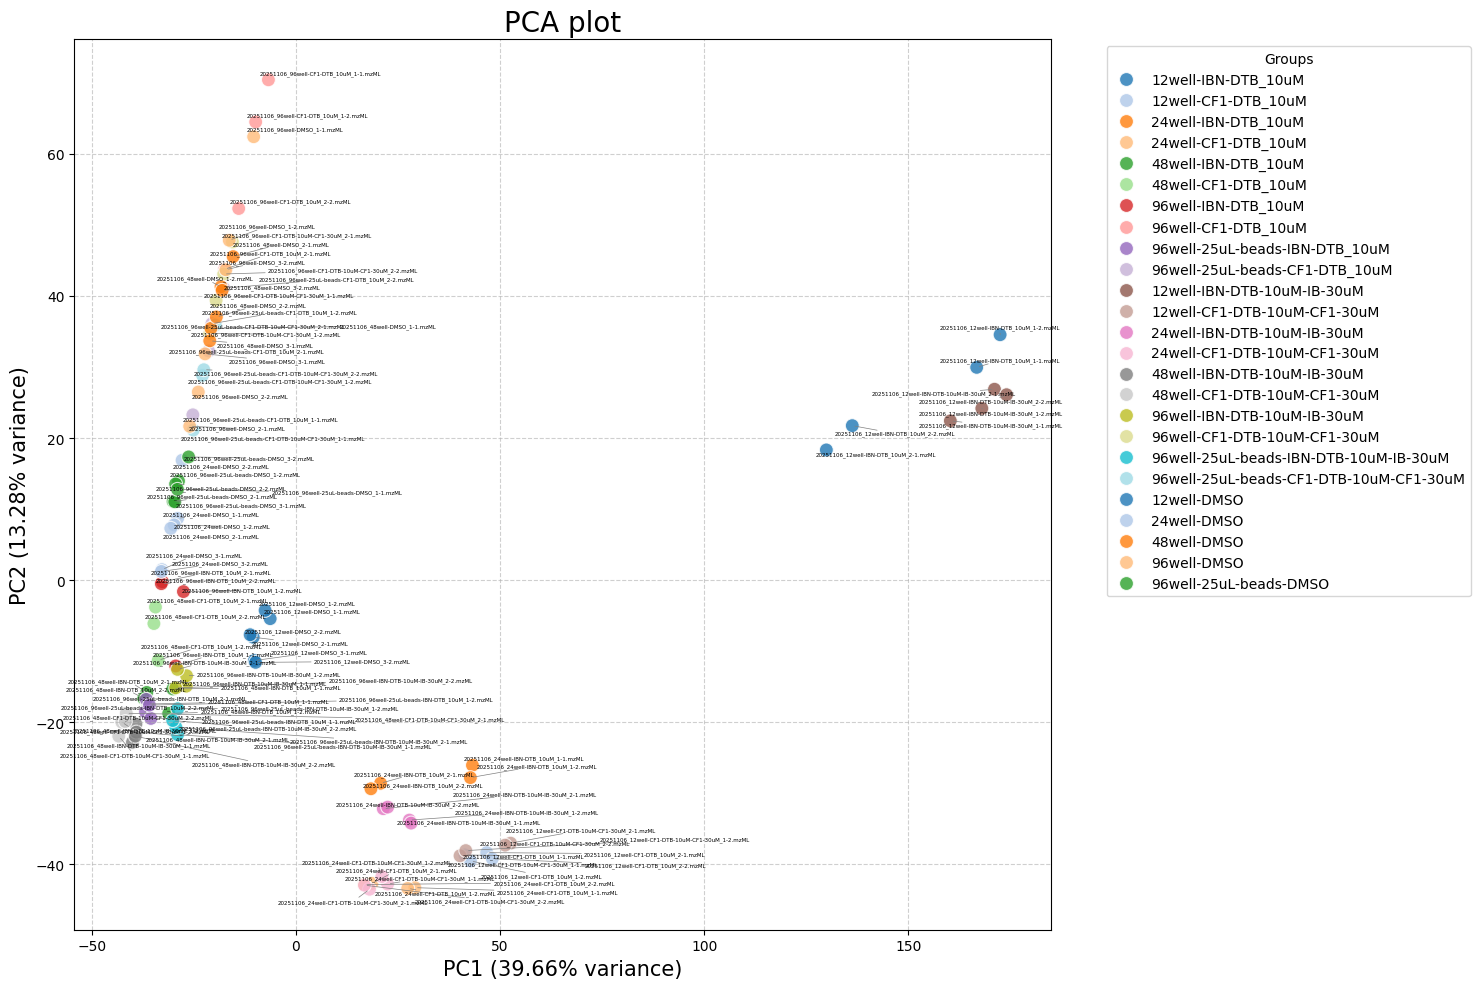

In [134]:
# PCA Plot
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

def generate_pca_plot(df, group_columns, filename="PCA_plot.png", title="PCA of Samples", text=False):
    """
    Generates and saves a PCA plot for the given data frame and group assignments.

    Args:
        df (pd.DataFrame): DataFrame with proteins as rows and samples as columns.
        group_columns (dict): Dictionary mapping group names to lists of column names.
        filename (str): The name of the file to save the plot.
        title (str): The title of the plot.
    """
    # Select only the sample data columns for PCA
    all_sample_columns = [col for sublist in group_columns.values() for col in sublist]
    data = df[all_sample_columns].copy()

    empty_samples = [col for col in data.columns if data[col].isnull().all()]
    if empty_samples:
        for sample in empty_samples:
            # Set a warning for the user
            print(f"Warning: Sample '{sample}' contains all NaN values and will be dropped from the PCA.")
        data.drop(columns=empty_samples, inplace=True)
    # PCA requires no missing values. We fill NaN with the mean of the protein (row).
    data_imputed = data.fillna(data.mean())

    # Transpose the data so that samples are rows and proteins are columns
    data_transposed = data_imputed.T

    # Standardize the data before performing PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_transposed)

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data_scaled)

    # Create a DataFrame with the principal components and group information
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=data_transposed.index)

    # Map sample names to group names
    sample_to_group = {sample: group for group, samples in group_columns.items() for sample in samples}
    pca_df['group'] = pca_df.index.map(sample_to_group)

    # Create the plot
    plt.figure(figsize=(15, 10))
    sns.scatterplot(
        x='PC1',
        y='PC2',
        hue='group',
        palette="tab20",
        data=pca_df,
        s=100,
        alpha=0.8
    )
    if text:
        texts = [plt.text(row['PC1'], row['PC2'], i.split('/')[-1], fontsize=4) for i, row in pca_df.iterrows()]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))


    # Add labels and title
    plt.title(title, fontsize=20)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=15)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=15)
    plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(filename, dpi=300)
    plt.show()

# Generate the PCA plot
generate_pca_plot(df, group_columns, filename="PCA_plot.png", title="PCA plot",text=True)

In [135]:
# Perform control group clean-up by removing proteins which cannot be constantly detected
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Set logging level to INFO
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

if MODE==0 and not comparison_matrix:
    control_group = group_columns[reference_group]
    
    before_clean_up_number = str(df.shape)
    for protein in df.index:
        control_values = df.loc[protein, control_group]
        if control_values.isna().sum() >= len(control_group) * (1-control_group_detection_threshold):
            # Discard this protein
            df.drop(index=protein, inplace=True)
            #logger.info(f"Protein {protein} discarded due to missing values in control group.")
    
    print("protein before control group clean-up: "+before_clean_up_number)
    print("protein after control group clean-up: "+str(df.shape))

if MODE==1 and not comparison_matrix:
    # All the treatment groups will be reference group.
    print("Control group clean-up will not be performed in mode 1.")


In [136]:
# Helper functions for imputation, normalization, and FC calculation
from scipy.stats import truncnorm

def _check_peptide_significance(protein, df_peptide, treated_group, control_group):
    """
    Performs a peptide-level t-test for a single protein to decide if imputation is warranted.
    This helper function contains the logic that is difficult to vectorize fully.

    Args:
        protein (str): The name of the protein to check.
        df_peptide (pd.DataFrame): DataFrame containing peptide-level data.
        treated_group (list): List of column names for the treated group.
        control_group (list): List of column names for the control group.

    Returns:
        bool: True if the protein's missing values should be imputed based on peptide data.
    """
    try:
        protein_peptides = df_peptide.loc[protein]
        # Ensure protein_peptides is a DataFrame
        if isinstance(protein_peptides, pd.Series):
            protein_peptides = protein_peptides.to_frame().T

        # Create a copy to avoid SettingWithCopyWarning and ensure data is numeric.
        protein_peptides = protein_peptides.copy()
        # Coerce data to numeric type, turning any non-numeric values into NaN.
        for col in treated_group + control_group:
            if col in protein_peptides.columns:
                protein_peptides[col] = pd.to_numeric(protein_peptides[col], errors='coerce')

        # Check if there is any data at all in the treated group for this protein's peptides
        if protein_peptides[treated_group].isna().all().all():
            logging.info(f"Protein {protein}: No peptide data in treated group. Imputing.")
            return True

        # Calculate p-values and fold changes for each peptide
        p_values = []
        fold_changes = []
        for i in range(len(protein_peptides)):
            peptide_row = protein_peptides.iloc[i]
            
            # Explicitly cast to float right before the test to prevent dtype errors.
            treated_vals = peptide_row[treated_group].dropna().astype(float)
            control_vals = peptide_row[control_group].dropna().astype(float)

            # Calculate fold change if possible
            if not treated_vals.empty and not control_vals.empty and control_vals.mean() != 0:
                fold_changes.append(treated_vals.mean() / control_vals.mean())
            else:
                fold_changes.append(np.nan)

            # Perform t-test if possible
            if len(treated_vals) > 1 and len(control_vals) > 1:
                p_values.append(ttest_ind(treated_vals, control_vals, equal_var=True, nan_policy='omit').pvalue)
            else:
                p_values.append(np.nan)
        
        p_values = np.array(p_values)
        fold_changes = np.array(fold_changes)

        # Condition 1: Median p-value is significant
        if not np.isnan(p_values).all():
            significant_p = np.nanmedian(p_values) < 0.05
        else:
            significant_p = False
        # Condition 2: All p-values are NaN, but at least one fold change could be calculated
        # This handles cases where t-tests fail (e.g., n=1) but there's still evidence of presence.
        failed_ttest_with_fc = np.isnan(p_values).all() and not np.isnan(fold_changes).all()

        if significant_p or failed_ttest_with_fc:
            if np.isnan(p_values).all():
                logging.info(f"Protein {protein}: Imputing based on peptide data with failed t-tests but fold changes present.")
            else:
                logging.info(f"Protein {protein}: Imputing based on significant peptide data (p-median: {np.nanmedian(p_values):.4f}).")

            return True
        else:
            #logging.info(f"Protein {protein}: Skipping imputation, peptide data not significant.")
            return False

    except KeyError:
        # This protein is not in the peptide dataframe
        logging.info(f"Protein {protein} not found in peptide data. Cannot perform peptide-level check.")
        return False


def imputation(df, treated_group_name, control_group_name, df_peptide=df_peptide, peptide_count_cutoff=3, mode=MODE):
    """
    Performs data imputation on a proteomics dataset using vectorized operations.

    Args:
        df (pd.DataFrame): The main protein abundance DataFrame. Index should be protein names.
        df_peptide (pd.DataFrame): DataFrame with peptide-level data. Index should be protein names.
        group_columns (dict): Dictionary mapping group names to lists of column names.
        treated_group_name (str): The key for the treated group in group_columns.
        control_group_name (str): The key for the control group in group_columns.
        peptide_count_cutoff (int): The minimum number of peptides required for certain imputations.
        mode (int): The imputation mode. 0 for degradation (impute treated), 1 for enrichment (impute control).

    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The imputed DataFrame.
            - list: A list of proteins that were imputed under the high-missing-value condition.
    """
    # --- 1. SETUP AND INITIAL CALCULATIONS ---
    control_group = group_columns[control_group_name]
    treated_group = group_columns[treated_group_name]
    
    df_imputed = df.copy()
    imputation_list = []

    all_cols = control_group + treated_group
    for col in all_cols:
        if col in df_imputed.columns:
            df_imputed[col] = pd.to_numeric(df_imputed[col], errors='coerce')

    # Use the 1st percentile of the entire dataset for low-level imputation, as it's a more stable baseline
    low_1_percentile = np.nanpercentile(df_imputed[all_cols].values.flatten(), 1)
    peptide_counts = df_peptide.index.value_counts()
    
    logging.info(f"Global low 1st percentile: {low_1_percentile:.4f}")
    if mode == 0:
        logging.info("Running in Mode 0: Degradation Protocol")
    else:
        logging.info("Running in Mode 1: Enrichment Protocol")

    # --- 2. PRE-FILTERING ---
    filter_group = control_group if mode == 0 else treated_group
    filter_nan_frac = df_imputed[filter_group].isna().sum(axis=1) / len(filter_group)
    proteins_to_drop_mask = filter_nan_frac >= 0.5
    if proteins_to_drop_mask.any():
        logging.info(f"Dropping {proteins_to_drop_mask.sum()} proteins with >=50% missing values in the {filter_group} group.")
        df_imputed = df_imputed[~proteins_to_drop_mask]

    # --- 3. LOGICAL SEPARATION OF PROTEINS FOR IMPUTATION ---
    control_nan_frac = df_imputed[control_group].isna().sum(axis=1) / len(control_group)
    treated_nan_frac = df_imputed[treated_group].isna().sum(axis=1) / len(treated_group)
    
    target_nan_frac = treated_nan_frac if mode == 0 else control_nan_frac
    
    # Identify proteins for the special high-missing value protocol
    special_imputation_mask = target_nan_frac >= 0.5
    special_imputation_idx = df_imputed.index[special_imputation_mask]

    # Identify proteins for the standard protocol (all others)
    standard_imputation_mask = ~special_imputation_mask
    standard_imputation_idx = df_imputed.index[standard_imputation_mask]

    # --- 4. STANDARD IMPUTATION on proteins with <50% missing values ---
    if not standard_imputation_idx.empty:
        logging.info(f"Performing standard imputation on {len(standard_imputation_idx)} proteins.")
        # Impute control group NaNs
        means = df_imputed.loc[standard_imputation_idx, control_group].mean(axis=1).fillna(0)
        stds = df_imputed.loc[standard_imputation_idx, control_group].std(axis=1).clip(lower=1e-6).fillna(1e-6)
        for col in control_group:
            nan_mask = df_imputed.loc[standard_imputation_idx, col].isna()
            if nan_mask.any():
                df_imputed.loc[nan_mask.index[nan_mask], col] = truncnorm.rvs(
                    a=(0 - means[nan_mask]) / stds[nan_mask], b=np.inf,
                    loc=means[nan_mask], scale=stds[nan_mask], size=nan_mask.sum())
        
        # Impute treated group NaNs
        means = df_imputed.loc[standard_imputation_idx, treated_group].mean(axis=1).fillna(0)
        stds = df_imputed.loc[standard_imputation_idx, treated_group].std(axis=1).clip(lower=1e-6).fillna(1e-6)
        for col in treated_group:
            nan_mask = df_imputed.loc[standard_imputation_idx, col].isna()
            if nan_mask.any():
                df_imputed.loc[nan_mask.index[nan_mask], col] = truncnorm.rvs(
                    a=(0 - means[nan_mask]) / stds[nan_mask], b=np.inf,
                    loc=means[nan_mask], scale=stds[nan_mask], size=nan_mask.sum())

    # --- 5. SPECIAL IMPUTATION on proteins with >=50% missing values ---
    if not special_imputation_idx.empty:
        #logging.info(f"Performing special imputation on {len(special_imputation_idx)} proteins.")
        target_group = treated_group if mode == 0 else control_group
        
        protein_peptide_counts = peptide_counts.reindex(special_imputation_idx).fillna(0)
        has_enough_peptides = protein_peptide_counts > peptide_count_cutoff
        
        proteins_to_check_idx = special_imputation_idx[has_enough_peptides]
        if not proteins_to_check_idx.empty:
            impute_decision = proteins_to_check_idx.to_series().apply(
                _check_peptide_significance, args=(df_peptide, treated_group, control_group))
            proteins_to_impute_idx = impute_decision.index[impute_decision]

            if not proteins_to_impute_idx.empty:
                imputation_list.extend(proteins_to_impute_idx.tolist())
                nan_frac_subset = target_nan_frac.loc[proteins_to_impute_idx]
                
                # Case 1: All values are missing. Overwrite with low-level uniform data.
                all_missing_mask = nan_frac_subset == 1.0
                proteins_all_missing_idx = nan_frac_subset[all_missing_mask].index
                if not proteins_all_missing_idx.empty:
                    imputed_data = np.random.uniform(low=low_1_percentile * 0.5, high=low_1_percentile * 1.5,
                                                     size=(len(proteins_all_missing_idx), len(target_group)))
                    df_imputed.loc[proteins_all_missing_idx, target_group] = imputed_data

                # Case 2: Partially missing. Impute ONLY the NaNs based on existing data for that protein.
                partial_missing_mask = nan_frac_subset < 1.0
                proteins_partial_missing_idx = nan_frac_subset[partial_missing_mask].index
                if not proteins_partial_missing_idx.empty:
                    means = df_imputed.loc[proteins_partial_missing_idx, target_group].mean(axis=1).fillna(0)
                    stds = df_imputed.loc[proteins_partial_missing_idx, target_group].std(axis=1).clip(lower=1e-6).fillna(1e-6)
                    
                    for col in target_group:
                        nan_mask = df_imputed.loc[proteins_partial_missing_idx, col].isna()
                        if nan_mask.any():
                            df_imputed.loc[nan_mask.index[nan_mask], col] = truncnorm.rvs(
                                a=(0 - means[nan_mask]) / stds[nan_mask], b=np.inf,
                                loc=means[nan_mask], scale=stds[nan_mask], size=nan_mask.sum())
                            
    logging.info(f"Imputation completed. {len(imputation_list)} proteins imputed via special high-missing-value protocol.")
    return df_imputed, imputation_list

def normalize_by_specific_protein(df, uniprot_id, scaling_factor=100000000):
    """
    Normalizes the intensities of all proteins in the DataFrame based on the 
    intensity of a specific reference protein (e.g., a housekeeping protein).
    
    Formula: Normalized_Intensity = (Target_Protein_Intensity / Reference_Protein_Intensity) * scaling_factor

    Args:
        df (pd.DataFrame): Imputed DataFrame (rows=proteins, cols=samples).
        uniprot_id (str): The UniProt ID of the reference protein.
        scaling_factor (float): Optional multiplier to keep values in a readable range 
                                (e.g., 1e6 or the mean of the reference). Default is 1.0.

    Returns:
        pd.DataFrame: A new DataFrame with normalized intensities.
    """
    df_normalized = df.copy()

    # 1. Check if the reference protein exists
    if uniprot_id not in df.index:
        logging.warning(f"Normalization skipped: Reference protein '{uniprot_id}' not found in dataset index.")
        return df_normalized

    # 2. Extract reference protein intensity (only for experimental columns)
    all_experimental_cols = [col for group in group_columns.values() for col in group]
    ref_intensities_exp = df.loc[uniprot_id].reindex(all_experimental_cols)
    
    # 3. Identify valid and invalid samples for normalization
    valid_cols = ref_intensities_exp.dropna().index.tolist()
    invalid_cols = ref_intensities_exp[ref_intensities_exp.isna()].index.tolist()

    # 4. Perform Normalization on Valid Columns
    if valid_cols:
        # Extract the subset of the dataframe and the reference intensities for valid columns
        df_valid = df[valid_cols].copy()
        ref_valid = ref_intensities_exp.loc[valid_cols]

        # Debugging: Check for zero values
        zero_count = (ref_valid == 0).sum()
        if zero_count > 0:
             logging.warning(f"Normalization issue: Reference protein '{uniprot_id}' has {zero_count} zero values in valid samples (will result in Inf/NaN).")

        # Perform normalization: division by reference, multiplied by scaling factor
        df_valid_normalized = df_valid.div(ref_valid, axis=1) * scaling_factor
        
        # Overwrite the original columns in the copy with the normalized values
        df_normalized[valid_cols] = df_valid_normalized[valid_cols]
        
        logging.info(f"Normalization performed on {len(valid_cols)} samples using reference protein: {uniprot_id}.")

    # 5. Copy Original Values for Invalid Columns
    if invalid_cols:
        # Values in invalid_cols are copied as they were (unnormalized, potentially imputed/raw)
        df_normalized[invalid_cols] = df[invalid_cols]
        logging.info(f"Skipped normalization for {len(invalid_cols)} samples due to NaN in reference protein.")
        
    # 6. Final Debugging
    if uniprot_id in df_normalized.index:
        mean_normalized_intensity = float(df_normalized[valid_cols].mean().mean())
        logging.info(f"Post-normalization mean intensity on valid samples: {mean_normalized_intensity:.4f}")
    return df_normalized

# Calculate FC value and append to the right side
def calculate_average_FC_value(df, treated_group_name, control_group_name):
    control_group = group_columns[control_group_name]
    treated_group = group_columns[treated_group_name]
    
    control_avg = df[control_group].mean(axis=1)
    treated_avg = df[treated_group].mean(axis=1)
    
    FC_values = treated_avg / control_avg
    FC_column_name = f'FC_{treated_group_name}_vs_{control_group_name}'
    df[FC_column_name] = FC_values
    
    log2FC_values = np.log2(FC_values.astype('float64'))
    
    log2FC_column_name = f'log2FC_{treated_group_name}_vs_{control_group_name}'
    df[log2FC_column_name] = log2FC_values
    
    return df


In [137]:
# Data processing workflow (Imputation and Normalization)
# 1. Preserve the original, unaltered DataFrame.
df_original = df.copy()

# 2. Create storage for all results.
imputation_dict = {}
imputed_dataframes = {} 
df_final_results = df_original.copy() # This will store the final summary with all FC columns.

# 3. Determine the list of comparisons to perform.
if not comparison_matrix:
    comparisons = [(key, reference_group) for key in group_columns if key != reference_group]
else:
    comparisons = comparison_matrix

# 4. Loop through each independent comparison.
for pair in comparisons:
    treated_name, control_name = pair[0], pair[1]
    comparison_name = f"{treated_name}_vs_{control_name}"
    logger.info("Processing comparison: " + comparison_name)
    # Default to the original data if imputation is turned off.
    df_imputed_for_comparison = df_original.copy()

    if imputation_option:
        # A. Run imputation on the clean, original data.
        # This uses your exact calling signature.
        df_imputed_for_comparison, imputation_list = imputation(
            df_original, 
            treated_name, 
            control_name,
            mode=MODE
        )
        
        # B. Store the clean, raw imputed DataFrame and the list of imputed proteins.
        imputation_dict[comparison_name] = imputation_list
        imputed_dataframes[comparison_name] = df_imputed_for_comparison
    else:
        logger.info("Imputation not enabled")
        imputed_dataframes[comparison_name] = df_original

    if NORMALIZATION_PROTEIN_ID:
        # We apply normalization to the imputed dataframe
        logger.info(f"Normalizing data for comparison '{comparison_name}' using protein '{NORMALIZATION_PROTEIN_ID}'...")
        df_imputed_for_comparison = normalize_by_specific_protein(
            df_imputed_for_comparison, 
            NORMALIZATION_PROTEIN_ID
        )
        imputed_dataframes[comparison_name] = df_imputed_for_comparison
        df_imputed_for_comparison.to_csv(f"Normalized_imputed_data_{comparison_name}.tsv", sep="\t")

    else:
        logger.info("Normalization not enabled")

    # C. Calculate FC values on a COPY of the imputed data to avoid contamination.
    df_with_fc = calculate_average_FC_value(df_imputed_for_comparison.copy(), treated_name, control_name)

    # D. Extract ONLY the new FC columns and add them to the final summary table.
    fc_col = f'FC_{comparison_name}'
    log2fc_col = f'log2FC_{comparison_name}'
    if fc_col in df_with_fc:
        df_final_results[fc_col] = df_with_fc[fc_col]
        df_final_results[log2fc_col] = df_with_fc[log2fc_col]

# --- Saving Logic ---

# 5. Save all results to a multi-sheet Excel file.
if imputation_option:
    if NORMALIZATION_PROTEIN_ID:
        output_excel_path = "FC_results_imputation_and_normalization.xlsx"
    else:
        output_excel_path = "FC_results_imputation.xlsx"
else:
    if NORMALIZATION_PROTEIN_ID:
        output_excel_path = "FC_results_normalization.xlsx"
    else:
        output_excel_path = "FC_results.xlsx"

# Identify metadata columns (columns that are not part of any experimental group).
all_experimental_cols = [col for group in group_columns.values() for col in group]
metadata_cols = [col for col in df_original.columns if col not in all_experimental_cols]

logger.info(f"Saving results to {output_excel_path}...")
with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    # Sheet 1: The summary of fold changes (without the index column).
    df_final_results.to_excel(writer, sheet_name='Fold_Change_Summary', index=False)
    
    # Subsequent sheets: The raw imputed data for each comparison.
    for comparison_name, imputed_df in imputed_dataframes.items():
        treated_name, control_name = comparison_name.split('_vs_')
        fc_col = f'FC_{comparison_name}'
        log2fc_col = f'log2FC_{comparison_name}'
        control_cols = sorted(group_columns[control_name])
        treated_cols = sorted(group_columns[treated_name])
        
        # Define the exact columns to save: metadata + relevant raw data.
        cols_to_save = metadata_cols + control_cols + treated_cols + [fc_col, log2fc_col]
        
        # Create a clean subset guaranteed not to have any FC columns.
        df_subset = df_final_results[cols_to_save]
        
        # Truncate sheet name to Excel's 31-character limit.
        sheet_name = comparison_name[:31]
        
        # Save the clean subset to the new sheet (without the index column).
        df_subset.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All results saved to {output_excel_path}")

# 6. Final print output.
print("\nSummary of imputed proteins per comparison:")
for key, value in imputation_dict.items():
    print(f"{key}: {len(value)} proteins imputed")

2025-11-18 18:35:28,913 - INFO - Processing comparison: 12well-IBN-DTB_10uM_vs_12well-IBN-DTB-10uM-IB-30uM
2025-11-18 18:35:28,927 - INFO - Global low 1st percentile: 7014.2351
2025-11-18 18:35:28,928 - INFO - Running in Mode 1: Enrichment Protocol
2025-11-18 18:35:28,931 - INFO - Dropping 1953 proteins with >=50% missing values in the ['/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_1-1.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_1-2.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_2-1.mzML', '/data/samba/shared/JingjingChen/data/Proteomics/covalent pulldown positive/MZML/20251106_12well-IBN-DTB_10uM_2-2.mzML'] group.
2025-11-18 18:35:28,936 - INFO - Performing standard imputation on 4687 proteins.
2025-11-18 18:35:28,989 - INFO - Protein O94913: Imputing based on significant peptide d

All results saved to FC_results_imputation_and_normalization.xlsx

Summary of imputed proteins per comparison:
12well-IBN-DTB_10uM_vs_12well-IBN-DTB-10uM-IB-30uM: 12 proteins imputed
12well-CF1-DTB_10uM_vs_12well-CF1-DTB-10uM-CF1-30uM: 23 proteins imputed
24well-IBN-DTB_10uM_vs_24well-IBN-DTB-10uM-IB-30uM: 114 proteins imputed
24well-CF1-DTB_10uM_vs_24well-CF1-DTB-10uM-CF1-30uM: 17 proteins imputed
48well-IBN-DTB_10uM_vs_48well-IBN-DTB-10uM-IB-30uM: 195 proteins imputed
48well-CF1-DTB_10uM_vs_48well-CF1-DTB-10uM-CF1-30uM: 695 proteins imputed
96well-IBN-DTB_10uM_vs_96well-IBN-DTB-10uM-IB-30uM: 20 proteins imputed
96well-CF1-DTB_10uM_vs_96well-CF1-DTB-10uM-CF1-30uM: 29 proteins imputed
96well-25uL-beads-IBN-DTB_10uM_vs_96well-25uL-beads-IBN-DTB-10uM-IB-30uM: 33 proteins imputed
96well-25uL-beads-CF1-DTB_10uM_vs_96well-25uL-beads-CF1-DTB-10uM-CF1-30uM: 38 proteins imputed
12well-IBN-DTB-10uM-IB-30uM_vs_12well-DMSO: 839 proteins imputed
12well-CF1-DTB-10uM-CF1-30uM_vs_12well-DMSO: 996 pro

In [138]:
# Function to perform a student t-test
def student_t_test(row, treated_group_name, control_group_name,min_valid_value=3): # valid value = Not NaN
    treated_values = pd.to_numeric(row[group_columns[treated_group_name]], errors='coerce').dropna().values
    control_values = pd.to_numeric(row[group_columns[control_group_name]], errors='coerce').dropna().values
    
    if not imputation_option:
        if len(treated_values) <min_valid_value or len(control_values) <min_valid_value:
            return np.nan
    
    return ttest_ind(treated_values, control_values, equal_var=True).pvalue

# Apply Benjamini-Hochberg FDR correction, handling NaN values
def apply_bh_fdr(p_values):
    mask = np.isfinite(p_values)
    p_values_corrected = np.full(p_values.shape, np.nan)
    p_values_corrected[mask] = multipletests(p_values[mask], method='fdr_bh')[1]
    return p_values_corrected

if not limma_option:
    print("Running Student's t-test for each comparison...")
    
    # 1. Loop through the dictionary containing the clean, imputed DataFrame for each comparison.
    for comparison_name, imputed_df in imputed_dataframes.items():
        
        # 2. Extract the treated and control names from the dictionary key.
        treated_name, control_name = comparison_name.split('_vs_')
        
        # 3. Apply the t-test to the correct, isolated DataFrame for this comparison.
        pvalue_column_name = f'Pvalue_{comparison_name}'
        p_values = imputed_df.apply(
            student_t_test,
            axis=1,
            treated_group_name=treated_name,
            control_group_name=control_name
        )
        
        # 4. Apply the Benjamini-Hochberg correction.
        bhFDR_column_name = f'bh_FDR_{comparison_name}'
        fdr_values = apply_bh_fdr(p_values)
        
        # 5. Merge ONLY the new result columns into your final summary DataFrame.
        df_final_results[pvalue_column_name] = p_values
        df_final_results[bhFDR_column_name] = fdr_values

    print("T-test analysis complete.")
    
else:
    print("Skipping Student's t-test because limma_option is enabled.")

# Now, df_final_results contains the metadata, fold changes, and t-test statistics.
# You can save this final, complete summary table.
df_final_results.to_csv("final_analysis_summary_with_ttest.csv", index=False)


Skipping Student's t-test because limma_option is enabled.


In [139]:
if limma_option:
    import numpy as np
    import pandas as pd
    from rpy2.robjects import pandas2ri, r
    import rpy2.robjects as robjects
    import os
    #os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.4.2"
    #os.environ["R_USER"] = "C:\\Program Files\\R\\R-4.4.2\\library"

    # Activate automatic DataFrame conversion between pandas and R
    pandas2ri.activate()
    r('library(limma)')

    # Define function to run limma
    def limma_differential_analysis(df, treated_group_name, control_group_name, min_valid_value=3):
        # Extract relevant sample columns
        treated_samples = group_columns[treated_group_name]
        control_samples = group_columns[control_group_name]
        selected_columns = treated_samples + control_samples

        # Filter out rows with insufficient valid values
        valid_rows = df.dropna(thresh=min_valid_value, subset=selected_columns)

        # Convert group names to valid R variable names
        treated_group_r = r('make.names')(treated_group_name)[0]
        control_group_r = r('make.names')(control_group_name)[0]

        # Construct the design matrix in R
        sample_info = [treated_group_r] * len(treated_samples) + [control_group_r] * len(control_samples)
        sample_info_r = robjects.StrVector(sample_info)
        r.assign("sample_info", sample_info_r)
        r("design_matrix <- model.matrix(~ 0 + factor(sample_info))")
        r("colnames(design_matrix) <- levels(factor(sample_info))")

        # Convert DataFrame to R object
        df_r = pandas2ri.py2rpy(valid_rows[selected_columns].astype(float))
        r.assign("expression_data", df_r)

        # Fit limma model
        r("fit <- lmFit(expression_data, design_matrix)")
        r("fit <- eBayes(fit)")

        # Fix: Ensure contrast formula is a valid R expression
        contrast_str = f'"{treated_group_r} - {control_group_r}"'
        r(f"contrast_matrix <- makeContrasts({contrast_str}, levels=design_matrix)")
        r("fit2 <- contrasts.fit(fit, contrast_matrix)")
        r("fit2 <- eBayes(fit2)")
        r("limma_results <- topTable(fit2, adjust='BH', number=Inf, sort.by='none')")
        
        # Convert results back to pandas
        pvalues_df = pandas2ri.rpy2py(r('limma_results'))
        # Rename columns to be specific to this comparison and return ONLY the new results
        pvalue_column_name = f'bh_FDR_{treated_group_name}_vs_{control_group_name}'
        log10pvalue_column_name = f'-log_P_adj_{treated_group_name}_vs_{control_group_name}'

        if output_adjPval:
            pvalues_df = pvalues_df.rename(columns={'adj.P.Val': pvalue_column_name})
        else:
            pvalues_df = pvalues_df.rename(columns={'P.Value': pvalue_column_name})
        pvalues_df[log10pvalue_column_name] = -np.log10(pvalues_df[pvalue_column_name])
        # Return only the columns we need, with the correct index
        return pvalues_df[[pvalue_column_name, log10pvalue_column_name]]


    # 1. Loop through the dictionary containing the clean, imputed DataFrame for each comparison.
    for comparison_name, imputed_df in imputed_dataframes.items():

        print(f"Running Limma for: {comparison_name}...")

        # 2. Extract the treated and control names from the dictionary key.
        treated_name, control_name = comparison_name.split('_vs_')

        # 3. Run the Limma analysis on the correct, isolated DataFrame.
        # The output is a small DataFrame with just the new p-value columns.
        limma_results_df = limma_differential_analysis(imputed_df, treated_name, control_name)

        # 4. Merge ONLY the new result columns into your final summary DataFrame.
        # 'how="left"' ensures all original proteins are kept.
        if not limma_results_df.empty:
            df_final_results = df_final_results.merge(limma_results_df, left_index=True, right_index=True, how="left")

    # Now, df_final_results contains the metadata, fold changes, AND all Limma statistics.
    # You can save this final, complete summary table again if you wish.
    # For example, you can overwrite the summary sheet in your Excel file.

    df_final_results.to_csv("final_analysis_summary_with_limma.csv", index=False)
    print("\nLimma analysis complete. Final summary has been updated.") 

    df = df_final_results.copy()

else:
    print("limma_option not enabled")


Running Limma for: 12well-IBN-DTB_10uM_vs_12well-IBN-DTB-10uM-IB-30uM...


2025-11-18 18:44:56,904 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:56,904 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:56,904 - WARNING - R[write to console]: Partial NA coefficients for 10 probe(s) 



Running Limma for: 12well-CF1-DTB_10uM_vs_12well-CF1-DTB-10uM-CF1-30uM...


2025-11-18 18:44:57,234 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:57,234 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:57,234 - WARNING - R[write to console]: Partial NA coefficients for 34 probe(s) 



Running Limma for: 24well-IBN-DTB_10uM_vs_24well-IBN-DTB-10uM-IB-30uM...


2025-11-18 18:44:57,533 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:57,533 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:57,533 - WARNING - R[write to console]: Partial NA coefficients for 84 probe(s) 



Running Limma for: 24well-CF1-DTB_10uM_vs_24well-CF1-DTB-10uM-CF1-30uM...


2025-11-18 18:44:57,853 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:57,855 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:57,855 - WARNING - R[write to console]: Partial NA coefficients for 21 probe(s) 

2025-11-18 18:44:58,050 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:58,050 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:58,052 - WARNING - R[write to console]: Partial NA coefficients for 60 probe(s) 



Running Limma for: 48well-IBN-DTB_10uM_vs_48well-IBN-DTB-10uM-IB-30uM...
Running Limma for: 48well-CF1-DTB_10uM_vs_48well-CF1-DTB-10uM-CF1-30uM...


2025-11-18 18:44:58,215 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:58,215 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:58,215 - WARNING - R[write to console]: Partial NA coefficients for 166 probe(s) 

2025-11-18 18:44:58,384 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:58,384 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:58,384 - WARNING - R[write to console]: Partial NA coefficients for 5 probe(s) 

2025-11-18 18:44:58,473 - WARNING - R[write to console]: In addition: 


Running Limma for: 96well-IBN-DTB_10uM_vs_96well-IBN-DTB-10uM-IB-30uM...
Running Limma for: 96well-CF1-DTB_10uM_vs_96well-CF1-DTB-10uM-CF1-30uM...


2025-11-18 18:44:58,473 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:58,473 - WARNING - R[write to console]: Partial NA coefficients for 14 probe(s) 

2025-11-18 18:44:58,633 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:58,633 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:58,637 - WARNING - R[write to console]: Partial NA coefficients for 2 probe(s) 



Running Limma for: 96well-25uL-beads-IBN-DTB_10uM_vs_96well-25uL-beads-IBN-DTB-10uM-IB-30uM...
Running Limma for: 96well-25uL-beads-CF1-DTB_10uM_vs_96well-25uL-beads-CF1-DTB-10uM-CF1-30uM...


2025-11-18 18:44:58,715 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:58,715 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:58,715 - WARNING - R[write to console]: Partial NA coefficients for 14 probe(s) 



Running Limma for: 12well-IBN-DTB-10uM-IB-30uM_vs_12well-DMSO...


2025-11-18 18:44:59,003 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:59,008 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:59,008 - WARNING - R[write to console]: Partial NA coefficients for 559 probe(s) 



Running Limma for: 12well-CF1-DTB-10uM-CF1-30uM_vs_12well-DMSO...


2025-11-18 18:44:59,368 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:59,368 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:59,368 - WARNING - R[write to console]: Partial NA coefficients for 674 probe(s) 



Running Limma for: 24well-IBN-DTB-10uM-IB-30uM_vs_24well-DMSO...


2025-11-18 18:44:59,696 - WARNING - R[write to console]: In addition: 
2025-11-18 18:44:59,696 - WARNING - R[write to console]: Warning message:

2025-11-18 18:44:59,696 - WARNING - R[write to console]: Partial NA coefficients for 1431 probe(s) 



Running Limma for: 24well-CF1-DTB-10uM-CF1-30uM_vs_24well-DMSO...


2025-11-18 18:45:00,034 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,034 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,034 - WARNING - R[write to console]: Partial NA coefficients for 1988 probe(s) 

2025-11-18 18:45:00,236 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,243 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,243 - WARNING - R[write to console]: Partial NA coefficients for 864 probe(s) 



Running Limma for: 48well-IBN-DTB-10uM-IB-30uM_vs_48well-DMSO...
Running Limma for: 48well-CF1-DTB-10uM-CF1-30uM_vs_48well-DMSO...


2025-11-18 18:45:00,353 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,353 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,353 - WARNING - R[write to console]: Partial NA coefficients for 230 probe(s) 

2025-11-18 18:45:00,568 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,568 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,569 - WARNING - R[write to console]: Partial NA coefficients for 1434 probe(s) 



Running Limma for: 96well-IBN-DTB-10uM-IB-30uM_vs_96well-DMSO...


2025-11-18 18:45:00,669 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,673 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,673 - WARNING - R[write to console]: Partial NA coefficients for 6 probe(s) 



Running Limma for: 96well-CF1-DTB-10uM-CF1-30uM_vs_96well-DMSO...
Running Limma for: 96well-25uL-beads-IBN-DTB-10uM-IB-30uM_vs_96well-25uL-beads-DMSO...


2025-11-18 18:45:00,869 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,874 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,875 - WARNING - R[write to console]: Partial NA coefficients for 1828 probe(s) 

2025-11-18 18:45:00,963 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:00,963 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:00,963 - WARNING - R[write to console]: Partial NA coefficients for 6 probe(s) 



Running Limma for: 96well-25uL-beads-CF1-DTB-10uM-CF1-30uM_vs_96well-25uL-beads-DMSO...
Running Limma for: 12well-IBN-DTB_10uM_vs_12well-DMSO...


2025-11-18 18:45:01,232 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:01,232 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:01,234 - WARNING - R[write to console]: Partial NA coefficients for 371 probe(s) 



Running Limma for: 12well-CF1-DTB_10uM_vs_12well-DMSO...


2025-11-18 18:45:01,559 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:01,563 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:01,565 - WARNING - R[write to console]: Partial NA coefficients for 703 probe(s) 



Running Limma for: 24well-IBN-DTB_10uM_vs_24well-DMSO...


2025-11-18 18:45:01,896 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:01,898 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:01,898 - WARNING - R[write to console]: Partial NA coefficients for 1404 probe(s) 



Running Limma for: 24well-CF1-DTB_10uM_vs_24well-DMSO...


2025-11-18 18:45:02,213 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:02,213 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:02,213 - WARNING - R[write to console]: Partial NA coefficients for 1971 probe(s) 

2025-11-18 18:45:02,417 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:02,418 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:02,418 - WARNING - R[write to console]: Partial NA coefficients for 1045 probe(s) 



Running Limma for: 48well-IBN-DTB_10uM_vs_48well-DMSO...
Running Limma for: 48well-CF1-DTB_10uM_vs_48well-DMSO...


2025-11-18 18:45:02,593 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:02,599 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:02,600 - WARNING - R[write to console]: Partial NA coefficients for 1008 probe(s) 

2025-11-18 18:45:02,773 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:02,773 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:02,773 - WARNING - R[write to console]: Partial NA coefficients for 905 probe(s) 



Running Limma for: 96well-IBN-DTB_10uM_vs_96well-DMSO...
Running Limma for: 96well-CF1-DTB_10uM_vs_96well-DMSO...


2025-11-18 18:45:02,862 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:02,863 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:02,863 - WARNING - R[write to console]: Partial NA coefficients for 7 probe(s) 

2025-11-18 18:45:03,023 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:03,029 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:03,029 - WARNING - R[write to console]: Partial NA coefficients for 1360 probe(s) 



Running Limma for: 96well-25uL-beads-IBN-DTB_10uM_vs_96well-25uL-beads-DMSO...
Running Limma for: 96well-25uL-beads-CF1-DTB_10uM_vs_96well-25uL-beads-DMSO...


2025-11-18 18:45:03,117 - WARNING - R[write to console]: In addition: 
2025-11-18 18:45:03,117 - WARNING - R[write to console]: Warning message:

2025-11-18 18:45:03,117 - WARNING - R[write to console]: Partial NA coefficients for 3 probe(s) 




Limma analysis complete. Final summary has been updated.


In [140]:
# Volcano Plot
import matplotlib.pylab as plt
import seaborn as sns
from adjustText import adjust_text

import numpy as np
import pandas as pd
 
def empirical_fdr_curve(df, alpha=0.05, kappa=0.01, p_value_cutoff = 1, mode="neg",
                        x_col='log2FC', p_col='pval',
                        x0_grid=None, c_grid=None):
    x = df[x_col].values
    mlogp = -np.log10(df[p_col].values)
 
    if x0_grid is None:
        x0_grid = np.round(np.linspace(0.0, 1.0, 26), 3)    # 0 ~ 1, step 0.04
    if c_grid is None:
        c_grid = np.round(np.linspace(0.5, 8.0, 76), 3)     # 0.5 ~ 8
 
    records = []
    for x0 in x0_grid:
        pos_denom = np.maximum(x - x0, 1e-12)      # Used only when x>=x0 
        neg_denom = np.maximum(-x - x0, 1e-12)     # Used only when x<=-x0 
 
        for c in c_grid:
            pos_mask = (x >= x0) & (mlogp >= c/pos_denom + p_value_cutoff)
            neg_mask = (x <= -x0) & (mlogp >= c/neg_denom + p_value_cutoff)
            npos = int(pos_mask.sum())
            nneg = int(neg_mask.sum())
            if mode == "neg":
                fdr_hat = (npos + kappa) / (nneg + kappa)
                feasible = (nneg > 0) and (fdr_hat <= alpha)
                records.append((x0, c, npos, nneg, fdr_hat, feasible))
            if mode == "pos":
                fdr_hat = (nneg + kappa) / (npos + kappa)
                feasible = (npos > 0) and (fdr_hat <= alpha)
                records.append((x0, c, npos, nneg, fdr_hat, feasible))

    res = pd.DataFrame(records, columns=['x0','c','npos','nneg','FDR','feasible'])
    feas = res[res['feasible']]
    if len(feas)==0:
        best = res.sort_values(['FDR'], ascending=[True]).iloc[0].to_dict()
    else:
        if mode == "neg":
            best = feas.sort_values(['nneg','x0','c'], ascending=[False, True, True]).iloc[0].to_dict()
        if mode == "pos":
            best = feas.sort_values(['npos','x0','c'], ascending=[False, True, True]).iloc[0].to_dict()
    return res, best

def volcano_plot(treatment_group, control_group, 
                 logFC_cutoff=None, logFC_cutoff2=None, FDR_cutoff=0.05, use_empirical_fdr=False, mode=MODE, fdr_alpha=0.05, kappa=1e-6, p_value_cutoff=1, 
                 file_suffix="", highlight_genes=[], protein_level_cutoff=None, 
                 xlim=[], ylim=[], x_interval=2, y_interval=1, 
                 imputation_option=imputation_option, PharosTCRD=PharosTCRD, 
                 highlight_kinase=False, highlight_ub=False, highlight_Gloops=False, highlight_RTloops=False, label_topX_mid_fc=None):
    logFC="log2FC_"+treatment_group+"_vs_"+control_group
    FDR="bh_FDR_"+treatment_group+"_vs_"+control_group
    y_max = df[FDR].apply(lambda x:-np.log10(x)).max()

    plt.figure(figsize=(12, 9))
    plt.scatter(x=df[logFC],y=df[FDR].apply(lambda x:-np.log10(x)),s=40,alpha=0.5, color="grey")

    if logFC_cutoff2:    
        slight_down = df[(df[logFC]<=-logFC_cutoff2)&(df[FDR]<=FDR_cutoff)]
        plt.scatter(x=slight_down[logFC],y=slight_down[FDR].apply(lambda x:-np.log10(x)),s=3,label=">35% Down-regulated",color="blue")
    else:
        slight_down = None

    up, down = pd.DataFrame(), pd.DataFrame()

    if logFC_cutoff and not use_empirical_fdr:
        up = df[(df[logFC]>=logFC_cutoff)&(df[FDR]<=FDR_cutoff)]
        down = df[(df[logFC]<=-logFC_cutoff)&(df[FDR]<=FDR_cutoff)]
        plt.scatter(x=up[logFC],y=up[FDR].apply(lambda x:-np.log10(x)),s=40,alpha=0.5, label="Up-regulated",color="red")
        if not (logFC_cutoff2 or protein_level_cutoff):
            plt.scatter(x=down[logFC],y=down[FDR].apply(lambda x:-np.log10(x)),s=40,alpha=0.5,label="Down-regulated",color="blue")
        plt.axvline(-logFC_cutoff,color="grey",linestyle="--")
        plt.axvline(logFC_cutoff,color="grey",linestyle="--")

    if use_empirical_fdr and mode == 0:
        res, best = empirical_fdr_curve(df, alpha=fdr_alpha, kappa=kappa, p_value_cutoff=p_value_cutoff, mode="neg", x_col=logFC, p_col=FDR)
    if use_empirical_fdr and mode == 1:
        res, best = empirical_fdr_curve(df, alpha=fdr_alpha, kappa=kappa, p_value_cutoff=p_value_cutoff, mode="pos", x_col=logFC, p_col=FDR)
    if use_empirical_fdr and best is not None:
        plt.axvline(0,color="grey",linestyle=":")

        x0, c = best['x0'], best['c']
        # Positive side
        x_pos = np.linspace(x0+1e-6, xlim[1], 200)
        y_pos = c/(x_pos-x0) + p_value_cutoff
        mask_pos = y_pos <= y_max
        plt.plot(x_pos[mask_pos], y_pos[mask_pos], 'k-', lw=0.5)
        # Negative side
        x_neg = np.linspace(xlim[0], -x0-1e-6, 200)
        y_neg = c/(-x_neg-x0) + p_value_cutoff
        mask_neg = y_neg <= y_max
        plt.plot(x_neg[mask_neg], y_neg[mask_neg], 'k-', lw=0.5)
        # Annotate best parameters
        txt = (f"Empirical FDR c/(|x|-x0)+{p_value_cutoff} optimized:\n"
               f"x0={x0:.2f}, c={c:.2f}\n"
               f"FDR={best['FDR']:.3f}, npos={best['npos']}, nneg={best['nneg']}")
        if best['FDR'] > fdr_alpha:
            txt = (f"No feasible solution for empirical FDR < {fdr_alpha} found.\n\n"
                   f"Reporting lowest empirical FDR:\n")+ txt

        plt.text(0.05, 0.95, txt, ha="left", va="top", fontsize=9, transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
        up = df[(df[FDR].apply(lambda x:-np.log10(x))>c/(df[logFC]-x0)+p_value_cutoff) & (df[logFC] > x0)]
        down = df[(df[FDR].apply(lambda x:-np.log10(x))>c/(-df[logFC]-x0)+p_value_cutoff) & (df[logFC] < -x0)]
        plt.scatter(x=up[logFC],y=up[FDR].apply(lambda x:-np.log10(x)),s=40,alpha=0.5, label="Up-regulated",color="red")
        if not (logFC_cutoff2 or protein_level_cutoff):
            plt.scatter(x=down[logFC],y=down[FDR].apply(lambda x:-np.log10(x)),s=40,alpha=0.5,label="Down-regulated",color="blue")
        
    if protein_level_cutoff:
        lowabundance_down=df[(df[logFC]<=-logFC_cutoff) & (df[FDR]<=FDR_cutoff) & (df[group_columns[control_group]].mean(axis=1)<1000)]
        plt.scatter(x=down[logFC],y=down[FDR].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
        plt.scatter(x=lowabundance_down[logFC],y=lowabundance_down[FDR].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated, protein level<"+str(protein_level_cutoff),color="turquoise")

    if highlight_genes:
        # Find which of the requested genes are actually in the DataFrame index
        genes_found = [gene for gene in highlight_genes if gene in df.index and not pd.isna(df.loc[gene, logFC])]
        # Find which genes were not found so you can report them
        genes_not_found = [gene for gene in highlight_genes if gene not in df.index or pd.isna(df.loc[gene, logFC])]
        # If any of the requested genes were not found, log a warning
        if genes_not_found:
            print(f"Could not find the following genes to highlight: {genes_not_found}")
    
        # Proceed to plot only the genes that were actually found
        if genes_found:
            highlight = df.loc[genes_found]
            plt.scatter(x=highlight[logFC], y=highlight[FDR].apply(lambda x:-np.log10(x)), color='green', zorder=5) # zorder makes them plot on top
        else:
            logging.warning("None of the specified highlight genes were found in the data.")
            highlight = None

    if imputation_option:
        if not comparison_matrix:
            imputation_proteins = df.loc[imputation_dict[treatment_group+"_vs_"+reference_group]]
            plt.scatter(x=imputation_proteins[logFC], y=imputation_proteins[FDR].apply(lambda x:-np.log10(x)), s=30, color='orange', label="Imputation from missing value")
        else:
            imputation_proteins = df.loc[imputation_dict[pair[0]+"_vs_"+pair[1]]]
            plt.scatter(x=imputation_proteins[logFC], y=imputation_proteins[FDR].apply(lambda x:-np.log10(x)), s=30, color='orange', label="Imputation from missing value")
    else:
        imputation_proteins = None

    concat_df = pd.concat([up, down, slight_down, highlight]).drop_duplicates()

    if PharosTCRD:
        Tclin_filtered = [item for item in Tclin if item in df.index]
        Tchem_filtered = [item for item in Tchem if item in df.index]
        Tbio_filtered = [item for item in Tbio if item in df.index]
        Tdark_filtered = [item for item in Tdark if item in df.index]
        Tclin_highlight = df.loc[Tclin_filtered]
        Tchem_highlight = df.loc[Tchem_filtered]
        Tbio_highlight = df.loc[Tbio_filtered]
        Tdark_highlight = df.loc[Tdark_filtered]
        plt.scatter(x=Tclin_highlight[logFC], y=Tclin_highlight[FDR].apply(lambda x:-np.log10(x)), s=30, alpha=1, color='#17becf', label="Tclin") # Cyan for Tclin
        plt.scatter(x=Tchem_highlight[logFC], y=Tchem_highlight[FDR].apply(lambda x:-np.log10(x)), s=30, alpha=1, color='#e377c2', label="Tchem") # Pink for Tchem
        plt.scatter(x=Tbio_highlight[logFC],   y=Tbio_highlight[FDR].apply(lambda x:-np.log10(x)), s=30, alpha=1, color='#8c564b', label="Tbio") # Brown for Tbio
        plt.scatter(x=Tdark_highlight[logFC], y=Tdark_highlight[FDR].apply(lambda x:-np.log10(x)), s=30, alpha=1, color='#7f7f7f', label="Tdark") # Grey for Tdark

    if highlight_kinase:
        kinase_filtered = [item for item in protein_kinase_list if item in df.index]
        kinase_highlight = df.loc[kinase_filtered]
        plt.scatter(x=kinase_highlight[logFC], y=kinase_highlight[FDR].apply(lambda x:-np.log10(x)), s=20, alpha=0.5, color='#17becf', label="Protein kinase") # Cyan for kinase

    if highlight_ub:
        ub_filtered = [item for item in protein_ubiquitination_list if item in df.index]
        ub_highlight = df.loc[ub_filtered]
        plt.scatter(x=ub_highlight[logFC], y=ub_highlight[FDR].apply(lambda x:-np.log10(x)), s=20, alpha=0.5, color='#17becf', label="Ubiquitin-related proteins") # Cyan for ubiquitin-related proteins
        # I want ub_highlight and logFC>1
        concat_df = pd.concat([concat_df, ub_highlight[(ub_highlight[logFC] > logFC_cutoff)|(ub_highlight[FDR]<=FDR_cutoff)]]).drop_duplicates()

    if highlight_Gloops:
        Gloops_filtered = [item for item in g_loop_5res_noEC if item in df.index]
        Gloops_highlight = df.loc[Gloops_filtered]
        plt.scatter(x=Gloops_highlight[logFC], y=Gloops_highlight[FDR].apply(lambda x:-np.log10(x)), s=20, alpha=0.5, color='#17becf', label="G-loop proteins") # Cyan for G-loops
    
    if highlight_RTloops:
        RTloops_filtered = [item for item in RT_loop_5res if item in df.index]
        RTloops_highlight = df.loc[RTloops_filtered]
        plt.scatter(x=RTloops_highlight[logFC], y=RTloops_highlight[FDR].apply(lambda x:-np.log10(x)), s=20, alpha=0.5, color='#e377c2', label="RT-loop proteins") # Pink for RT-loops       

    if label_topX_mid_fc:
        # Identify mid FC candidates (logFC between -1 and -0.32 (20%deg))
        plt.axvline(-0.32,color="grey",linestyle=":")
        mid_fc_mask = (df[logFC] >= -1) & (df[logFC] <= -0.32) & (df[FDR] <= FDR_cutoff)
        mid_fc_candidates = df[mid_fc_mask].copy()
        # Add ranking for sorting
        mid_fc_candidates['_mid_fc_rank'] = mid_fc_candidates[FDR].rank(method='min')
        # Get top10 most significant mid FC proteins not already labeled
        existing_genes = concat_df['Genes'].unique()
        top10_mid_fc = mid_fc_candidates.sort_values('_mid_fc_rank').head(label_topX_mid_fc).loc[~mid_fc_candidates['Genes'].isin(existing_genes)]
        # Merge with main DataFrame while preserving order
        concat_df = pd.concat([concat_df, top10_mid_fc]).drop_duplicates()

    # Generate texts for existing groups
    texts = []
    if len(concat_df) < 100:
        for i, r in concat_df.iterrows():
            texts.append(plt.text(x=r[logFC], y=-np.log10(r[FDR]), s=r['Genes'], size=14))
    
    plt.xlim(xlim[0],xlim[1])
    plt.xticks(ticks=np.arange(round(xlim[0]),round(xlim[1])+x_interval,x_interval),fontsize=16)
    if ylim:
        plt.ylim(ylim[0],ylim[1])
        plt.yticks(ticks=np.arange(round(ylim[0]),round(ylim[1])+y_interval,y_interval),fontsize=16)
    plt.xlabel(logFC, labelpad=10, size=20)
    if limma_option and output_adjPval:
        plt.ylabel("-log(adjusted P value)", labelpad=10, size=20)
    else:
        plt.ylabel("-logFDR", labelpad=10, size=20)
    plt.title(logFC.split("_", maxsplit=1)[1]+"\nn="+str(len(df[FDR].dropna())),size=24)
    if logFC_cutoff2:
        plt.axvline(-logFC_cutoff2,color="grey",linestyle="--") 
    plt.axhline(-np.log10(FDR_cutoff),color="grey",linestyle="--")
    plt.legend(loc="upper right", fontsize=12)
    logFC=logFC[:3]+"\u2082"+logFC[4:]

    adjust_text(texts, force_text=(1,2),force_static =(1,2),arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

    imputation_suffix="_no_imputation"
    if imputation_option:
        imputation_suffix="_imputation"
    rep_suffix="_"+str(len(group_columns[control_group]))+"rep"
    plt.savefig(logFC+file_suffix+imputation_suffix+rep_suffix+'.png', transparent=True)



Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']


C:\Users\Wang Lab\AppData\Local\Temp\ipykernel_50512\347108241.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 9))


Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']
Could not find the following genes to highlight: ['P00533']


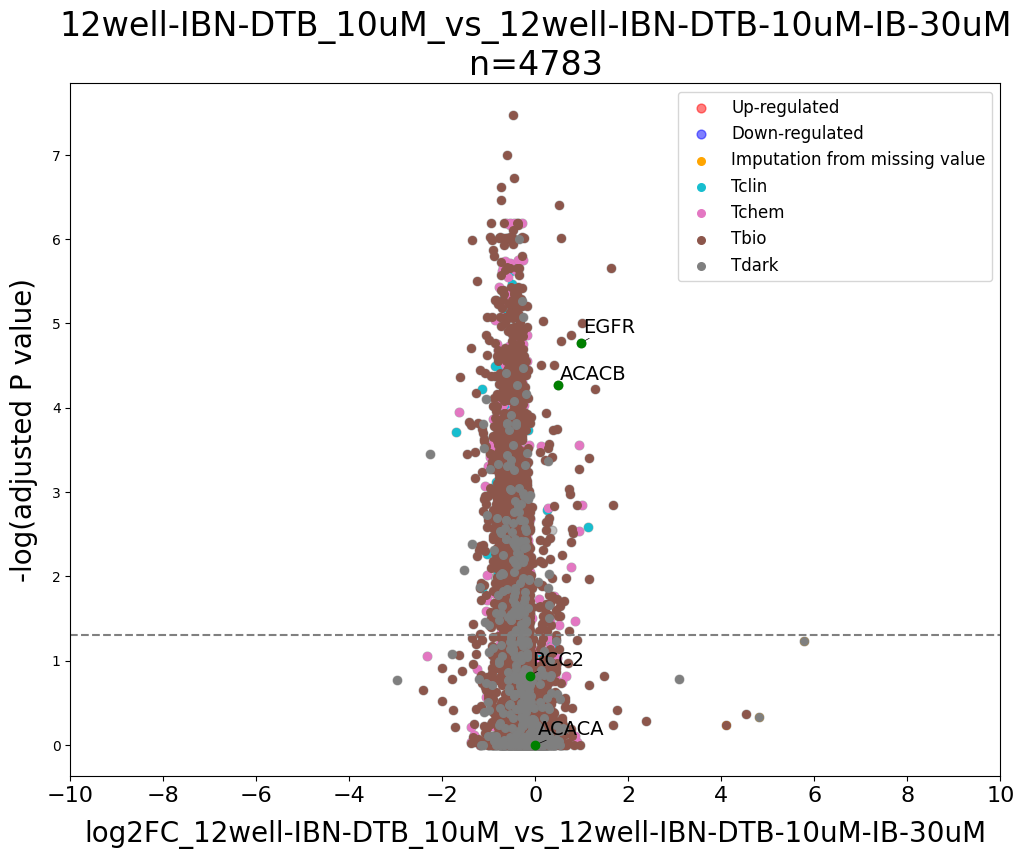

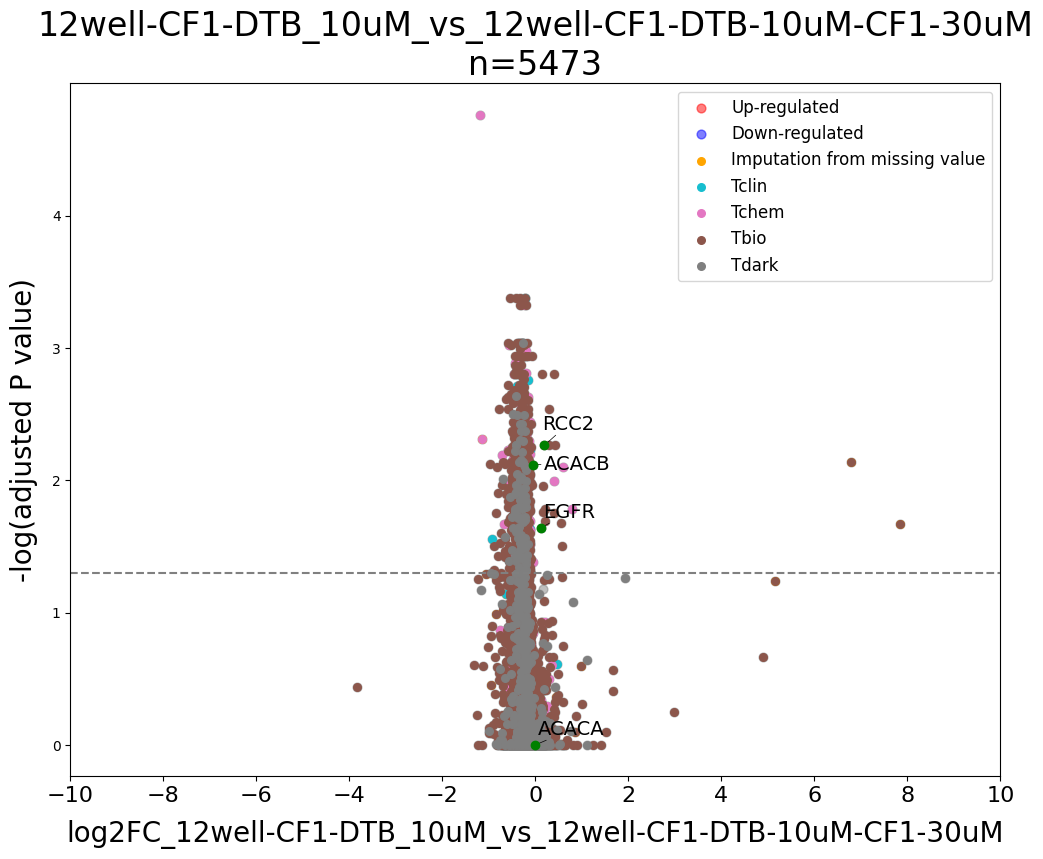

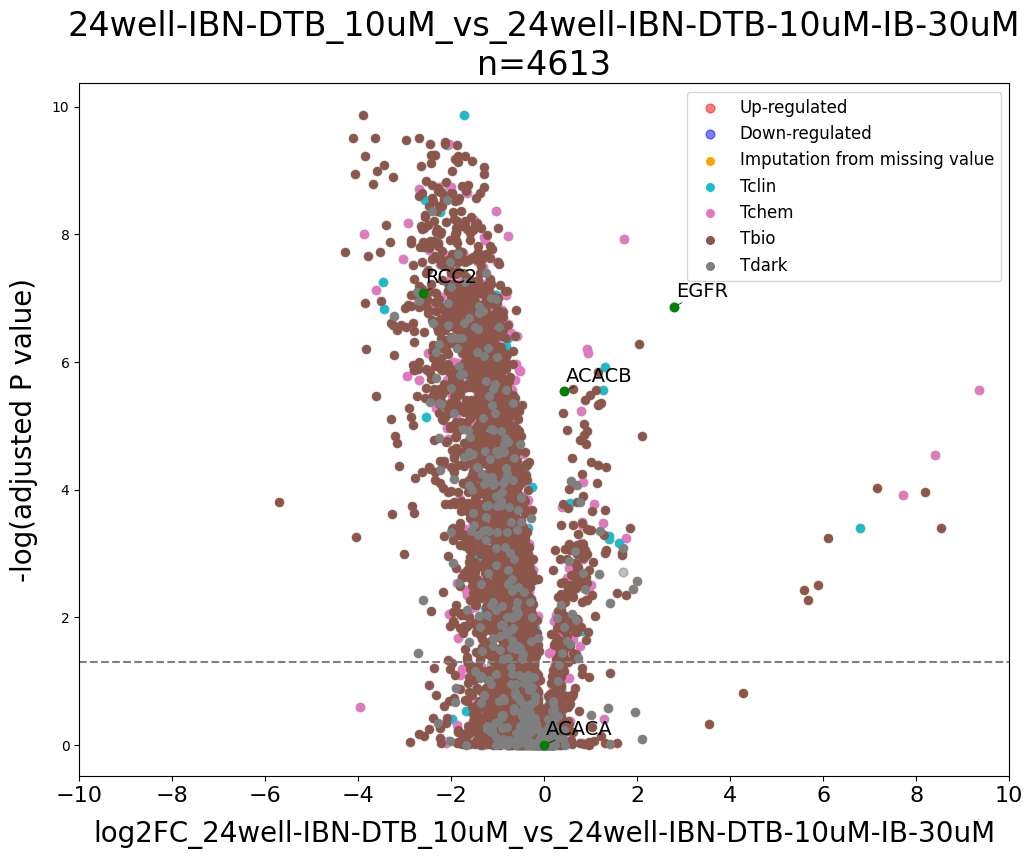

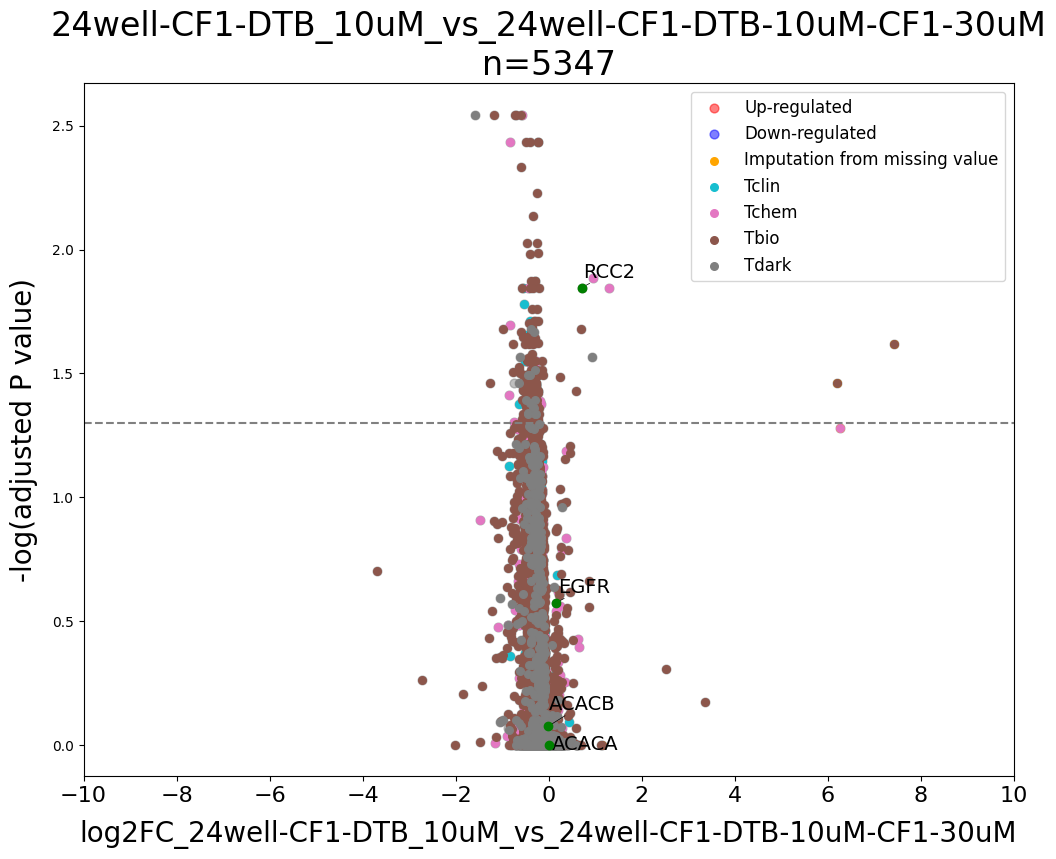

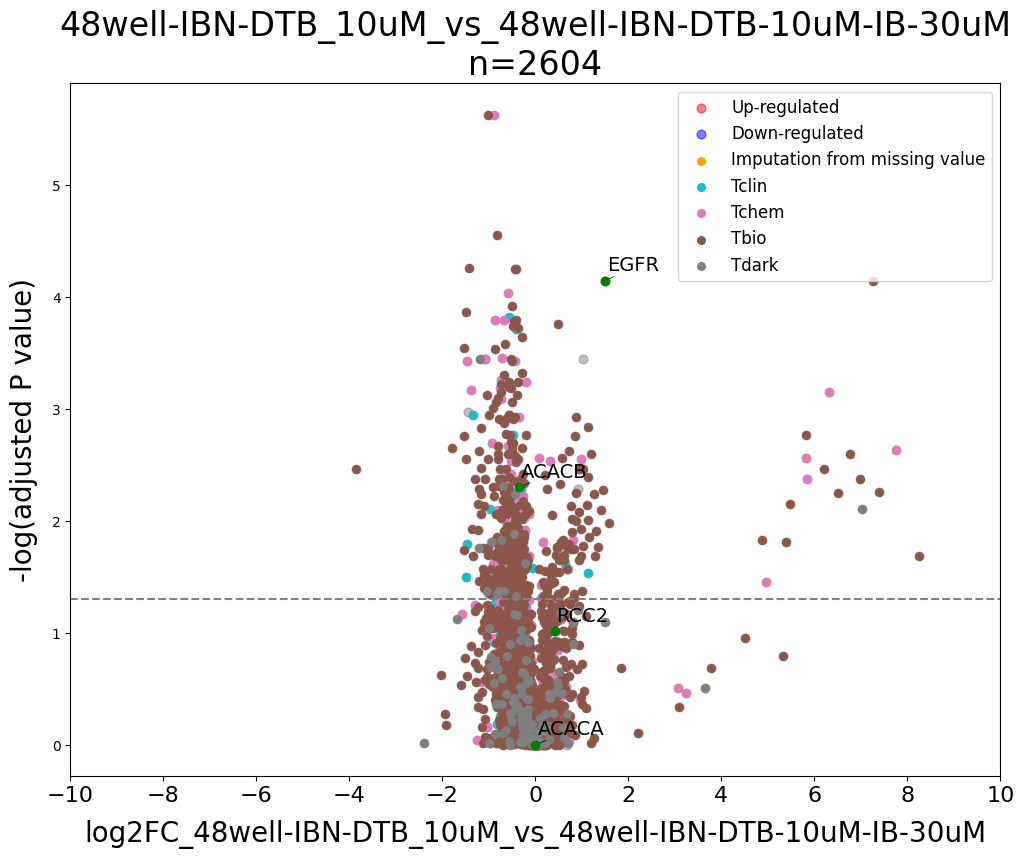

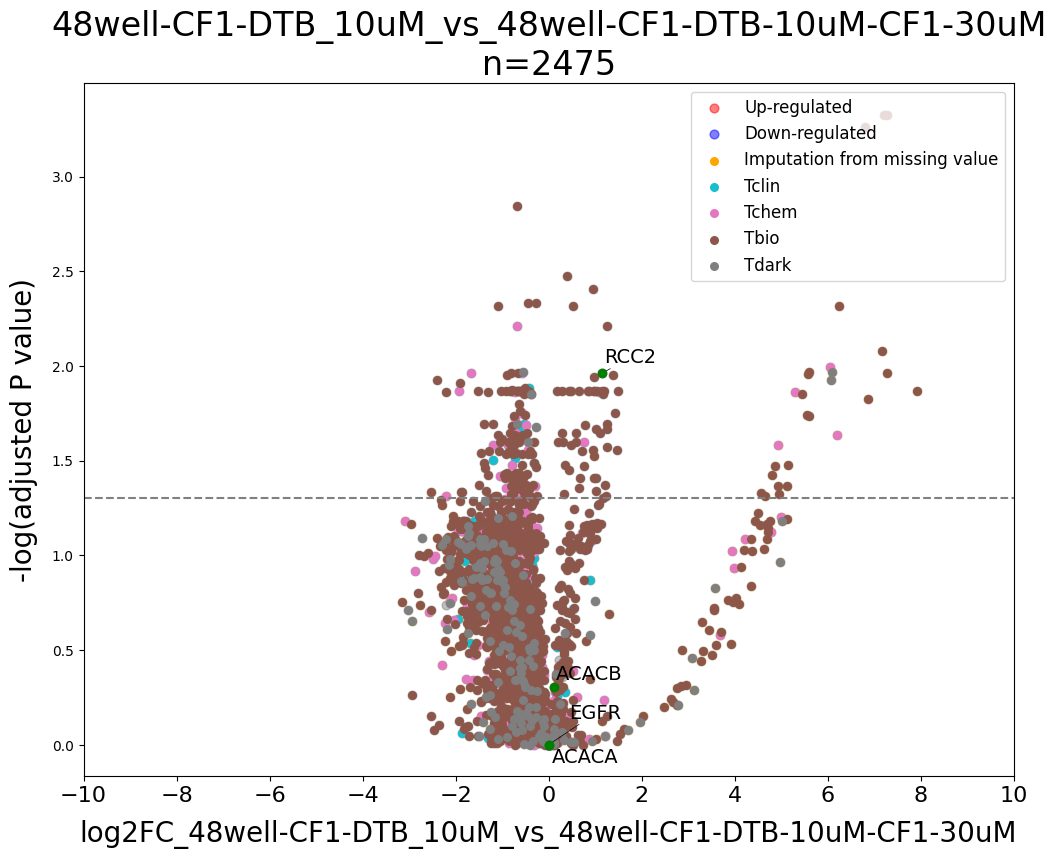

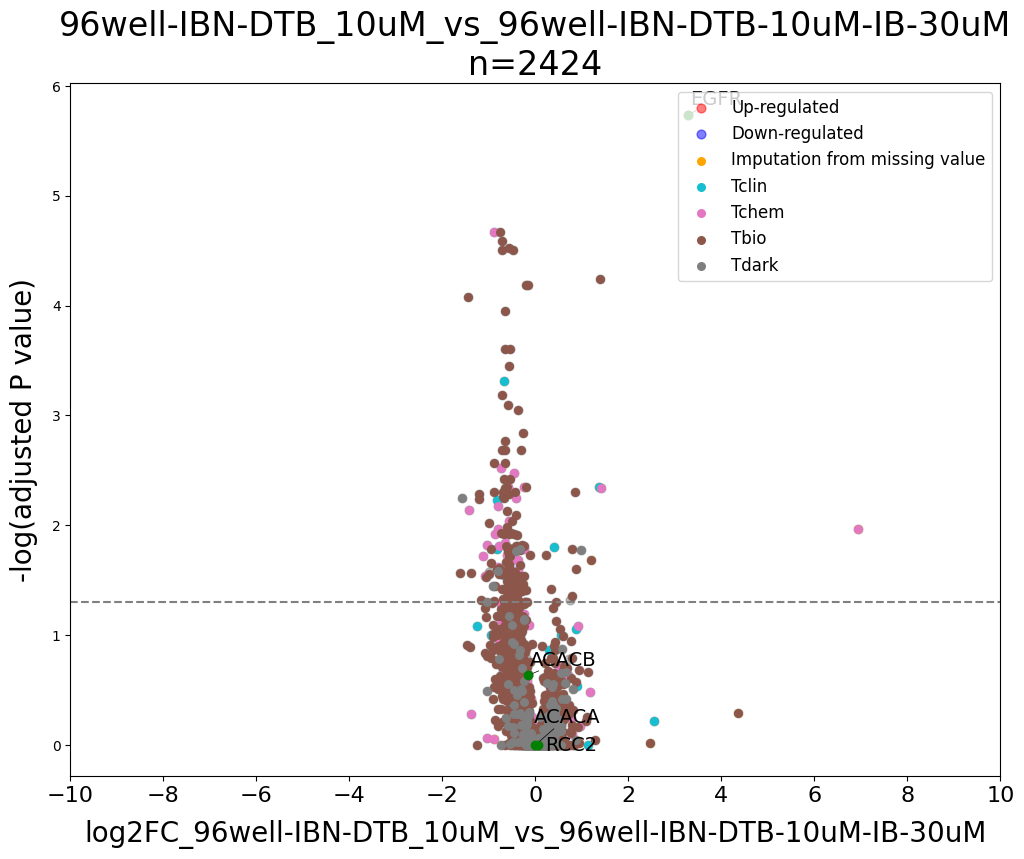

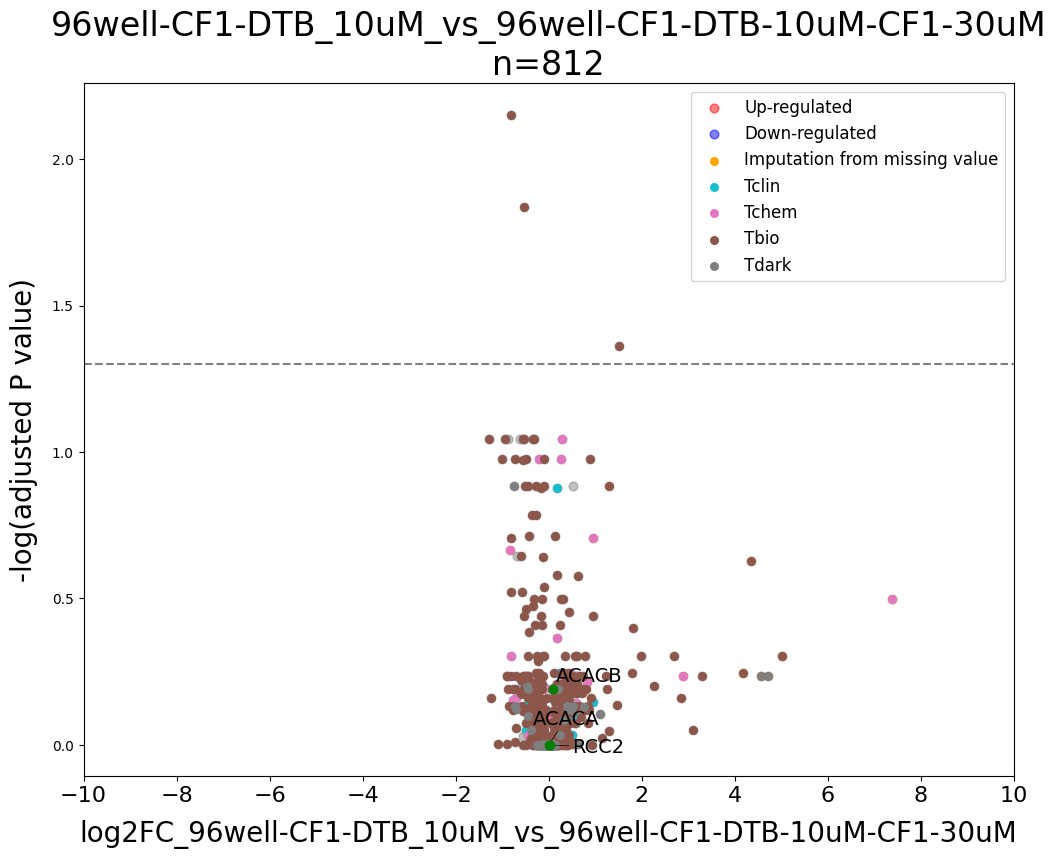

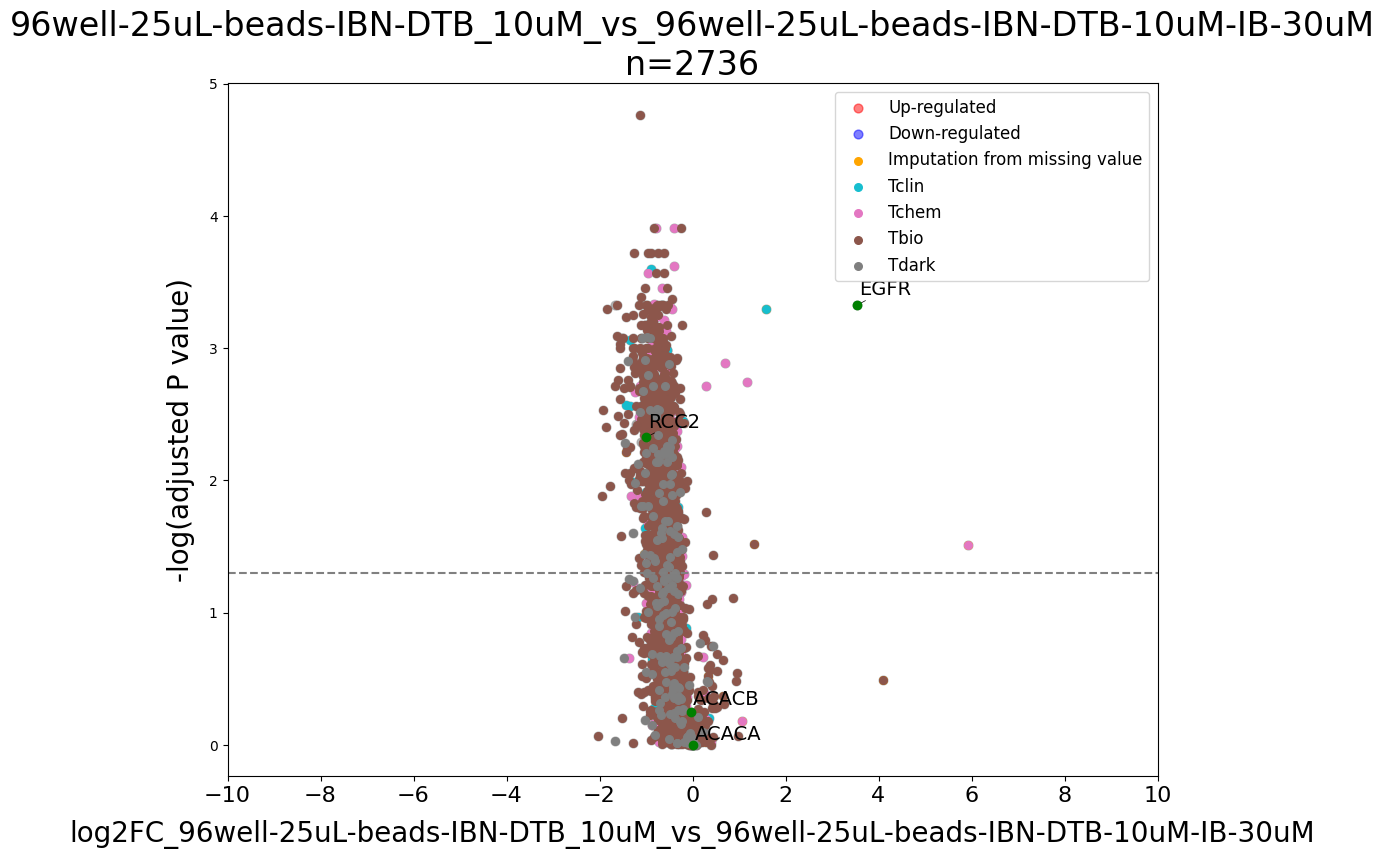

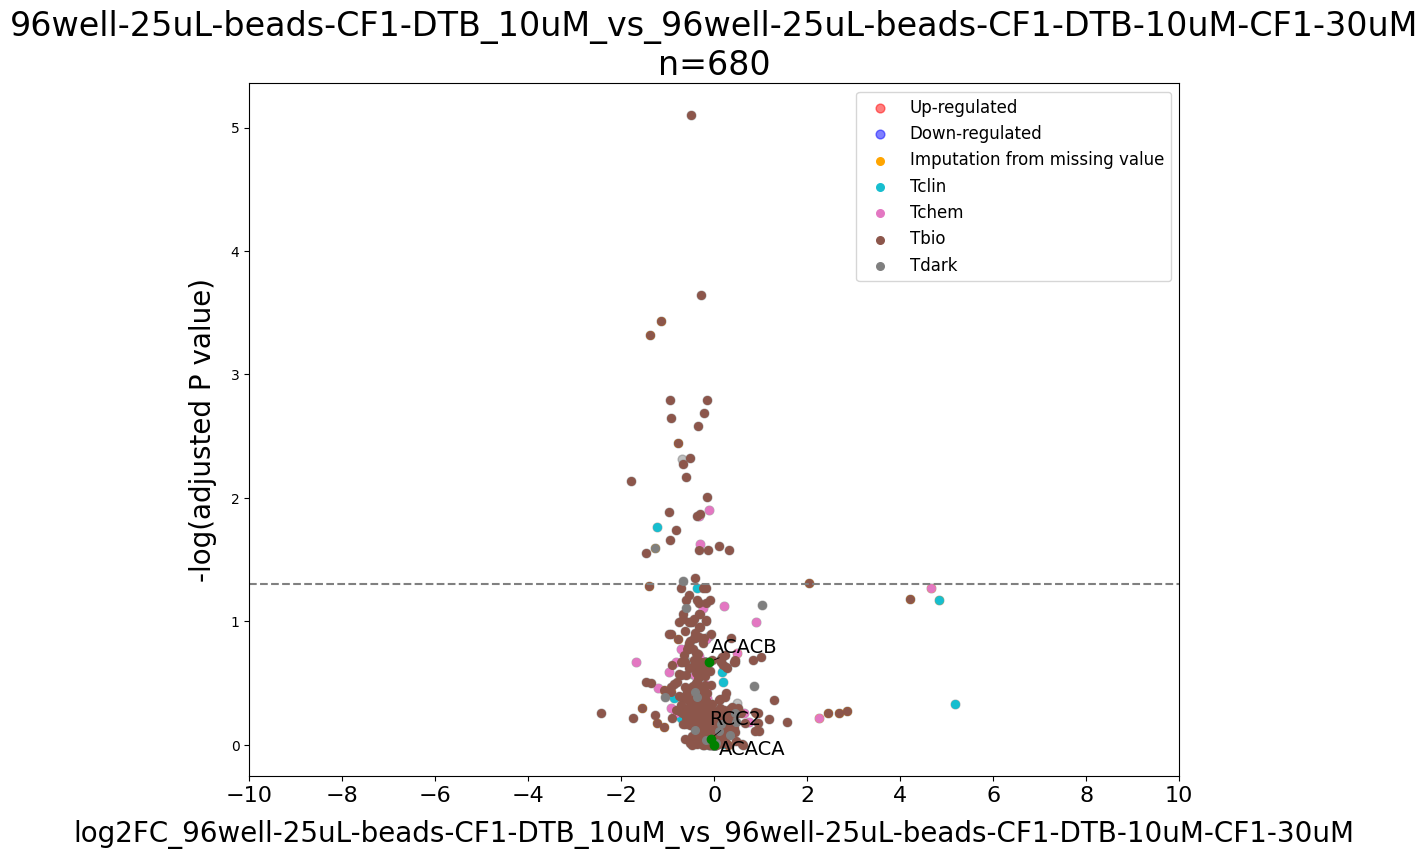

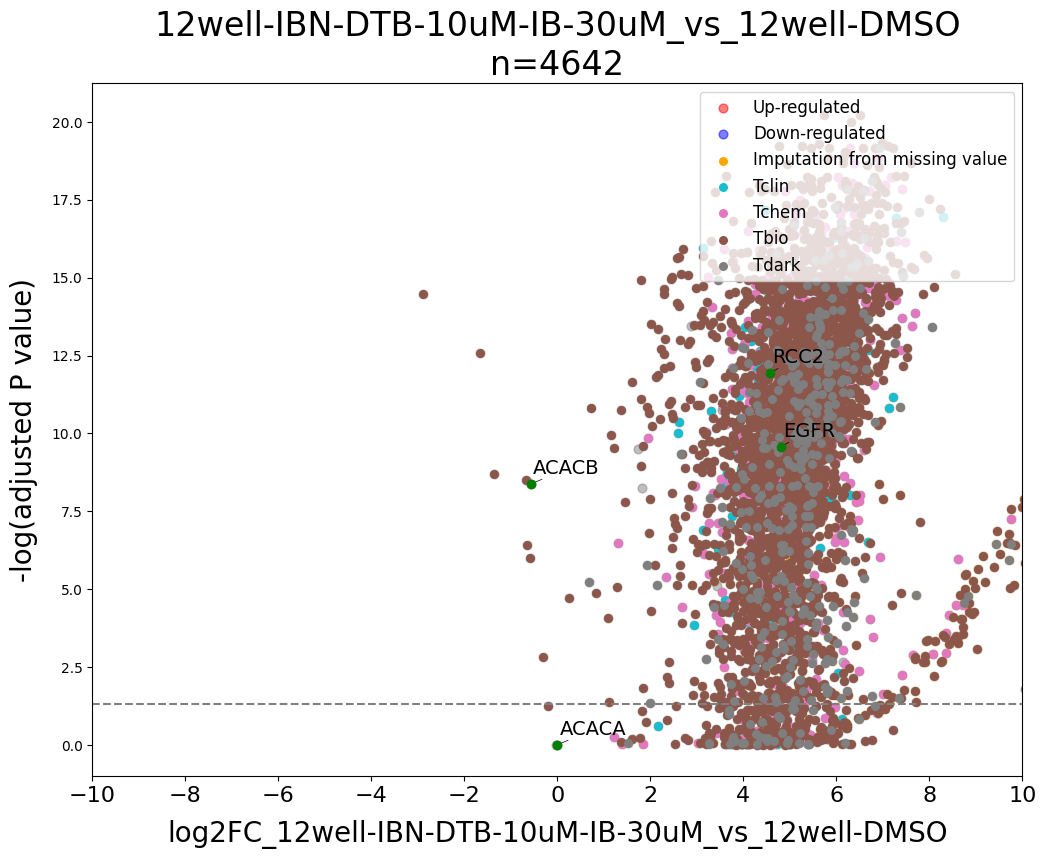

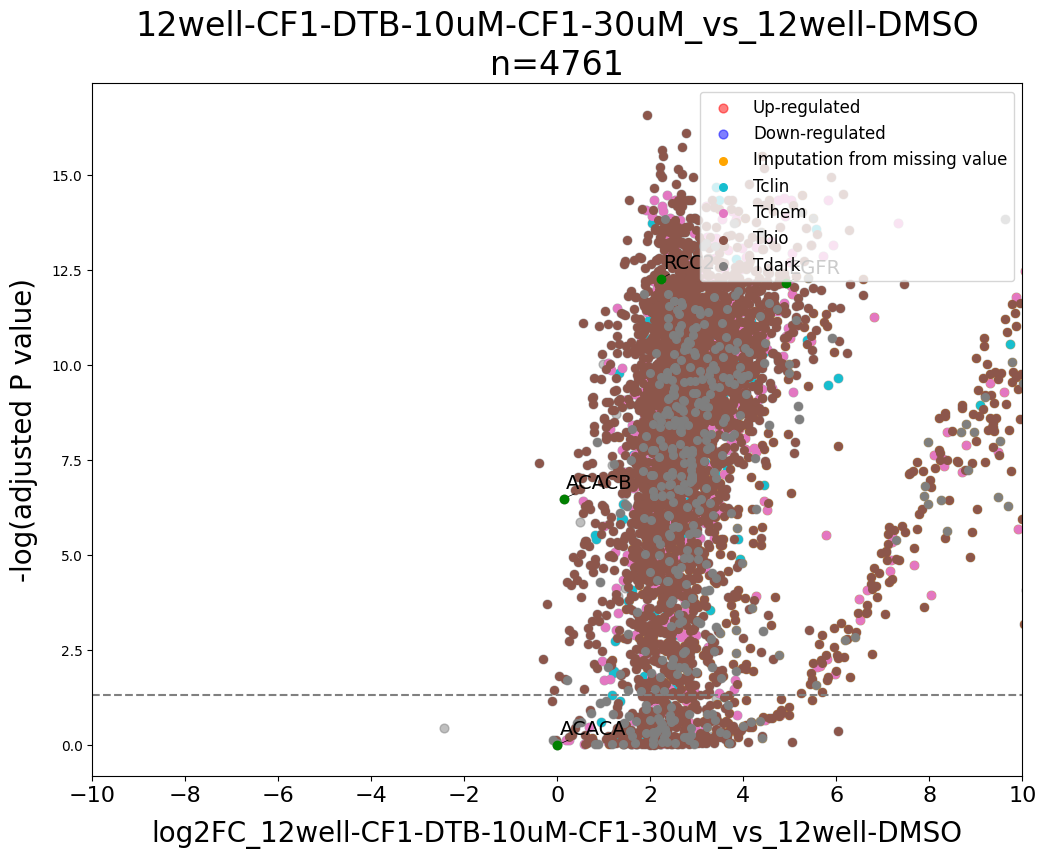

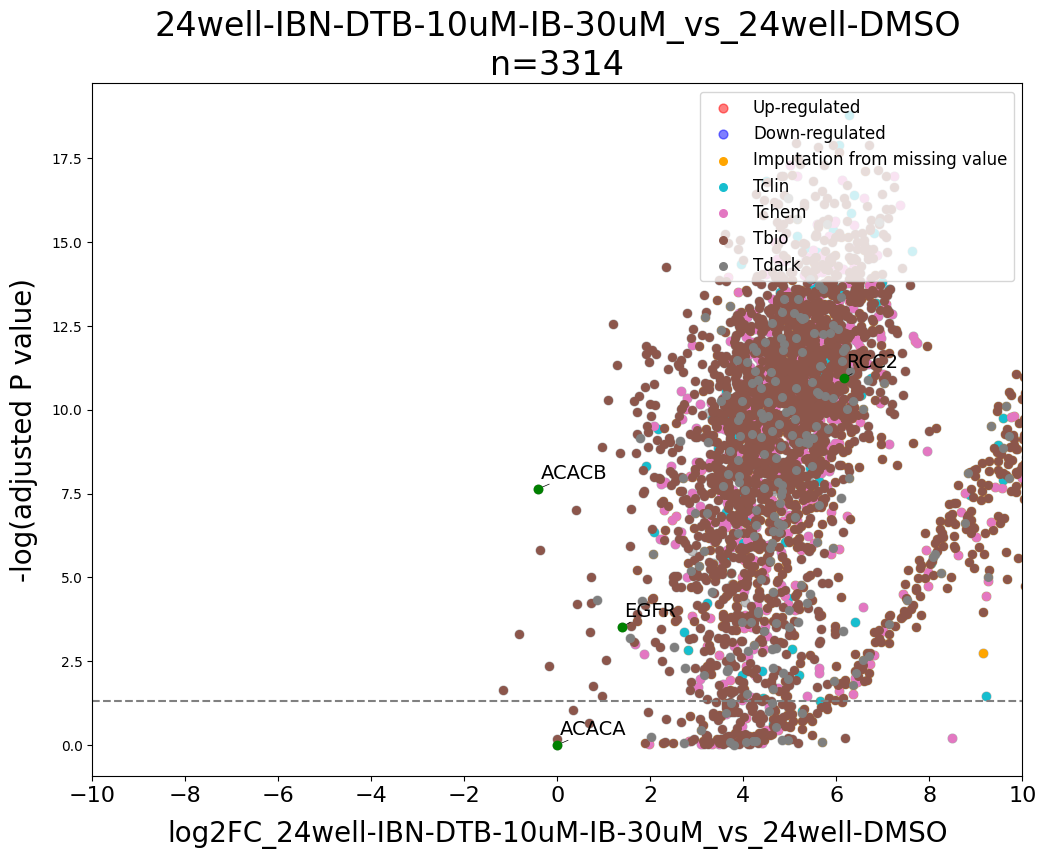

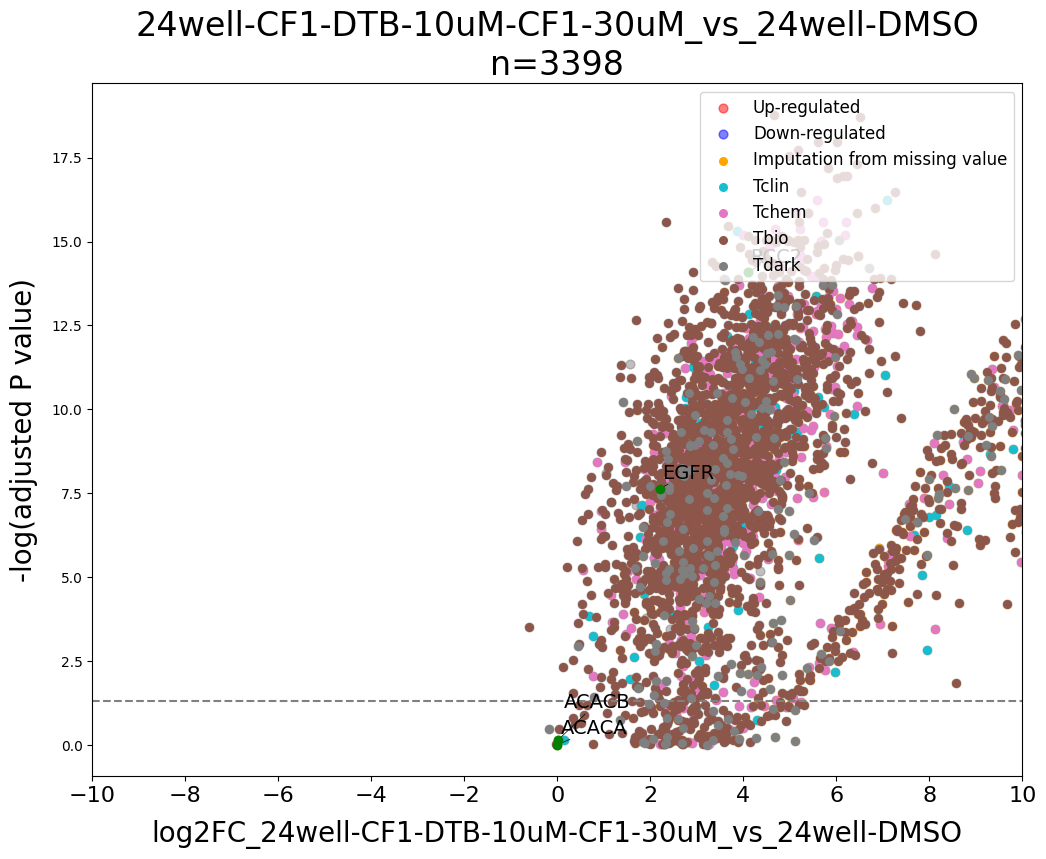

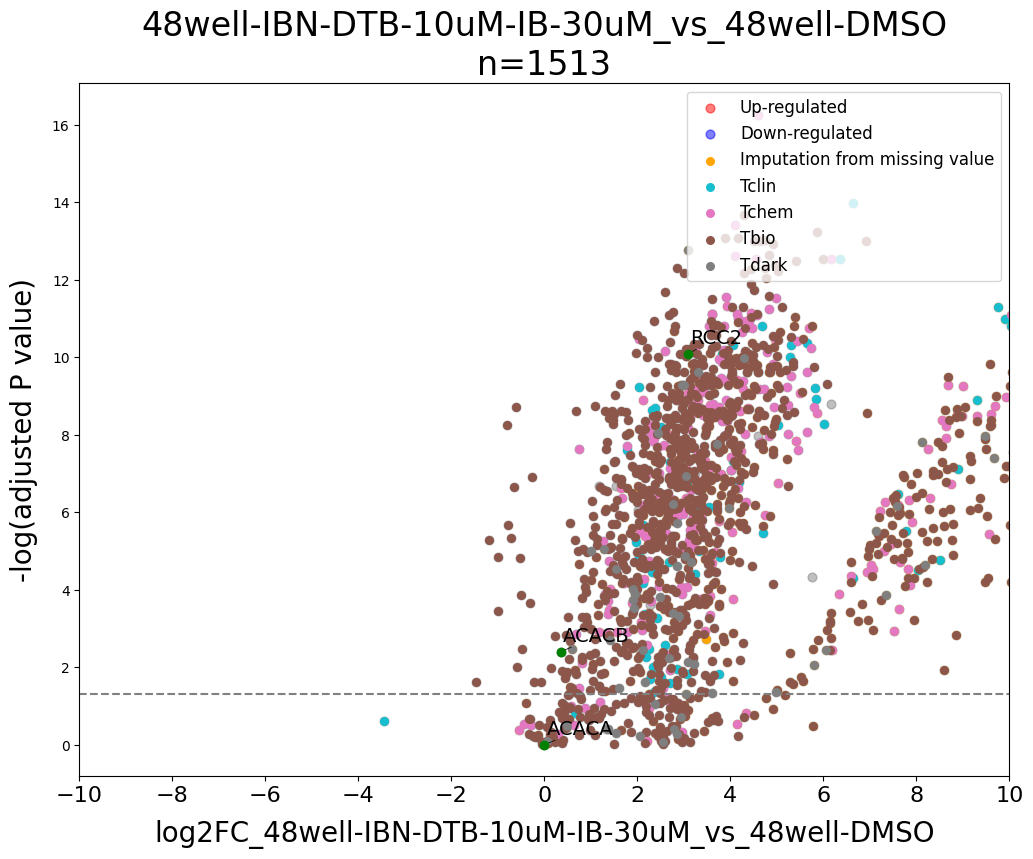

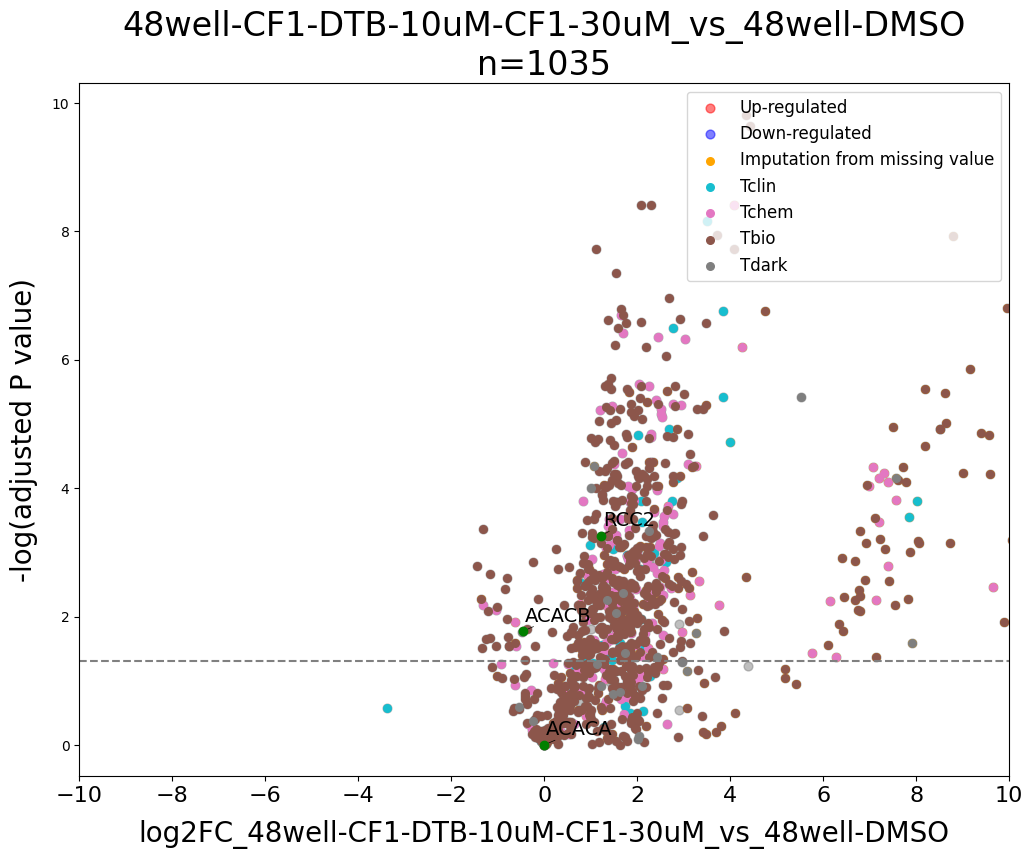

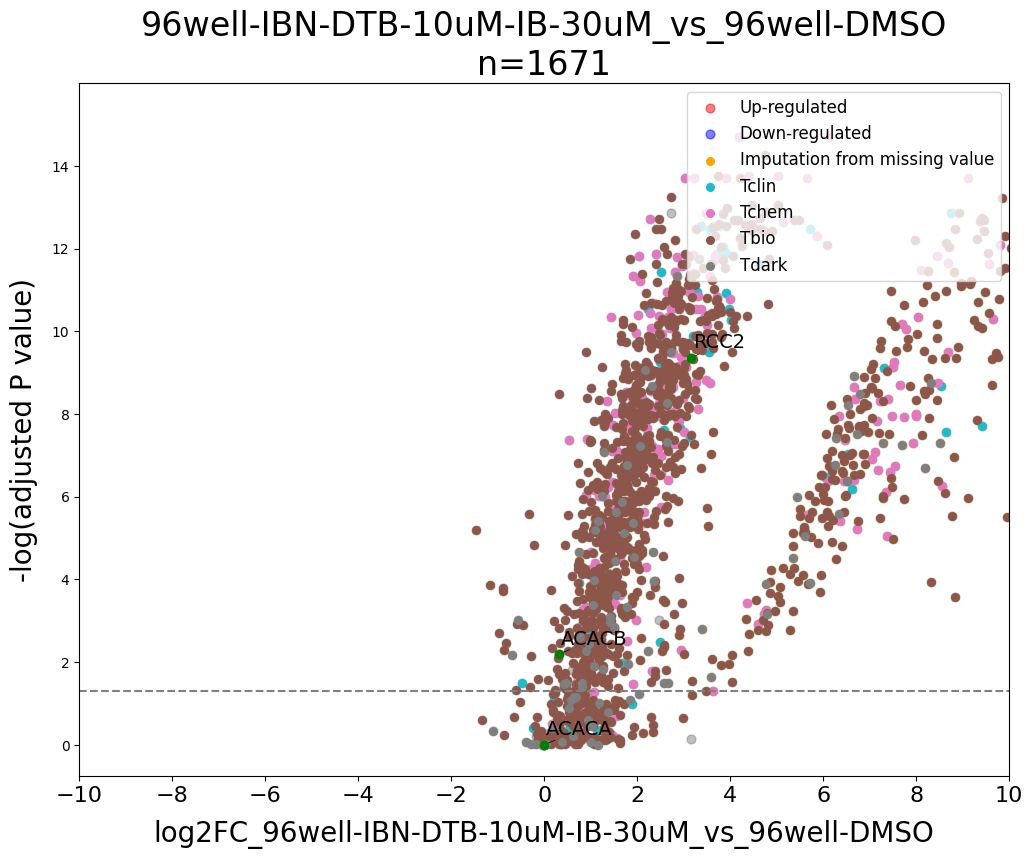

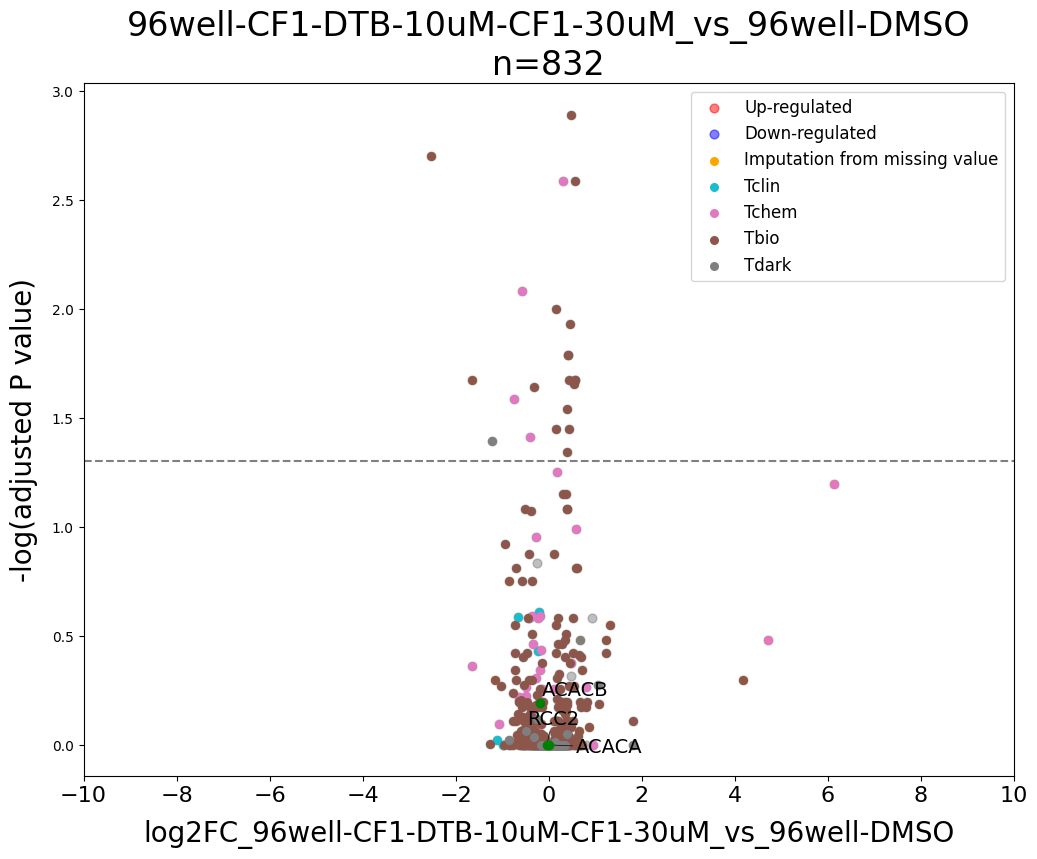

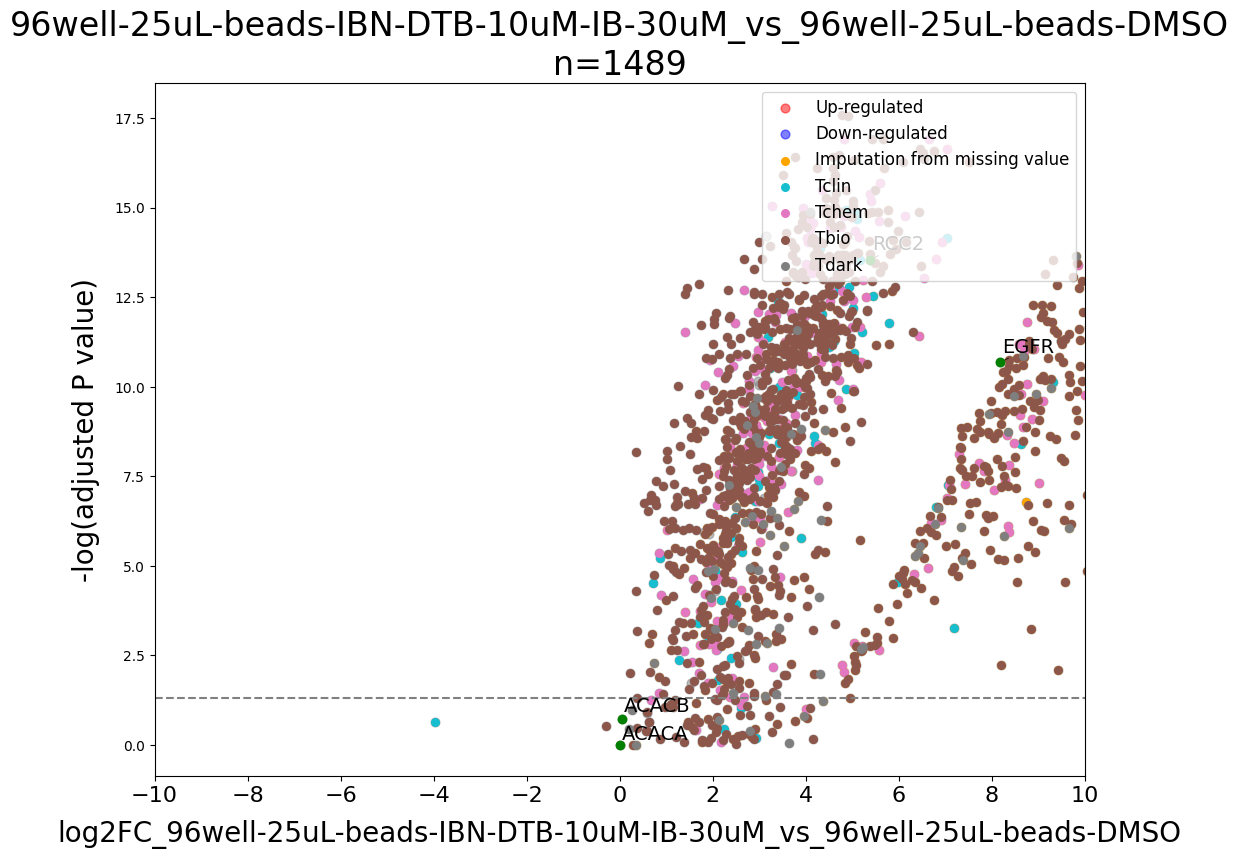

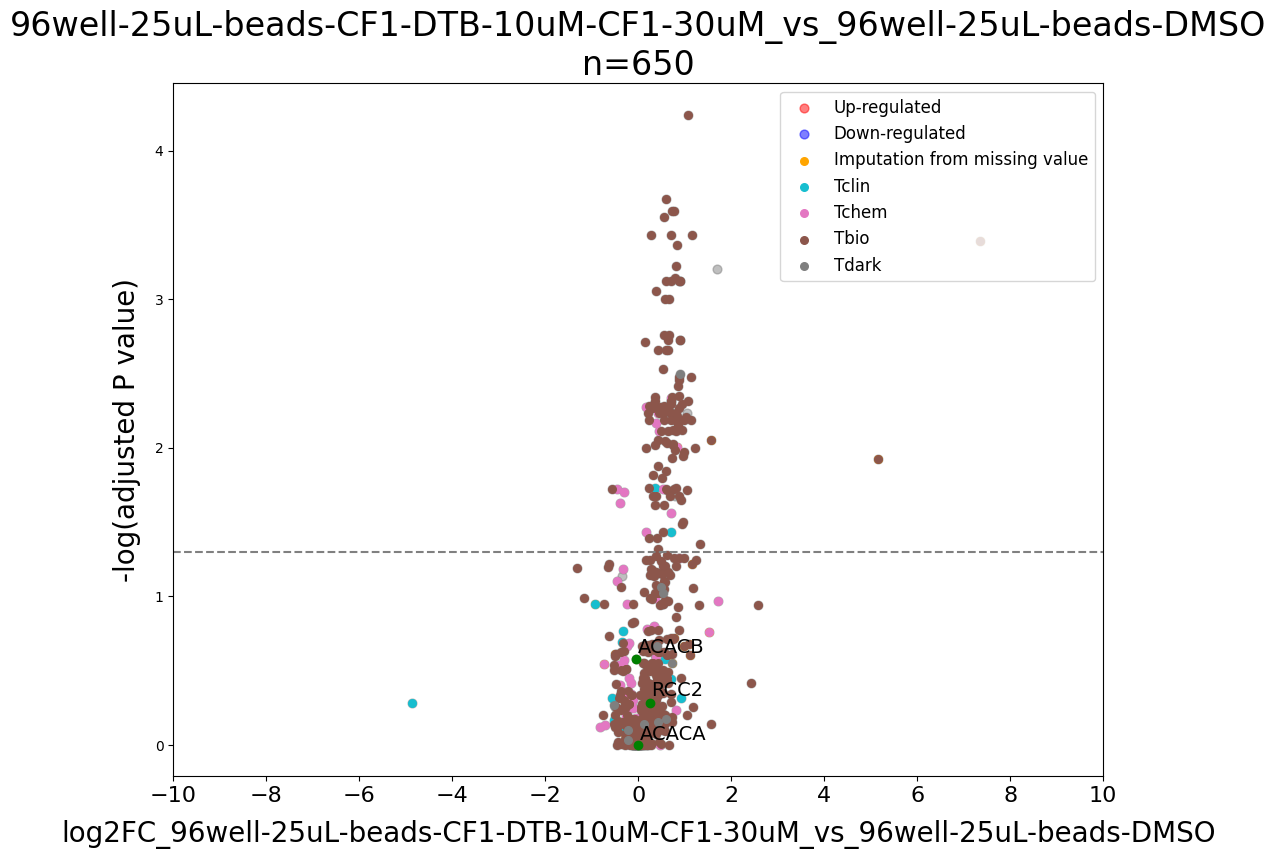

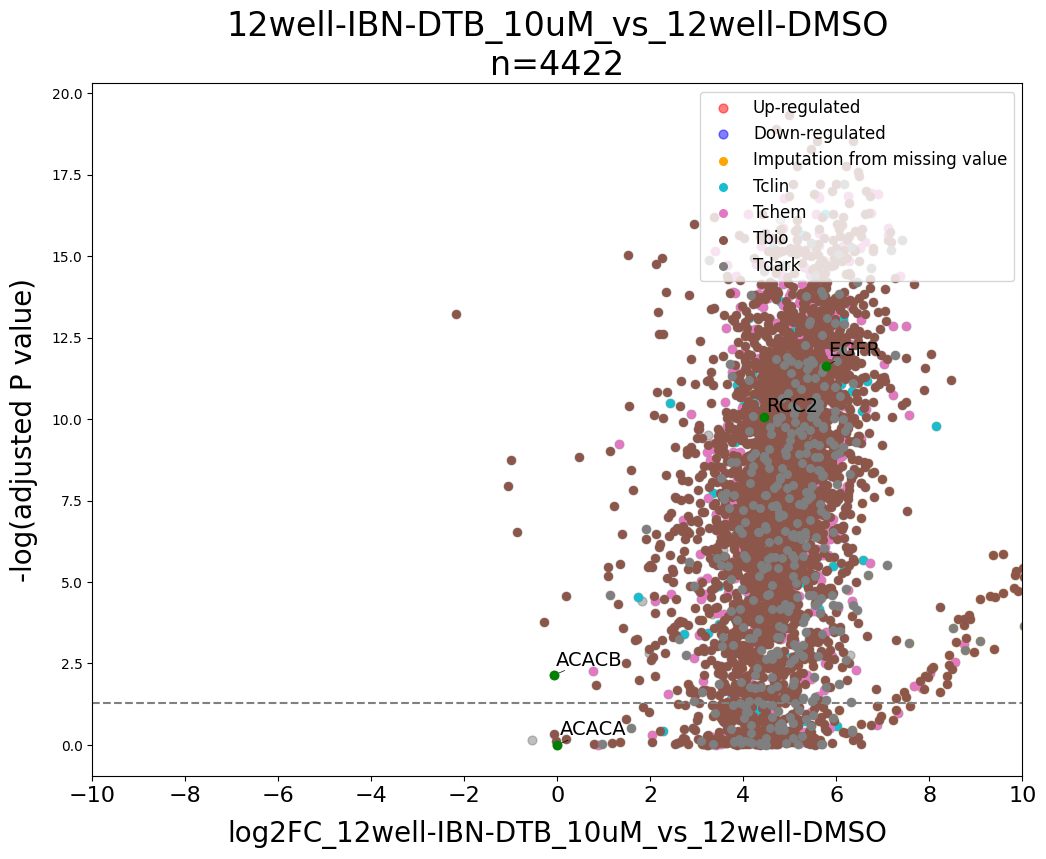

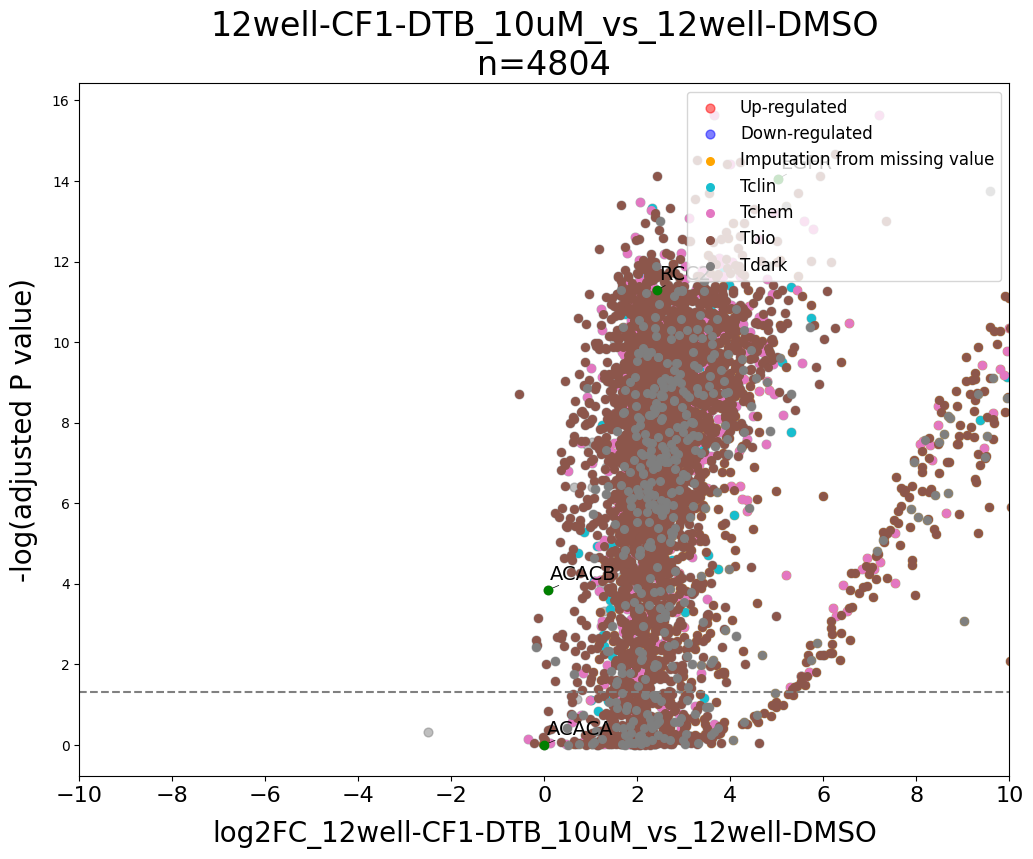

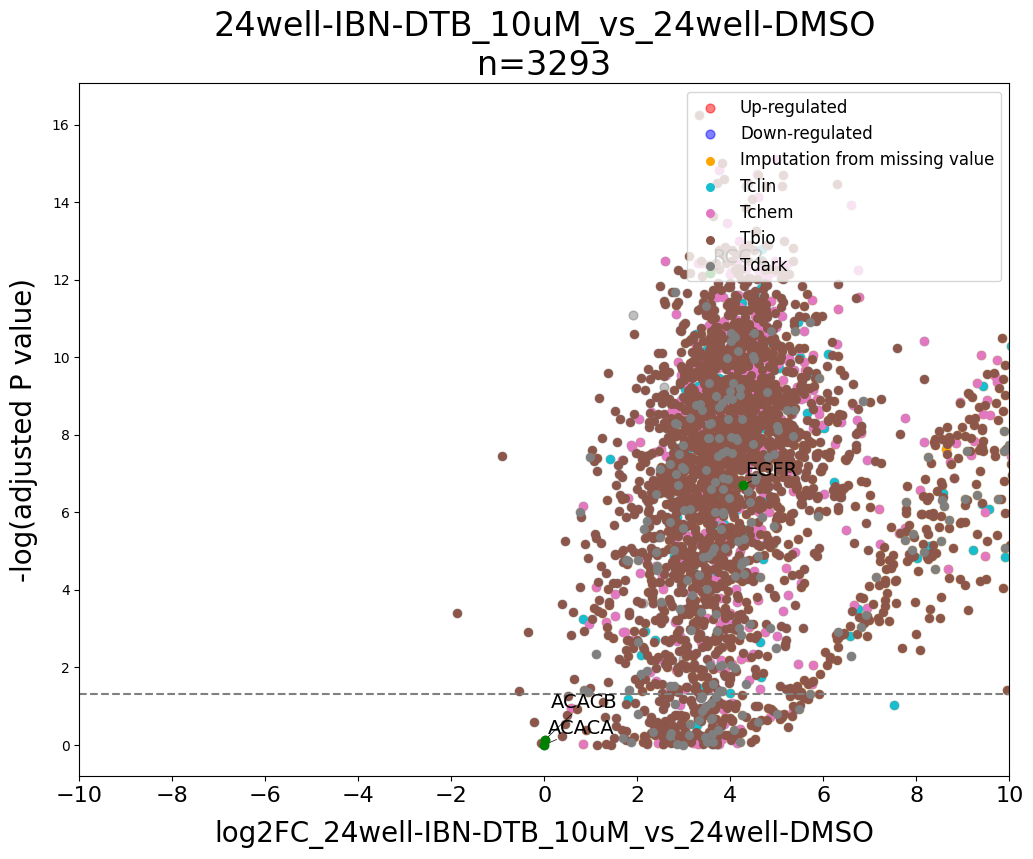

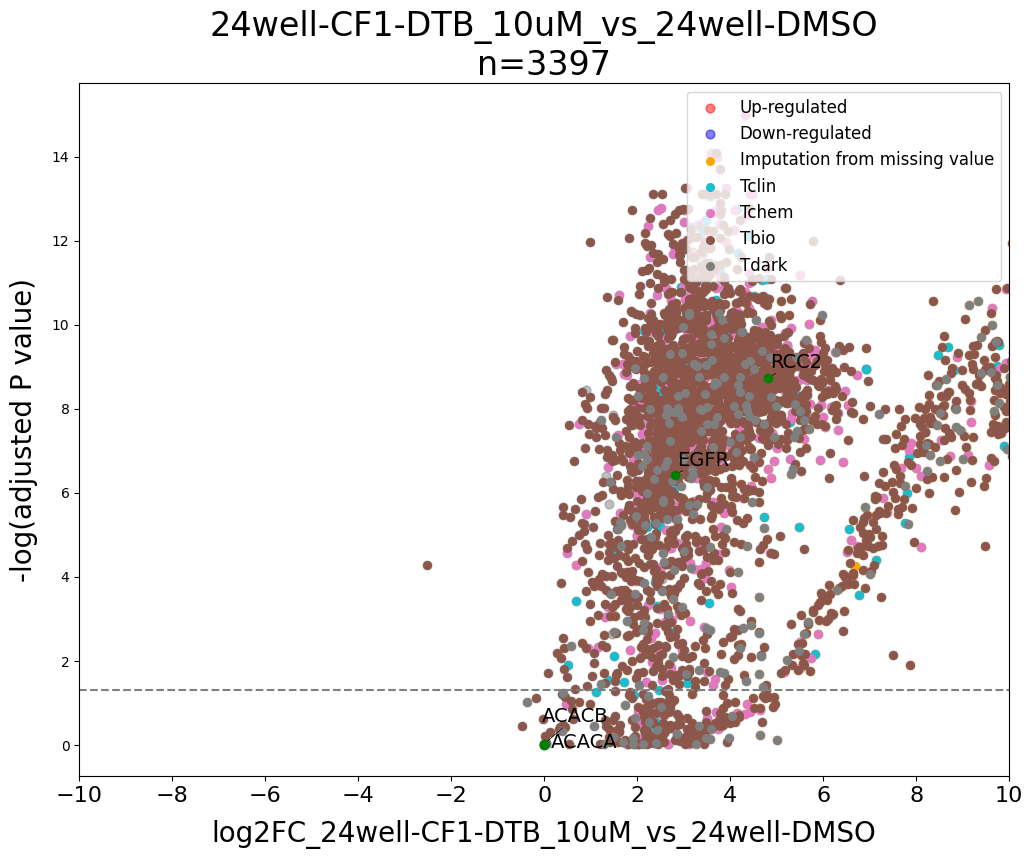

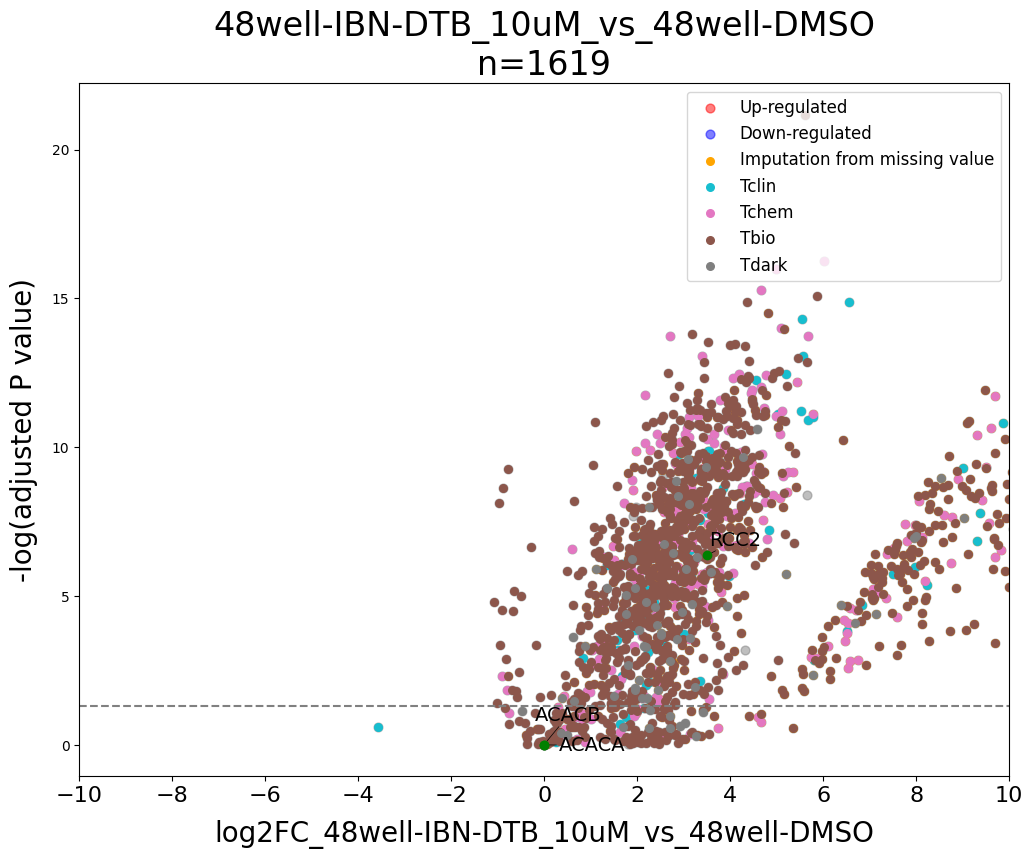

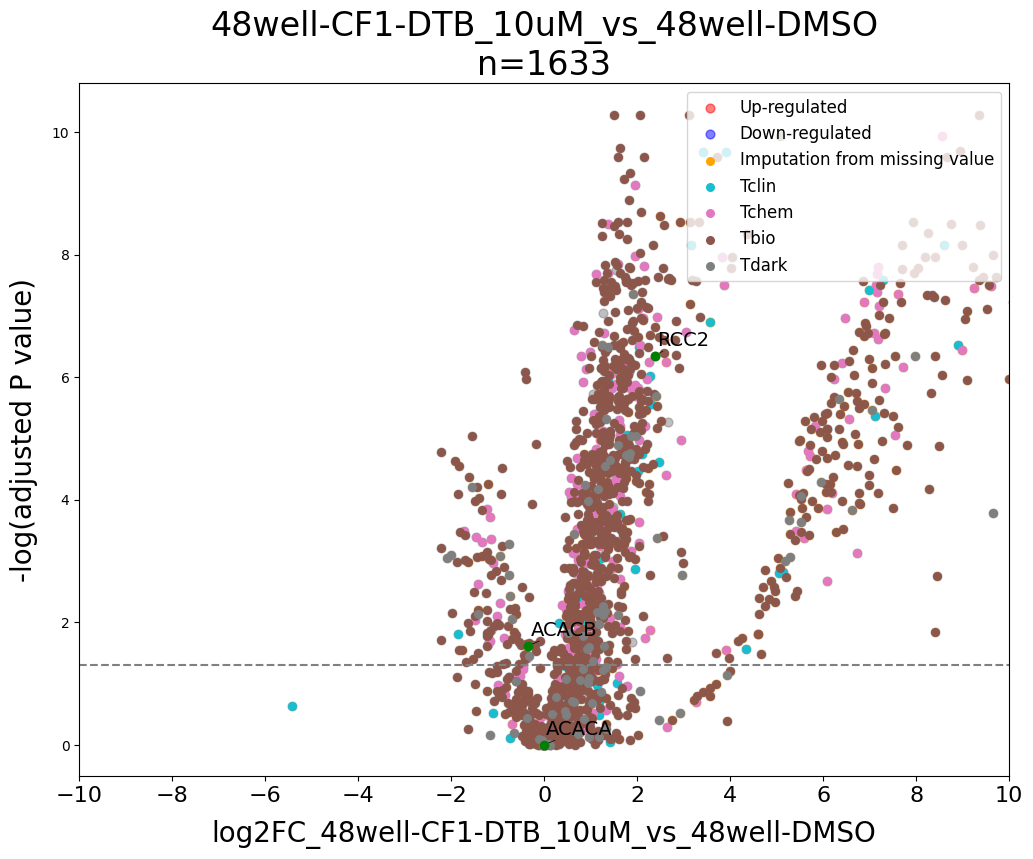

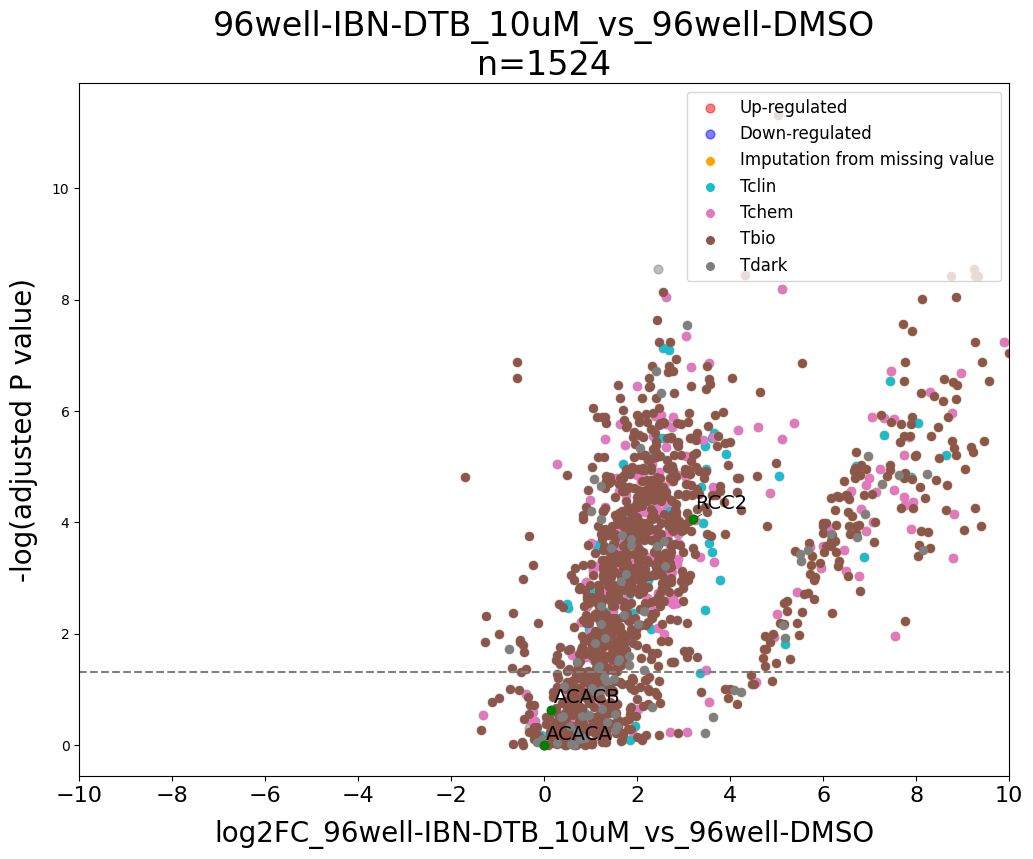

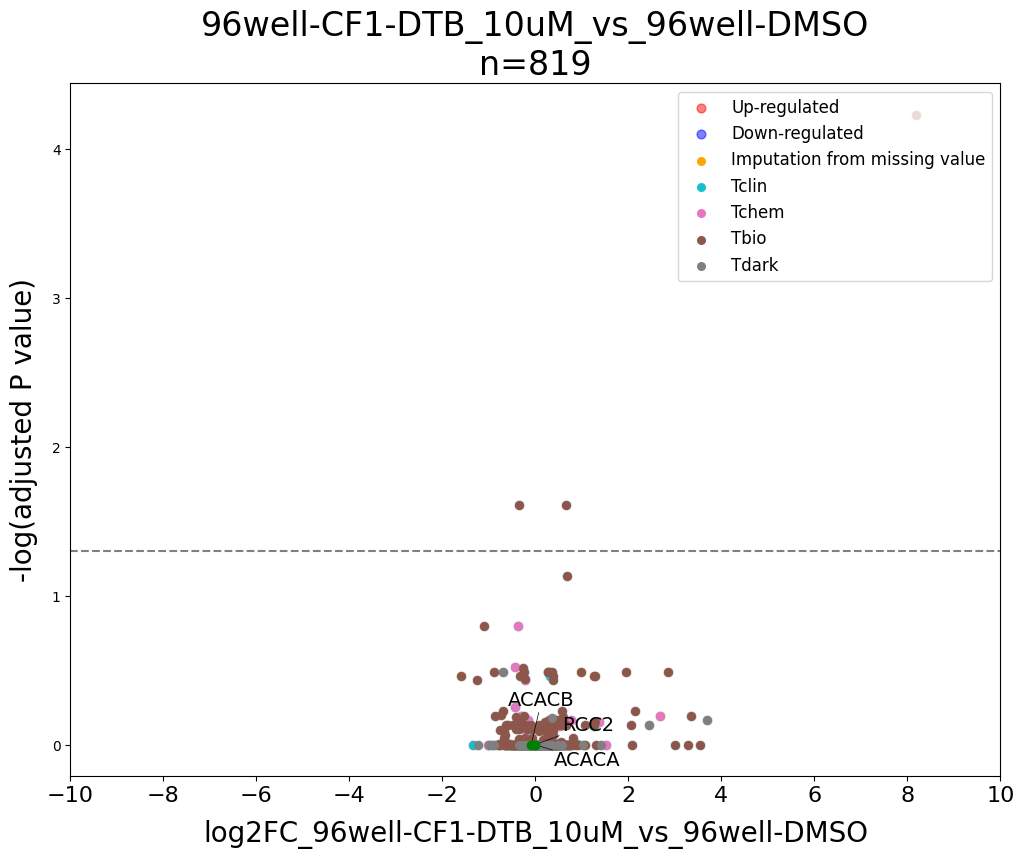

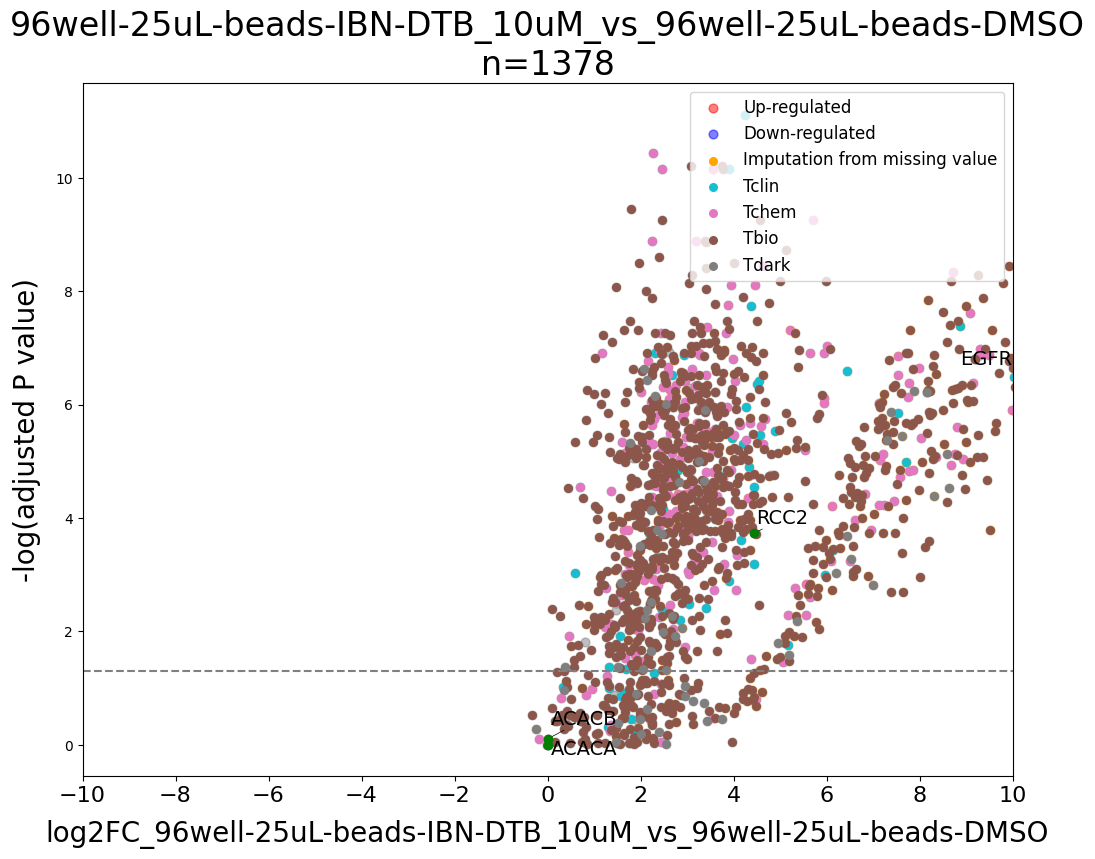

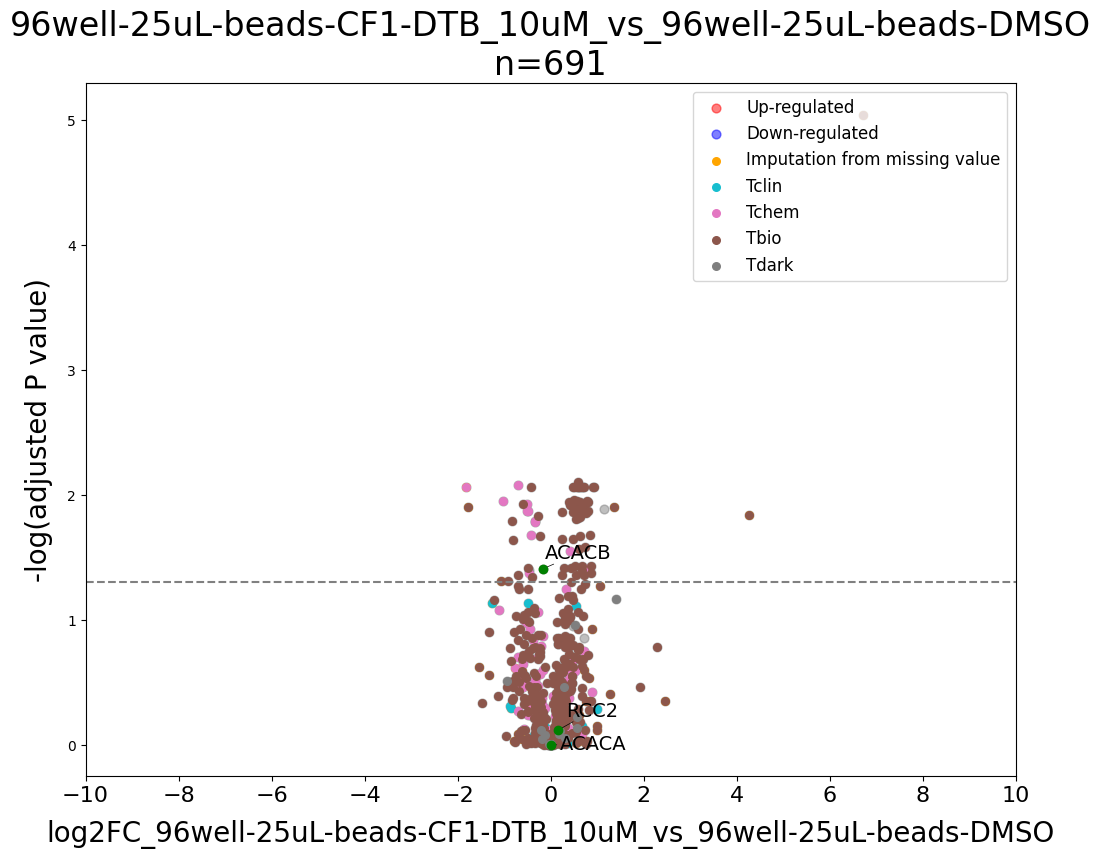

In [141]:
# volcano plot time!!
if not comparison_matrix:
    for key in group_columns:
        if key != reference_group:  # Skip the reference group
            volcano_plot(key, reference_group, FDR_cutoff=0.01, logFC_cutoff=1, use_empirical_fdr="neg_mode",fdr_alpha=0.1, p_value_cutoff=1,
                         highlight_genes=["Q9P2J9","P00533","Q9P258"], xlim=[-8,8], x_interval=2, y_interval=1, highlight_Gloops=False,highlight_RTloops=False, label_topX_mid_fc=0, file_suffix="")
else: # if you have customized comparison groups
    for pair in comparison_matrix:
        volcano_plot(pair[0], pair[1], FDR_cutoff=0.05, logFC_cutoff=100, highlight_genes=["Q13085","O00763","P00533","Q9P258"], use_empirical_fdr=False,xlim=[-10,10],x_interval=2, file_suffix="", PharosTCRD=True)

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  # Use KMeans for clustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, set_link_color_palette
from matplotlib.colors import rgb2hex
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FuncFormatter
from typing import Union

def bubble_dendro_plot(SAR, SAR_suffix="", figure_filename="bubble_plot.png",fig_title="", fig_width=50, fig_height=50, 
                       dendro_bubble_height_ratio=[1,3], bubble_legend_width_ratio=[20,1],
                       compound_labelsize=20, protein_labelsize=20, 
                       colorFCrange=[-4,0], highlight_G_loop=0, highlight_RT_loop=0, rainbow_palette=0,
                       invert_xy=False, selected_genes=[], legend_num: Union[str, int] = "auto"):
    # SAR_suffix="_1uM_vs_DMSO"
    # highlight_G_loop can be 0:none, 1: 5res-list, 2: 8res-list
    # invert_xy: if True, swap the x and y axes and do not draw the dendrogram

    # Add suffix for SAR list
    for key in SAR:
        SAR[key] = list(map(lambda s: s + SAR_suffix, SAR[key]))

    suffix_to_group = {suffix: cluster for cluster, suffixes in SAR.items() for suffix in suffixes}
    
    # Preparing downregulated proteins for meta-analysis
    df = pd.read_csv(FILE.split(".")[0]+"_analyzed.csv", sep=",", index_col=0)

    # Bubble plot table for x=treatment, y=protein, color=FC, size=FDR
    #df = df.drop(columns=df.filter(like="10uM").columns)

    # Identify log2FC and bh_FDR columns
    log2FC_columns = df.filter(regex="^log2FC_").columns

    # Extract suffixes for pairing
    log2FC_suffixes = [col.split("_", 1)[1] for col in log2FC_columns if col.split("_", 1)[1] in suffix_to_group]
    print(log2FC_suffixes)  # e.g. ['NGT20-11_8nM_vs_DMSO', 'NGT20-11_40nM_vs_DMSO',...]

    # Create a mask for filtering rows
    mask = pd.DataFrame(
        {
            suffix: (df[f"log2FC_{suffix}"] < -1) & (df[f"bh_FDR_{suffix}"] < 0.01)
            for suffix in log2FC_suffixes
        }
    ).any(axis=1)

    # Apply the mask to filter rows
    df_protein_downreg = df[mask]
    print(df_protein_downreg.shape)
    
    df_protein_downreg["Description_Genes"] = (
        df_protein_downreg["First.Protein.Description"].fillna("") + " | " + df_protein_downreg["Genes"].fillna("")
    )

    # Melt the DataFrame for plotting
    df_protein_downreg = df_protein_downreg.reset_index()
    melted_log2FC = pd.melt(
        df_protein_downreg,
        id_vars=["Description_Genes", "Protein.Group"],
        value_vars=[col for col in df_protein_downreg.columns if col.startswith("log2FC")],
        var_name="log2FC_Column",
        value_name="log2FC",
    )
    
    melted_log2FC["Suffix"] = melted_log2FC["log2FC_Column"].str.split("_", n=1).str[1]
    melted_log2FC["Group"] = melted_log2FC["Suffix"].map(suffix_to_group)
    melted_log2FC = melted_log2FC[melted_log2FC["Suffix"].isin(suffix_to_group.keys())]

    # Map bh_FDR values and calculate -log10 scale
    melted_log2FC["bh_FDR"] = melted_log2FC.apply(
        lambda row: df_protein_downreg[f"bh_FDR_{row['Suffix']}"].iloc[row.name % len(df_protein_downreg)], axis=1
    )
    melted_log2FC["bh_FDR_log10"] = -np.log10(melted_log2FC["bh_FDR"])
    melted_log2FC["bh_FDR_log10"] = np.nan_to_num(melted_log2FC["bh_FDR_log10"], nan=0)

    # Pivot to get a matrix of Description_Genes vs. log2FC values for clustering
    pivot_df = melted_log2FC.pivot_table(
        index="Description_Genes",
        columns="Suffix",
        values="log2FC"
    )
    pivot_df = pivot_df.fillna(1)

    # If selected_genes is provided, filter both pivot_df and melted_log2FC
    if selected_genes:
        pivot_df = pivot_df.loc[pivot_df.index.isin(selected_genes)]
        melted_log2FC = melted_log2FC[melted_log2FC["Description_Genes"].isin(selected_genes)]

    # Compute pairwise distances and hierarchical clustering
    distance_threshold = 3.5  # Set your cutoff distance here
    if pivot_df.shape[0] > 1:
        linkage_matrix = linkage(pivot_df, method="ward")  # Options: "ward", "average", etc.
        dendro = dendrogram(linkage_matrix, labels=pivot_df.index, no_plot=True)
        dendrogram_order = dendro["ivl"]
        # Define clusters using the distance threshold
        cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion="distance")
        pivot_df["Cluster"] = cluster_labels
    else:
        # With a single protein, simply use its order and assign a default cluster
        dendrogram_order = list(pivot_df.index)
        pivot_df["Cluster"] = 1

    # Define clusters using a distance threshold
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion="distance")
    pivot_df["Cluster"] = cluster_labels

    # Map cluster labels back to the original DataFrame
    cluster_mapping = pivot_df["Cluster"].to_dict()
    melted_log2FC["Cluster"] = melted_log2FC["Description_Genes"].map(cluster_mapping)

    # Convert cluster and Suffix to string (for categorical color coding)
    melted_log2FC["Cluster"] = melted_log2FC["Cluster"].astype(str)
    melted_log2FC["Suffix"] = melted_log2FC["Suffix"].astype(str)


    # Reorder categories using dendrogram order for protein descriptions
    melted_log2FC["Description_Genes"] = pd.Categorical(
        melted_log2FC["Description_Genes"],
        categories=dendrogram_order,
        ordered=True
    )
    # Order Suffix based on SAR dictionary (if needed)
    ordered_suffixes = [suffix for group in SAR.values() for suffix in group]
    melted_log2FC["Suffix"] = pd.Categorical(melted_log2FC["Suffix"], categories=ordered_suffixes, ordered=True)
    melted_log2FC.sort_values(by=["Suffix", "Description_Genes"], inplace=True)
    
    melted_log2FC.to_csv("temp.csv")

    # Define colors for groups (from SAR) and for clusters
    unique_groups = melted_log2FC["Group"].dropna().unique()
    group_colors = {group: get_cmap("tab20")(i / len(unique_groups)) for i, group in enumerate(unique_groups)}
    melted_log2FC["Group_Color"] = melted_log2FC["Group"].map(group_colors)
    unique_clusters = melted_log2FC["Cluster"].unique()
    cluster_colors = {cluster: get_cmap("tab20")(i / len(unique_clusters)) for i, cluster in enumerate(unique_clusters)}
    melted_log2FC["Cluster_Color"] = melted_log2FC["Cluster"].map(cluster_colors)
    
    Description_Genes_UniprotID_dict = df_protein_downreg.set_index("Description_Genes")["Protein.Group"].to_dict()  # {"proteinA|geneA": uniprotID, ...}

    # Set up figure and GridSpec depending on invert_xy flag
    if not invert_xy:
        # Layout with dendrogram (2 rows x 2 columns)
        fig = plt.figure(figsize=(fig_width, fig_height))
        gs = GridSpec(2, 2, figure=fig, height_ratios=dendro_bubble_height_ratio, width_ratios=bubble_legend_width_ratio)
        # Dendrogram subplot
        ax_dendro = fig.add_subplot(gs[0, 0])
        dendro = dendrogram(
            linkage_matrix,
            labels=pivot_df.index,
            leaf_rotation=90,
            distance_sort="ascending",
            color_threshold=0,
            above_threshold_color="black",
            ax=ax_dendro
        )
        ax_dendro.set_title("", fontsize=16)
        ax_dendro.set_xticks([])
        ax_dendro.set_ylabel("Distance", fontsize=30)
        # Bubble plot subplot below dendrogram
        ax_bubble = fig.add_subplot(gs[1, 0])
    else:
        # Layout without dendrogram (1 row x 2 columns)
        fig = plt.figure(figsize=(fig_width, fig_height))
        gs = GridSpec(1, 2, figure=fig, width_ratios=bubble_legend_width_ratio)
        ax_bubble = fig.add_subplot(gs[0, 0])

    # Plotting the bubble scatter plot with (x, y) depending on invert_xy.
    if not invert_xy:
        scatter = ax_bubble.scatter(
            melted_log2FC["Description_Genes"],  # x-axis: protein descriptions
            melted_log2FC["Suffix"],             # y-axis: treatment suffixes
            c=melted_log2FC["log2FC"],            # color by log2FC
            s=melted_log2FC["bh_FDR_log10"] * 500,  # size proportional to -log10(FDR)
            cmap=get_cmap("Spectral").reversed() if rainbow_palette else "coolwarm",
            alpha=0.7,
            edgecolors="w",
            clip_on=False,
        )
    else:
        scatter = ax_bubble.scatter(
            melted_log2FC["Suffix"],              # x-axis: treatment suffixes
            melted_log2FC["Description_Genes"],   # y-axis: protein descriptions
            c=melted_log2FC["log2FC"],
            s=melted_log2FC["bh_FDR_log10"] * 500,
            cmap=get_cmap("Spectral").reversed() if rainbow_palette else "coolwarm",
            alpha=0.7,
            edgecolors="w",
            clip_on=False,
        )

    # Set up legend/colorbar axes (adjust GridSpec nested location based on invert_xy)
    if not invert_xy:
        gs_nested = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1, 1], height_ratios=[2, 3])
        ax_empty = fig.add_subplot(gs_nested[0, 0])
        ax_empty.axis('off')
        ax_cbar = fig.add_subplot(gs_nested[1, :])    
    else:
        gs_nested = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 1], width_ratios=[2, 3])
        ax_empty = fig.add_subplot(gs_nested[0, 0])
        ax_empty.axis('off')
        ax_cbar = fig.add_subplot(gs_nested[:, 1])

    cbar = plt.colorbar(scatter, cax=ax_cbar, shrink=0.8, location="left", ticklocation="right")
    cbar.set_label("Log2FC Value", fontsize=30, rotation=270, labelpad=30)
    ax_cbar.tick_params(labelsize=30)
    ax_cbar.set_aspect(5)
    scatter.set_clim(colorFCrange[0], colorFCrange[1])

    # Create size legend from scatter elements
    handles, labels = scatter.legend_elements(
        prop="sizes", alpha=0.6, num=legend_num+1 if legend_num is int else legend_num, func=lambda s: s / 500,
        fmt=FuncFormatter(lambda x, pos: f"{x:.2f}")
    )
    new_labels = [f"FDR = {10**(-float(l)):.2g}" for l in labels]
    ax_empty.legend(handles=handles, labels=new_labels, title="", fontsize=30,
                    labelspacing=1.5, borderaxespad=0.8, handleheight=0.2)

    # Color axis tick labels appropriately.
    if not invert_xy:
        # In standard mode: x-axis labels (proteins) colored by cluster, y-axis labels (suffixes) colored by SAR group.
        for label in ax_bubble.get_xticklabels():
            description = label.get_text()
            if description in melted_log2FC["Description_Genes"].values:
                cluster_id = melted_log2FC.loc[melted_log2FC["Description_Genes"] == description, "Cluster"].iloc[0]
                label.set_color(cluster_colors[cluster_id])
            # Highlight if needed (using external g_loop_5res_noEC / g_loop_8res_noEC)
            if highlight_G_loop == 1:
                if (description in Description_Genes_UniprotID_dict) and (Description_Genes_UniprotID_dict[description] in g_loop_5res_noEC):
                    label.set_bbox(dict(facecolor="grey", edgecolor="none", alpha=0.3))
            if highlight_G_loop == 2:
                if (description in Description_Genes_UniprotID_dict) and (Description_Genes_UniprotID_dict[description] in g_loop_8res_noEC):
                    label.set_bbox(dict(facecolor="grey", edgecolor="none", alpha=0.3))
            if highlight_RT_loop == 1:
                if (description in Description_Genes_UniprotID_dict) and (Description_Genes_UniprotID_dict[description] in RT_loop_5res):
                    label.set_bbox(dict(facecolor="pink", edgecolor="none", alpha=0.3))
        for label in ax_bubble.get_yticklabels():
            group = label.get_text()
            if suffix_to_group.get(group) in group_colors:
                label.set_color(group_colors[suffix_to_group[group]])
    else:
        # In invert mode: now x-axis labels are suffixes and y-axis labels are proteins.
        for label in ax_bubble.get_xticklabels():
            group = label.get_text()
            if suffix_to_group.get(group) in group_colors:
                label.set_color(group_colors[suffix_to_group[group]])
        for label in ax_bubble.get_yticklabels():
            description = label.get_text()
            if description in melted_log2FC["Description_Genes"].values:
                cluster_id = melted_log2FC.loc[melted_log2FC["Description_Genes"] == description, "Cluster"].iloc[0]
                label.set_color(cluster_colors[cluster_id])
            if highlight_G_loop == 1:
                if (description in Description_Genes_UniprotID_dict) and (Description_Genes_UniprotID_dict[description] in g_loop_5res_noEC):
                    label.set_bbox(dict(facecolor="grey", edgecolor="none", alpha=0.3))
            if highlight_G_loop == 2:
                if (description in Description_Genes_UniprotID_dict) and (Description_Genes_UniprotID_dict[description] in g_loop_8res_noEC):
                    label.set_bbox(dict(facecolor="grey", edgecolor="none", alpha=0.3))

    # Adjust axis labels, tick parameters, and grid.
    if not invert_xy:
        ax_bubble.set_xlabel("")
        ax_bubble.tick_params(axis='x', rotation=45, labelsize=protein_labelsize)
        for label in ax_bubble.get_xticklabels():
            label.set_ha('right')
        ax_bubble.set_xlim(-0.5, len(set(melted_log2FC["Description_Genes"])) - 0.5)
        ax_bubble.set_ylabel("")
        ax_bubble.invert_yaxis()
        ax_bubble.tick_params(axis='y', labelsize=compound_labelsize, pad=20)
    else:
        ax_bubble.set_xlabel("")
        ax_bubble.tick_params(axis='x', rotation=45, labelsize=protein_labelsize)
        for label in ax_bubble.get_xticklabels():
            label.set_ha('right')
        ax_bubble.set_ylabel("")
        ax_bubble.tick_params(axis='y', labelsize=compound_labelsize, pad=20)
        # Optionally, adjust limits if necessary:
        ax_bubble.set_xlim(-0.5, len(set(melted_log2FC["Suffix"])) - 0.5)

    # Title and grid settings.
    if not invert_xy:
        ax_dendro.set_title(fig_title, fontsize=30, pad=10)
    ax_bubble.grid(True, linestyle="--", alpha=0.5)
    for spine in ax_bubble.spines.values():
        spine.set_visible(False)
    
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.tight_layout()
    plt.savefig(figure_filename, dpi=200)
    plt.show()

    

In [143]:
SAR = {
            "":["NGT20-202_1uM", "NGT20-202_10uM","NGT20-203_1uM", "NGT20-203_10uM",
              "NGT20-205_1uM", "NGT20-205_10uM","NGT20-208_1uM", "NGT20-208_10uM",
              "NGT20-209_1uM", "NGT20-209_10uM","NGT20-210_1uM", "NGT20-210_10uM",
              "NGT20-211_1uM", "NGT20-211_10uM","NGT20-214_1uM", "NGT20-214_10uM",
              "NGT20-215_1uM", "NGT20-215_10uM","NGT20-216_1uM", "NGT20-216_10uM",
              "NGT20-220_1uM", "NGT20-220_10uM","NGT20-222_1uM", "NGT20-222_10uM",
              "NGT20-223_1uM", "NGT20-223_10uM","NGT20-225_1uM", "NGT20-225_10uM",
              "NGT20-227_1uM", "NGT20-227_10uM","NGT20-228_1uM", "NGT20-228_10uM",
              "NGT20-229_1uM", "NGT20-229_10uM","NGT20-230_1uM", "NGT20-230_10uM",
              "NGT20-231_1uM", "NGT20-231_10uM",]
}
bubble_dendro_plot(SAR=SAR, SAR_suffix="_vs_DMSO",highlight_G_loop=1,highlight_RT_loop=1, fig_width=60, fig_height=60,dendro_bubble_height_ratio=[1,10], bubble_legend_width_ratio=[10,1],
                   compound_labelsize=40,protein_labelsize=30, rainbow_palette=1, figure_filename="bubble_plot_NGT20.png",fig_title="NGT20 Degradome")

FileNotFoundError: [Errno 2] No such file or directory: 'diann_no-norm_analyzed.csv'

In [ ]:
SAR = {
"11":["NGT20-11_8nM", "NGT20-11_40nM", "NGT20-11_200nM", "NGT20-11_1000nM"],
"12":["NGT20-12_8nM", "NGT20-12_40nM", "NGT20-12_200nM", "NGT20-12_1000nM"], 
"13":["NGT20-13_8nM", "NGT20-13_40nM", "NGT20-13_200nM", "NGT20-13_1000nM"],
"14":["NGT20-14_8nM", "NGT20-14_40nM", "NGT20-14_200nM", "NGT20-14_1000nM"],
"19":["NGT20-19_8nM", "NGT20-19_40nM", "NGT20-19_200nM", "NGT20-19_1000nM"],
"110":["NGT20-110_8nM", "NGT20-110_40nM", "NGT20-110_200nM", "NGT20-110_1000nM"],
"111":["NGT20-111_8nM", "NGT20-111_40nM"],
"117":["NGT20-117_8nM", "NGT20-117_40nM", "NGT20-117_200nM", "NGT20-117_1000nM"],
"120":["NGT20-120_8nM", "NGT20-120_40nM", "NGT20-120_200nM", "NGT20-120_1000nM"],
"123":["NGT20-123_8nM", "NGT20-123_40nM", "NGT20-123_200nM", "NGT20-123_1000nM"],
"132":["NGT20-132_8nM", "NGT20-132_40nM", "NGT20-132_200nM", "NGT20-132_1000nM"],
"135":["NGT20-135_8nM", "NGT20-135_40nM", "NGT20-135_200nM", "NGT20-135_1000nM"],
"138":["NGT20-138_8nM", "NGT20-138_40nM", "NGT20-138_200nM", "NGT20-138_1000nM"],
"141":["NGT20-141_8nM", "NGT20-141_40nM", "NGT20-141_200nM", "NGT20-141_1000nM"],
"144":["NGT20-144_8nM", "NGT20-144_40nM", "NGT20-144_200nM", "NGT20-144_1000nM"],
"146":["NGT20-146_8nM", "NGT20-146_40nM", "NGT20-146_200nM", "NGT20-146_1000nM"],
"147":["NGT20-147_8nM", "NGT20-147_40nM", "NGT20-147_200nM", "NGT20-147_1000nM"],
"148":["NGT20-148_8nM", "NGT20-148_40nM"],
}
bubble_dendro_plot(SAR=SAR, SAR_suffix="_vs_DMSO",highlight_G_loop=1, fig_width=60, fig_height=60,dendro_bubble_height_ratio=[1,8], bubble_legend_width_ratio=[20,1],
                   compound_labelsize=30,protein_labelsize=30, rainbow_palette=1,figure_filename="bubble_plot_all_DMSOcombined.png", legend_num=6)

In [ ]:
SAR = {
"11":["NGT20-11_8nM", "NGT20-11_40nM", "NGT20-11_200nM", "NGT20-11_1000nM"],
"12":["NGT20-12_8nM", "NGT20-12_40nM", "NGT20-12_200nM", "NGT20-12_1000nM"], 
"13":["NGT20-13_8nM", "NGT20-13_40nM", "NGT20-13_200nM", "NGT20-13_1000nM"],
"14":["NGT20-14_8nM", "NGT20-14_40nM", "NGT20-14_200nM", "NGT20-14_1000nM"],
"19":["NGT20-19_8nM", "NGT20-19_40nM", "NGT20-19_200nM", "NGT20-19_1000nM"],
"110":["NGT20-110_8nM", "NGT20-110_40nM", "NGT20-110_200nM", "NGT20-110_1000nM"],
"111":["NGT20-111_8nM", "NGT20-111_40nM"],
"117":["NGT20-117_8nM", "NGT20-117_40nM", "NGT20-117_200nM", "NGT20-117_1000nM"],
"120":["NGT20-120_8nM", "NGT20-120_40nM", "NGT20-120_200nM", "NGT20-120_1000nM"],
"123":["NGT20-123_8nM", "NGT20-123_40nM", "NGT20-123_200nM", "NGT20-123_1000nM"],
"132":["NGT20-132_8nM", "NGT20-132_40nM", "NGT20-132_200nM", "NGT20-132_1000nM"],
"135":["NGT20-135_8nM", "NGT20-135_40nM", "NGT20-135_200nM", "NGT20-135_1000nM"],
"138":["NGT20-138_8nM", "NGT20-138_40nM", "NGT20-138_200nM", "NGT20-138_1000nM"],
"141":["NGT20-141_8nM", "NGT20-141_40nM", "NGT20-141_200nM", "NGT20-141_1000nM"],
"144":["NGT20-144_8nM", "NGT20-144_40nM", "NGT20-144_200nM", "NGT20-144_1000nM"],
"146":["NGT20-146_8nM", "NGT20-146_40nM", "NGT20-146_200nM", "NGT20-146_1000nM"],
"147":["NGT20-147_8nM", "NGT20-147_40nM", "NGT20-147_200nM", "NGT20-147_1000nM"],
"148":["NGT20-148_8nM", "NGT20-148_40nM", "NGT20-148_200nM", "NGT20-148_1000nM"],
}
bubble_dendro_plot(SAR=SAR, SAR_suffix="_vs_DMSO",highlight_G_loop=1, fig_width=80, fig_height=15,dendro_bubble_height_ratio=[1,8], bubble_legend_width_ratio=[30,1],
                   compound_labelsize=30,protein_labelsize=30, rainbow_palette=1,figure_filename="bubble_plot_selected_inverted.png", invert_xy=True, selected_genes=["Platelet-derived growth factor C | PDGFC","LIM domain-containing protein 1 | LIMD1","Proto-oncogene vav | VAV1",])

In [ ]:
# GSEA analysis

import gseapy
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt


def gsea_analysis(treatment_group, control_group, logFC_cutoff=1, FDR_cutoff=0.01,up_regulation=False, down_regulation=False, organism="human", gsea_cutoff=0.05,
                 imputation_option=imputation_option,):
    logFC="log2FC_"+treatment_group+"_vs_"+control_group
    FDR="bh_FDR_"+treatment_group+"_vs_"+control_group

    # Define your protein list with gene symbols
    if logFC_cutoff:
        if up_regulation and not down_regulation:
            updown="up"
            gene_list = df[(df[logFC] >= logFC_cutoff) & (df[FDR] <= FDR_cutoff)]["Genes"].dropna().tolist()
        if down_regulation and not up_regulation:
            updown="down"
            gene_list = df[(df[logFC]<=-logFC_cutoff)&(df[FDR]<=FDR_cutoff)]["Genes"].dropna().tolist()
        if up_regulation and down_regulation:
            updown="updown"
            gene_list = df[((df[logFC] >= logFC_cutoff) | (df[logFC] <= -logFC_cutoff)) & (df[FDR] <= FDR_cutoff)]["Genes"].dropna().tolist()

    
    print(f"{treatment_group}_vs_{control_group}: {updown}: {gene_list}")
    # Perform PFAM domain enrichment analysis using the 'gseapy' package
    pfam_results = gseapy.enrichr(gene_list=gene_list, 
                                  organism=organism,
                                  cutoff=gsea_cutoff,
                                  gene_sets=['InterPro_Domains_2019',  'KEGG_2021_Human', 'GO_Molecular_Function_2021'], 
                                  outdir=f"gsea_{treatment_group}_vs_{control_group}")


    # ax = dotplot(pfam_results.res2d, title='Pfam_Human',cmap='viridis_r', size=10, figsize=(3, 5), ofname="pfam.png")

    #print(pfam_results.res2d)
    
    ax = dotplot(pfam_results.results,
                 column="Adjusted P-value",
                 x='Gene_set',  # set x axis, so you could do a multi-sample/library comparsion
                 size=10,
                 top_term=5,
                 figsize=(8, 15),
                 title="Enrichment",
                 xticklabels_rot=45,  # rotate xtick labels
                 show_ring=False,  # set to False to revmove outer ring
                 marker='o',
                 ofname=f"./gsea_{updown}_{treatment_group}_vs_{control_group}.png"
                 )
    plt.show()
    


In [ ]:
import time

if not comparison_matrix:
    for key in group_columns:
        if key != reference_group:  # Skip the reference group
            try:
                gsea_analysis(key, reference_group, FDR_cutoff=0.01, logFC_cutoff=1, gsea_cutoff=0.05, down_regulation=True, up_regulation=True)
            except Exception as e:
                if str(e) == "Error sending gene list, try again later":
                    print("Known error detected. Retrying in 5 seconds...")
                    time.sleep(5)
                    try:
                        gsea_analysis(key, reference_group, FDR_cutoff=0.01, logFC_cutoff=1, gsea_cutoff=0.05, down_regulation=True, up_regulation=True)
                    except Exception as e2:
                        print(f"Retry failed: {e2}")
                else:
                    # some other unexpected error
                    print(f"Unexpected error: {e}")

else: # if you have customized comparison groups
    for pair in comparison_matrix:
        gsea_analysis(pair[0], pair[1], FDR_cutoff=0.01, logFC_cutoff=1, gsea_cutoff=0.05)
